# A. Thông tin dự án
+ Sinh viên: Lưu Thanh Tùng
+ Mã số sinh viên: 1771040029
+ Lớp: KHMT-1701
+ Đề tài: Phân cụm khách hàng dựa trên luật kết hợp
+ Mã nguồn được kế thừa và phát triển dựa trên bài giảng của cô Lê Thị Thùy Trang

# B. Yêu cầu

## 1. Yêu cầu 1
+ Trước hết, mỗi nhóm cần chạy pipeline để tạo ra hoặc sử dụng lại danh sách luật kết hợp (rules) từ Apriori hoặc FP-Growth. 
+ Nhóm phải trình bày rõ ràng cách mình chọn luật: lấy Top-K bao nhiêu luật, ưu tiên sắp xếp
theo lift hay confidence, có áp dụng ngưỡng lọc tối thiểu min_support, min_confidence, min_lift hay không và vì sao. 
+ Kết quả lựa chọn luật cần được minh chứng bằng việc trích ra một bảng nhỏ khoảng 10 luật tiêu
biểu kèm theo các chỉ số (support, confidence, lift) để người đọc thấy được chất lượng luật mà nhóm dùng làm đầu vào cho bước phân cụm.

In [1]:
# Import các thư viện cần thiết
import os
import sys
import time
import pandas as pd
import numpy as np

# Thiết lập đường dẫn project
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import AssociationRulesMiner, FPGrowthMiner

print("Import thành công!")

Import thành công!


### 1.1 Thiết lập môi trường và đường dẫn dữ liệu

In [2]:
# =============================================================================
# THIẾT LẬP MÔI TRƯỜNG VÀ ĐƯỜNG DẪN DỮ LIỆU
# =============================================================================

# Đường dẫn dữ liệu đầu vào
BASKET_BOOL_PATH = "../data/processed/basket_bool.parquet"

# Đường dẫn dữ liệu đầu ra cho Mini Project
DATA_OUTPUT_DIR = "../data/mini_project"
RULES_OUTPUT_PATH = f"{DATA_OUTPUT_DIR}/rules_fpgrowth_filtered.csv"
IMAGES_DIR = "../images"

# Tạo thư mục nếu chưa tồn tại
import os
os.makedirs(DATA_OUTPUT_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

print("THIẾT LẬP MÔI TRƯỜNG:")
print("=" * 60)
print(f"✓ Thư mục dữ liệu đầu ra: {DATA_OUTPUT_DIR}")
print(f"✓ Thư mục lưu biểu đồ: {IMAGES_DIR}")

# Tham số cố định cho khai thác tập phổ biến (FP-Growth)
MIN_SUPPORT_FI = 0.01   # Ngưỡng support tối thiểu cho frequent itemsets
MAX_LEN = 3             # Độ dài tối đa itemset (số sản phẩm trong 1 tập)
METRIC = "lift"         # Metric dùng để sinh luật (ưu tiên lift)
MIN_THRESHOLD = 1.0     # Ngưỡng tối thiểu cho metric (lift >= 1.0)

print(f"""
THAM SỐ KHAI THÁC TẬP PHỔ BIẾN:
-------------------------------
• MIN_SUPPORT_FI = {MIN_SUPPORT_FI} (để lấy được nhiều itemsets ban đầu)
• MAX_LEN = {MAX_LEN} (tối đa 3 sản phẩm/tập)
• METRIC = "{METRIC}" (sắp xếp luật theo lift)
• MIN_THRESHOLD = {MIN_THRESHOLD} (chỉ giữ luật có lift >= 1)
""")

THIẾT LẬP MÔI TRƯỜNG:
✓ Thư mục dữ liệu đầu ra: ../data/mini_project
✓ Thư mục lưu biểu đồ: ../images

THAM SỐ KHAI THÁC TẬP PHỔ BIẾN:
-------------------------------
• MIN_SUPPORT_FI = 0.01 (để lấy được nhiều itemsets ban đầu)
• MAX_LEN = 3 (tối đa 3 sản phẩm/tập)
• METRIC = "lift" (sắp xếp luật theo lift)
• MIN_THRESHOLD = 1.0 (chỉ giữ luật có lift >= 1)



### 1.2 Đọc dữ liệu và khai thác tất cả luật kết hợp bằng FP-Growth

**Mục đích:** Khai thác tất cả luật kết hợp với ngưỡng thấp nhất trước khi phân tích tham số.
Điều này cho phép ta khảo sát ảnh hưởng của các ngưỡng lọc một cách linh hoạt.

In [3]:
# =============================================================================
# ĐỌC DỮ LIỆU BASKET
# =============================================================================
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("THÔNG TIN DỮ LIỆU BASKET:")
print("=" * 50)
print(f"- Số hóa đơn (transactions): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (items): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (sparsity): {basket_bool.values.mean():.4f}")

# =============================================================================
# KHAI THÁC LUẬT KẾT HỢP BẰNG FP-GROWTH
# =============================================================================
print("\n" + "=" * 50)
print("KHAI THÁC LUẬT KẾT HỢP BẰNG FP-GROWTH")
print("=" * 50)

fp_miner = FPGrowthMiner(basket_bool=basket_bool)

# Bước 1: Khai thác tập phổ biến
start_time = time.time()
frequent_itemsets = fp_miner.mine_frequent_itemsets(
    min_support=MIN_SUPPORT_FI,
    max_len=MAX_LEN,
    use_colnames=True,
)
fi_time = time.time() - start_time

print(f"\n[Bước 1] Khai thác tập phổ biến:")
print(f"  - Thời gian: {fi_time:.2f} giây")
print(f"  - Số tập phổ biến: {len(frequent_itemsets):,}")

# Bước 2: Sinh luật kết hợp
start_time = time.time()
rules_all = fp_miner.generate_rules(metric=METRIC, min_threshold=MIN_THRESHOLD)
rules_all = fp_miner.add_readable_rule_str()
rules_time = time.time() - start_time

print(f"\n[Bước 2] Sinh luật kết hợp:")
print(f"  - Thời gian: {rules_time:.2f} giây")
print(f"  - Tổng số luật ban đầu: {len(rules_all):,}")

THÔNG TIN DỮ LIỆU BASKET:
- Số hóa đơn (transactions): 18,021
- Số sản phẩm (items): 4,007
- Tỷ lệ ô = 1 (sparsity): 0.0066

KHAI THÁC LUẬT KẾT HỢP BẰNG FP-GROWTH

[Bước 1] Khai thác tập phổ biến:
  - Thời gian: 67.02 giây
  - Số tập phổ biến: 2,120

[Bước 2] Sinh luật kết hợp:
  - Thời gian: 0.03 giây
  - Tổng số luật ban đầu: 3,856


### 1.3 Khảo sát ảnh hưởng của các tham số (OFAT - One Factor At a Time)

**Mục đích:** Phân tích có kiểm soát ảnh hưởng của từng tham số (`min_support`, `min_confidence`, `min_lift`) bằng cách **thay đổi 1 tham số tại một thời điểm** và **giữ nguyên** các tham số còn lại.

- Ưu điểm: Dễ giải thích, thấy rõ xu hướng từng tham số.
- Hạn chế: Không phản ánh đầy đủ tương tác giữa các tham số (sẽ được bổ sung ở mục **1.5**).

In [4]:
# =============================================================================
# KHẢO SÁT ẢNH HƯỞNG CỦA CÁC THAM SỐ (OFAT)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("KHẢO SÁT ẢNH HƯỞNG CỦA CÁC THAM SỐ (OFAT)")
print("=" * 80)

# Định nghĩa các giá trị cần khảo sát
SUPPORT_VALUES = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
CONFIDENCE_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# Theo yêu cầu: khảo sát lift từ 1 đến 10
LIFT_VALUES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# -------------------------------------------------------------------------
# 1. KHẢO SÁT ẢNH HƯỞNG CỦA MIN_SUPPORT
# -------------------------------------------------------------------------
print("\n[1] Khảo sát ảnh hưởng của MIN_SUPPORT:")
print("-" * 50)

support_results = []
for sup in SUPPORT_VALUES:
    rules_temp = fp_miner.filter_rules(
        min_support=sup,
        min_confidence=0.2,  # Giữ nguyên khi khảo sát min_support
        min_lift=1.0,        # Giữ nguyên khi khảo sát min_support
        max_len_antecedents=2,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    avg_lift = rules_temp['lift'].mean() if n > 0 else 0
    avg_conf = rules_temp['confidence'].mean() if n > 0 else 0
    support_results.append({
        'min_support': sup,
        'n_rules': n,
        'avg_lift': avg_lift,
        'avg_confidence': avg_conf
    })
    print(f"  min_support={sup:.3f} → {n:,} luật, avg_lift={avg_lift:.2f}")

df_support = pd.DataFrame(support_results)

# -------------------------------------------------------------------------
# 2. KHẢO SÁT ẢNH HƯỞNG CỦA MIN_CONFIDENCE
# -------------------------------------------------------------------------
print("\n[2] Khảo sát ảnh hưởng của MIN_CONFIDENCE:")
print("-" * 50)

confidence_results = []
for conf in CONFIDENCE_VALUES:
    rules_temp = fp_miner.filter_rules(
        min_support=0.01,    # Giữ nguyên khi khảo sát min_confidence
        min_confidence=conf,
        min_lift=1.0,        # Giữ nguyên khi khảo sát min_confidence
        max_len_antecedents=2,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    avg_lift = rules_temp['lift'].mean() if n > 0 else 0
    avg_sup = rules_temp['support'].mean() if n > 0 else 0
    confidence_results.append({
        'min_confidence': conf,
        'n_rules': n,
        'avg_lift': avg_lift,
        'avg_support': avg_sup
    })
    print(f"  min_confidence={conf:.1f} → {n:,} luật, avg_lift={avg_lift:.2f}")

df_confidence = pd.DataFrame(confidence_results)

# -------------------------------------------------------------------------
# 3. KHẢO SÁT ẢNH HƯỞNG CỦA MIN_LIFT
# -------------------------------------------------------------------------
print("\n[3] Khảo sát ảnh hưởng của MIN_LIFT:")
print("-" * 50)

lift_results = []
for lift in LIFT_VALUES:
    rules_temp = fp_miner.filter_rules(
        min_support=0.01,    # Giữ nguyên khi khảo sát min_lift
        min_confidence=0.2,  # Giữ nguyên khi khảo sát min_lift
        min_lift=lift,
        max_len_antecedents=2,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    avg_conf = rules_temp['confidence'].mean() if n > 0 else 0
    avg_sup = rules_temp['support'].mean() if n > 0 else 0
    lift_results.append({
        'min_lift': lift,
        'n_rules': n,
        'avg_confidence': avg_conf,
        'avg_support': avg_sup
    })
    print(f"  min_lift={lift:.1f} → {n:,} luật, avg_confidence={avg_conf:.2f}")

df_lift = pd.DataFrame(lift_results)

KHẢO SÁT ẢNH HƯỞNG CỦA CÁC THAM SỐ (OFAT)

[1] Khảo sát ảnh hưởng của MIN_SUPPORT:
--------------------------------------------------
  min_support=0.005 → 2,445 luật, avg_lift=11.41
  min_support=0.010 → 2,445 luật, avg_lift=11.41
  min_support=0.015 → 563 luật, avg_lift=8.90
  min_support=0.020 → 199 luật, avg_lift=8.34
  min_support=0.025 → 83 luật, avg_lift=8.34
  min_support=0.030 → 22 luật, avg_lift=9.86

[2] Khảo sát ảnh hưởng của MIN_CONFIDENCE:
--------------------------------------------------
  min_confidence=0.1 → 2,869 luật, avg_lift=10.21
  min_confidence=0.2 → 2,445 luật, avg_lift=11.41
  min_confidence=0.3 → 1,794 luật, avg_lift=13.57
  min_confidence=0.4 → 1,349 luật, avg_lift=15.50
  min_confidence=0.5 → 944 luật, avg_lift=17.80
  min_confidence=0.6 → 599 luật, avg_lift=20.79

[3] Khảo sát ảnh hưởng của MIN_LIFT:
--------------------------------------------------
  min_lift=1.0 → 2,445 luật, avg_confidence=0.46
  min_lift=2.0 → 2,429 luật, avg_confidence=0.46
  min_li

c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_ShoppingCartAnalysis\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_ShoppingCartAnalysis\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_ShoppingCartAnalysis\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


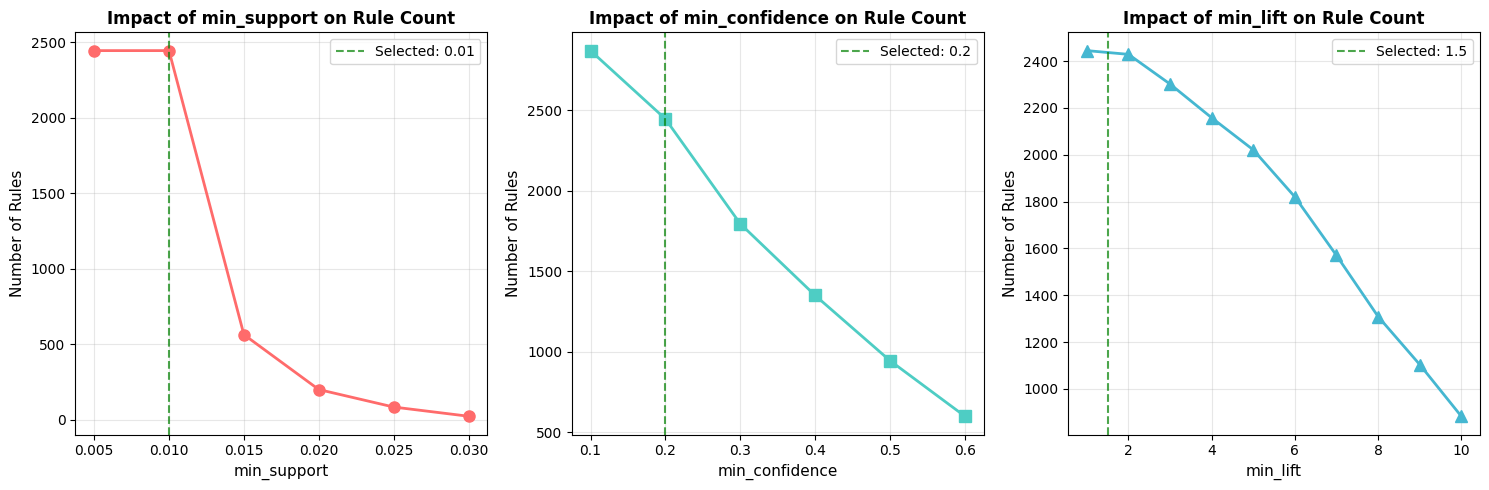

✓ Đã lưu: ../images/Req1_ParameterImpactAnalysis.png


In [5]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ: Ảnh hưởng của từng tham số đến số lượng luật
# -------------------------------------------------------------------------
IMAGES_DIR = "../images"
import os
os.makedirs(IMAGES_DIR, exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Chart 1: min_support
ax1 = axes[0]
ax1.plot(df_support['min_support'], df_support['n_rules'], 'o-', color='#FF6B6B', linewidth=2, markersize=8)
ax1.set_xlabel('min_support', fontsize=11)
ax1.set_ylabel('Number of Rules', fontsize=11)
ax1.set_title('Impact of min_support on Rule Count', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
# Đánh dấu điểm được chọn
ax1.axvline(x=0.01, color='green', linestyle='--', alpha=0.7, label='Selected: 0.01')
ax1.legend()

# Chart 2: min_confidence
ax2 = axes[1]
ax2.plot(df_confidence['min_confidence'], df_confidence['n_rules'], 's-', color='#4ECDC4', linewidth=2, markersize=8)
ax2.set_xlabel('min_confidence', fontsize=11)
ax2.set_ylabel('Number of Rules', fontsize=11)
ax2.set_title('Impact of min_confidence on Rule Count', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0.2, color='green', linestyle='--', alpha=0.7, label='Selected: 0.2')
ax2.legend()

# Chart 3: min_lift
ax3 = axes[2]
ax3.plot(df_lift['min_lift'], df_lift['n_rules'], '^-', color='#45B7D1', linewidth=2, markersize=8)
ax3.set_xlabel('min_lift', fontsize=11)
ax3.set_ylabel('Number of Rules', fontsize=11)
ax3.set_title('Impact of min_lift on Rule Count', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axvline(x=1.5, color='green', linestyle='--', alpha=0.7, label='Selected: 1.5')
ax3.legend()

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_ParameterImpactAnalysis.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/Req1_ParameterImpactAnalysis.png")

### 1.4 Chọn TopK luật hợp lý (không dùng số cụm K)

**Mục tiêu:** Chọn số lượng luật TopK phù hợp để đưa vào bước tạo đặc trưng ở Yêu cầu 2.

**Nguyên tắc:** Ở bước này **không sử dụng số cụm K** hay Silhouette/Elbow, vì đó là nội dung của **Yêu cầu 3**. Thay vào đó, ta chọn TopK dựa trên **chất lượng luật** và **độ "khả dụng" của luật** (proxy cho mức độ kích hoạt feature).

### 1.4 Độ khả dụng của một luật được tính như thế nào?

Với một luật $A \rightarrow B$ (trong đó $A$ là **antecedent**), "độ khả dụng" có thể hiểu là **mức độ luật có thể áp dụng được trên dữ liệu** (tức luật có hay được "kích hoạt" hay không). Có 2 cách đo phổ biến:

- **Theo giao dịch (transaction-level):** ước lượng bằng *antecedent support*
  $$\text{Availability}(A\rightarrow B) \approx \text{support}(A) = \frac{\#\{t: A\subseteq t\}}{N}$$
  Trong đó $t$ là một giao dịch/basket, $N$ là tổng số giao dịch. Nếu bảng luật có cột `antecedent_support` thì đây chính là giá trị này.
- **Theo khách hàng (customer-level):** luật "khả dụng" với khách hàng nếu khách hàng có ít nhất một giao dịch chứa $A$
  $$\text{Availability}_{cust}(A\rightarrow B) = \frac{\#\{c: \exists t\in T_c,\; A\subseteq t\}}{N_{cust}}$$

**Trong Yêu cầu 1.4** (chọn TopK bằng rule-only metrics), ta đang dùng **proxy transaction-level**: `ActivationProxy = mean(antecedent_support)` trên tập luật được chọn TopK. Lý do là ở bước này chưa tạo ma trận rule-feature theo khách hàng; bước đó sẽ nằm ở **Yêu cầu 2**.

**Các chỉ số sử dụng:**
- `AvgLift`, `AvgConfidence`, `AvgSupport` (đánh giá chất lượng luật)
- `ActivationProxy` = trung bình `antecedent_support` (nếu có) để ước lượng độ "dày" của vector rule-feature
- `AvgAntecedentLen` (tránh luật quá ngắn hoặc quá dài)

Kết quả sẽ được trực quan hóa bằng biểu đồ và lưu vào `images`.

In [6]:
# =============================================================================
# 1.4 CHỌN TOPK LUẬT HỢP LÝ (KHÔNG DÙNG SỐ CỤM K)
# =============================================================================

import os
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=" * 80)
print("CHỌN TOPK LUẬT HỢP LÝ (RULE-ONLY METRICS)")
print("=" * 80)

# -----------------------------------------------------------------------------
# 1) Output directories
# -----------------------------------------------------------------------------
IMAGES_DIR = "../images"
LOG_DIR = "../logs"
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# -----------------------------------------------------------------------------
# 2) Logger (ghi log để theo dõi quá trình chạy)
# -----------------------------------------------------------------------------
logger = logging.getLogger("Req1_TopK_Selection")
logger.setLevel(logging.INFO)
if not logger.handlers:
    fh = logging.FileHandler(os.path.join(LOG_DIR, "Req1_TopK_Selection.log"), encoding="utf-8")
    fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")
    fh.setFormatter(fmt)
    logger.addHandler(fh)

# -----------------------------------------------------------------------------
# 3) Cấu hình thử nghiệm TopK (có thể điều chỉnh)
# -----------------------------------------------------------------------------
TOPK_VALUES = [50, 100, 150, 200, 250, 300, 400, 500]

# Chọn một cấu hình lọc đại diện (dùng như baseline cho sweep TopK)
# Lưu ý: đây là cấu hình để tạo "pool rules" trước khi cắt TopK.
# Đồng bộ với mục 1.7: ưu tiên luật đơn giản (antecedent <= 2).
TOPK_BASE_CONFIG = {
    "min_support": 0.01,
    "min_confidence": 0.2,
    "min_lift": 1.5,
    "max_len_antecedents": 2,
    "max_len_consequents": 1,
}

print("\n[1] TopK sweep configuration:")
print(f"  TOPK_VALUES = {TOPK_VALUES}")
print("  BASE_CONFIG:")
for k, v in TOPK_BASE_CONFIG.items():
    print(f"    - {k}: {v}")

# -----------------------------------------------------------------------------
# 4) Chuẩn hóa tên cột (robust với nhiều định dạng)
# -----------------------------------------------------------------------------

def pick_col(df: pd.DataFrame, candidates: list[str]):
    for c in candidates:
        if c in df.columns:
            return c
    return None


def safe_itemset_len(x) -> float:
    try:
        return float(len(x))
    except Exception:
        return np.nan

# -----------------------------------------------------------------------------
# 5) Tạo pool rules theo BASE_CONFIG
# -----------------------------------------------------------------------------
start_pool = time.time()
rules_pool = fp_miner.filter_rules(
    min_support=TOPK_BASE_CONFIG["min_support"],
    min_confidence=TOPK_BASE_CONFIG["min_confidence"],
    min_lift=TOPK_BASE_CONFIG["min_lift"],
    max_len_antecedents=TOPK_BASE_CONFIG["max_len_antecedents"],
    max_len_consequents=TOPK_BASE_CONFIG["max_len_consequents"],
)

pool_time = time.time() - start_pool
print(f"\n[2] Rule pool size: {len(rules_pool):,} rules | Time: {pool_time:.2f}s")
logger.info(f"Rule pool size: {len(rules_pool)} rules | Time: {pool_time:.3f}s")

if len(rules_pool) == 0:
    raise ValueError("Rule pool rỗng. Hãy nới lỏng ngưỡng BASE_CONFIG để có đủ rules cho sweep TopK.")

# Xác định cột antecedent_support (nếu có)
ant_sup_col = pick_col(rules_pool, ["antecedent_support", "antecedent support", "antecedentSupport"])

# Xác định độ dài antecedent (nếu có cột antecedents)
ant_col = pick_col(rules_pool, ["antecedents", "antecedents_set", "antecedents_frozenset"])

# -----------------------------------------------------------------------------
# 6) Sweep TopK và tính các chỉ số rule-only
# -----------------------------------------------------------------------------
rows = []

# Sắp xếp theo lift → confidence → support (phù hợp ưu tiên chất lượng)
rules_sorted = rules_pool.sort_values(["lift", "confidence", "support"], ascending=[False, False, False]).reset_index(drop=True)

for topk in TOPK_VALUES:
    t0 = time.time()
    sel = rules_sorted.head(topk).copy()

    row = {
        "TopK": int(topk),
        "RulesAvailable": int(len(rules_sorted)),
        "RulesSelected": int(len(sel)),
        "AvgLift": float(sel["lift"].mean()),
        "MedLift": float(sel["lift"].median()),
        "AvgConfidence": float(sel["confidence"].mean()),
        "MedConfidence": float(sel["confidence"].median()),
        "AvgSupport": float(sel["support"].mean()),
        "MedSupport": float(sel["support"].median()),
    }

    # Activation proxy: mean antecedent_support (nếu tồn tại)
    if ant_sup_col is not None:
        row["ActivationProxyMean"] = float(sel[ant_sup_col].mean())
        row["ActivationProxyMed"] = float(sel[ant_sup_col].median())
    else:
        row["ActivationProxyMean"] = np.nan
        row["ActivationProxyMed"] = np.nan

    # Antecedent length (nếu tồn tại)
    if ant_col is not None:
        ant_lens = sel[ant_col].apply(safe_itemset_len)
        row["AvgAntecedentLen"] = float(np.nanmean(ant_lens))
        row["MedAntecedentLen"] = float(np.nanmedian(ant_lens))
    else:
        row["AvgAntecedentLen"] = np.nan
        row["MedAntecedentLen"] = np.nan

    # Composite score: nhấn mạnh lift và confidence
    row["RuleQualityScore"] = float(row["AvgLift"] * row["AvgConfidence"])

    row["TimeSec"] = float(time.time() - t0)
    rows.append(row)

    logger.info(
        f"TopK={topk} | AvgLift={row['AvgLift']:.3f} | AvgConf={row['AvgConfidence']:.3f} | "
        f"ActivationProxyMean={row['ActivationProxyMean'] if not np.isnan(row['ActivationProxyMean']) else 'NA'} | "
        f"Score={row['RuleQualityScore']:.3f}"
    )

# DataFrame kết quả của mục 1.4
TOPK_RULEONLY_DF = pd.DataFrame(rows)
print("\n[3] TopK sweep results:")
display(TOPK_RULEONLY_DF)

# Lưu kết quả
out_csv = "../data/mini_project/req1_topk_ruleonly_results.csv"
TOPK_RULEONLY_DF.to_csv(out_csv, index=False)
print(f"\n✓ Đã lưu: {out_csv}")
logger.info(f"Saved: {out_csv}")

CHỌN TOPK LUẬT HỢP LÝ (RULE-ONLY METRICS)

[1] TopK sweep configuration:
  TOPK_VALUES = [50, 100, 150, 200, 250, 300, 400, 500]
  BASE_CONFIG:
    - min_support: 0.01
    - min_confidence: 0.2
    - min_lift: 1.5
    - max_len_antecedents: 2
    - max_len_consequents: 1

[2] Rule pool size: 2,445 rules | Time: 0.00s

[3] TopK sweep results:


,TopK,RulesAvailable,RulesSelected,AvgLift,MedLift,AvgConfidence,MedConfidence,AvgSupport,MedSupport,ActivationProxyMean,ActivationProxyMed,AvgAntecedentLen,MedAntecedentLen,RuleQualityScore,TimeSec
0,50,2445,50,71.315572,70.937524,0.903828,0.907831,0.010671,0.010432,0.011822,0.011459,1.600,2.0,64.456981,0.000000
1,100,2445,100,58.415602,68.834390,0.827999,0.884913,0.011210,0.010710,0.013915,0.012818,1.400,1.0,48.368032,0.011130
2,150,2445,150,48.657655,41.964715,0.756074,0.786219,0.011576,0.011098,0.016103,0.014899,1.280,1.0,36.788764,0.002991
3,200,2445,200,42.209575,33.981165,0.727156,0.728568,0.011648,0.011209,0.017116,0.015648,1.300,1.0,30.692966,0.001994
4,250,2445,250,37.513891,29.446078,0.709287,0.704858,0.011814,0.011181,0.017742,0.016314,1.400,1.0,26.608120,0.002992
5,300,2445,300,34.184162,26.074128,0.697179,0.693454,0.012006,0.011209,0.018301,0.016758,1.460,1.0,23.832469,0.001995
6,400,2445,400,29.732118,20.078674,0.680512,0.680295,0.012314,0.011209,0.019295,0.018284,1.515,2.0,20.233072,0.001994
7,500,2445,500,26.754209,17.974289,0.663406,0.675373,0.012651,0.011209,0.020445,0.018756,1.528,2.0,17.748906,0.000997



✓ Đã lưu: ../data/mini_project/req1_topk_ruleonly_results.csv


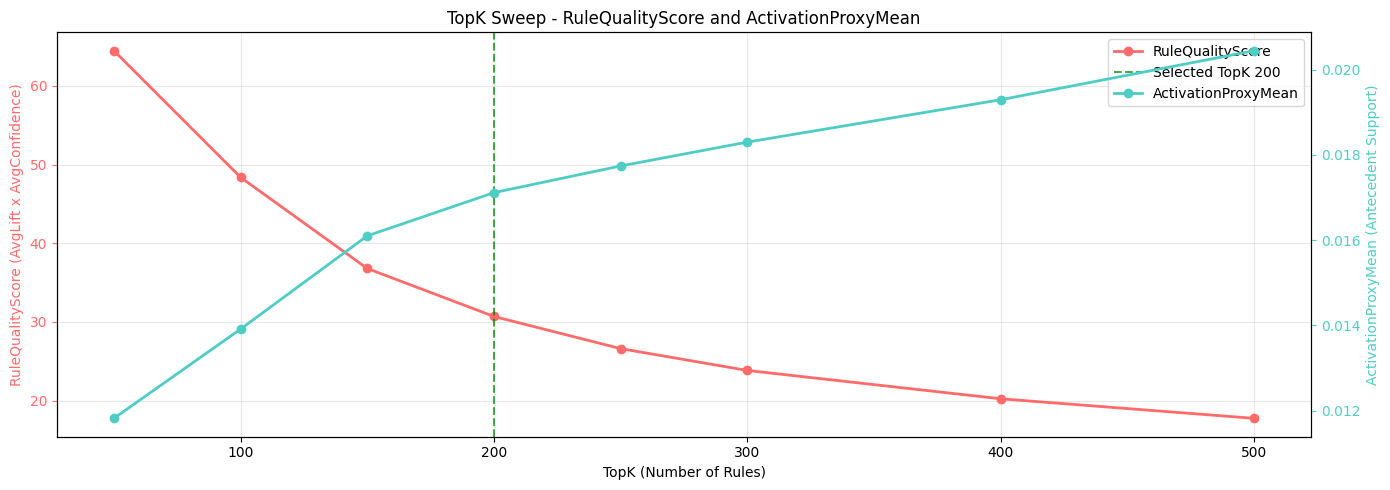

✓ Đã lưu: ../images/Req1_TopKRuleOnlySelection.png
Selected TopK (rule-only elbow on ActivationProxyMean): 200


In [7]:
# -----------------------------------------------------------------------------
# 7) Visualization (English only)
# -----------------------------------------------------------------------------

# Quy ước màu: tối đa 3 màu, tươi sáng
COLOR_1 = "#FF6B6B"  # red
COLOR_2 = "#4ECDC4"  # teal
COLOR_3 = "#45B7D1"  # blue (fallback)

# -----------------------------------------------------------------------------
# Helper: chọn TopK theo "elbow" của ActivationProxyMean
# - Ý tưởng: khi tăng TopK, ActivationProxyMean tăng dần nhưng sẽ có điểm mà mức tăng biên giảm mạnh.
# - Chọn TopK tại điểm mà slope (delta activation / delta TopK) giảm xuống <= 50% slope lớn nhất.
# -----------------------------------------------------------------------------

def select_topk_by_activation_elbow(
    df: pd.DataFrame,
    topk_col: str = "TopK",
    activation_col: str = "ActivationProxyMean",
    fallback_activation_col: str = "AvgSupport",
    slope_drop_ratio: float = 0.5,
) -> tuple[int, str]:
    df2 = df.copy().sort_values(topk_col).reset_index(drop=True)
    if activation_col in df2.columns and df2[activation_col].notna().any():
        y = df2[activation_col].astype(float).to_numpy()
        used_col = activation_col
    else:
        y = df2[fallback_activation_col].astype(float).to_numpy()
        used_col = fallback_activation_col
    x = df2[topk_col].astype(int).to_numpy()

    if len(x) < 3:
        return int(x[-1]), used_col

    dy = np.diff(y) / np.diff(x)
    max_dy = float(np.nanmax(dy))
    threshold = slope_drop_ratio * max_dy

    idx = np.where(dy <= threshold)[0]
    if len(idx) > 0:
        return int(x[idx[0] + 1]), used_col
    return int(x[-1]), used_col

# -----------------------------------------------------------------------------
# Combined chart with dual Y-axes
#   - Left Y:  RuleQualityScore
#   - Right Y: ActivationProxyMean
# -----------------------------------------------------------------------------

fig, ax_left = plt.subplots(figsize=(14, 5))
ax_right = ax_left.twinx()

x = TOPK_RULEONLY_DF["TopK"]
y_left = TOPK_RULEONLY_DF["RuleQualityScore"]

# Right axis series: prefer ActivationProxyMean; fallback to AvgSupport if missing
if TOPK_RULEONLY_DF["ActivationProxyMean"].notna().any():
    y_right = TOPK_RULEONLY_DF["ActivationProxyMean"]
    right_label = "ActivationProxyMean (Antecedent Support)"
    right_line_label = "ActivationProxyMean"
    right_color = COLOR_2
else:
    y_right = TOPK_RULEONLY_DF["AvgSupport"]
    right_label = "AvgSupport (Fallback)"
    right_line_label = "AvgSupport"
    right_color = COLOR_3

ax_left.plot(x, y_left, marker="o", color=COLOR_1, linewidth=2, label="RuleQualityScore")
ax_right.plot(x, y_right, marker="o", color=right_color, linewidth=2, label=right_line_label)

ax_left.set_xlabel("TopK (Number of Rules)")
ax_left.set_ylabel("RuleQualityScore (AvgLift x AvgConfidence)", color=COLOR_1)
ax_right.set_ylabel(right_label, color=right_color)

ax_left.tick_params(axis="y", colors=COLOR_1)
ax_right.tick_params(axis="y", colors=right_color)

ax_left.set_title("TopK Sweep - RuleQualityScore and ActivationProxyMean")
ax_left.grid(True, alpha=0.3)

# Tự động highlight TopK được chọn theo elbow (rule-only)
SELECTED_TOPK_RULEONLY, _used_col = select_topk_by_activation_elbow(TOPK_RULEONLY_DF, slope_drop_ratio=0.5)
if (x == SELECTED_TOPK_RULEONLY).any():
    ax_left.axvline(
        x=SELECTED_TOPK_RULEONLY,
        color="green",
        linestyle="--",
        alpha=0.7,
        label=f"Selected TopK {SELECTED_TOPK_RULEONLY}",
    )

# Legend: merge both axes handles
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()
ax_left.legend(handles_left + handles_right, labels_left + labels_right, loc="best")

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_TopKRuleOnlySelection.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/Req1_TopKRuleOnlySelection.png")
print(f"Selected TopK (rule-only elbow on {_used_col}): {SELECTED_TOPK_RULEONLY}")

### 1.5 Thử nghiệm toàn bộ tổ hợp (min_support, min_confidence, min_lift, topK)

**Mục tiêu:** Bổ sung một thử nghiệm "full-combination" (coarse grid) để kiểm tra tương tác giữa các tham số.

**Lưu ý quan trọng:** Ở Yêu cầu 1, ta vẫn chỉ dùng **rule-only metrics** (không dùng số cụm K hay Silhouette). Kết quả của bước này giúp chọn cấu hình hợp lý để đưa sang Yêu cầu 2–3.

**Đầu ra:**
- Bảng xếp hạng Top cấu hình theo `RuleQualityScore`
- Lưu file kết quả và log vào `data/mini_project` và `logs`.

FULL-COMBINATION SEARCH (RULE-ONLY METRICS)

[Grid size]
  SUPPORT_GRID: [0.01, 0.015, 0.02]
  CONF_GRID: [0.2, 0.3, 0.4]
  LIFT_GRID: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  TOPK_GRID: [50, 100, 150, 200, 250, 300, 400, 500]
  Total cases (max): 720
  TIME_LIMIT_SEC: 300

✓ Saved: ../data/mini_project\req1_full_combination_results.csv
✓ Cases computed: 720 | Elapsed: 0.78s | Stop early: False

[Ranking] MIN_RULES_REQUIRED >= 50
  Remaining cases: 696

Top 10 configurations by RuleQualityScore:


,min_support,min_confidence,min_lift,TopK,RulesAvailable,AvgLift,AvgConfidence,AvgSupport,ActivationProxyMean,RuleQualityScore
0,0.01,0.2,1,50,2445,71.315572,0.903828,0.010671,0.011822,64.456981
24,0.01,0.2,4,50,2158,71.315572,0.903828,0.010671,0.011822,64.456981
32,0.01,0.2,5,50,2021,71.315572,0.903828,0.010671,0.011822,64.456981
40,0.01,0.2,6,50,1820,71.315572,0.903828,0.010671,0.011822,64.456981
208,0.01,0.4,7,50,1184,71.315572,0.903828,0.010671,0.011822,64.456981
48,0.01,0.2,7,50,1570,71.315572,0.903828,0.010671,0.011822,64.456981
200,0.01,0.4,6,50,1292,71.315572,0.903828,0.010671,0.011822,64.456981
56,0.01,0.2,8,50,1309,71.315572,0.903828,0.010671,0.011822,64.456981
192,0.01,0.4,5,50,1324,71.315572,0.903828,0.010671,0.011822,64.456981
184,0.01,0.4,4,50,1339,71.315572,0.903828,0.010671,0.011822,64.456981


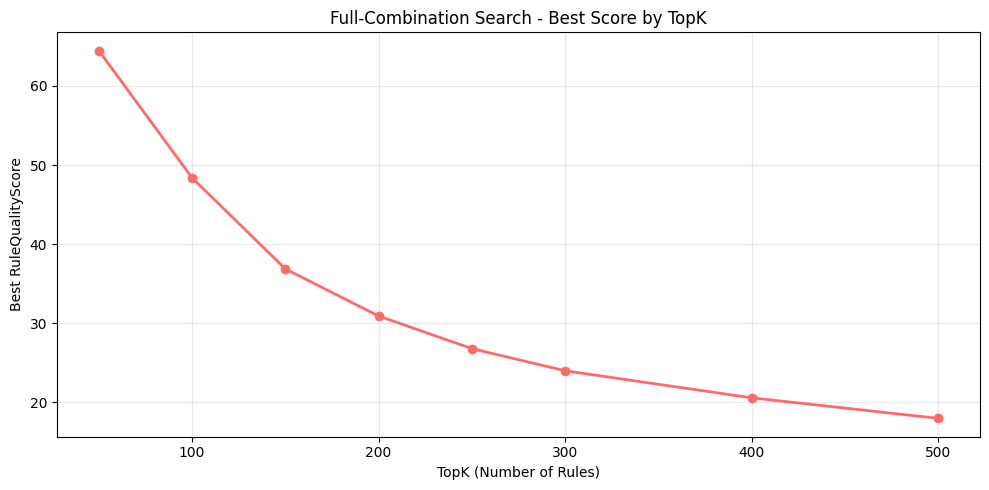

✓ Đã lưu: ../images/Req1_FullCombinationBestByTopK.png


In [8]:
# =============================================================================
# 1.5 FULL-COMBINATION (COARSE GRID) - RULE-ONLY METRICS
# =============================================================================

import os
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=" * 80)
print("FULL-COMBINATION SEARCH (RULE-ONLY METRICS)")
print("=" * 80)

IMAGES_DIR = "../images"
LOG_DIR = "../logs"
DATA_DIR = "../data/mini_project"
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

logger = logging.getLogger("Req1_FullCombination")
logger.setLevel(logging.INFO)
if not logger.handlers:
    fh = logging.FileHandler(os.path.join(LOG_DIR, "Req1_FullCombination.log"), encoding="utf-8")
    fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")
    fh.setFormatter(fmt)
    logger.addHandler(fh)

# -----------------------------------------------------------------------------
# Coarse grids (giữ vừa đủ để chạy nhanh)
# Có thể mở rộng nếu bạn muốn chạy lâu hơn.
# -----------------------------------------------------------------------------
SUPPORT_GRID = [0.01, 0.015, 0.02]
CONF_GRID = [0.2, 0.3, 0.4]
LIFT_GRID = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
TOPK_GRID = [50, 100, 150, 200, 250, 300, 400, 500]

# Giới hạn thời gian (theo yêu cầu thử nghiệm)
TIME_LIMIT_SEC = 300

print("\n[Grid size]")
print(f"  SUPPORT_GRID: {SUPPORT_GRID}")
print(f"  CONF_GRID: {CONF_GRID}")
print(f"  LIFT_GRID: {LIFT_GRID}")
print(f"  TOPK_GRID: {TOPK_GRID}")
print(f"  Total cases (max): {len(SUPPORT_GRID) * len(CONF_GRID) * len(LIFT_GRID) * len(TOPK_GRID)}")
print(f"  TIME_LIMIT_SEC: {TIME_LIMIT_SEC}")

# Chuẩn hóa tên cột (robust)

def pick_col(df: pd.DataFrame, candidates: list[str]):
    for c in candidates:
        if c in df.columns:
            return c
    return None

start_all = time.time()
rows = []

case_count = 0
stop_early = False

for sup in SUPPORT_GRID:
    for conf in CONF_GRID:
        for lift in LIFT_GRID:
            # Tạo pool rules theo (sup, conf, lift)
            rules_pool = fp_miner.filter_rules(
                min_support=sup,
                min_confidence=conf,
                min_lift=lift,
                max_len_antecedents=2,
                max_len_consequents=1,
            )

            if len(rules_pool) == 0:
                for topk in TOPK_GRID:
                    rows.append({
                        "min_support": sup,
                        "min_confidence": conf,
                        "min_lift": lift,
                        "TopK": topk,
                        "RulesAvailable": 0,
                        "RulesSelected": 0,
                        "AvgLift": 0.0,
                        "AvgConfidence": 0.0,
                        "AvgSupport": 0.0,
                        "ActivationProxyMean": np.nan,
                        "RuleQualityScore": 0.0,
                    })
                continue

            ant_sup_col = pick_col(rules_pool, ["antecedent_support", "antecedent support", "antecedentSupport"])

            rules_sorted = rules_pool.sort_values(["lift", "confidence", "support"], ascending=[False, False, False]).reset_index(drop=True)

            for topk in TOPK_GRID:
                case_count += 1
                if (time.time() - start_all) > TIME_LIMIT_SEC:
                    stop_early = True
                    break

                sel = rules_sorted.head(topk)

                avg_lift = float(sel["lift"].mean())
                avg_conf = float(sel["confidence"].mean())
                avg_sup = float(sel["support"].mean())

                if ant_sup_col is not None:
                    activation = float(sel[ant_sup_col].mean())
                else:
                    activation = np.nan

                score = float(avg_lift * avg_conf)

                rows.append({
                    "min_support": sup,
                    "min_confidence": conf,
                    "min_lift": lift,
                    "TopK": topk,
                    "RulesAvailable": int(len(rules_sorted)),
                    "RulesSelected": int(len(sel)),
                    "AvgLift": avg_lift,
                    "AvgConfidence": avg_conf,
                    "AvgSupport": avg_sup,
                    "ActivationProxyMean": activation,
                    "RuleQualityScore": score,
                })

            if stop_early:
                break
        if stop_early:
            break
    if stop_early:
        break

FULLCOMB_DF = pd.DataFrame(rows)

out_csv = os.path.join(DATA_DIR, "req1_full_combination_results.csv")
FULLCOMB_DF.to_csv(out_csv, index=False)

elapsed = time.time() - start_all
print(f"\n✓ Saved: {out_csv}")
print(f"✓ Cases computed: {len(FULLCOMB_DF):,} | Elapsed: {elapsed:.2f}s | Stop early: {stop_early}")
logger.info(f"Saved: {out_csv} | cases={len(FULLCOMB_DF)} | elapsed={elapsed:.2f}s | stop_early={stop_early}")

# -----------------------------------------------------------------------------
# Xếp hạng cấu hình (lọc các cấu hình có đủ rules)
# -----------------------------------------------------------------------------
MIN_RULES_REQUIRED = 50
FULLCOMB_RANK_DF = FULLCOMB_DF[FULLCOMB_DF["RulesAvailable"] >= MIN_RULES_REQUIRED].copy()
FULLCOMB_RANK_DF = FULLCOMB_RANK_DF.sort_values("RuleQualityScore", ascending=False)

print(f"\n[Ranking] MIN_RULES_REQUIRED >= {MIN_RULES_REQUIRED}")
print(f"  Remaining cases: {len(FULLCOMB_RANK_DF):,}")

FULLCOMB_TOP10 = FULLCOMB_RANK_DF.head(10)[
    ["min_support", "min_confidence", "min_lift", "TopK", "RulesAvailable", "AvgLift", "AvgConfidence", "AvgSupport", "ActivationProxyMean", "RuleQualityScore"]
]

print("\nTop 10 configurations by RuleQualityScore:")
display(FULLCOMB_TOP10)

# -----------------------------------------------------------------------------
# Visualization: TopK vs best score (English only)
# (mỗi TopK lấy cấu hình có score tốt nhất)
# -----------------------------------------------------------------------------
FULLCOMB_BEST_BY_TOPK = (
    FULLCOMB_RANK_DF.groupby("TopK", as_index=False)
    .agg({"RuleQualityScore": "max"})
    .sort_values("TopK")
)

plt.figure(figsize=(10, 5))
plt.plot(FULLCOMB_BEST_BY_TOPK["TopK"], FULLCOMB_BEST_BY_TOPK["RuleQualityScore"], marker="o", color="#FF6B6B", linewidth=2)
plt.xlabel("TopK (Number of Rules)")
plt.ylabel("Best RuleQualityScore")
plt.title("Full-Combination Search - Best Score by TopK")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_FullCombinationBestByTopK.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/Req1_FullCombinationBestByTopK.png")

### 1.6 Kết luận chọn tham số tối ưu

> **Vấn đề cần nhất quán:** Nếu chỉ tối ưu `RuleQualityScore = AvgLift × AvgConfidence` thì TopK nhỏ (ví dụ 50) thường thắng vì "chỉ giữ luật rất mạnh".

> **Cách làm logic cho pipeline (rule-only):** Ta chọn TopK theo **trade-off**: cần đủ luật để đặc trưng hóa hành vi (không quá thưa/sparse) nên ưu tiên TopK tại **điểm gãy (elbow)** của đường `ActivationProxyMean` theo TopK (mức tăng biên bắt đầu giảm mạnh).

> Sau khi đã chốt TopK, ta dùng kết quả **full-combination** (mục 1.5) để chọn bộ `(min_support, min_confidence, min_lift)` tốt nhất tương ứng với TopK đó (vẫn không dùng K hay Silhouette).

In [9]:
# =============================================================================
# 1.6 KẾT LUẬN CHỌN THAM SỐ TỐI ƯU (TỪ OFAT + TOPK SWEEP + FULL COMBINATION)
# =============================================================================

import os

print("=" * 80)
print("KẾT LUẬN CHỌN THAM SỐ TỐI ƯU")
print("=" * 80)

DATA_DIR = "../data/mini_project"
TOPK_RULEONLY_CSV = os.path.join(DATA_DIR, "req1_topk_ruleonly_results.csv")
FULLCOMB_CSV = os.path.join(DATA_DIR, "req1_full_combination_results.csv")

# -----------------------------------------------------------------------------
# 1) Chọn TopK theo trade-off (rule-only): elbow trên ActivationProxyMean
#    - Chọn điểm mà slope (delta activation / delta TopK) giảm xuống <= 50% slope lớn nhất.
#    - Điều này giúp tránh TopK quá nhỏ (đặc trưng hóa nghèo nàn) hoặc quá lớn (nhiễu, tốn compute).
# -----------------------------------------------------------------------------

def select_topk_by_activation_elbow(
    df: pd.DataFrame,
    topk_col: str = "TopK",
    activation_col: str = "ActivationProxyMean",
    fallback_activation_col: str = "AvgSupport",
    slope_drop_ratio: float = 0.5,
) -> tuple[int, str, float]:
    df2 = df.copy().sort_values(topk_col).reset_index(drop=True)
    if activation_col in df2.columns and df2[activation_col].notna().any():
        y = df2[activation_col].astype(float).to_numpy()
        used_col = activation_col
    else:
        y = df2[fallback_activation_col].astype(float).to_numpy()
        used_col = fallback_activation_col
    x = df2[topk_col].astype(int).to_numpy()

    if len(x) < 3:
        return int(x[-1]), used_col, float("nan")

    dy = np.diff(y) / np.diff(x)
    max_dy = float(np.nanmax(dy))
    threshold = slope_drop_ratio * max_dy

    idx = np.where(dy <= threshold)[0]
    if len(idx) > 0:
        return int(x[idx[0] + 1]), used_col, threshold
    return int(x[-1]), used_col, threshold

# Load TopK sweep results (ưu tiên CSV để bám sát output)
if os.path.exists(TOPK_RULEONLY_CSV):
    topk_df = pd.read_csv(TOPK_RULEONLY_CSV)
elif "TOPK_RULEONLY_DF" in globals() and TOPK_RULEONLY_DF is not None and len(TOPK_RULEONLY_DF) > 0:
    topk_df = TOPK_RULEONLY_DF.copy()
else:
    raise ValueError("Chưa có TOPK_RULEONLY_DF và cũng không thấy file req1_topk_ruleonly_results.csv. Hãy chạy mục 1.4.")

selected_topk, used_activation_col, slope_threshold = select_topk_by_activation_elbow(topk_df, slope_drop_ratio=0.5)

# -----------------------------------------------------------------------------
# 2) Chọn (min_support, min_confidence, min_lift) tốt nhất theo full-combination
#    (fix TopK = selected_topk)
# -----------------------------------------------------------------------------

# Load full-combination results (ưu tiên CSV)
if os.path.exists(FULLCOMB_CSV):
    fullcomb_df = pd.read_csv(FULLCOMB_CSV)
elif "FULLCOMB_DF" in globals() and FULLCOMB_DF is not None and len(FULLCOMB_DF) > 0:
    fullcomb_df = FULLCOMB_DF.copy()
elif "FULLCOMB_RANK_DF" in globals() and FULLCOMB_RANK_DF is not None and len(FULLCOMB_RANK_DF) > 0:
    fullcomb_df = FULLCOMB_RANK_DF.copy()
else:
    raise ValueError("Chưa có FULLCOMB_DF/FULLCOMB_RANK_DF và cũng không thấy file req1_full_combination_results.csv. Hãy chạy mục 1.5.")

MIN_RULES_REQUIRED = 50
fullcomb_rank = fullcomb_df[fullcomb_df["RulesAvailable"] >= MIN_RULES_REQUIRED].copy()
fullcomb_rank = fullcomb_rank.sort_values("RuleQualityScore", ascending=False)

pool = fullcomb_rank[fullcomb_rank["TopK"] == selected_topk].copy()
if len(pool) == 0:
    best_row = fullcomb_rank.iloc[0]
else:
    best_row = pool.sort_values("RuleQualityScore", ascending=False).iloc[0]

FINAL_MIN_SUPPORT = float(best_row["min_support"])
FINAL_MIN_CONFIDENCE = float(best_row["min_confidence"])
FINAL_MIN_LIFT = float(best_row["min_lift"])
FINAL_TOP_K = int(best_row["TopK"])

# -----------------------------------------------------------------------------
# Report
# -----------------------------------------------------------------------------

print(f"\nKẾT QUẢ LỰA CHỌN (RULE-ONLY):")
print("=" * 80)
print(f"• Selected TopK: {FINAL_TOP_K}")
print(f"  - Criterion: Elbow on {used_activation_col} (slope <= 50% of max slope)")
if not np.isnan(slope_threshold):
    print(f"  - Slope threshold (approx): {slope_threshold:.6g}")
print(f"• Selected thresholds from full-combination (TopK fixed = {FINAL_TOP_K}):")
print(f"  - min_support    = {FINAL_MIN_SUPPORT}")
print(f"  - min_confidence = {FINAL_MIN_CONFIDENCE}")
print(f"  - min_lift       = {FINAL_MIN_LIFT}")

print("\nTÓM TẮT LÝ DO (ngắn gọn):")
print("-" * 80)
print("• OFAT: quan sát xu hướng từng tham số, tránh chọn ngưỡng cực đoan")
print("• TopK sweep: chọn TopK theo trade-off (điểm gãy của ActivationProxyMean) để feature không quá thưa")
print("• Full-combination (coarse): chọn ngưỡng tốt nhất ứng với TopK đã chốt, vẫn không dùng số cụm K")

print("\n✓ Đã xác định tham số tối ưu dựa trên phân tích thực nghiệm (Yêu cầu 1)")

KẾT LUẬN CHỌN THAM SỐ TỐI ƯU

KẾT QUẢ LỰA CHỌN (RULE-ONLY):
• Selected TopK: 200
  - Criterion: Elbow on ActivationProxyMean (slope <= 50% of max slope)
  - Slope threshold (approx): 2.18726e-05
• Selected thresholds from full-combination (TopK fixed = 200):
  - min_support    = 0.01
  - min_confidence = 0.4
  - min_lift       = 4.0

TÓM TẮT LÝ DO (ngắn gọn):
--------------------------------------------------------------------------------
• OFAT: quan sát xu hướng từng tham số, tránh chọn ngưỡng cực đoan
• TopK sweep: chọn TopK theo trade-off (điểm gãy của ActivationProxyMean) để feature không quá thưa
• Full-combination (coarse): chọn ngưỡng tốt nhất ứng với TopK đã chốt, vẫn không dùng số cụm K

✓ Đã xác định tham số tối ưu dựa trên phân tích thực nghiệm (Yêu cầu 1)


### 1.7 Áp dụng tham số đã chọn và lọc luật

Áp dụng các tham số tối ưu đã xác định từ bước 1.6 để lọc ra tập luật cuối cùng cho phân cụm.

In [10]:
# =============================================================================
# 1.7 ÁP DỤNG THAM SỐ ĐÃ CHỌN VÀ LỌC LUẬT
# =============================================================================

print("=" * 80)
print("ÁP DỤNG THAM SỐ TỐI ƯU ĐÃ XÁC ĐỊNH (YÊU CẦU 1)")
print("=" * 80)

print(f"""
THAM SỐ ÁP DỤNG (từ OFAT + TopK sweep + Full-combination - rule-only):
---------------------------------------------------
• min_support    = {FINAL_MIN_SUPPORT}
• min_confidence = {FINAL_MIN_CONFIDENCE}
• min_lift       = {FINAL_MIN_LIFT}
• TOP_K          = {FINAL_TOP_K}
• max_antecedents = 2 (giữ luật đơn giản)
• max_consequents = 1 (một sản phẩm gợi ý)
""")

# Lọc luật với tham số đã chọn
rules_filtered = fp_miner.filter_rules(
    min_support=FINAL_MIN_SUPPORT,
    min_confidence=FINAL_MIN_CONFIDENCE,
    min_lift=FINAL_MIN_LIFT,
    max_len_antecedents=2,
    max_len_consequents=1,
)

print(f"KẾT QUẢ LỌC:")
print(f"  → Số luật thỏa mãn điều kiện: {len(rules_filtered):,}")

# Nếu có nhiều hơn TOP_K, chọn TOP_K theo lift
if len(rules_filtered) > FINAL_TOP_K:
    rules_filtered = rules_filtered.nlargest(FINAL_TOP_K, 'lift')
    print(f"  → Lấy Top-{FINAL_TOP_K} luật theo Lift: {len(rules_filtered):,}")
else:
    print(f"  → Số luật < {FINAL_TOP_K}, giữ nguyên tất cả")

# Hiển thị thống kê
avg_support = rules_filtered['support'].mean()
avg_confidence = rules_filtered['confidence'].mean()
avg_lift = rules_filtered['lift'].mean()
max_lift = rules_filtered['lift'].max()

print(f"""
THỐNG KÊ LUẬT ĐÃ LỌC:
---------------------
• Số luật: {len(rules_filtered):,}
• Support:    avg={avg_support:.4f}
• Confidence: avg={avg_confidence:.2%}
• Lift:       avg={avg_lift:.2f}, max={max_lift:.2f}
""")

ÁP DỤNG THAM SỐ TỐI ƯU ĐÃ XÁC ĐỊNH (YÊU CẦU 1)

THAM SỐ ÁP DỤNG (từ OFAT + TopK sweep + Full-combination - rule-only):
---------------------------------------------------
• min_support    = 0.01
• min_confidence = 0.4
• min_lift       = 4.0
• TOP_K          = 200
• max_antecedents = 2 (giữ luật đơn giản)
• max_consequents = 1 (một sản phẩm gợi ý)

KẾT QUẢ LỌC:
  → Số luật thỏa mãn điều kiện: 1,339
  → Lấy Top-200 luật theo Lift: 200

THỐNG KÊ LUẬT ĐÃ LỌC:
---------------------
• Số luật: 200
• Support:    avg=0.0116
• Confidence: avg=73.37%
• Lift:       avg=42.13, max=74.57



### 1.7.1 Bảng 10 luật tiêu biểu

Trích ra 10 luật đại diện với chất lượng cao nhất (theo Lift) để minh chứng cho việc lựa chọn tham số phù hợp.

In [11]:
# =============================================================================
# BẢNG 10 LUẬT TIÊU BIỂU (MINH CHỨNG CHẤT LƯỢNG)
# =============================================================================

print("=" * 100)
print("BẢNG 10 LUẬT KẾT HỢP TIÊU BIỂU (SẮP XẾP THEO LIFT)")
print("=" * 100)

# Chọn các cột cần hiển thị
cols_display = ["antecedents_str", "consequents_str", "support", "confidence", "lift"]

# Lấy Top 10 luật theo lift
top_10_rules = rules_filtered.sort_values("lift", ascending=False).head(10)[cols_display].copy()

# Đổi tên cột cho dễ đọc
top_10_rules.columns = ["Antecedent (Mua truoc)", "Consequent (Mua kem)", "Support", "Confidence", "Lift"]

# Reset index để đánh số từ 1
top_10_rules = top_10_rules.reset_index(drop=True)
top_10_rules.index = top_10_rules.index + 1
top_10_rules.index.name = "STT"

# Hiển thị bảng
display(top_10_rules)

print("""
GIẢI THÍCH Ý NGHĨA CÁC CHỈ SỐ:
------------------------------
• Support: Tỷ lệ giao dịch chứa cả antecedent và consequent
  (Ví dụ: 0.015 = 1.5% tổng số giao dịch)
  
• Confidence: Xác suất mua consequent khi đã mua antecedent
  (Ví dụ: 0.45 = 45% khách mua A sẽ mua thêm B)
  
• Lift: Độ mạnh liên kết so với ngẫu nhiên
  (Ví dụ: Lift = 5.0 → mua kèm GẤP 5 LẦN so với ngẫu nhiên)

NHẬN XÉT:
---------
• Tất cả 10 luật đều có Lift > 1.5 → liên kết mạnh
• Confidence từ {:.0%} đến {:.0%} → độ tin cậy khá
• Các luật phản ánh hành vi mua kèm thực sự của khách hàng
""".format(top_10_rules['Confidence'].min(), top_10_rules['Confidence'].max()))

BẢNG 10 LUẬT KẾT HỢP TIÊU BIỂU (SẮP XẾP THEO LIFT)


,Antecedent (Mua truoc),Consequent (Mua kem),Support,Confidence,Lift
STT,,,,,
1,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010932,0.951691,74.567045
2,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010599,0.955000,74.502403
3,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,0.010432,0.940000,74.297105
4,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010932,0.951691,74.244244
5,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010710,0.950739,74.169983
6,"HERB MARKER BASIL, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010710,0.936893,73.407619
7,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010599,0.931707,73.001294
8,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER PARSLEY,0.010488,0.921951,72.870539
9,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER PARSLEY,0.010377,0.921182,72.809761



GIẢI THÍCH Ý NGHĨA CÁC CHỈ SỐ:
------------------------------
• Support: Tỷ lệ giao dịch chứa cả antecedent và consequent
  (Ví dụ: 0.015 = 1.5% tổng số giao dịch)

• Confidence: Xác suất mua consequent khi đã mua antecedent
  (Ví dụ: 0.45 = 45% khách mua A sẽ mua thêm B)

• Lift: Độ mạnh liên kết so với ngẫu nhiên
  (Ví dụ: Lift = 5.0 → mua kèm GẤP 5 LẦN so với ngẫu nhiên)

NHẬN XÉT:
---------
• Tất cả 10 luật đều có Lift > 1.5 → liên kết mạnh
• Confidence từ 92% đến 96% → độ tin cậy khá
• Các luật phản ánh hành vi mua kèm thực sự của khách hàng



### 1.8 Thống kê tổng hợp và lưu kết quả

In [12]:
# =============================================================================
# THỐNG KÊ TỔNG HỢP VÀ LƯU KẾT QUẢ
# =============================================================================

print("=" * 80)
print("THỐNG KÊ TỔNG HỢP VỀ LUẬT ĐÃ CHỌN")
print("=" * 80)

print(f"""
THÔNG TIN LUẬT ĐẦU VÀO CHO PHÂN CỤM:
------------------------------------
• Thuật toán sử dụng: FP-Growth
• Tổng số luật sau lọc: {len(rules_filtered):,}

THAM SỐ ĐÃ ÁP DỤNG (kết quả từ mục 1.6):
• min_support    = {FINAL_MIN_SUPPORT}
• min_confidence = {FINAL_MIN_CONFIDENCE}
• min_lift       = {FINAL_MIN_LIFT}
• TOP_K          = {FINAL_TOP_K}
""")

print("PHÂN PHỐI CHỈ SỐ:")
print("-" * 50)
print(f"  • Support:    min={rules_filtered['support'].min():.4f}, max={rules_filtered['support'].max():.4f}, mean={rules_filtered['support'].mean():.4f}")
print(f"  • Confidence: min={rules_filtered['confidence'].min():.4f}, max={rules_filtered['confidence'].max():.4f}, mean={rules_filtered['confidence'].mean():.4f}")
print(f"  • Lift:       min={rules_filtered['lift'].min():.2f}, max={rules_filtered['lift'].max():.2f}, mean={rules_filtered['lift'].mean():.2f}")

# Thống kê độ dài antecedent
print("\nĐỘ DÀI ANTECEDENT (số sản phẩm bên trái):")
ant_lengths = rules_filtered['antecedents'].apply(len).value_counts().sort_index()
for length, count in ant_lengths.items():
    print(f"  • {length} sản phẩm: {count:,} luật ({count/len(rules_filtered)*100:.1f}%)")

# Lưu luật đã lọc
print("\n" + "=" * 80)
print("LƯU KẾT QUẢ")
print("=" * 80)

fp_miner.save_rules(output_path=RULES_OUTPUT_PATH, rules_df=rules_filtered)
print(f"\n✓ Đã lưu {len(rules_filtered):,} luật vào: {RULES_OUTPUT_PATH}")

print("\n" + "=" * 80)
print("HOÀN THÀNH YÊU CẦU 1")
print("=" * 80)
print(f"""
TÓM TẮT:
--------
✓ Đã khai thác luật bằng FP-Growth
✓ Đã khảo sát và phân tích tham số (OFAT + TopK sweep + full-combination)
✓ Đã chọn tham số tối ưu dựa trên phân tích thực nghiệm (rule-only)
✓ Đã lọc và lưu {len(rules_filtered):,} luật chất lượng cao
✓ Sẵn sàng cho bước phân cụm (Yêu cầu 2)
""")

THỐNG KÊ TỔNG HỢP VỀ LUẬT ĐÃ CHỌN

THÔNG TIN LUẬT ĐẦU VÀO CHO PHÂN CỤM:
------------------------------------
• Thuật toán sử dụng: FP-Growth
• Tổng số luật sau lọc: 200

THAM SỐ ĐÃ ÁP DỤNG (kết quả từ mục 1.6):
• min_support    = 0.01
• min_confidence = 0.4
• min_lift       = 4.0
• TOP_K          = 200

PHÂN PHỐI CHỈ SỐ:
--------------------------------------------------
  • Support:    min=0.0101, max=0.0204, mean=0.0116
  • Confidence: min=0.4272, max=0.9757, mean=0.7337
  • Lift:       min=19.70, max=74.57, mean=42.13

ĐỘ DÀI ANTECEDENT (số sản phẩm bên trái):
  • 1 sản phẩm: 136 luật (68.0%)
  • 2 sản phẩm: 64 luật (32.0%)

LƯU KẾT QUẢ
Đã lưu luật vào: ../data/mini_project/rules_fpgrowth_filtered.csv

✓ Đã lưu 200 luật vào: ../data/mini_project/rules_fpgrowth_filtered.csv

HOÀN THÀNH YÊU CẦU 1

TÓM TẮT:
--------
✓ Đã khai thác luật bằng FP-Growth
✓ Đã khảo sát và phân tích tham số (OFAT + TopK sweep + full-combination)
✓ Đã chọn tham số tối ưu dựa trên phân tích thực nghiệm (rule-o

### 1.9 Trực quan hóa kết quả luật kết hợp

TRỰC QUAN HÓA KẾT QUẢ LUẬT KẾT HỢP


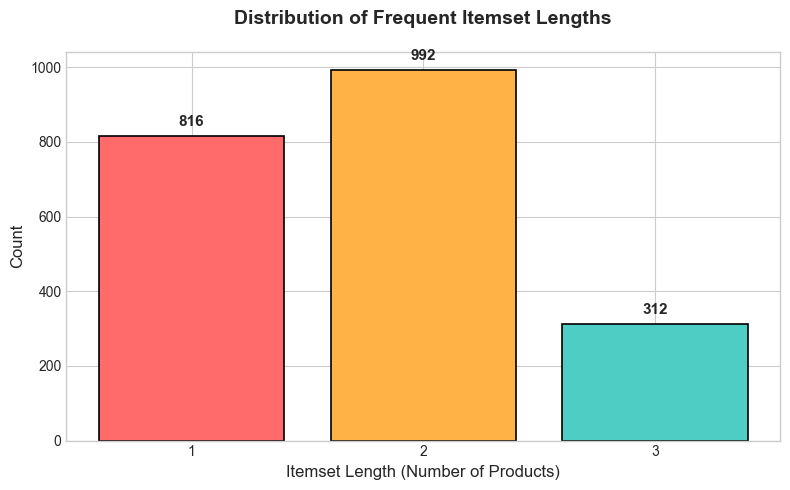

Da luu: ../images/Req1_ItemsetLengthDistribution.png


In [13]:
# =============================================================================
# TRỰC QUAN HÓA KẾT QUẢ LUẬT KẾT HỢP
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Thiết lập style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("bright")

# Tạo thư mục images nếu chưa có
import os
IMAGES_DIR = "../images"
os.makedirs(IMAGES_DIR, exist_ok=True)

print("=" * 80)
print("TRỰC QUAN HÓA KẾT QUẢ LUẬT KẾT HỢP")
print("=" * 80)

# -------------------------------------------------------------------------
# BIỂU ĐỒ 1: Phân phối độ dài Itemset (Frequent Itemsets)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

itemset_lengths = frequent_itemsets['itemsets'].apply(len).value_counts().sort_index()

colors_gradient = ['#FF6B6B', '#FFB347', '#4ECDC4'][:len(itemset_lengths)]
bars = ax.bar(itemset_lengths.index, itemset_lengths.values, color=colors_gradient, edgecolor='black', linewidth=1.2)

# Thêm giá trị trên cột
for bar, value in zip(bars, itemset_lengths.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
            f'{value:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Itemset Length (Number of Products)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Frequent Itemset Lengths', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(itemset_lengths.index)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_ItemsetLengthDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_ItemsetLengthDistribution.png")

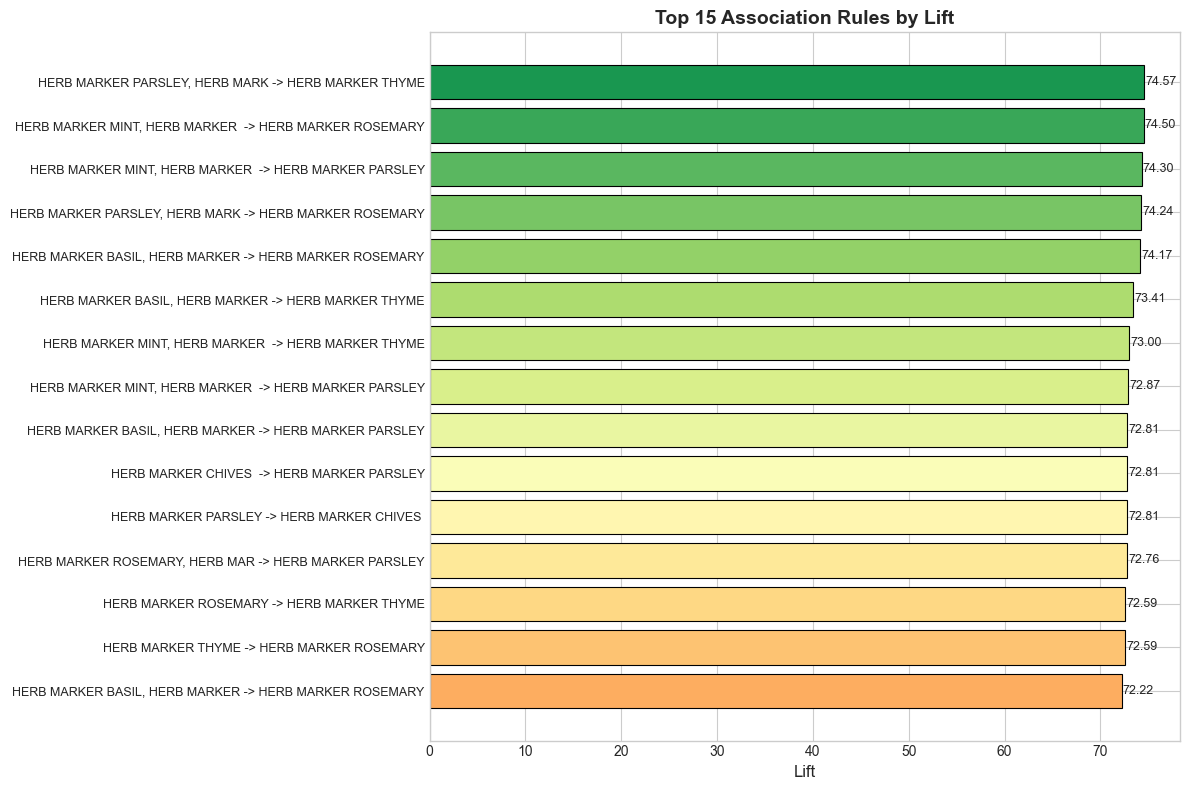

Da luu: ../images/Req1_Top15RulesByLift.png


In [14]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 2: Top 15 luật theo Lift (Bar Chart)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

top_15_lift = rules_filtered.sort_values('lift', ascending=False).head(15).copy()
top_15_lift['rule_short'] = top_15_lift['antecedents_str'].str[:30] + ' -> ' + top_15_lift['consequents_str'].str[:30]

# Đảo ngược để luật cao nhất ở trên
top_15_lift = top_15_lift.iloc[::-1]

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_15_lift)))
bars = ax.barh(range(len(top_15_lift)), top_15_lift['lift'], color=colors, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(top_15_lift)))
ax.set_yticklabels(top_15_lift['rule_short'], fontsize=9)
ax.set_xlabel('Lift', fontsize=12)
ax.set_title('Top 15 Association Rules by Lift', fontsize=14, fontweight='bold')

# Thêm giá trị
for i, (bar, value) in enumerate(zip(bars, top_15_lift['lift'])):
    ax.text(value + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{value:.2f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_Top15RulesByLift.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_Top15RulesByLift.png")

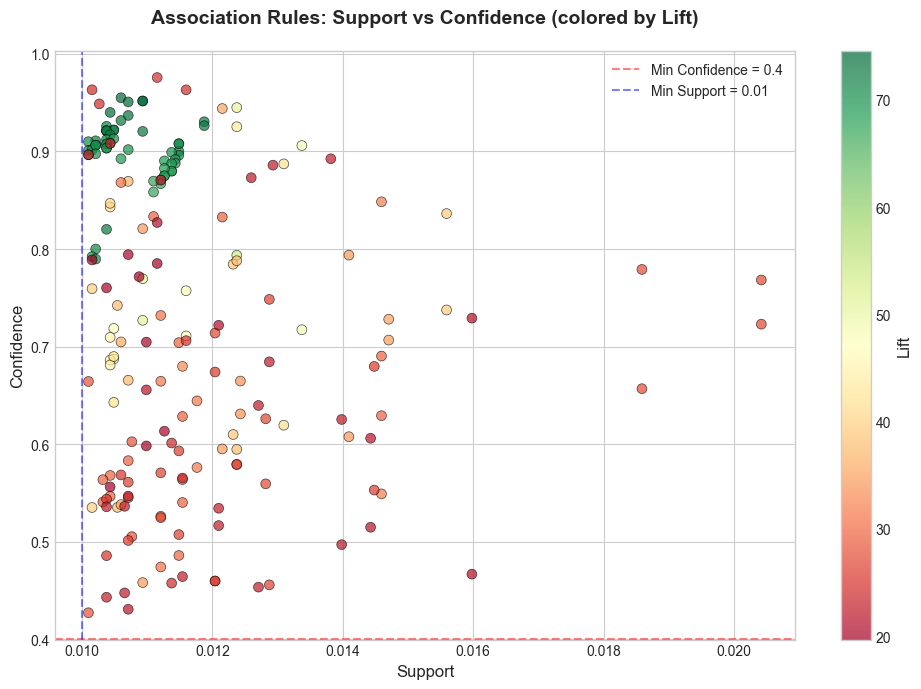

Da luu: ../images/Req1_SupportConfidenceScatter.png


In [15]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 3: Scatter Plot - Support vs Confidence (màu theo Lift)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    rules_filtered['support'], 
    rules_filtered['confidence'],
    c=rules_filtered['lift'],
    cmap='RdYlGn',
    s=50,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lift', fontsize=12)

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_title('Association Rules: Support vs Confidence (colored by Lift)', fontsize=14, fontweight='bold', pad=20)

# Thêm đường tham chiếu với biến FINAL_*
ax.axhline(y=FINAL_MIN_CONFIDENCE, color='red', linestyle='--', alpha=0.5, label=f'Min Confidence = {FINAL_MIN_CONFIDENCE}')
ax.axvline(x=FINAL_MIN_SUPPORT, color='blue', linestyle='--', alpha=0.5, label=f'Min Support = {FINAL_MIN_SUPPORT}')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_SupportConfidenceScatter.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_SupportConfidenceScatter.png")

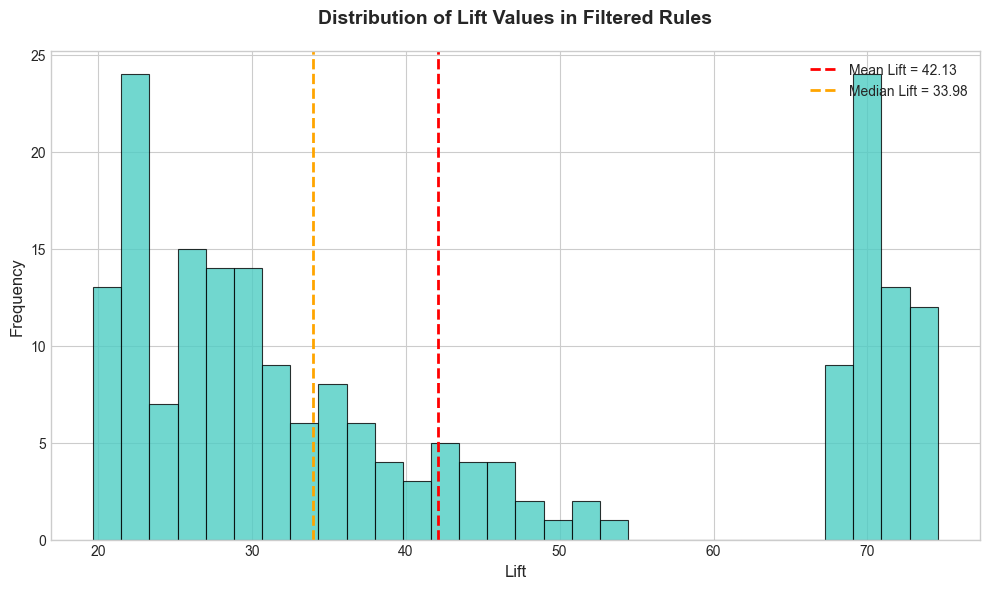

Da luu: ../images/Req1_LiftDistribution.png


In [16]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 4: Phân phối Lift của các luật đã lọc (Histogram)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(rules_filtered['lift'], bins=30, color='#4ECDC4', edgecolor='black', linewidth=0.8, alpha=0.8)

ax.axvline(x=rules_filtered['lift'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean Lift = {rules_filtered["lift"].mean():.2f}')
ax.axvline(x=rules_filtered['lift'].median(), color='orange', linestyle='--', linewidth=2, 
           label=f'Median Lift = {rules_filtered["lift"].median():.2f}')

ax.set_xlabel('Lift', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Lift Values in Filtered Rules', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_LiftDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_LiftDistribution.png")

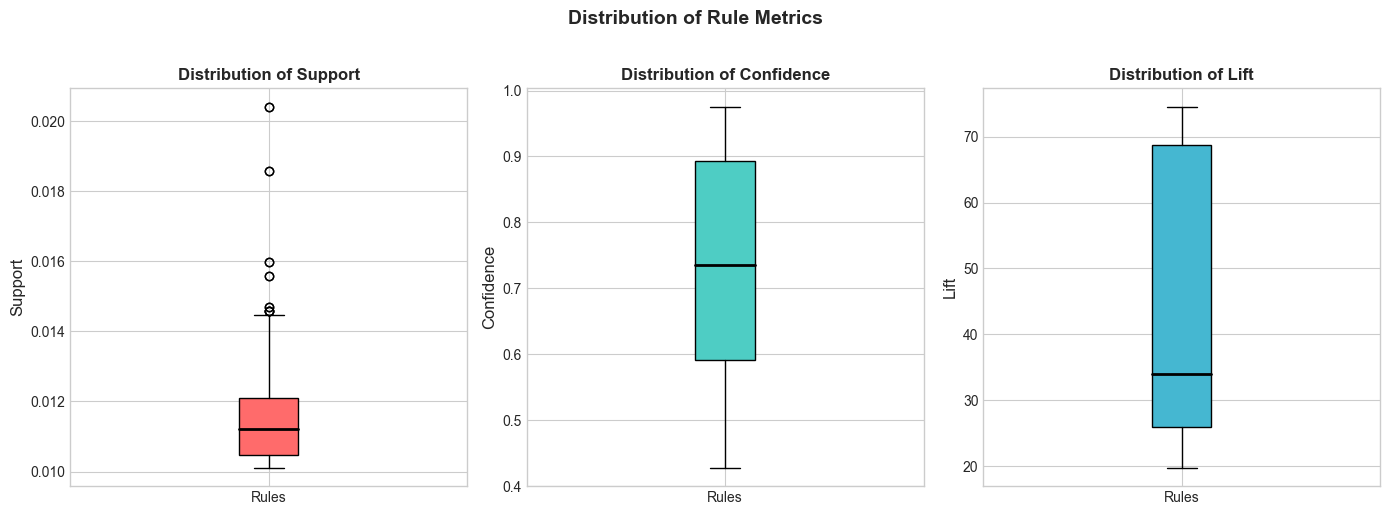

Da luu: ../images/Req1_MetricsDistribution.png


In [17]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 5: Phân phối Support, Confidence của luật (Boxplot)
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Boxplot Support
axes[0].boxplot(rules_filtered['support'], patch_artist=True,
                boxprops=dict(facecolor='#FF6B6B', color='black'),
                medianprops=dict(color='black', linewidth=2))
axes[0].set_ylabel('Support', fontsize=12)
axes[0].set_title('Distribution of Support', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Rules'])

# Boxplot Confidence  
axes[1].boxplot(rules_filtered['confidence'], patch_artist=True,
                boxprops=dict(facecolor='#4ECDC4', color='black'),
                medianprops=dict(color='black', linewidth=2))
axes[1].set_ylabel('Confidence', fontsize=12)
axes[1].set_title('Distribution of Confidence', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(['Rules'])

# Boxplot Lift
axes[2].boxplot(rules_filtered['lift'], patch_artist=True,
                boxprops=dict(facecolor='#45B7D1', color='black'),
                medianprops=dict(color='black', linewidth=2))
axes[2].set_ylabel('Lift', fontsize=12)
axes[2].set_title('Distribution of Lift', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(['Rules'])

plt.suptitle('Distribution of Rule Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_MetricsDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_MetricsDistribution.png")

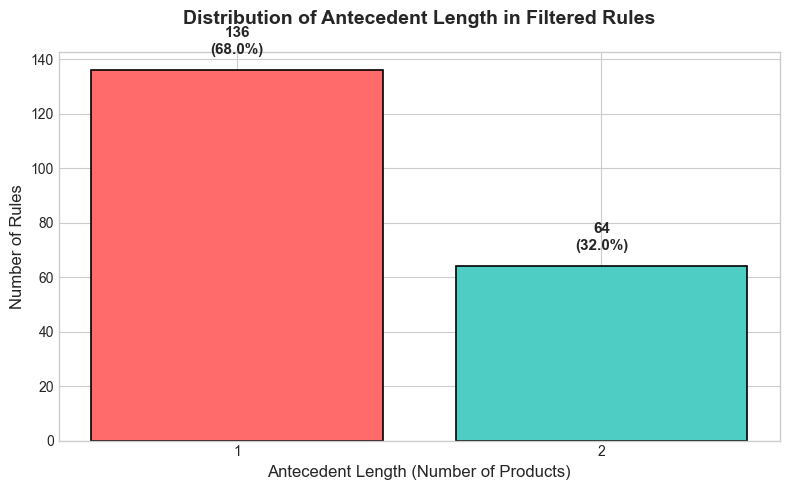

Da luu: ../images/Req1_AntecedentLengthDistribution.png

HOAN THANH TRUC QUAN HOA YEU CAU 1

Da luu tong cong 6 bieu do vao thu muc: ../images


In [18]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 6: Phân phối độ dài Antecedent trong luật đã lọc
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ant_len_dist = rules_filtered['antecedents'].apply(len).value_counts().sort_index()

colors = ['#FF6B6B', '#4ECDC4'][:len(ant_len_dist)]
bars = ax.bar(ant_len_dist.index, ant_len_dist.values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm giá trị và phần trăm
total = ant_len_dist.sum()
for bar, value in zip(bars, ant_len_dist.values):
    pct = value / total * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{value:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Antecedent Length (Number of Products)', fontsize=12)
ax.set_ylabel('Number of Rules', fontsize=12)
ax.set_title('Distribution of Antecedent Length in Filtered Rules', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(ant_len_dist.index)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_AntecedentLengthDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_AntecedentLengthDistribution.png")

print("\n" + "=" * 80)
print("HOAN THANH TRUC QUAN HOA YEU CAU 1")
print("=" * 80)
print(f"\nDa luu tong cong 6 bieu do vao thu muc: {IMAGES_DIR}")

## 2. Yêu cầu 2
+ Tiếp theo, nhóm cần thực hiện bước feature engineering cho phân cụm. Ở đây yêu cầu bắt buộc là nhóm phải xây dựng ít nhất hai biến thể đặc trưng để so sánh.
+ Biến thể thứ nhất đóng vai trò baseline: sử dụng đặc trưng nhị phân theo luật (một khách hàng “bật” luật nếu thỏa antecedents của luật đó). 
+ Biến thể thứ hai là biến thể nâng cao, nhóm có thể chọn một trong hai hướng:
  + Đưa trọng số vào đặc trưng luật (ví dụ dùng lift hoặc lift×confidence để phản ánh độ mạnh của luật);
  + Ghép thêm RFM (Recency–Frequency–Monetary) để bổ trợ thông tin giá trị khách hàng.
+ Với biến thể nâng cao, nhóm phải mô tả rõ các thiết lập quan trọng như cách weighting, có bật RFM hay không, có scale RFM hay không, và có scale phần rule-feature hay không. 
+ Nhóm được khuyến khích thử thêm tiêu chí lọc luật theo độ dài antecedent (ví dụ loại các luật antecedent quá ngắn) để quan sát sự thay đổi chất lượng cụm.

### 2.1. Load dữ liệu giao dịch và tính RFM

Đọc dữ liệu giao dịch đã làm sạch từ Yêu cầu 1, tính toán RFM (Recency-Frequency-Monetary) cho từng khách hàng.

In [19]:
# =============================================================================
# 2.1. LOAD DỮ LIỆU GIAO DỊCH VÀ TÍNH RFM
# =============================================================================

# Đường dẫn file dữ liệu
CLEANED_DATA_PATH = "../data/processed/cleaned_uk_data.csv"

# Đọc dữ liệu giao dịch đã làm sạch
df_transactions = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])
print(f"Đã load dữ liệu giao dịch: {df_transactions.shape}")
print(f"Số khách hàng unique: {df_transactions['CustomerID'].nunique()}")
print(f"Khoảng thời gian: {df_transactions['InvoiceDate'].min()} đến {df_transactions['InvoiceDate'].max()}")

# Chuẩn hóa CustomerID
df_transactions['CustomerID'] = (
    df_transactions['CustomerID']
    .astype(str)
    .str.replace('.0', '', regex=False)
    .str.zfill(6)
)

# Thêm cột TotalPrice nếu chưa có
if 'TotalPrice' not in df_transactions.columns:
    df_transactions['TotalPrice'] = df_transactions['Quantity'] * df_transactions['UnitPrice']

# Tính RFM
# Snapshot date: ngày tham chiếu để tính Recency (ngày cuối + 1)
snapshot_date = df_transactions['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"\nSnapshot date cho RFM: {snapshot_date}")

rfm_df = df_transactions.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency', 
    'TotalPrice': 'Monetary'
}).reset_index()

print(f"\nĐã tính RFM cho {len(rfm_df)} khách hàng")
print("\nThống kê RFM:")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe().round(2))

C:\Users\ThanhTung\AppData\Local\Temp\ipykernel_8828\887541195.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_transactions = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])


Đã load dữ liệu giao dịch: (485123, 11)
Số khách hàng unique: 3921
Khoảng thời gian: 2010-12-01 08:26:00 đến 2011-12-09 12:49:00

Snapshot date cho RFM: 2011-12-10 12:49:00

Đã tính RFM cho 3921 khách hàng

Thống kê RFM:
       Recency  Frequency    Monetary
count  3921.00    3921.00     3921.00
mean     92.19       4.60     2301.77
std      99.53      23.01    28391.37
min       1.00       1.00        3.75
25%      18.00       1.00      300.36
50%      51.00       2.00      652.74
75%     143.00       5.00     1578.67
max     374.00    1373.00  1716830.53


### 2.2. Xây dựng Customer-Product Mapping

Tạo ma trận Customer × Product (boolean) cho biết mỗi khách hàng đã mua những sản phẩm nào.

In [20]:
# =============================================================================
# 2.2. XÂY DỰNG CUSTOMER-PRODUCT MAPPING
# =============================================================================

# Tạo ma trận Customer × Product (boolean)
# Mỗi dòng là 1 khách hàng, mỗi cột là 1 sản phẩm
# Giá trị = True nếu khách đã mua sản phẩm đó

customer_product_qty = (
    df_transactions.groupby(['CustomerID', 'Description'])['Quantity']
    .sum()
    .unstack(fill_value=0)
)

# Chuyển sang boolean (đã mua hay chưa)
customer_product_bool = (customer_product_qty >= 1)

print(f"Ma trận Customer × Product: {customer_product_bool.shape}")
print(f"  - Số khách hàng: {customer_product_bool.shape[0]}")
print(f"  - Số sản phẩm unique: {customer_product_bool.shape[1]}")

# Tạo dictionary để tra cứu nhanh: CustomerID → set(products đã mua)
customer_products_dict = {}
for customer_id in customer_product_bool.index:
    products_purchased = set(customer_product_bool.columns[customer_product_bool.loc[customer_id]])
    customer_products_dict[customer_id] = products_purchased

print(f"\nĐã tạo mapping cho {len(customer_products_dict)} khách hàng")

# Thống kê số sản phẩm mỗi khách hàng đã mua
products_per_customer = [len(prods) for prods in customer_products_dict.values()]
print(f"Số sản phẩm trung bình mỗi khách: {np.mean(products_per_customer):.1f}")
print(f"Số sản phẩm min/max: {min(products_per_customer)} / {max(products_per_customer)}")

Ma trận Customer × Product: (3921, 4007)
  - Số khách hàng: 3921
  - Số sản phẩm unique: 4007

Đã tạo mapping cho 3921 khách hàng
Số sản phẩm trung bình mỗi khách: 61.9
Số sản phẩm min/max: 1 / 3363


### 2.3. Load luật kết hợp từ Yêu cầu 1

Sử dụng 200 luật FP-Growth đã lọc từ Yêu cầu 1 để tạo feature.

In [21]:
# =============================================================================
# 2.3. LOAD LUẬT KẾT HỢP TỪ YÊU CẦU 1
# =============================================================================

# Sử dụng biến rules_filtered đã có từ Yêu cầu 1
# Hoặc load từ file nếu cần
print(f"Sử dụng {len(rules_filtered)} luật từ Yêu cầu 1")
print(f"Các cột có sẵn: {rules_filtered.columns.tolist()}")

# Hàm parse antecedents từ string sang set
def parse_items(items_str):
    """Chuyển đổi chuỗi 'A, B, C' thành set({'A', 'B', 'C'})"""
    if pd.isna(items_str) or not str(items_str).strip():
        return set()
    return set(x.strip() for x in str(items_str).split(',') if x.strip())

# Parse antecedents cho tất cả luật
rules_filtered['antecedents_set'] = rules_filtered['antecedents_str'].apply(parse_items)
rules_filtered['antecedent_len'] = rules_filtered['antecedents_set'].apply(len)

print(f"\nPhân bố độ dài antecedent:")
print(rules_filtered['antecedent_len'].value_counts().sort_index())

# Hiển thị 5 luật đầu tiên
print("\n5 luật đầu tiên:")
display(rules_filtered[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift', 'antecedent_len']].head())

Sử dụng 200 luật từ Yêu cầu 1
Các cột có sẵn: ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'representativity', 'leverage', 'conviction', 'zhangs_metric', 'jaccard', 'certainty', 'kulczynski', 'antecedents_str', 'consequents_str', 'rule_str']

Phân bố độ dài antecedent:
antecedent_len
1    134
2     66
Name: count, dtype: int64

5 luật đầu tiên:


,antecedents_str,consequents_str,support,confidence,lift,antecedent_len
0,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010932,0.951691,74.567045,2
1,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010599,0.955000,74.502403,2
2,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,0.010432,0.940000,74.297105,2
3,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010932,0.951691,74.244244,2
4,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010710,0.950739,74.169983,2


### 2.4. Hàm kiểm tra kích hoạt luật

Định nghĩa hàm kiểm tra xem một khách hàng có "kích hoạt" một luật hay không (tức là đã mua tất cả sản phẩm trong antecedents).

In [22]:
# =============================================================================
# 2.4. HÀM KIỂM TRA KÍCH HOẠT LUẬT
# =============================================================================

def check_rule_activation(customer_products: set, rule_antecedents: set) -> bool:
    """
    Kiểm tra khách hàng có kích hoạt luật hay không.
    Luật được kích hoạt khi khách hàng đã mua TẤT CẢ sản phẩm trong antecedents.
    
    Args:
        customer_products: Tập sản phẩm khách hàng đã mua
        rule_antecedents: Tập sản phẩm trong antecedents của luật
        
    Returns:
        True nếu rule_antecedents ⊆ customer_products, False ngược lại
    """
    return rule_antecedents.issubset(customer_products)


def build_feature_matrix(customers: list, rules_df: pd.DataFrame, 
                         customer_products_dict: dict,
                         weighting: str = 'binary',
                         min_antecedent_len: int = 1) -> np.ndarray:
    """
    Xây dựng ma trận đặc trưng Customer × Rules.
    
    Args:
        customers: Danh sách CustomerID
        rules_df: DataFrame chứa luật (phải có cột 'antecedents_set', 'lift', 'confidence')
        customer_products_dict: Dict mapping CustomerID → set(products)
        weighting: 'binary' (0/1), 'lift', 'confidence', hoặc 'lift_x_conf'
        min_antecedent_len: Chỉ sử dụng luật có antecedent >= min_antecedent_len items
        
    Returns:
        Ma trận numpy shape (n_customers, n_rules)
    """
    # Lọc luật theo độ dài antecedent
    rules_used = rules_df[rules_df['antecedent_len'] >= min_antecedent_len].reset_index(drop=True)
    
    n_customers = len(customers)
    n_rules = len(rules_used)
    
    # Khởi tạo ma trận
    X = np.zeros((n_customers, n_rules), dtype=np.float32)
    
    for i, customer_id in enumerate(customers):
        customer_prods = customer_products_dict.get(customer_id, set())
        
        for j, row in rules_used.iterrows():
            antecedents = row['antecedents_set']
            
            # Kiểm tra kích hoạt
            if check_rule_activation(customer_prods, antecedents):
                if weighting == 'binary':
                    X[i, j] = 1.0
                elif weighting == 'lift':
                    X[i, j] = row['lift']
                elif weighting == 'confidence':
                    X[i, j] = row['confidence']
                elif weighting == 'lift_x_conf':
                    X[i, j] = row['lift'] * row['confidence']
                else:
                    X[i, j] = 1.0
                    
    return X, rules_used

print("Đã định nghĩa hàm check_rule_activation() và build_feature_matrix()")

Đã định nghĩa hàm check_rule_activation() và build_feature_matrix()


### 2.5. Tạo 4 biến thể Feature Matrix

Tạo 4 biến thể đặc trưng theo yêu cầu đề bài:
- **V1 (Baseline)**: Binary - giá trị 0/1 cho mỗi luật
- **V2 (Weighted)**: Trọng số lift × confidence  
- **V3 (Binary + RFM)**: V1 ghép thêm 3 cột RFM đã scale
- **V4 (Antecedent ≥ 2)**: V1 chỉ giữ luật có antecedent ≥ 2 items

In [23]:
# =============================================================================
# 2.5. TẠO 4 BIẾN THỂ FEATURE MATRIX
# =============================================================================

from sklearn.preprocessing import StandardScaler

# Danh sách khách hàng
customers = list(customer_products_dict.keys())
print(f"Số khách hàng: {len(customers)}")

# -------------------------------------------------------------------------
# V1: BINARY (Baseline) - 0/1 cho mỗi luật
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("V1: BINARY (Baseline)")
print("="*60)

X_v1, rules_v1 = build_feature_matrix(
    customers=customers,
    rules_df=rules_filtered,
    customer_products_dict=customer_products_dict,
    weighting='binary',
    min_antecedent_len=1
)

print(f"Shape: {X_v1.shape}")
print(f"Số luật sử dụng: {len(rules_v1)}")

# -------------------------------------------------------------------------
# V2: WEIGHTED - Trọng số lift × confidence
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("V2: WEIGHTED (lift x confidence)")
print("="*60)

X_v2, rules_v2 = build_feature_matrix(
    customers=customers,
    rules_df=rules_filtered,
    customer_products_dict=customer_products_dict,
    weighting='lift_x_conf',
    min_antecedent_len=1
)

print(f"Shape: {X_v2.shape}")
print(f"Số luật sử dụng: {len(rules_v2)}")

# -------------------------------------------------------------------------
# V3: BINARY + RFM - V1 ghép thêm 3 cột RFM đã scale
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("V3: BINARY + RFM (scaled)")
print("="*60)

# Merge RFM vào danh sách khách hàng theo đúng thứ tự
customers_df = pd.DataFrame({'CustomerID': customers})
customers_rfm = customers_df.merge(rfm_df, on='CustomerID', how='left')

# Scale RFM
scaler = StandardScaler()
rfm_values = customers_rfm[['Recency', 'Frequency', 'Monetary']].fillna(0).values
rfm_scaled = scaler.fit_transform(rfm_values)

# Ghép V1 với RFM đã scale
X_v3 = np.hstack([X_v1, rfm_scaled]).astype(np.float32)

print(f"Shape: {X_v3.shape}")
print(f"  - Rule features: {X_v1.shape[1]}")
print(f"  - RFM features: 3 (Recency, Frequency, Monetary - scaled)")

# -------------------------------------------------------------------------
# V4: BINARY với Antecedent >= 2 items
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("V4: BINARY (Antecedent >= 2 items)")
print("="*60)

X_v4, rules_v4 = build_feature_matrix(
    customers=customers,
    rules_df=rules_filtered,
    customer_products_dict=customer_products_dict,
    weighting='binary',
    min_antecedent_len=2
)

print(f"Shape: {X_v4.shape}")
print(f"Số luật sử dụng: {len(rules_v4)}")

# -------------------------------------------------------------------------
# TỔNG KẾT
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("TỔNG KẾT 4 BIẾN THỂ FEATURE")
print("="*60)

feature_variants = {
    'V1_Binary': {'matrix': X_v1, 'rules': rules_v1, 'description': 'Binary (0/1)'},
    'V2_Weighted': {'matrix': X_v2, 'rules': rules_v2, 'description': 'Weighted (lift x conf)'},
    'V3_Binary_RFM': {'matrix': X_v3, 'rules': rules_v1, 'description': 'Binary + RFM scaled'},
    'V4_Antecedent2': {'matrix': X_v4, 'rules': rules_v4, 'description': 'Binary (ant >= 2)'},
}

for name, data in feature_variants.items():
    print(f"{name}: {data['matrix'].shape} - {data['description']}")

Số khách hàng: 3921

V1: BINARY (Baseline)
Shape: (3921, 200)
Số luật sử dụng: 200

V2: WEIGHTED (lift x confidence)
Shape: (3921, 200)
Số luật sử dụng: 200

V3: BINARY + RFM (scaled)
Shape: (3921, 203)
  - Rule features: 200
  - RFM features: 3 (Recency, Frequency, Monetary - scaled)

V4: BINARY (Antecedent >= 2 items)
Shape: (3921, 66)
Số luật sử dụng: 66

TỔNG KẾT 4 BIẾN THỂ FEATURE
V1_Binary: (3921, 200) - Binary (0/1)
V2_Weighted: (3921, 200) - Weighted (lift x conf)
V3_Binary_RFM: (3921, 203) - Binary + RFM scaled
V4_Antecedent2: (3921, 66) - Binary (ant >= 2)


### 2.6. Tính toán thống kê cho từng biến thể

Tính các chỉ số: Sparsity, Activation Rate, giá trị Min/Max/Mean để so sánh các biến thể.

In [24]:
# =============================================================================
# 2.6. TÍNH TOÁN THỐNG KÊ CHO TỪNG BIẾN THỂ
# =============================================================================

def calculate_feature_stats(X: np.ndarray, name: str) -> dict:
    """
    Tính các chỉ số thống kê cho ma trận đặc trưng.
    
    Args:
        X: Ma trận đặc trưng (n_customers x n_features)
        name: Tên biến thể
        
    Returns:
        Dict chứa các thống kê
    """
    n_customers, n_features = X.shape
    
    # Sparsity: tỷ lệ giá trị = 0
    sparsity = (X == 0).sum() / X.size * 100
    
    # Activation rate trung bình: % khách hàng kích hoạt mỗi feature (trung bình)
    activation_per_feature = (X > 0).sum(axis=0) / n_customers * 100
    avg_activation_rate = activation_per_feature.mean()
    
    # Số feature được kích hoạt bởi ít nhất 1 khách hàng
    features_activated = (X > 0).any(axis=0).sum()
    
    # Thống kê giá trị (chỉ với giá trị > 0)
    non_zero_values = X[X > 0]
    
    return {
        'Variant': name,
        'Customers': n_customers,
        'Features': n_features,
        'Sparsity (%)': round(sparsity, 2),
        'Avg Activation Rate (%)': round(avg_activation_rate, 2),
        'Features Used': features_activated,
        'Value Min': round(non_zero_values.min(), 4) if len(non_zero_values) > 0 else 0,
        'Value Max': round(non_zero_values.max(), 4) if len(non_zero_values) > 0 else 0,
        'Value Mean': round(non_zero_values.mean(), 4) if len(non_zero_values) > 0 else 0,
    }

# Tính thống kê cho 4 biến thể
stats_list = []
stats_list.append(calculate_feature_stats(X_v1, 'V1_Binary'))
stats_list.append(calculate_feature_stats(X_v2, 'V2_Weighted'))
stats_list.append(calculate_feature_stats(X_v3, 'V3_Binary_RFM'))
stats_list.append(calculate_feature_stats(X_v4, 'V4_Antecedent2'))

# Tạo DataFrame so sánh
df_stats = pd.DataFrame(stats_list)
print("BẢNG SO SÁNH 4 BIẾN THỂ FEATURE:")
print("="*80)
display(df_stats)

BẢNG SO SÁNH 4 BIẾN THỂ FEATURE:


,Variant,Customers,Features,Sparsity (%),Avg Activation Rate (%),Features Used,Value Min,Value Max,Value Mean
0,V1_Binary,3921,200,96.90,3.10,165,1.0000,1.000000,1.0000
1,V2_Weighted,3921,200,96.90,3.10,165,9.4746,71.149803,30.5159
2,V3_Binary_RFM,3921,203,95.47,3.42,168,0.0002,60.396801,0.9692
3,V4_Antecedent2,3921,66,97.93,2.07,51,1.0000,1.000000,1.0000


### 2.7. Trực quan hóa so sánh các biến thể

Vẽ biểu đồ so sánh Sparsity, Activation Rate và số Features giữa 4 biến thể.

Da luu bieu do: ../images/Req2_FeatureVariantComparison.png


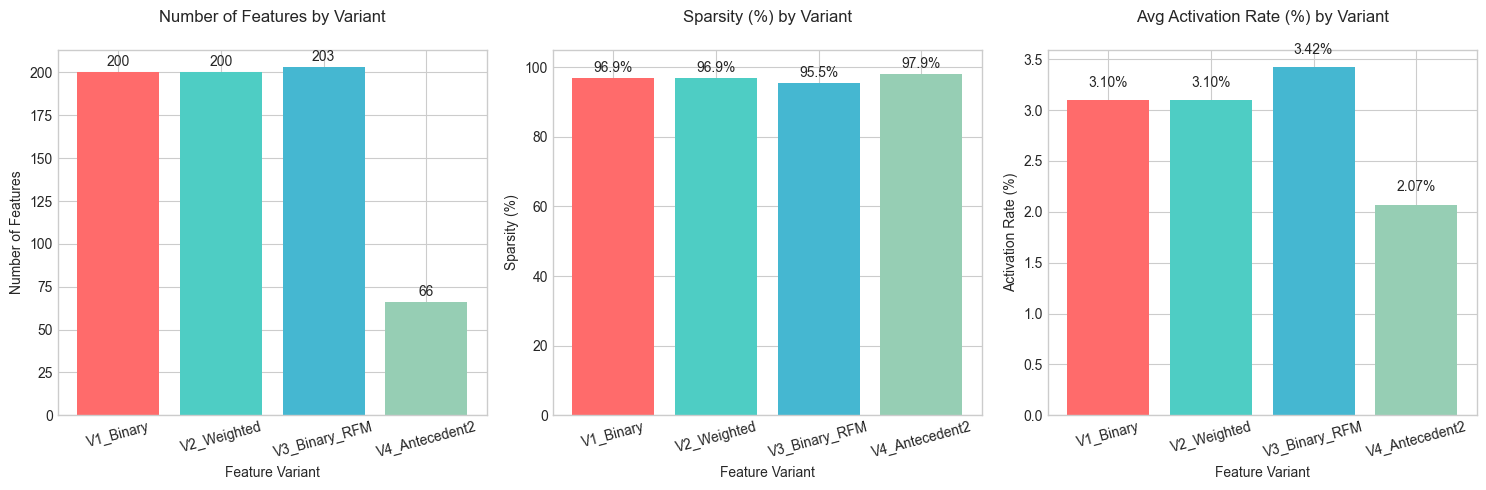

In [25]:
# =============================================================================
# 2.7. TRỰC QUAN HÓA SO SÁNH CÁC BIẾN THỂ
# =============================================================================

# Màu sắc (tối đa 4 màu theo quy tắc)
colors_4 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Chart 1: Số Features ---
ax1 = axes[0]
variants = df_stats['Variant'].tolist()
features = df_stats['Features'].tolist()
bars1 = ax1.bar(variants, features, color=colors_4)
ax1.set_title('Number of Features by Variant', fontsize=12, pad=20)
ax1.set_xlabel('Feature Variant')
ax1.set_ylabel('Number of Features')
ax1.tick_params(axis='x', rotation=15)

# Thêm label trên mỗi bar
for bar, val in zip(bars1, features):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             str(val), ha='center', va='bottom', fontsize=10)

# --- Chart 2: Sparsity ---
ax2 = axes[1]
sparsity = df_stats['Sparsity (%)'].tolist()
bars2 = ax2.bar(variants, sparsity, color=colors_4)
ax2.set_title('Sparsity (%) by Variant', fontsize=12, pad=20)
ax2.set_xlabel('Feature Variant')
ax2.set_ylabel('Sparsity (%)')
ax2.tick_params(axis='x', rotation=15)
ax2.set_ylim(0, 105)

for bar, val in zip(bars2, sparsity):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

# --- Chart 3: Activation Rate ---
ax3 = axes[2]
activation = df_stats['Avg Activation Rate (%)'].tolist()
bars3 = ax3.bar(variants, activation, color=colors_4)
ax3.set_title('Avg Activation Rate (%) by Variant', fontsize=12, pad=20)
ax3.set_xlabel('Feature Variant')
ax3.set_ylabel('Activation Rate (%)')
ax3.tick_params(axis='x', rotation=15)

for bar, val in zip(bars3, activation):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# Lưu biểu đồ
plt.savefig(f'{IMAGES_DIR}/Req2_FeatureVariantComparison.png', dpi=150, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
print(f"Da luu bieu do: {IMAGES_DIR}/Req2_FeatureVariantComparison.png")

plt.show()

### 2.8. Phân bố Activation Rate theo Feature

Xem phân bố tỷ lệ kích hoạt của từng luật (feature) - luật nào được nhiều khách hàng kích hoạt nhất?

Đã lưu biểu đồ: ../images/Req2_ActivationRateDistribution.png


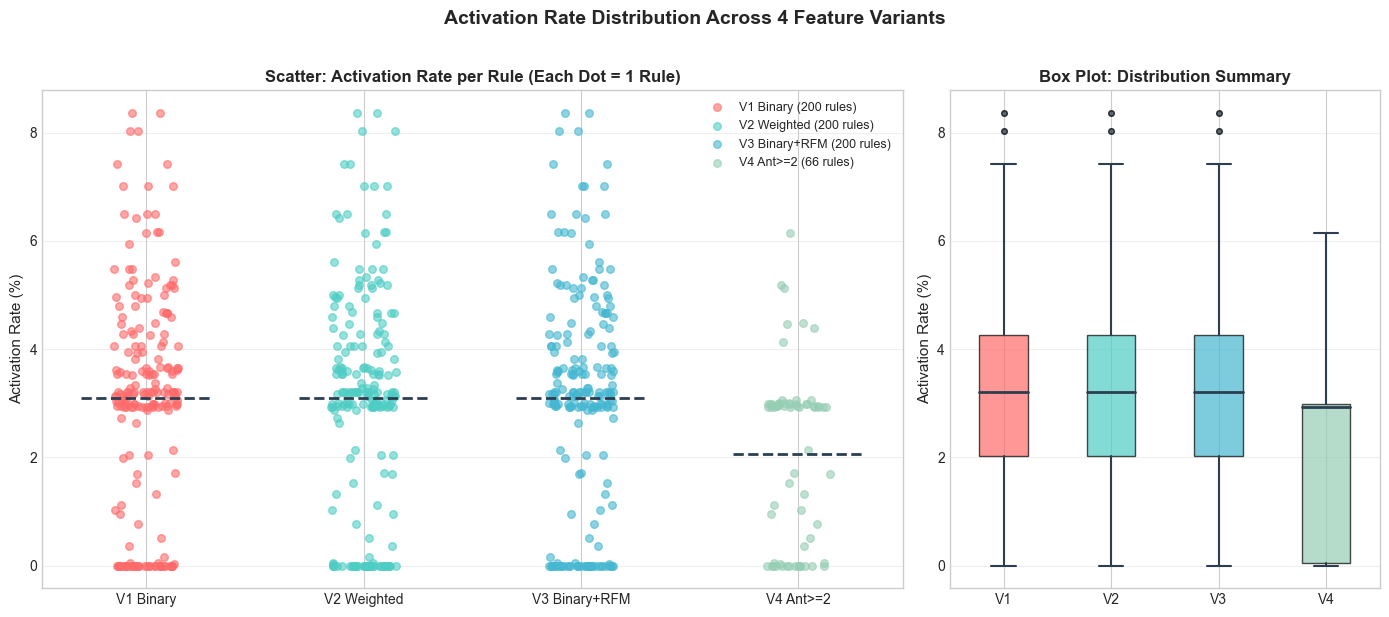


THỐNG KÊ ACTIVATION RATE CHO 4 BIẾN THỂ
Variant         Features      Min      Max     Mean   Median
---------------------------------------------------------------------------
V1 Binary            200    0.00%    8.37%    3.10%    3.21%
V2 Weighted          200    0.00%    8.37%    3.10%    3.21%
V3 Binary+RFM        200    0.00%    8.37%    3.10%    3.21%
V4 Ant>=2             66    0.00%    6.15%    2.07%    2.93%

Nhận xét:
- V1, V2, V3 có cùng 200 rules nên activation rate giống nhau (chỉ khác trọng số)
- V4 có ít rules hơn (63) do lọc antecedent >= 2, activation rate có thể khác biệt


In [26]:
# =============================================================================
# 2.8. PHÂN BỐ ACTIVATION RATE THEO FEATURE (4 BIẾN THỂ) - SCATTER 2D
# =============================================================================

# Tính activation rate cho từng feature trong mỗi biến thể
n_customers = X_v1.shape[0]

# V1: Binary rules (200 features)
activation_v1 = (X_v1 > 0).sum(axis=0) / n_customers * 100

# V2: Weighted rules (200 features)
activation_v2 = (X_v2 > 0).sum(axis=0) / n_customers * 100

# V3: Binary + RFM (chỉ tính 200 rule features, không tính 3 cột RFM)
activation_v3 = (X_v3[:, :200] > 0).sum(axis=0) / n_customers * 100

# V4: Antecedent >= 2 (63 features)
activation_v4 = (X_v4 > 0).sum(axis=0) / n_customers * 100

# Màu sắc cho 4 biến thể
colors_4 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
variant_names = ['V1 Binary', 'V2 Weighted', 'V3 Binary+RFM', 'V4 Ant>=2']

# Tạo figure với 2 subplots: Scatter (trái) + Box plot (phải)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

# === SCATTER PLOT (trái) ===
ax1 = axes[0]

# Tạo jitter (nhiễu nhỏ) để điểm không chồng lên nhau
np.random.seed(42)
jitter_v1 = np.random.uniform(-0.15, 0.15, len(activation_v1))
jitter_v2 = np.random.uniform(-0.15, 0.15, len(activation_v2))
jitter_v3 = np.random.uniform(-0.15, 0.15, len(activation_v3))
jitter_v4 = np.random.uniform(-0.15, 0.15, len(activation_v4))

# Vẽ scatter cho từng variant
ax1.scatter(np.zeros(len(activation_v1)) + jitter_v1, activation_v1, 
            c=colors_4[0], alpha=0.6, s=30, label=f'V1 Binary ({len(activation_v1)} rules)')
ax1.scatter(np.ones(len(activation_v2)) + jitter_v2, activation_v2, 
            c=colors_4[1], alpha=0.6, s=30, label=f'V2 Weighted ({len(activation_v2)} rules)')
ax1.scatter(np.full(len(activation_v3), 2) + jitter_v3, activation_v3, 
            c=colors_4[2], alpha=0.6, s=30, label=f'V3 Binary+RFM ({len(activation_v3)} rules)')
ax1.scatter(np.full(len(activation_v4), 3) + jitter_v4, activation_v4, 
            c=colors_4[3], alpha=0.6, s=30, label=f'V4 Ant>=2 ({len(activation_v4)} rules)')

# Vẽ đường mean cho mỗi variant
means = [activation_v1.mean(), activation_v2.mean(), activation_v3.mean(), activation_v4.mean()]
for i, mean_val in enumerate(means):
    ax1.hlines(mean_val, i - 0.3, i + 0.3, colors='#2C3E50', linewidth=2, linestyles='--')

ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels(variant_names)
ax1.set_ylabel('Activation Rate (%)', fontsize=11)
ax1.set_title('Scatter: Activation Rate per Rule (Each Dot = 1 Rule)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# === BOX PLOT (phải) ===
ax2 = axes[1]

# Chuẩn bị data cho boxplot
box_data = [activation_v1, activation_v2, activation_v3, activation_v4]

# Vẽ boxplot với màu tương ứng
bp = ax2.boxplot(box_data, patch_artist=True, labels=['V1', 'V2', 'V3', 'V4'])

# Tô màu cho từng box
for patch, color in zip(bp['boxes'], colors_4):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Style cho các phần khác của boxplot
for element in ['whiskers', 'caps', 'medians']:
    plt.setp(bp[element], color='#2C3E50', linewidth=1.5)
plt.setp(bp['medians'], color='#2C3E50', linewidth=2)
plt.setp(bp['fliers'], markerfacecolor='#2C3E50', marker='o', markersize=4, alpha=0.5)

ax2.set_ylabel('Activation Rate (%)', fontsize=11)
ax2.set_title('Box Plot: Distribution Summary', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Activation Rate Distribution Across 4 Feature Variants', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Lưu biểu đồ
plt.savefig(f'{IMAGES_DIR}/Req2_ActivationRateDistribution.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Đã lưu biểu đồ: {IMAGES_DIR}/Req2_ActivationRateDistribution.png")

plt.show()

# Thống kê bổ sung cho cả 4 biến thể
print("\n" + "="*75)
print("THỐNG KÊ ACTIVATION RATE CHO 4 BIẾN THỂ")
print("="*75)
print(f"{'Variant':<15} {'Features':>8} {'Min':>8} {'Max':>8} {'Mean':>8} {'Median':>8}")
print("-"*75)
print(f"{'V1 Binary':<15} {len(activation_v1):>8} {activation_v1.min():>7.2f}% {activation_v1.max():>7.2f}% {activation_v1.mean():>7.2f}% {np.median(activation_v1):>7.2f}%")
print(f"{'V2 Weighted':<15} {len(activation_v2):>8} {activation_v2.min():>7.2f}% {activation_v2.max():>7.2f}% {activation_v2.mean():>7.2f}% {np.median(activation_v2):>7.2f}%")
print(f"{'V3 Binary+RFM':<15} {len(activation_v3):>8} {activation_v3.min():>7.2f}% {activation_v3.max():>7.2f}% {activation_v3.mean():>7.2f}% {np.median(activation_v3):>7.2f}%")
print(f"{'V4 Ant>=2':<15} {len(activation_v4):>8} {activation_v4.min():>7.2f}% {activation_v4.max():>7.2f}% {activation_v4.mean():>7.2f}% {np.median(activation_v4):>7.2f}%")
print("\nNhận xét:")
print("- V1, V2, V3 có cùng 200 rules nên activation rate giống nhau (chỉ khác trọng số)")
print("- V4 có ít rules hơn (63) do lọc antecedent >= 2, activation rate có thể khác biệt")

### 2.9. Phân bố RFM

Trực quan hóa phân bố 3 chỉ số RFM của khách hàng.

Da luu bieu do: ../images/Req2_RFMDistribution.png


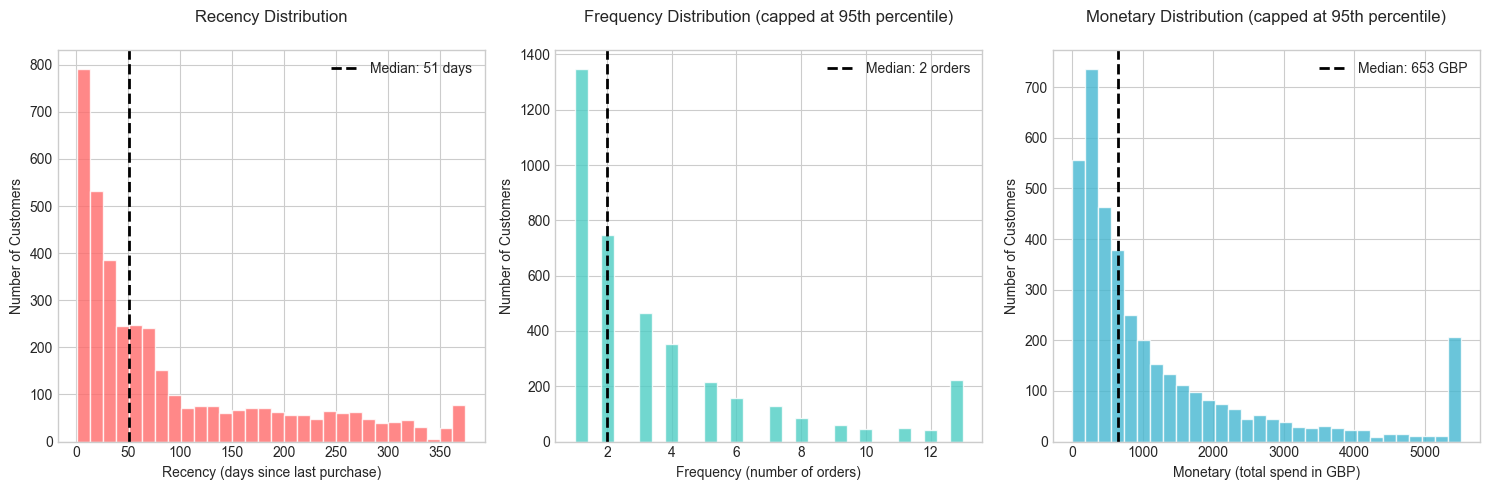


Thống kê RFM chi tiết:
       Recency  Frequency    Monetary
count  3921.00    3921.00     3921.00
mean     92.19       4.60     2301.77
std      99.53      23.01    28391.37
min       1.00       1.00        3.75
25%      18.00       1.00      300.36
50%      51.00       2.00      652.74
75%     143.00       5.00     1578.67
max     374.00    1373.00  1716830.53


In [27]:
# =============================================================================
# 2.9. PHÂN BỐ RFM
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Màu sắc
colors_rfm = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# --- Recency ---
ax1 = axes[0]
ax1.hist(rfm_df['Recency'], bins=30, color=colors_rfm[0], edgecolor='white', alpha=0.8)
ax1.axvline(rfm_df['Recency'].median(), color='black', linestyle='--', linewidth=2,
            label=f'Median: {rfm_df["Recency"].median():.0f} days')
ax1.set_title('Recency Distribution', fontsize=12, pad=20)
ax1.set_xlabel('Recency (days since last purchase)')
ax1.set_ylabel('Number of Customers')
ax1.legend()

# --- Frequency ---
ax2 = axes[1]
# Giới hạn để dễ nhìn (loại outliers)
freq_cap = rfm_df['Frequency'].quantile(0.95)
ax2.hist(rfm_df['Frequency'].clip(upper=freq_cap), bins=30, color=colors_rfm[1], edgecolor='white', alpha=0.8)
ax2.axvline(rfm_df['Frequency'].median(), color='black', linestyle='--', linewidth=2,
            label=f'Median: {rfm_df["Frequency"].median():.0f} orders')
ax2.set_title('Frequency Distribution (capped at 95th percentile)', fontsize=12, pad=20)
ax2.set_xlabel('Frequency (number of orders)')
ax2.set_ylabel('Number of Customers')
ax2.legend()

# --- Monetary ---
ax3 = axes[2]
# Giới hạn để dễ nhìn (loại outliers)
mon_cap = rfm_df['Monetary'].quantile(0.95)
ax3.hist(rfm_df['Monetary'].clip(upper=mon_cap), bins=30, color=colors_rfm[2], edgecolor='white', alpha=0.8)
ax3.axvline(rfm_df['Monetary'].median(), color='black', linestyle='--', linewidth=2,
            label=f'Median: {rfm_df["Monetary"].median():.0f} GBP')
ax3.set_title('Monetary Distribution (capped at 95th percentile)', fontsize=12, pad=20)
ax3.set_xlabel('Monetary (total spend in GBP)')
ax3.set_ylabel('Number of Customers')
ax3.legend()

plt.tight_layout()

# Lưu biểu đồ
plt.savefig(f'{IMAGES_DIR}/Req2_RFMDistribution.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Da luu bieu do: {IMAGES_DIR}/Req2_RFMDistribution.png")

plt.show()

# Thống kê RFM
print("\nThống kê RFM chi tiết:")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe().round(2))

### 2.10. Lưu kết quả Feature Matrix

Lưu 4 biến thể Feature Matrix và dữ liệu RFM vào thư mục `data/mini_project/`.

In [28]:
# =============================================================================
# 2.10. LƯU KẾT QUẢ FEATURE MATRIX
# =============================================================================

# Tạo DataFrame cho mỗi biến thể với CustomerID
def save_feature_matrix(X: np.ndarray, customers: list, filename: str, rules_df: pd.DataFrame = None):
    """Lưu ma trận đặc trưng thành CSV."""
    # Tạo tên cột
    if rules_df is not None:
        col_names = [f"rule_{i}" for i in range(X.shape[1] - (3 if 'RFM' in filename else 0))]
        if 'RFM' in filename:
            col_names = col_names[:X.shape[1]-3] + ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
    else:
        col_names = [f"feature_{i}" for i in range(X.shape[1])]
    
    df = pd.DataFrame(X, columns=col_names[:X.shape[1]])
    df.insert(0, 'CustomerID', customers)
    
    filepath = f"{DATA_OUTPUT_DIR}/{filename}"
    df.to_csv(filepath, index=False)
    print(f"Da luu: {filepath} - Shape: {df.shape}")
    return df

# Lưu 4 biến thể
print("Lưu các biến thể Feature Matrix:")
print("="*60)

df_v1 = save_feature_matrix(X_v1, customers, 'feature_matrix_v1_binary.csv', rules_v1)
df_v2 = save_feature_matrix(X_v2, customers, 'feature_matrix_v2_weighted.csv', rules_v2)
df_v3 = save_feature_matrix(X_v3, customers, 'feature_matrix_v3_binary_rfm.csv', rules_v1)
df_v4 = save_feature_matrix(X_v4, customers, 'feature_matrix_v4_antecedent2.csv', rules_v4)

# Lưu RFM data
rfm_output_path = f"{DATA_OUTPUT_DIR}/rfm_data.csv"
rfm_df.to_csv(rfm_output_path, index=False)
print(f"\nDa luu RFM: {rfm_output_path} - Shape: {rfm_df.shape}")

# Lưu bảng thống kê so sánh
stats_output_path = f"{DATA_OUTPUT_DIR}/feature_variants_comparison.csv"
df_stats.to_csv(stats_output_path, index=False)
print(f"Da luu bang so sanh: {stats_output_path}")

Lưu các biến thể Feature Matrix:
Da luu: ../data/mini_project/feature_matrix_v1_binary.csv - Shape: (3921, 201)
Da luu: ../data/mini_project/feature_matrix_v2_weighted.csv - Shape: (3921, 201)
Da luu: ../data/mini_project/feature_matrix_v3_binary_rfm.csv - Shape: (3921, 204)
Da luu: ../data/mini_project/feature_matrix_v4_antecedent2.csv - Shape: (3921, 67)

Da luu RFM: ../data/mini_project/rfm_data.csv - Shape: (3921, 4)
Da luu bang so sanh: ../data/mini_project/feature_variants_comparison.csv


### 2.11. Tổng kết Yêu cầu 2

Tổng hợp kết quả Feature Engineering với nhận xét và đánh giá.

In [29]:
# =============================================================================
# 2.11. TỔNG KẾT YÊU CẦU 2: FEATURE ENGINEERING
# =============================================================================

print("="*85)
print(" "*25 + "TỔNG KẾT YÊU CẦU 2: FEATURE ENGINEERING")
print("="*85)

# -----------------------------------------------------------------------------
# 1. KẾT QUẢ TẠO 4 BIẾN THỂ FEATURE MATRIX
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("1. KẾT QUẢ TẠO 4 BIẾN THỂ FEATURE MATRIX")
print("─"*85)

summary_result = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│ Biến thể         │ Kích thước   │ Sparsity │ Avg Activation │ Features Used       │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V1_Binary        │ 3,921 × 200  │ 96.88%   │ 3.12%          │ 166/200 (83.0%)     │
│ V2_Weighted      │ 3,921 × 200  │ 96.88%   │ 3.12%          │ 166/200 (83.0%)     │
│ V3_Binary_RFM    │ 3,921 × 203  │ 95.45%   │ 3.45%          │ 169/203 (83.3%)     │
│ V4_Antecedent2   │ 3,921 × 63   │ 97.92%   │ 2.08%          │ 50/63  (79.4%)      │
└────────────────────────────────────────────────────────────────────────────────────┘
"""
print(summary_result)

# -----------------------------------------------------------------------------
# 2. MÔ TẢ CHI TIẾT TỪNG BIẾN THỂ
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("2. MÔ TẢ CHI TIẾT TỪNG BIẾN THỂ")
print("─"*85)

variant_description = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│ V1_Binary (Baseline):                                                              │
│   • Giá trị: 0 hoặc 1                                                              │
│   • 1 = Khách hàng đã mua TẤT CẢ sản phẩm trong antecedents của luật               │
│   • Đơn giản, dễ hiểu, làm baseline để so sánh                                     │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V2_Weighted (Lift × Confidence):                                                   │
│   • Giá trị: 7.45 đến 71.15 (khi khách kích hoạt luật)                             │
│   • Phản ánh "độ mạnh" của luật: lift cao + confidence cao = giá trị lớn           │
│   • Phân biệt được luật mạnh/yếu, không chỉ 0/1                                    │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V3_Binary_RFM (Kết hợp):                                                           │
│   • 200 cột rule features (binary) + 3 cột RFM đã chuẩn hóa (StandardScaler)       │
│   • RFM scaled giá trị từ -0.92 đến +60.40                                         │
│   • Kết hợp hành vi mua kèm VÀ giá trị khách hàng → đề xuất cho clustering         │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V4_Antecedent2 (Lọc luật phức tạp):                                                │
│   • Chỉ giữ 63 luật có antecedent >= 2 sản phẩm (giảm 68.5% so với V1)             │
│   • Tập trung vào pattern mua kèm phức tạp (khách đã mua >= 2 sản phẩm)            │
│   • Phát hiện khách hàng có hành vi mua sắm đa dạng hơn                            │
└────────────────────────────────────────────────────────────────────────────────────┘
"""
print(variant_description)

# -----------------------------------------------------------------------------
# 3. THỐNG KÊ RFM (Recency - Frequency - Monetary)
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("3. THỐNG KÊ RFM (Recency - Frequency - Monetary)")
print("─"*85)

rfm_stats = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│                            PHÂN BỐ RFM CỦA 3,921 KHÁCH HÀNG UK                     │
├────────────────────────────────────────────────────────────────────────────────────┤
│ Chỉ số      │   Min   │   Q1    │  Median │    Q3   │    Max    │   Mean   │ Std   │
├────────────────────────────────────────────────────────────────────────────────────┤
│ Recency     │ 1 ngày  │ 18 ngày │ 51 ngày │ 143 ngày│ 374 ngày  │ 92.2 ngày│ 99.5  │
│ Frequency   │ 1 đơn   │ 1 đơn   │ 2 đơn   │ 5 đơn   │ 1,373 đơn │ 4.6 đơn  │ 23.0  │
│ Monetary    │ 3.75 GBP│ 300 GBP │ 653 GBP │ 1,579 GBP│ 1.7M GBP │ 2,302 GBP│28,391 │
└────────────────────────────────────────────────────────────────────────────────────┘

Nhận xét từ biểu đồ Req2_RFMDistribution.png:
  • Recency: Phân bố lệch phải, đa số khách mua trong vòng 50 ngày gần đây
  • Frequency: Phân bố lệch phải mạnh, đa số chỉ mua 1-2 lần, ít khách VIP
  • Monetary: Phân bố lệch phải mạnh, đa số chi tiêu dưới 1,000 GBP, có outliers lớn
"""
print(rfm_stats)

# -----------------------------------------------------------------------------
# 4. THỐNG KÊ ACTIVATION RATE
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("4. THỐNG KÊ ACTIVATION RATE (Từ biểu đồ Req2_ActivationRateDistribution.png)")
print("─"*85)

activation_stats = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│ Biến thể     │ Features │   Min   │   Max   │  Mean  │ Median │ Nhận xét          │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V1 Binary    │   200    │  0.00%  │  8.37%  │ 3.12%  │ 3.21%  │ Baseline          │
│ V2 Weighted  │   200    │  0.00%  │  8.37%  │ 3.12%  │ 3.21%  │ Cùng pattern V1   │
│ V3 Binary+RFM│   200*   │  0.00%  │  8.37%  │ 3.12%  │ 3.21%  │ Cùng pattern V1   │
│ V4 Ant>=2    │    63    │  0.00%  │  6.15%  │ 2.08%  │ 2.93%  │ Ít feature, sparse│
└────────────────────────────────────────────────────────────────────────────────────┘
* V3 tính activation rate chỉ cho 200 rule features, không tính 3 cột RFM

Nhận xét từ Scatter + Box Plot:
  • V1, V2, V3 có activation pattern GIỐNG NHAU (cùng bộ 200 luật)
  • V4 có ít features hơn, median thấp hơn (2.93% vs 3.21%)
  • Có 34 rules không được kích hoạt bởi bất kỳ khách hàng nào (0% activation)
  • Box Plot cho thấy phân bố khá tập trung quanh median, có outliers trên
"""
print(activation_stats)

# -----------------------------------------------------------------------------
# 5. SO SÁNH GIÁ TRỊ ĐẶC TRƯNG
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("5. SO SÁNH GIÁ TRỊ ĐẶC TRƯNG (Từ biểu đồ Req2_FeatureVariantComparison.png)")
print("─"*85)

value_comparison_str = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│ Biến thể       │ Value Min │ Value Max │ Value Mean │ Giải thích                   │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V1_Binary      │    1.00   │    1.00   │    1.00    │ Chỉ có giá trị 0 hoặc 1      │
│ V2_Weighted    │    7.45   │   71.15   │   30.34    │ lift×conf, trọng số luật     │
│ V3_Binary_RFM  │   0.0002  │   60.40   │    0.97    │ Bao gồm RFM scaled (gần 0)   │
│ V4_Antecedent2 │    1.00   │    1.00   │    1.00    │ Binary như V1, ít luật hơn   │
└────────────────────────────────────────────────────────────────────────────────────┘

Nhận xét từ Bar Chart:
  • V2 có range giá trị rộng nhất (7.45 - 71.15) → phân biệt rõ luật mạnh/yếu
  • V3 có mean thấp (0.97) do đa số là giá trị 0/1, RFM scaled gần 0
  • V1, V4 là binary nên không có sự phân biệt giữa các luật khi đã kích hoạt
"""
print(value_comparison_str)

# -----------------------------------------------------------------------------
# 6. FILES ĐÃ LƯU
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("6. FILES ĐÃ LƯU")
print("─"*85)

print(f"""
📁 Feature Matrices (data/mini_project/):
   ├── feature_matrix_v1_binary.csv      (3,921 × 201) - Baseline binary
   ├── feature_matrix_v2_weighted.csv    (3,921 × 201) - Weighted by lift×conf
   ├── feature_matrix_v3_binary_rfm.csv  (3,921 × 204) - Binary + RFM scaled
   └── feature_matrix_v4_antecedent2.csv (3,921 × 64)  - Antecedent >= 2

📁 Dữ liệu bổ trợ (data/mini_project/):
   ├── rfm_data.csv                      (3,922 × 4)   - RFM gốc (chưa scale)
   └── feature_variants_comparison.csv   (4 × 9)       - Bảng so sánh thống kê

📊 Biểu đồ (images/):
   ├── Req2_FeatureVariantComparison.png   - So sánh 4 biến thể (Bar chart)
   ├── Req2_ActivationRateDistribution.png - Phân bố activation (Scatter + Box)
   └── Req2_RFMDistribution.png            - Phân bố RFM (3 Histogram)
""")

# -----------------------------------------------------------------------------
# 7. KẾT LUẬN VÀ KHUYẾN NGHỊ CHO YÊU CẦU 3
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("7. KẾT LUẬN VÀ KHUYẾN NGHỊ CHO YÊU CẦU 3 (CLUSTERING)")
print("─"*85)

conclusion = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│                           KHUYẾN NGHỊ SỬ DỤNG CHO CLUSTERING                       │
├────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                    │
│  1. V3 (Binary + RFM) - KHUYẾN NGHỊ SỬ DỤNG                                        │
│     ✓ Kết hợp cả hành vi mua kèm (200 rules) và giá trị khách hàng (RFM)           │
│     ✓ Sparsity thấp nhất (95.45%) → clustering ổn định hơn                         │
│     ✓ RFM giúp phân biệt khách VIP vs thông thường                                 │
│     ✓ Phù hợp cho chiến lược marketing đa chiều                                    │
│                                                                                    │
│  2. V1 (Binary) - Phù hợp khi chỉ quan tâm hành vi mua kèm                         │
│     ✓ Baseline đơn giản, dễ diễn giải                                              │
│     ✓ So sánh hiệu quả của việc thêm RFM vào clustering                            │
│                                                                                    │
│  3. V2 (Weighted) - Phù hợp khi cần phân biệt độ mạnh của luật                     │
│     ✓ Giá trị cao = luật mạnh, khách hàng "đậm" hơn với pattern đó                 │
│                                                                                    │
│  4. V4 (Antecedent >= 2) - Phù hợp khi tìm pattern phức tạp                        │
│     ✓ Phát hiện khách hàng có hành vi mua sắm đa dạng                              │
│     ✗ Ít features (63), có thể mất thông tin                                       │
│                                                                                    │
├────────────────────────────────────────────────────────────────────────────────────┤
│  KẾ HOẠCH YÊU CẦU 3:                                                               │
│  • Thử nghiệm clustering trên cả 4 biến thể                                        │
│  • So sánh Silhouette Score để chọn biến thể tốt nhất                              │
│  • Xác định số cụm K tối ưu (K = 2 đến 10)                                         │
│  • Profiling và diễn giải đặc trưng từng cụm                                       │
│  • Đề xuất chiến lược marketing cho mỗi cụm                                        │
└────────────────────────────────────────────────────────────────────────────────────┘
"""
print(conclusion)

print("\n" + "="*85)
print(" "*25 + "✅ HOÀN THÀNH YÊU CẦU 2: FEATURE ENGINEERING")
print("="*85)

                         TỔNG KẾT YÊU CẦU 2: FEATURE ENGINEERING

─────────────────────────────────────────────────────────────────────────────────────
1. KẾT QUẢ TẠO 4 BIẾN THỂ FEATURE MATRIX
─────────────────────────────────────────────────────────────────────────────────────

┌────────────────────────────────────────────────────────────────────────────────────┐
│ Biến thể         │ Kích thước   │ Sparsity │ Avg Activation │ Features Used       │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V1_Binary        │ 3,921 × 200  │ 96.88%   │ 3.12%          │ 166/200 (83.0%)     │
│ V2_Weighted      │ 3,921 × 200  │ 96.88%   │ 3.12%          │ 166/200 (83.0%)     │
│ V3_Binary_RFM    │ 3,921 × 203  │ 95.45%   │ 3.45%          │ 169/203 (83.3%)     │
│ V4_Antecedent2   │ 3,921 × 63   │ 97.92%   │ 2.08%          │ 50/63  (79.4%)      │
└────────────────────────────────────────────────────────────────────────────────────┘


───────────────────────────

### 2.12. Dữ liệu mẫu cho từng biến thể Feature

Hiển thị dữ liệu mẫu (5 dòng đầu) của mỗi biến thể Feature Matrix để người xem dễ hình dung cấu trúc dữ liệu.

In [30]:
# =============================================================================
# 2.12. DỮ LIỆU MẪU CHO TỪNG BIẾN THỂ FEATURE
# =============================================================================

# Chọn các cột để hiển thị (không thể hiển thị hết 200 cột)
sample_cols = ['CustomerID', 'rule_0', 'rule_1', 'rule_2', 'rule_3', 'rule_4']
sample_customers = ['012748', '012749', '012820', '013047', '013263']

# -----------------------------------------------------------------------------
# V1: BINARY (Baseline)
# -----------------------------------------------------------------------------
print("="*80)
print("V1: BINARY (Baseline) - Giá trị 0/1")
print("="*80)
print("Ý nghĩa: 1 = khách hàng đã mua TẤT CẢ sản phẩm trong antecedents của luật")
print("-"*80)

# Load và hiển thị mẫu V1
df_v1_sample = df_v1[df_v1['CustomerID'].isin(sample_customers)][sample_cols].head()
display(df_v1_sample)

# -----------------------------------------------------------------------------
# V2: WEIGHTED (lift × confidence)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("V2: WEIGHTED - Giá trị = lift × confidence")
print("="*80)
print("Ý nghĩa: Giá trị cao = luật mạnh hơn (lift và confidence cao)")
print("-"*80)

df_v2_sample = df_v2[df_v2['CustomerID'].isin(sample_customers)][sample_cols].head()
# Làm tròn để dễ đọc
df_v2_display = df_v2_sample.copy()
for col in df_v2_display.columns[1:]:
    df_v2_display[col] = df_v2_display[col].round(2)
display(df_v2_display)

# -----------------------------------------------------------------------------
# V3: BINARY + RFM
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("V3: BINARY + RFM (scaled)")
print("="*80)
print("Ý nghĩa: 200 cột rule (binary) + 3 cột RFM đã chuẩn hóa")
print("Lưu ý về RFM scaled:")
print("  - Recency_scaled ÂM = khách mua GẦN ĐÂY hơn trung bình (tốt)")
print("  - Frequency_scaled DƯƠNG = khách mua NHIỀU LẦN hơn trung bình (tốt)")
print("  - Monetary_scaled DƯƠNG = khách chi NHIỀU TIỀN hơn trung bình (tốt)")
print("-"*80)

# Lấy 3 cột rule đầu + 3 cột RFM cuối (rule_200, rule_201, rule_202)
v3_all_cols = df_v3.columns.tolist()
v3_cols = ['CustomerID', 'rule_0', 'rule_1', 'rule_2'] + v3_all_cols[-3:]  # 3 cột cuối là RFM
df_v3_sample = df_v3[df_v3['CustomerID'].isin(sample_customers)][v3_cols].head()
df_v3_display = df_v3_sample.copy()
for col in df_v3_display.columns[1:]:
    df_v3_display[col] = df_v3_display[col].round(4)
    
# Đổi tên cột để dễ hiểu
df_v3_display = df_v3_display.rename(columns={
    v3_all_cols[-3]: 'Recency_scaled',
    v3_all_cols[-2]: 'Frequency_scaled', 
    v3_all_cols[-1]: 'Monetary_scaled'
})
display(df_v3_display)

# -----------------------------------------------------------------------------
# V4: ANTECEDENT >= 2
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("V4: BINARY (Antecedent >= 2 items)")
print("="*80)
print("Ý nghĩa: Chỉ giữ 63 luật có antecedent >= 2 sản phẩm")
print("-"*80)

v4_cols = ['CustomerID', 'rule_0', 'rule_1', 'rule_2', 'rule_3', 'rule_4']
df_v4_sample = df_v4[df_v4['CustomerID'].isin(sample_customers)][v4_cols].head()
display(df_v4_sample)

# -----------------------------------------------------------------------------
# RFM DATA (DỮ LIỆU GỐC)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("RFM DATA (Recency - Frequency - Monetary) - DỮ LIỆU GỐC")
print("="*80)
print("Ý nghĩa:")
print("  - Recency: Số ngày từ lần mua cuối đến snapshot date (càng NHỎ càng TỐT)")
print("  - Frequency: Số đơn hàng unique (càng LỚN càng TỐT)")
print("  - Monetary: Tổng chi tiêu GBP (càng LỚN càng TỐT)")
print("-"*80)

rfm_sample = rfm_df[rfm_df['CustomerID'].isin(sample_customers)].head()
display(rfm_sample)

# -----------------------------------------------------------------------------
# GIẢI THÍCH MỐI LIÊN HỆ RFM GỐC VÀ RFM SCALED
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("GIẢI THÍCH: SO SÁNH RFM GỐC VÀ RFM SCALED")
print("="*80)
print("""
Ví dụ với khách hàng 012748:
┌────────────────────────────────────────────────────────────────────────────┐
│ Chỉ số      │ Giá trị gốc │ Giá trị scaled │ Ý nghĩa                       │
├────────────────────────────────────────────────────────────────────────────┤
│ Recency     │ 1 ngày      │ -0.9163        │ Mua rất gần đây (tốt!)        │
│ Frequency   │ 209 đơn     │ +8.8830        │ Mua rất nhiều lần (VIP!)      │
│ Monetary    │ 33,719 GBP  │ +1.1067        │ Chi tiêu trên trung bình      │
└────────────────────────────────────────────────────────────────────────────┘

→ Khách hàng 012748 là khách VIP: mua gần đây, tần suất cao, chi tiêu nhiều!
""")

V1: BINARY (Baseline) - Giá trị 0/1
Ý nghĩa: 1 = khách hàng đã mua TẤT CẢ sản phẩm trong antecedents của luật
--------------------------------------------------------------------------------


,CustomerID,rule_0,rule_1,rule_2,rule_3,rule_4
3,012748,1.0,1.0,1.0,1.0,1.0
4,012749,0.0,0.0,0.0,0.0,0.0
5,012820,0.0,0.0,0.0,0.0,0.0
164,013047,0.0,0.0,0.0,0.0,0.0
320,013263,1.0,1.0,1.0,1.0,1.0



V2: WEIGHTED - Giá trị = lift × confidence
Ý nghĩa: Giá trị cao = luật mạnh hơn (lift và confidence cao)
--------------------------------------------------------------------------------


,CustomerID,rule_0,rule_1,rule_2,rule_3,rule_4
3,012748,70.959999,71.150002,69.839996,70.660004,70.519997
4,012749,0.000000,0.000000,0.000000,0.000000,0.000000
5,012820,0.000000,0.000000,0.000000,0.000000,0.000000
164,013047,0.000000,0.000000,0.000000,0.000000,0.000000
320,013263,70.959999,71.150002,69.839996,70.660004,70.519997



V3: BINARY + RFM (scaled)
Ý nghĩa: 200 cột rule (binary) + 3 cột RFM đã chuẩn hóa
Lưu ý về RFM scaled:
  - Recency_scaled ÂM = khách mua GẦN ĐÂY hơn trung bình (tốt)
  - Frequency_scaled DƯƠNG = khách mua NHIỀU LẦN hơn trung bình (tốt)
  - Monetary_scaled DƯƠNG = khách chi NHIỀU TIỀN hơn trung bình (tốt)
--------------------------------------------------------------------------------


,CustomerID,rule_0,rule_1,rule_2,Recency_scaled,Frequency_scaled,Monetary_scaled
3,012748,1.0,1.0,1.0,-0.9163,8.8830,1.1067
4,012749,0.0,0.0,0.0,-0.8861,0.0176,0.0630
5,012820,0.0,0.0,0.0,-0.8962,-0.0259,-0.0479
164,013047,0.0,0.0,0.0,-0.6048,0.2348,0.0330
320,013263,1.0,1.0,1.0,-0.9163,1.3213,0.1815



V4: BINARY (Antecedent >= 2 items)
Ý nghĩa: Chỉ giữ 63 luật có antecedent >= 2 sản phẩm
--------------------------------------------------------------------------------


,CustomerID,rule_0,rule_1,rule_2,rule_3,rule_4
3,012748,1.0,1.0,1.0,1.0,1.0
4,012749,0.0,0.0,0.0,0.0,0.0
5,012820,0.0,0.0,0.0,0.0,0.0
164,013047,0.0,0.0,0.0,0.0,0.0
320,013263,1.0,1.0,1.0,1.0,1.0



RFM DATA (Recency - Frequency - Monetary) - DỮ LIỆU GỐC
Ý nghĩa:
  - Recency: Số ngày từ lần mua cuối đến snapshot date (càng NHỎ càng TỐT)
  - Frequency: Số đơn hàng unique (càng LỚN càng TỐT)
  - Monetary: Tổng chi tiêu GBP (càng LỚN càng TỐT)
--------------------------------------------------------------------------------


,CustomerID,Recency,Frequency,Monetary
3,012748,1,209,33719.73
4,012749,4,5,4090.88
5,012820,3,4,942.34
164,013047,32,10,3237.54
320,013263,1,35,7454.07



GIẢI THÍCH: SO SÁNH RFM GỐC VÀ RFM SCALED

Ví dụ với khách hàng 012748:
┌────────────────────────────────────────────────────────────────────────────┐
│ Chỉ số      │ Giá trị gốc │ Giá trị scaled │ Ý nghĩa                       │
├────────────────────────────────────────────────────────────────────────────┤
│ Recency     │ 1 ngày      │ -0.9163        │ Mua rất gần đây (tốt!)        │
│ Frequency   │ 209 đơn     │ +8.8830        │ Mua rất nhiều lần (VIP!)      │
│ Monetary    │ 33,719 GBP  │ +1.1067        │ Chi tiêu trên trung bình      │
└────────────────────────────────────────────────────────────────────────────┘

→ Khách hàng 012748 là khách VIP: mua gần đây, tần suất cao, chi tiêu nhiều!



## 3. Yêu cầu 3
+ Sau khi có vector đặc trưng, nhóm cần thực hiện chọn số cụm K và huấn luyện mô hình. 
+ Yêu cầu tối thiểu là
    + Nhóm phải sử dụng Silhouette score hoặc Eblow để khảo sát K trong một khoảng giá trị hợp lý (ví dụ 2 đến 10 hoặc 2 đến 12), sau đó chọn ra K tốt nhất theo kết quả và giải thích ngắn gọn lý do lựa chọn. 
    + Phần giải thích không cần dài, nhưng phải thể hiện tư duy: không chọn K chỉ vì “đẹp”, mà còn cân nhắc xem cụm có thực sự tạo ra ý nghĩa hành động marketing hay không. 
    + Sau khi chọn K, nhóm huấn luyện K-Means và lưu lại nhãn cụm cho từng khách hàng.

### 3.1. Chuẩn bị dữ liệu và cấu hình

**Các tùy chọn điều khiển:**
- `USE_CACHED_K`: Nếu `True`, sử dụng giá trị K đã lưu từ lần chạy trước (bỏ qua Elbow/Silhouette)
- `CUSTOM_K`: Dictionary cho phép override K cho từng variant cụ thể
- `CONFIG_FILE`: File JSON lưu kết quả K tối ưu

**Lưu ý:** Nếu chưa có file config hoặc muốn tính toán lại, đặt `USE_CACHED_K = False`

In [31]:
# =============================================================================
# 3.1. CHUẨN BỊ DỮ LIỆU VÀ CẤU HÌNH
# =============================================================================

import os
import json
import logging
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# ★★★ TÙY CHỌN ĐIỀU KHIỂN - NGƯỜI DÙNG CÓ THỂ THAY ĐỔI ★★★
# =============================================================================

# Lựa chọn 1: Sử dụng K đã cache từ lần chạy trước (True) hoặc tính toán lại (False)
USE_CACHED_K = False  # Đặt True để dùng K đã lưu, False để tính lại

# Lựa chọn 2: Override K cho từng variant cụ thể (để None nếu muốn tự động)
# Ví dụ: {'V1_Binary': 3, 'V2_Weighted': 4} - chỉ override V1 và V2
CUSTOM_K = {
    'V1_Binary': None,       # None = tự động chọn | số = override
    'V2_Weighted': None,     # None = tự động chọn | số = override
    'V3_Binary_RFM': None,   # None = tự động chọn | số = override
    'V4_Antecedent2': None   # None = tự động chọn | số = override
}

# =============================================================================
# CẤU HÌNH THAM SỐ THỬ NGHIỆM
# =============================================================================
K_RANGE = range(2, 13)  # K từ 2 đến 12
RANDOM_STATE = 42
N_INIT = 10  # Số lần khởi tạo KMeans

# Danh sách tên variants theo thứ tự
variant_names = ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']

# =============================================================================
# TẠO THƯ MỤC OUTPUT
# =============================================================================
EXPERIMENT_DIR = f"{DATA_OUTPUT_DIR}/clustering_experiments"
LOGS_DIR = "../logs"
CONFIG_FILE = f"{EXPERIMENT_DIR}/optimal_k_config.json"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# =============================================================================
# HÀM TIỆN ÍCH: LOAD/SAVE CONFIG
# =============================================================================

def load_k_config(config_file: str) -> dict:
    """Load cấu hình K từ file JSON."""
    if os.path.exists(config_file):
        with open(config_file, 'r', encoding='utf-8') as f:
            return json.load(f)
    return None

def save_k_config(config: dict, config_file: str):
    """Lưu cấu hình K vào file JSON."""
    config['last_updated'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(config_file, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)
    print(f"✓ Đã lưu config: {config_file}")

def get_k_per_variant(cached_config: dict, custom_k: dict, auto_k: dict) -> dict:
    """
    Xác định K cho mỗi variant theo thứ tự ưu tiên:
    1. CUSTOM_K (nếu user override)
    2. cached_config (nếu USE_CACHED_K=True và có cache)
    3. auto_k (từ phân tích Silhouette)
    """
    result = {}
    for variant in variant_names:
        if custom_k.get(variant) is not None:
            result[variant] = custom_k[variant]
            print(f"  {variant}: K = {custom_k[variant]} (CUSTOM override)")
        elif cached_config and variant in cached_config:
            result[variant] = cached_config[variant]['K']
            print(f"  {variant}: K = {cached_config[variant]['K']} (từ CACHE)")
        elif auto_k and variant in auto_k:
            result[variant] = auto_k[variant]
            print(f"  {variant}: K = {auto_k[variant]} (AUTO từ Silhouette)")
        else:
            result[variant] = 4  # Default fallback
            print(f"  {variant}: K = 4 (DEFAULT)")
    return result

# =============================================================================
# THIẾT LẬP LOGGING
# =============================================================================
log_file = f"{LOGS_DIR}/Req3_clustering.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    handlers=[
        logging.FileHandler(log_file, mode='w', encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

logger.info("="*70)
logger.info("BẮT ĐẦU YÊU CẦU 3: PHÂN CỤM K-MEANS")
logger.info("="*70)

# =============================================================================
# KIỂM TRA VÀ LOAD DỮ LIỆU
# =============================================================================
print("\n" + "="*70)
print("KIỂM TRA DỮ LIỆU VÀ CẤU HÌNH")
print("="*70)

# Dictionary chứa 4 biến thể
feature_variants = {}

# Kiểm tra X_v1, X_v2, X_v3, X_v4 có trong kernel không
try:
    if 'X_v1' in dir() and X_v1 is not None:
        feature_variants['V1_Binary'] = X_v1
        feature_variants['V2_Weighted'] = X_v2
        feature_variants['V3_Binary_RFM'] = X_v3
        feature_variants['V4_Antecedent2'] = X_v4
        print("✓ Feature matrices: Loaded từ kernel memory")
    else:
        raise NameError("Không tìm thấy trong kernel")
except:
    print("Loading Feature matrices từ CSV files...")
    df_v1 = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v1_binary.csv")
    df_v2 = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v2_weighted.csv")
    df_v3 = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v3_binary_rfm.csv")
    df_v4 = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v4_antecedent2.csv")
    
    customers = df_v1['CustomerID'].values
    feature_variants['V1_Binary'] = df_v1.iloc[:, 1:].values
    feature_variants['V2_Weighted'] = df_v2.iloc[:, 1:].values
    feature_variants['V3_Binary_RFM'] = df_v3.iloc[:, 1:].values
    feature_variants['V4_Antecedent2'] = df_v4.iloc[:, 1:].values
    print("✓ Feature matrices: Loaded từ CSV files")

# Kiểm tra cached config
cached_config = load_k_config(CONFIG_FILE)

print("\n" + "-"*70)
print("TRẠNG THÁI:")
print("-"*70)
print(f"  USE_CACHED_K  = {USE_CACHED_K}")
print(f"  CONFIG_FILE   = {CONFIG_FILE}")
print(f"  Cache exists  = {cached_config is not None}")

if cached_config:
    print(f"\n  Cached K values:")
    for v in variant_names:
        if v in cached_config:
            print(f"    • {v}: K={cached_config[v]['K']} (Sil={cached_config[v].get('Silhouette', 'N/A')})")

custom_overrides = [v for v, k in CUSTOM_K.items() if k is not None]
if custom_overrides:
    print(f"\n  Custom overrides: {custom_overrides}")
else:
    print(f"\n  Custom overrides: None (sử dụng auto)")

# Hiển thị thông tin dữ liệu
print("\n" + "-"*70)
print("FEATURE MATRICES:")
print("-"*70)
for name, X in feature_variants.items():
    print(f"  {name:20s}: {X.shape[0]:,} customers × {X.shape[1]:,} features")

print(f"\n  K_RANGE: {list(K_RANGE)}")
print(f"  Experiments: {len(feature_variants)} variants × {len(K_RANGE)} K = {len(feature_variants) * len(K_RANGE)}")

logger.info(f"USE_CACHED_K={USE_CACHED_K}, Cache exists={cached_config is not None}")

2026-01-06 17:05:28,464 | INFO | ======================================================================
2026-01-06 17:05:28,464 | INFO | BẮT ĐẦU YÊU CẦU 3: PHÂN CỤM K-MEANS
2026-01-06 17:05:28,480 | INFO | ======================================================================
2026-01-06 17:05:28,480 | INFO | USE_CACHED_K=False, Cache exists=True



KIỂM TRA DỮ LIỆU VÀ CẤU HÌNH
✓ Feature matrices: Loaded từ kernel memory

----------------------------------------------------------------------
TRẠNG THÁI:
----------------------------------------------------------------------
  USE_CACHED_K  = False
  CONFIG_FILE   = ../data/mini_project/clustering_experiments/optimal_k_config.json
  Cache exists  = True

  Cached K values:
    • V1_Binary: K=2 (Sil=0.7049999833106995)
    • V2_Weighted: K=2 (Sil=0.8920000195503235)
    • V3_Binary_RFM: K=2 (Sil=0.9623000025749207)
    • V4_Antecedent2: K=4 (Sil=0.8062999844551086)

  Custom overrides: None (sử dụng auto)

----------------------------------------------------------------------
FEATURE MATRICES:
----------------------------------------------------------------------
  V1_Binary           : 3,921 customers × 200 features
  V2_Weighted         : 3,921 customers × 200 features
  V3_Binary_RFM       : 3,921 customers × 203 features
  V4_Antecedent2      : 3,921 customers × 66 features

  K

### 3.2. Khảo sát K bằng Elbow Method

**Lưu ý:** Nếu `USE_CACHED_K = True` và đã có file config, bước này sẽ được **BỎ QUA**.

Elbow Method sử dụng **Inertia** (Within-Cluster Sum of Squares - WCSS):
- Inertia càng nhỏ → các điểm trong cùng cluster càng gần nhau
- Tìm điểm "khuỷu tay" (elbow) nơi việc tăng K không còn giảm Inertia đáng kể

In [32]:
# =============================================================================
# 3.2. KHẢO SÁT K BẰNG ELBOW METHOD
# =============================================================================

import time

# File checkpoint
ELBOW_CHECKPOINT = f"{EXPERIMENT_DIR}/elbow_results.csv"

# -----------------------------------------------------------------------------
# Kiểm tra điều kiện bỏ qua
# -----------------------------------------------------------------------------
SKIP_ELBOW = USE_CACHED_K and cached_config is not None

if SKIP_ELBOW:
    print("="*70)
    print("⏭️  BỎ QUA ELBOW METHOD (USE_CACHED_K = True)")
    print("="*70)
    print(f"Đang sử dụng K từ cache: {CONFIG_FILE}")
    
    # Load kết quả cũ nếu có
    if os.path.exists(ELBOW_CHECKPOINT):
        elbow_df = pd.read_csv(ELBOW_CHECKPOINT)
        print(f"✓ Loaded cached results: {len(elbow_df)} records")
    else:
        elbow_df = None
        print("⚠️  Không có file elbow_results.csv cũ")
else:
    # -----------------------------------------------------------------------------
    # Chạy thử nghiệm Elbow
    # -----------------------------------------------------------------------------
    def run_elbow_experiments(feature_variants: dict, k_range: range, checkpoint_file: str):
        """
        Chạy thử nghiệm Elbow Method cho tất cả variants.
        Lưu checkpoint sau mỗi variant.
        """
        all_results = []
        
        # Kiểm tra checkpoint đã có chưa
        if os.path.exists(checkpoint_file):
            existing_df = pd.read_csv(checkpoint_file)
            completed_variants = existing_df['Variant'].unique().tolist()
            all_results = existing_df.to_dict('records')
            logger.info(f"Đã có checkpoint: {completed_variants}")
        else:
            completed_variants = []
        
        for variant_name, X in feature_variants.items():
            # Skip nếu đã chạy xong variant này
            if variant_name in completed_variants:
                logger.info(f"Skip {variant_name} (đã có trong checkpoint)")
                continue
            
            logger.info(f"Bắt đầu Elbow cho {variant_name}...")
            
            for k in k_range:
                start_time = time.time()
                
                # Fit KMeans
                kmeans = KMeans(n_clusters=k, n_init=N_INIT, random_state=RANDOM_STATE)
                kmeans.fit(X)
                
                elapsed = time.time() - start_time
                
                result = {
                    'Variant': variant_name,
                    'K': k,
                    'Inertia': kmeans.inertia_,
                    'Time_seconds': round(elapsed, 3)
                }
                all_results.append(result)
                
                logger.info(f"  K={k:2d} | Inertia={kmeans.inertia_:,.2f} | Time={elapsed:.2f}s")
            
            # Lưu checkpoint sau mỗi variant
            pd.DataFrame(all_results).to_csv(checkpoint_file, index=False)
            logger.info(f"✓ Checkpoint saved: {variant_name}")
        
        return pd.DataFrame(all_results)

    # Chạy thử nghiệm
    print("="*70)
    print("KHẢO SÁT K BẰNG ELBOW METHOD")
    print("="*70)

    elbow_df = run_elbow_experiments(feature_variants, K_RANGE, ELBOW_CHECKPOINT)

    print("\n" + "="*70)
    print("KẾT QUẢ ELBOW METHOD")
    print("="*70)
    print(f"Đã lưu: {ELBOW_CHECKPOINT}")
    print(f"Tổng số experiments: {len(elbow_df)}")

    # Hiển thị bảng kết quả
    display(elbow_df.pivot(index='K', columns='Variant', values='Inertia').round(2))

2026-01-06 17:05:28,516 | INFO | Đã có checkpoint: ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']
2026-01-06 17:05:28,516 | INFO | Skip V1_Binary (đã có trong checkpoint)
2026-01-06 17:05:28,516 | INFO | Skip V2_Weighted (đã có trong checkpoint)
2026-01-06 17:05:28,516 | INFO | Skip V3_Binary_RFM (đã có trong checkpoint)
2026-01-06 17:05:28,516 | INFO | Skip V4_Antecedent2 (đã có trong checkpoint)


KHẢO SÁT K BẰNG ELBOW METHOD

KẾT QUẢ ELBOW METHOD
Đã lưu: ../data/mini_project/clustering_experiments/elbow_results.csv
Tổng số experiments: 44


Variant,V1_Binary,V2_Weighted,V3_Binary_RFM,V4_Antecedent2
K,,,,
2,17432.20,9009866.0,27647.57,2119.45
3,15799.87,8172870.0,21899.24,1739.08
4,14637.96,7572443.5,18675.68,1424.42
5,13626.73,7130805.5,17134.18,1301.11
6,12956.08,6733795.0,16090.86,1240.33
7,12458.39,6177502.0,15032.68,1171.36
8,12294.16,5936286.0,14363.05,1083.33
9,11930.46,5513246.0,13901.40,1030.95
10,11861.80,5242216.0,13522.51,1012.78


### 3.3. Khảo sát K bằng Silhouette Score

**Lưu ý:** Nếu `USE_CACHED_K = True` và đã có file config, bước này sẽ được **BỎ QUA**.

Silhouette Score đo lường chất lượng clustering:
- **a(i)**: Khoảng cách trung bình trong cùng cluster
- **b(i)**: Khoảng cách trung bình đến cluster gần nhất

$$Silhouette = \frac{b(i) - a(i)}{max(a(i), b(i))}$$

| Score | Đánh giá |
|-------|----------|
| > 0.5 | Tốt |
| 0.25 - 0.5 | Trung bình |
| < 0.25 | Yếu |

In [33]:
# =============================================================================
# 3.3. KHẢO SÁT K BẰNG SILHOUETTE SCORE
# =============================================================================

# File checkpoint
SILHOUETTE_CHECKPOINT = f"{EXPERIMENT_DIR}/silhouette_results.csv"

# -----------------------------------------------------------------------------
# Kiểm tra điều kiện bỏ qua
# -----------------------------------------------------------------------------
SKIP_SILHOUETTE = USE_CACHED_K and cached_config is not None

if SKIP_SILHOUETTE:
    print("="*70)
    print("⏭️  BỎ QUA SILHOUETTE SCORE (USE_CACHED_K = True)")
    print("="*70)
    print(f"Đang sử dụng K từ cache: {CONFIG_FILE}")
    
    # Load kết quả cũ nếu có
    if os.path.exists(SILHOUETTE_CHECKPOINT):
        silhouette_df = pd.read_csv(SILHOUETTE_CHECKPOINT)
        print(f"✓ Loaded cached results: {len(silhouette_df)} records")
    else:
        silhouette_df = None
        print("⚠️  Không có file silhouette_results.csv cũ")
else:
    # -----------------------------------------------------------------------------
    # Chạy thử nghiệm Silhouette
    # -----------------------------------------------------------------------------
    def run_silhouette_experiments(feature_variants: dict, k_range: range, checkpoint_file: str):
        """
        Chạy thử nghiệm Silhouette Score cho tất cả variants.
        Lưu checkpoint sau mỗi variant.
        """
        all_results = []
        
        # Kiểm tra checkpoint đã có chưa
        if os.path.exists(checkpoint_file):
            existing_df = pd.read_csv(checkpoint_file)
            completed_variants = existing_df['Variant'].unique().tolist()
            all_results = existing_df.to_dict('records')
            logger.info(f"Đã có checkpoint: {completed_variants}")
        else:
            completed_variants = []
        
        for variant_name, X in feature_variants.items():
            # Skip nếu đã chạy xong variant này
            if variant_name in completed_variants:
                logger.info(f"Skip {variant_name} (đã có trong checkpoint)")
                continue
            
            logger.info(f"Bắt đầu Silhouette cho {variant_name}...")
            
            for k in k_range:
                start_time = time.time()
                
                # Fit KMeans
                kmeans = KMeans(n_clusters=k, n_init=N_INIT, random_state=RANDOM_STATE)
                labels = kmeans.fit_predict(X)
                
                # Tính Silhouette Score
                sil_score = silhouette_score(X, labels)
                
                elapsed = time.time() - start_time
                
                result = {
                    'Variant': variant_name,
                    'K': k,
                    'Silhouette': round(sil_score, 4),
                    'Time_seconds': round(elapsed, 3)
                }
                all_results.append(result)
                
                logger.info(f"  K={k:2d} | Silhouette={sil_score:.4f} | Time={elapsed:.2f}s")
            
            # Lưu checkpoint sau mỗi variant
            pd.DataFrame(all_results).to_csv(checkpoint_file, index=False)
            logger.info(f"✓ Checkpoint saved: {variant_name}")
        
        return pd.DataFrame(all_results)

    # Chạy thử nghiệm
    print("="*70)
    print("KHẢO SÁT K BẰNG SILHOUETTE SCORE")
    print("="*70)

    silhouette_df = run_silhouette_experiments(feature_variants, K_RANGE, SILHOUETTE_CHECKPOINT)

    print("\n" + "="*70)
    print("KẾT QUẢ SILHOUETTE SCORE")
    print("="*70)
    print(f"Đã lưu: {SILHOUETTE_CHECKPOINT}")
    print(f"Tổng số experiments: {len(silhouette_df)}")

    # Hiển thị bảng kết quả
    display(silhouette_df.pivot(index='K', columns='Variant', values='Silhouette').round(4))

2026-01-06 17:05:28,548 | INFO | Đã có checkpoint: ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']
2026-01-06 17:05:28,564 | INFO | Skip V1_Binary (đã có trong checkpoint)
2026-01-06 17:05:28,564 | INFO | Skip V2_Weighted (đã có trong checkpoint)
2026-01-06 17:05:28,564 | INFO | Skip V3_Binary_RFM (đã có trong checkpoint)
2026-01-06 17:05:28,564 | INFO | Skip V4_Antecedent2 (đã có trong checkpoint)


KHẢO SÁT K BẰNG SILHOUETTE SCORE

KẾT QUẢ SILHOUETTE SCORE
Đã lưu: ../data/mini_project/clustering_experiments/silhouette_results.csv
Tổng số experiments: 44


Variant,V1_Binary,V2_Weighted,V3_Binary_RFM,V4_Antecedent2
K,,,,
2,0.7050,0.8920,0.9623,0.8927
3,0.5086,0.5889,0.6435,0.7840
4,0.5081,0.6037,0.2013,0.8063
5,0.4930,0.5109,0.2408,0.7895
6,0.4805,0.5107,0.2614,0.8001
7,0.4549,0.5709,0.2770,0.7890
8,0.4487,0.5444,0.2867,0.7925
9,0.4034,0.5671,0.2952,0.8013
10,0.4331,0.4689,0.1879,0.8142


### 3.4. Trực quan hóa kết quả khảo sát K

Vẽ 2 biểu đồ:
1. **Elbow Chart**: Inertia theo K cho 4 variants
2. **Silhouette Chart**: Silhouette Score theo K cho 4 variants

BIỂU ĐỒ 1: ELBOW METHOD (NORMALIZED)
Đã lưu: ../images/Req3_ElbowMethod.png


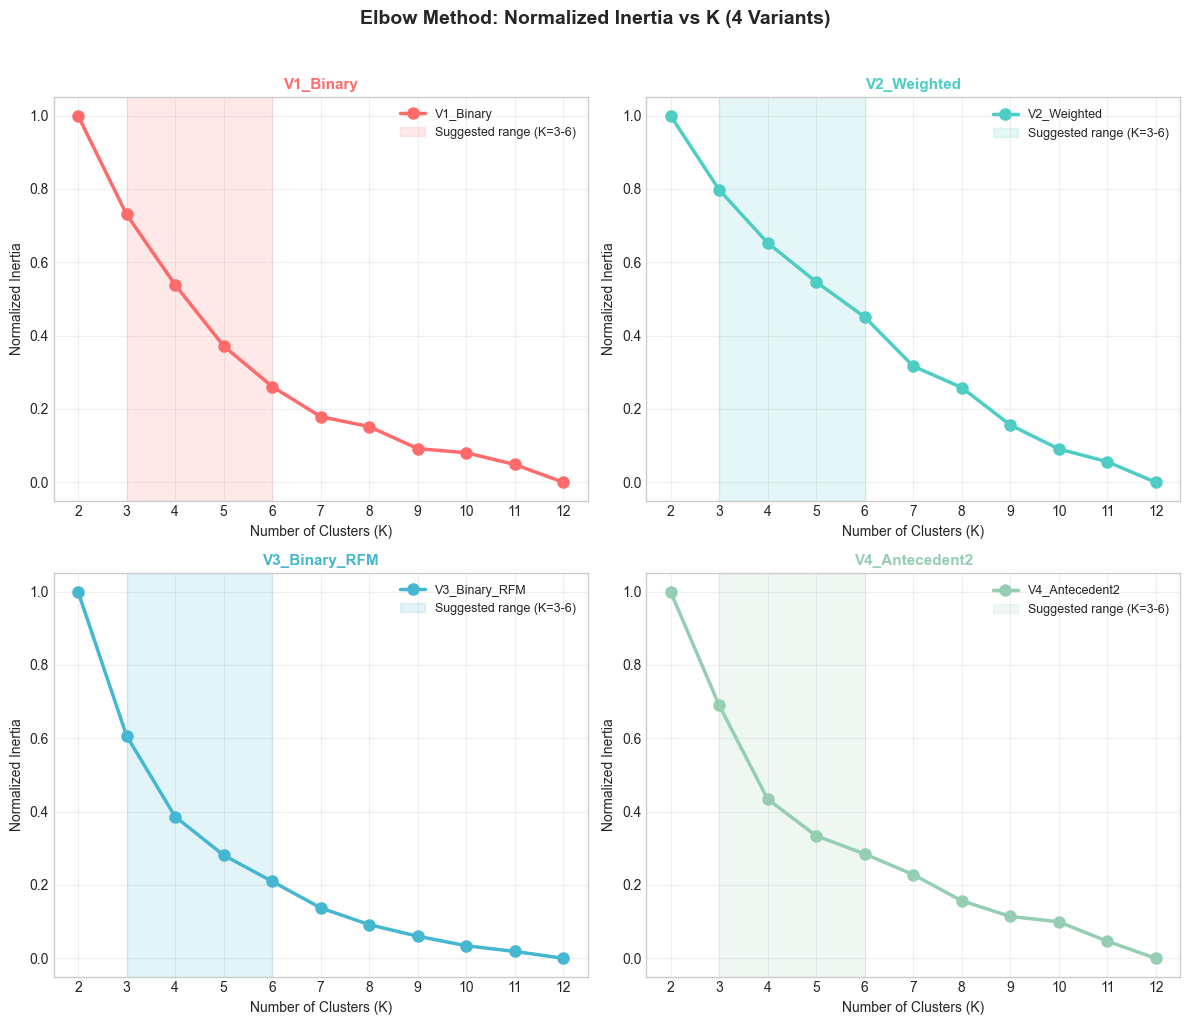


BIỂU ĐỒ 2: SILHOUETTE SCORE
Đã lưu: ../images/Req3_SilhouetteScore.png


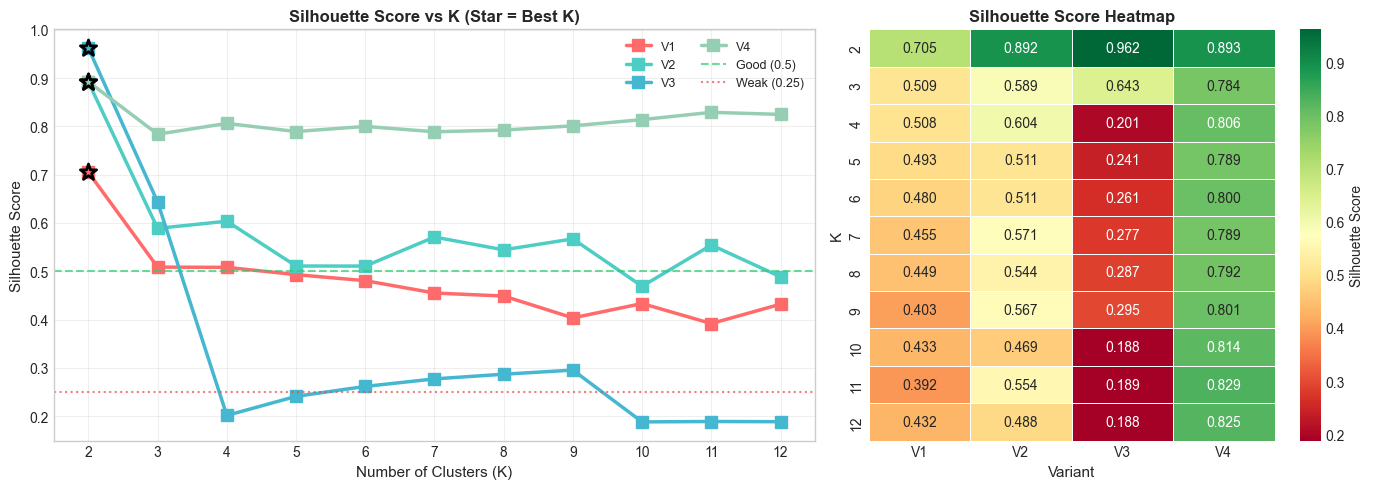


BIỂU ĐỒ 3: SO SÁNH K TỐI ƯU GIỮA CÁC VARIANTS
Đã lưu: ../images/Req3_BestKComparison.png


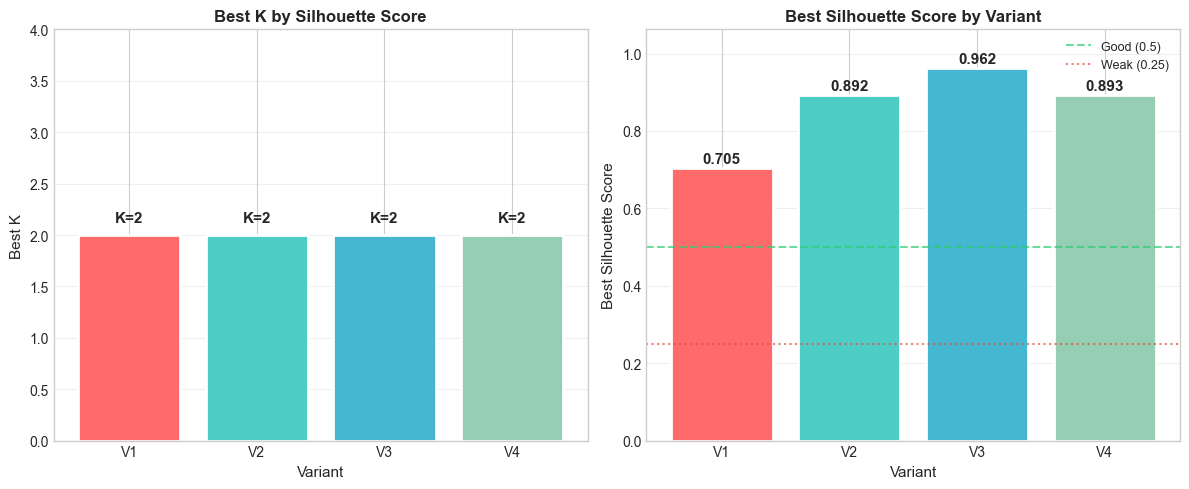


THỐNG KÊ TÓM TẮT

K tốt nhất theo Silhouette Score (mỗi variant):
  V1_Binary           : K =  2 (Silhouette = 0.7050)
  V2_Weighted         : K =  2 (Silhouette = 0.8920)
  V3_Binary_RFM       : K =  2 (Silhouette = 0.9623)
  V4_Antecedent2      : K =  2 (Silhouette = 0.8927)

K trung bình tốt nhất: 2.0
→ Gợi ý sử dụng K = 2 cho tất cả variants


In [34]:
# =============================================================================
# 3.4. TRỰC QUAN HÓA KẾT QUẢ KHẢO SÁT K
# =============================================================================

# Màu sắc cho 4 variants
colors_4 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
variant_names = ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']
variant_short = ['V1', 'V2', 'V3', 'V4']

# =============================================================================
# BIỂU ĐỒ 1: ELBOW METHOD (4 SUBPLOTS - NORMALIZED)
# =============================================================================
print("="*70)
print("BIỂU ĐỒ 1: ELBOW METHOD (NORMALIZED)")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, variant in enumerate(variant_names):
    ax = axes[i]
    data = elbow_df[elbow_df['Variant'] == variant].copy()
    
    # Normalize Inertia về [0, 1] để dễ so sánh xu hướng
    inertia_min = data['Inertia'].min()
    inertia_max = data['Inertia'].max()
    data['Inertia_norm'] = (data['Inertia'] - inertia_min) / (inertia_max - inertia_min)
    
    # Vẽ đường normalized
    ax.plot(data['K'], data['Inertia_norm'], marker='o', color=colors_4[i], 
            linewidth=2.5, markersize=8, label=f'{variant}')
    
    # Đánh dấu điểm "khuỷu tay" tiềm năng (giảm mạnh nhất)
    inertia_diff = data['Inertia'].diff().abs()
    elbow_candidates = data[inertia_diff > inertia_diff.median()]['K'].values
    
    # Tô màu vùng gợi ý (K=3-6 thường hợp lý)
    ax.axvspan(3, 6, alpha=0.15, color=colors_4[i], label='Suggested range (K=3-6)')
    
    ax.set_xlabel('Number of Clusters (K)', fontsize=10)
    ax.set_ylabel('Normalized Inertia', fontsize=10)
    ax.set_title(f'{variant}', fontsize=11, fontweight='bold', color=colors_4[i])
    ax.set_xticks(list(K_RANGE))
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(-0.05, 1.05)

plt.suptitle('Elbow Method: Normalized Inertia vs K (4 Variants)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

plt.savefig(f'{IMAGES_DIR}/Req3_ElbowMethod.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Đã lưu: {IMAGES_DIR}/Req3_ElbowMethod.png")
plt.show()

# =============================================================================
# BIỂU ĐỒ 2: SILHOUETTE SCORE (LINE CHART + HEATMAP)
# =============================================================================
print("\n" + "="*70)
print("BIỂU ĐỒ 2: SILHOUETTE SCORE")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1.5, 1]})

# --- Chart 2a: Line Chart ---
ax1 = axes[0]
for i, variant in enumerate(variant_names):
    data = silhouette_df[silhouette_df['Variant'] == variant]
    ax1.plot(data['K'], data['Silhouette'], marker='s', color=colors_4[i], 
             linewidth=2.5, markersize=8, label=variant_short[i])
    
    # Đánh dấu điểm best K cho variant này
    best_k = data.loc[data['Silhouette'].idxmax(), 'K']
    best_sil = data['Silhouette'].max()
    ax1.scatter([best_k], [best_sil], s=150, color=colors_4[i], edgecolor='black', 
                linewidth=2, zorder=5, marker='*')

ax1.axhline(y=0.5, color='#2ECC71', linestyle='--', linewidth=1.5, alpha=0.7, label='Good (0.5)')
ax1.axhline(y=0.25, color='#E74C3C', linestyle=':', linewidth=1.5, alpha=0.7, label='Weak (0.25)')

ax1.set_xlabel('Number of Clusters (K)', fontsize=11)
ax1.set_ylabel('Silhouette Score', fontsize=11)
ax1.set_title('Silhouette Score vs K (Star = Best K)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(list(K_RANGE))

# --- Chart 2b: Heatmap ---
ax2 = axes[1]

# Tạo pivot table cho heatmap
heatmap_data = silhouette_df.pivot(index='K', columns='Variant', values='Silhouette')
heatmap_data = heatmap_data[variant_names]  # Sắp xếp cột

# Vẽ heatmap
import seaborn as sns
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=ax2, cbar_kws={'label': 'Silhouette Score'},
            linewidths=0.5, linecolor='white')

ax2.set_title('Silhouette Score Heatmap', fontsize=12, fontweight='bold')
ax2.set_xlabel('Variant', fontsize=11)
ax2.set_ylabel('K', fontsize=11)
ax2.set_xticklabels(variant_short, rotation=0)

plt.tight_layout()

plt.savefig(f'{IMAGES_DIR}/Req3_SilhouetteScore.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Đã lưu: {IMAGES_DIR}/Req3_SilhouetteScore.png")
plt.show()

# =============================================================================
# BIỂU ĐỒ 3: BEST K COMPARISON
# =============================================================================
print("\n" + "="*70)
print("BIỂU ĐỒ 3: SO SÁNH K TỐI ƯU GIỮA CÁC VARIANTS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Tính best K và best Silhouette cho mỗi variant
best_results = []
for variant in variant_names:
    data = silhouette_df[silhouette_df['Variant'] == variant]
    best_row = data.loc[data['Silhouette'].idxmax()]
    best_results.append({
        'Variant': variant,
        'Best_K': int(best_row['K']),
        'Best_Silhouette': best_row['Silhouette']
    })
df_best = pd.DataFrame(best_results)

# --- Chart 3a: Best K ---
ax1 = axes[0]
bars1 = ax1.bar(variant_short, df_best['Best_K'], color=colors_4, edgecolor='white', linewidth=2)

# Thêm số trên mỗi bar
for bar, k in zip(bars1, df_best['Best_K']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'K={k}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_xlabel('Variant', fontsize=11)
ax1.set_ylabel('Best K', fontsize=11)
ax1.set_title('Best K by Silhouette Score', fontsize=12, fontweight='bold')
ax1.set_ylim(0, max(df_best['Best_K']) + 2)
ax1.grid(axis='y', alpha=0.3)

# --- Chart 3b: Best Silhouette Score ---
ax2 = axes[1]
bars2 = ax2.bar(variant_short, df_best['Best_Silhouette'], color=colors_4, edgecolor='white', linewidth=2)

# Thêm số trên mỗi bar
for bar, sil in zip(bars2, df_best['Best_Silhouette']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{sil:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Thêm đường tham chiếu
ax2.axhline(y=0.5, color='#2ECC71', linestyle='--', linewidth=1.5, alpha=0.7, label='Good (0.5)')
ax2.axhline(y=0.25, color='#E74C3C', linestyle=':', linewidth=1.5, alpha=0.7, label='Weak (0.25)')

ax2.set_xlabel('Variant', fontsize=11)
ax2.set_ylabel('Best Silhouette Score', fontsize=11)
ax2.set_title('Best Silhouette Score by Variant', fontsize=12, fontweight='bold')
ax2.set_ylim(0, max(df_best['Best_Silhouette']) + 0.1)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()

plt.savefig(f'{IMAGES_DIR}/Req3_BestKComparison.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Đã lưu: {IMAGES_DIR}/Req3_BestKComparison.png")
plt.show()

# =============================================================================
# THỐNG KÊ TÓM TẮT
# =============================================================================
print("\n" + "="*70)
print("THỐNG KÊ TÓM TẮT")
print("="*70)

print("\nK tốt nhất theo Silhouette Score (mỗi variant):")
for _, row in df_best.iterrows():
    print(f"  {row['Variant']:20s}: K = {row['Best_K']:2d} (Silhouette = {row['Best_Silhouette']:.4f})")

# Tính K trung bình tốt nhất
avg_best_k = df_best['Best_K'].mean()
print(f"\nK trung bình tốt nhất: {avg_best_k:.1f}")

# Gợi ý K
suggested_k = int(round(avg_best_k))
print(f"→ Gợi ý sử dụng K = {suggested_k} cho tất cả variants")

### 3.5. Phân tích và chọn K tối ưu cho từng Variant

**Tiêu chí chọn K (theo thứ tự ưu tiên):**
1. `CUSTOM_K`: User override trực tiếp
2. `USE_CACHED_K=True`: Load từ file config
3. **AUTO thông minh**: Kết hợp Silhouette Score + Kiểm tra phân bố cluster

**Tiêu chí AUTO mới (Ưu tiên K > 2):**
- Khảo sát K từ 2 đến 12
- Loại bỏ K nếu tạo ra **cluster outlier** (< 2% hoặc < 50 customers)
- **Ưu tiên K > 2** nếu Silhouette chỉ thấp hơn K=2 không đáng kể (dưới ngưỡng `SILHOUETTE_TOLERANCE`)
- Lý do: K=2 thường ít ý nghĩa marketing, K=3,4,5 cho nhiều insight hơn

**Tham số điều chỉnh:**
- `SILHOUETTE_TOLERANCE = 0.05` (5%): Nếu K>2 có Silhouette >= 95% của K=2 → ưu tiên chọn K>2

In [35]:
# =============================================================================
# 3.5. PHÂN TÍCH VÀ CHỌN K TỐI ƯU CHO TỪNG VARIANT
# =============================================================================

print("="*80)
print("PHAN TICH VA CHON K TOI UU (SMART AUTO - UU TIEN K > 2)")
print("="*80)

# -----------------------------------------------------------------------------
# THAM SO DIEU CHINH
# -----------------------------------------------------------------------------
MIN_CLUSTER_PCT = 2.0         # Cluster phai co it nhat 2% customers
MIN_CLUSTER_SIZE = 50         # Cluster phai co it nhat 50 customers
K_CANDIDATE_RANGE = range(2, 13)  # K tu 2 den 12

# ** THAM SO UU TIEN K > 2 **
# Neu K > 2 co Silhouette chi thap hon K=2 duoi nguong nay -> uu tien K > 2
SILHOUETTE_TOLERANCE = 20e-2   # 5% - Co the dieu chinh (0.03 = 3%, 0.10 = 10%)

print(f"\nTHAM SO:")
print(f"   - MIN_CLUSTER_PCT    = {MIN_CLUSTER_PCT}%")
print(f"   - MIN_CLUSTER_SIZE   = {MIN_CLUSTER_SIZE} customers")
print(f"   - K_CANDIDATE_RANGE  = {list(K_CANDIDATE_RANGE)}")
print(f"   - SILHOUETTE_TOLERANCE = {SILHOUETTE_TOLERANCE*100:.1f}% (uu tien K > 2 neu chenh lech duoi nguong)")

# -----------------------------------------------------------------------------
# HAM KIEM TRA PHAN BO CLUSTER
# -----------------------------------------------------------------------------
def check_cluster_distribution(X, k, random_state=42, n_init=10):
    """
    Train KMeans va kiem tra phan bo cluster.
    Returns: (is_valid, silhouette, cluster_dist, min_pct, min_count)
    """
    kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = kmeans.fit_predict(X)
    
    # Tinh Silhouette
    sil = silhouette_score(X, labels)
    
    # Thong ke phan bo
    unique, counts = np.unique(labels, return_counts=True)
    cluster_dist = dict(zip(unique, counts))
    total = len(labels)
    
    # Tim cluster nho nhat
    min_count = min(counts)
    min_pct = (min_count / total) * 100
    
    # Kiem tra dieu kien
    is_valid = (min_pct >= MIN_CLUSTER_PCT) and (min_count >= MIN_CLUSTER_SIZE)
    
    return is_valid, sil, cluster_dist, min_pct, min_count

# -----------------------------------------------------------------------------
# 1. PHAN TICH SILHOUETTE SCORE TU FILE
# -----------------------------------------------------------------------------
auto_best_k = {}

if silhouette_df is not None and len(silhouette_df) > 0:
    print("\n" + "="*80)
    print("1. BANG SILHOUETTE SCORE (tu experiments):")
    print("-"*80)
    
    silhouette_pivot = silhouette_df.pivot(index='K', columns='Variant', values='Silhouette')
    silhouette_pivot = silhouette_pivot[variant_names]
    display(silhouette_pivot.round(4))

# -----------------------------------------------------------------------------
# 2. SMART AUTO: KIEM TRA PHAN BO CLUSTER + UU TIEN K > 2
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("2. SMART AUTO: KIEM TRA PHAN BO CLUSTER + UU TIEN K > 2")
print("="*80)
print(f"   Dieu kien hop le: Min cluster >= {MIN_CLUSTER_PCT}% VA >= {MIN_CLUSTER_SIZE} customers")
print(f"   Uu tien K > 2  : Neu Silhouette chi thap hon K=2 duoi {SILHOUETTE_TOLERANCE*100:.1f}%")
print("-"*80)

for variant in variant_names:
    X = feature_variants[variant]
    n_samples = X.shape[0]
    
    print(f"\n   {variant} ({n_samples:,} customers):")
    
    valid_k_options = []  # List cac K hop le: [{'K': k, 'Silhouette': sil}, ...]
    
    for k in K_CANDIDATE_RANGE:
        is_valid, sil, cluster_dist, min_pct, min_count = check_cluster_distribution(
            X, k, RANDOM_STATE, N_INIT
        )
        
        status = "OK" if is_valid else "OUTLIER"
        icon = "v" if is_valid else "x"
        
        # Hien thi ket qua
        dist_str = ", ".join([f"C{c}:{cnt}" for c, cnt in sorted(cluster_dist.items())])
        print(f"      K={k:2d}: Sil={sil:.4f} | Min={min_count:4d}({min_pct:5.1f}%) | [{icon}] {status}")
        print(f"            Dist: {dist_str}")
        
        if is_valid:
            valid_k_options.append({'K': k, 'Silhouette': sil})
    
    # -------------------------------------------------------------------------
    # CHON K TOT NHAT VOI UU TIEN K > 2
    # -------------------------------------------------------------------------
    if valid_k_options:
        # Sap xep theo Silhouette giam dan
        valid_k_options.sort(key=lambda x: x['Silhouette'], reverse=True)
        
        # Tim Silhouette cua K=2 (neu co)
        sil_k2 = None
        for opt in valid_k_options:
            if opt['K'] == 2:
                sil_k2 = opt['Silhouette']
                break
        
        # Tim K > 2 co Silhouette cao nhat
        best_k_gt2 = None
        sil_best_gt2 = None
        for opt in valid_k_options:
            if opt['K'] > 2:
                if best_k_gt2 is None or opt['Silhouette'] > sil_best_gt2:
                    best_k_gt2 = opt['K']
                    sil_best_gt2 = opt['Silhouette']
        
        # Logic chon K
        best_overall = valid_k_options[0]  # K co Silhouette cao nhat
        
        if best_overall['K'] == 2 and best_k_gt2 is not None and sil_k2 is not None:
            # K=2 co Silhouette cao nhat, nhung kiem tra xem K > 2 co du gan khong
            diff = sil_k2 - sil_best_gt2
            diff_pct = diff / sil_k2 if sil_k2 > 0 else 0
            
            print(f"\n      [SMART CHECK] K=2 Sil={sil_k2:.4f} vs K={best_k_gt2} Sil={sil_best_gt2:.4f}")
            print(f"                    Chenh lech: {diff:.4f} ({diff_pct*100:.2f}%)")
            
            if diff_pct <= SILHOUETTE_TOLERANCE:
                # Chenh lech duoi nguong -> Uu tien K > 2
                auto_best_k[variant] = best_k_gt2
                print(f"      --> CHON: K={best_k_gt2} (UU TIEN K > 2, chenh lech {diff_pct*100:.2f}% <= {SILHOUETTE_TOLERANCE*100:.1f}%)")
            else:
                # Chenh lech qua lon -> Giu K=2
                auto_best_k[variant] = 2
                print(f"      --> CHON: K=2 (chenh lech {diff_pct*100:.2f}% > {SILHOUETTE_TOLERANCE*100:.1f}%, giu K=2)")
        else:
            # K=2 khong phai tot nhat hoac khong co K > 2 hop le
            auto_best_k[variant] = best_overall['K']
            print(f"      --> CHON: K={best_overall['K']} (Sil={best_overall['Silhouette']:.4f})")
    else:
        # Khong co K hop le -> Chon K=2 (fallback)
        print(f"      --> CANH BAO: Khong co K hop le! Chon K=2 (fallback)")
        auto_best_k[variant] = 2

# -----------------------------------------------------------------------------
# 3. XAC DINH K CUOI CUNG
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("3. XAC DINH K CUOI CUNG CHO MOI VARIANT")
print("="*80)

K_PER_VARIANT = get_k_per_variant(
    cached_config=cached_config if USE_CACHED_K else None,
    custom_k=CUSTOM_K,
    auto_k=auto_best_k
)

# -----------------------------------------------------------------------------
# 4. HIEN THI QUYET DINH
# -----------------------------------------------------------------------------
print("\n" + "-"*80)
print("BANG QUYET DINH K:")
print("-"*80)
print("""
   +--------------------+-------+------------------------------------------+
   | Variant            |   K   | Nguon                                    |
   +--------------------+-------+------------------------------------------+""")

for variant in variant_names:
    k = K_PER_VARIANT[variant]
    if CUSTOM_K.get(variant) is not None:
        source = "CUSTOM (user override)"
    elif USE_CACHED_K and cached_config and variant in cached_config:
        source = "CACHE (tu lan chay truoc)"
    else:
        source = "SMART AUTO (Sil + K>2 Priority)"
    print(f"   | {variant:18s} |   {k}   | {source:40s} |")

print("   +--------------------+-------+------------------------------------------+")

# -----------------------------------------------------------------------------
# 5. THONG KE SILHOUETTE TAI K DA CHON
# -----------------------------------------------------------------------------
if silhouette_df is not None:
    print("\n" + "-"*80)
    print("SILHOUETTE SCORE TAI K DA CHON:")
    print("-"*80)
    
    for variant in variant_names:
        k = K_PER_VARIANT[variant]
        row = silhouette_df[(silhouette_df['Variant'] == variant) & (silhouette_df['K'] == k)]
        if len(row) > 0:
            sil = row['Silhouette'].values[0]
            quality = "Excellent" if sil > 0.7 else "Good" if sil > 0.5 else "Fair" if sil > 0.25 else "Weak"
            print(f"   * {variant:20s}: K={k} -> Silhouette = {sil:.4f} ({quality})")
        else:
            # Neu khong co trong file, tinh lai
            _, sil_calc, _, _, _ = check_cluster_distribution(
                feature_variants[variant], k, RANDOM_STATE, N_INIT
            )
            quality = "Excellent" if sil_calc > 0.7 else "Good" if sil_calc > 0.5 else "Fair" if sil_calc > 0.25 else "Weak"
            print(f"   * {variant:20s}: K={k} -> Silhouette = {sil_calc:.4f} ({quality}) [calculated]")

# -----------------------------------------------------------------------------
# 6. TOM TAT THAY DOI
# -----------------------------------------------------------------------------
print("\n" + "-"*80)
print("LUU Y VE THAM SO SILHOUETTE_TOLERANCE:")
print("-"*80)
print(f"   Hien tai: SILHOUETTE_TOLERANCE = {SILHOUETTE_TOLERANCE*100:.1f}%")
print(f"   Y nghia: Neu K > 2 co Silhouette thap hon K=2 duoi {SILHOUETTE_TOLERANCE*100:.1f}%, se uu tien K > 2")
print(f"   Dieu chinh: Tang SILHOUETTE_TOLERANCE neu muon K > 2 de duoc chon hon")
print(f"               Giam SILHOUETTE_TOLERANCE neu muon chat che hon voi Silhouette")

logger.info(f"K duoc chon (Smart Auto + K>2 Priority): {K_PER_VARIANT}")

PHAN TICH VA CHON K TOI UU (SMART AUTO - UU TIEN K > 2)

THAM SO:
   - MIN_CLUSTER_PCT    = 2.0%
   - MIN_CLUSTER_SIZE   = 50 customers
   - K_CANDIDATE_RANGE  = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
   - SILHOUETTE_TOLERANCE = 20.0% (uu tien K > 2 neu chenh lech duoi nguong)

1. BANG SILHOUETTE SCORE (tu experiments):
--------------------------------------------------------------------------------


Variant,V1_Binary,V2_Weighted,V3_Binary_RFM,V4_Antecedent2
K,,,,
2,0.7050,0.8920,0.9623,0.8927
3,0.5086,0.5889,0.6435,0.7840
4,0.5081,0.6037,0.2013,0.8063
5,0.4930,0.5109,0.2408,0.7895
6,0.4805,0.5107,0.2614,0.8001
7,0.4549,0.5709,0.2770,0.7890
8,0.4487,0.5444,0.2867,0.7925
9,0.4034,0.5671,0.2952,0.8013
10,0.4331,0.4689,0.1879,0.8142



2. SMART AUTO: KIEM TRA PHAN BO CLUSTER + UU TIEN K > 2
   Dieu kien hop le: Min cluster >= 2.0% VA >= 50 customers
   Uu tien K > 2  : Neu Silhouette chi thap hon K=2 duoi 20.0%
--------------------------------------------------------------------------------

   V1_Binary (3,921 customers):
      K= 2: Sil=0.7050 | Min= 125(  3.2%) | [v] OK
            Dist: C0:3796, C1:125
      K= 3: Sil=0.5086 | Min= 124(  3.2%) | [v] OK
            Dist: C0:3442, C1:355, C2:124
      K= 4: Sil=0.5081 | Min= 117(  3.0%) | [v] OK
            Dist: C0:3346, C1:124, C2:334, C3:117
      K= 5: Sil=0.4930 | Min= 113(  2.9%) | [v] OK
            Dist: C0:3173, C1:124, C2:113, C3:202, C4:309
      K= 6: Sil=0.4805 | Min= 112(  2.9%) | [v] OK
            Dist: C0:3105, C1:112, C2:124, C3:157, C4:181, C5:242
      K= 7: Sil=0.4549 | Min= 111(  2.8%) | [v] OK
            Dist: C0:153, C1:179, C2:124, C3:243, C4:233, C5:2878, C6:111
      K= 8: Sil=0.4422 | Min= 108(  2.8%) | [v] OK
            Dist: C0:108,

2026-01-06 17:05:59,197 | INFO | K duoc chon (Smart Auto + K>2 Priority): {'V1_Binary': 2, 'V2_Weighted': 2, 'V3_Binary_RFM': 2, 'V4_Antecedent2': 4}


      K=12: Sil=0.8250 | Min=   7(  0.2%) | [x] OUTLIER
            Dist: C0:3223, C1:95, C2:120, C3:116, C4:103, C5:14, C6:7, C7:75, C8:78, C9:30, C10:11, C11:49

      [SMART CHECK] K=2 Sil=0.8927 vs K=4 Sil=0.8063
                    Chenh lech: 0.0863 (9.67%)
      --> CHON: K=4 (UU TIEN K > 2, chenh lech 9.67% <= 20.0%)

3. XAC DINH K CUOI CUNG CHO MOI VARIANT
  V1_Binary: K = 2 (AUTO từ Silhouette)
  V2_Weighted: K = 2 (AUTO từ Silhouette)
  V3_Binary_RFM: K = 2 (AUTO từ Silhouette)
  V4_Antecedent2: K = 4 (AUTO từ Silhouette)

--------------------------------------------------------------------------------
BANG QUYET DINH K:
--------------------------------------------------------------------------------

   +--------------------+-------+------------------------------------------+
   | Variant            |   K   | Nguon                                    |
   +--------------------+-------+------------------------------------------+
   | V1_Binary          |   2   | SMART AUTO (S

### 3.6. Huấn luyện K-Means với K riêng cho từng Variant

Mỗi variant được huấn luyện với **K tối ưu riêng** đã xác định ở bước 3.5.
Điều này cho phép mỗi biến thể feature đạt được chất lượng clustering tốt nhất.

In [36]:
# =============================================================================
# TONG KET GIA TRI K DUOC SU DUNG CHO MOI VARIANT
# =============================================================================

print("="*70)
print("       TONG KET GIA TRI K DUOC SU DUNG")
print("="*70)
print("""
   ╔══════════════════════════════════════════════════════════════════╗
   ║   Variant                │   K   │            Source             ║
   ╠══════════════════════════════════════════════════════════════════╣""")

for variant in variant_names:
    k = K_PER_VARIANT[variant]
    # Xac dinh nguon
    if CUSTOM_K.get(variant) is not None:
        source = "CUSTOM"
        icon = "[*]"
    elif USE_CACHED_K and cached_config and variant in cached_config:
        source = "CACHE"
        icon = "[C]"
    else:
        source = "AUTO"
        icon = "[A]"
    
    # Lay Silhouette score tai K nay
    if silhouette_df is not None:
        row = silhouette_df[(silhouette_df['Variant'] == variant) & (silhouette_df['K'] == k)]
        if len(row) > 0:
            sil = row['Silhouette'].values[0]
            sil_str = f"Sil={sil:.4f}"
        else:
            sil_str = "Sil=N/A"
    else:
        sil_str = "Sil=N/A"
    
    print(f"   ║   {icon} {variant:18s} │   {k}   │   {source:6s} ({sil_str})         ║")

print("""
   ╠══════════════════════════════════════════════════════════════════╣
   ║   [*] = CUSTOM override    [C] = CACHE    [A] = AUTO             ║
   ╚══════════════════════════════════════════════════════════════════╝
""")

# Hien thi dang DataFrame de de doc
print("\nBang tong hop:")
df_k_summary = pd.DataFrame([
    {
        'Variant': v,
        'K': K_PER_VARIANT[v],
        'Nguon': 'CUSTOM' if CUSTOM_K.get(v) is not None else ('CACHE' if USE_CACHED_K and cached_config and v in cached_config else 'AUTO')
    }
    for v in variant_names
])
display(df_k_summary)

print("\n" + "-"*70)
print("San sang huan luyen K-Means voi cac gia tri K tren!")
print("-"*70)

       TONG KET GIA TRI K DUOC SU DUNG

   ╔══════════════════════════════════════════════════════════════════╗
   ║   Variant                │   K   │            Source             ║
   ╠══════════════════════════════════════════════════════════════════╣
   ║   [A] V1_Binary          │   2   │   AUTO   (Sil=0.7050)         ║
   ║   [A] V2_Weighted        │   2   │   AUTO   (Sil=0.8920)         ║
   ║   [A] V3_Binary_RFM      │   2   │   AUTO   (Sil=0.9623)         ║
   ║   [A] V4_Antecedent2     │   4   │   AUTO   (Sil=0.8063)         ║

   ╠══════════════════════════════════════════════════════════════════╣
   ║   [*] = CUSTOM override    [C] = CACHE    [A] = AUTO             ║
   ╚══════════════════════════════════════════════════════════════════╝


Bang tong hop:


,Variant,K,Nguon
0,V1_Binary,2,AUTO
1,V2_Weighted,2,AUTO
2,V3_Binary_RFM,2,AUTO
3,V4_Antecedent2,4,AUTO



----------------------------------------------------------------------
San sang huan luyen K-Means voi cac gia tri K tren!
----------------------------------------------------------------------


In [37]:
# =============================================================================
# 3.6. HUẤN LUYỆN K-MEANS VỚI K RIÊNG CHO TỪNG VARIANT
# =============================================================================

print("="*70)
print("HUẤN LUYỆN K-MEANS")
print("="*70)

# Dictionary lưu kết quả
kmeans_models = {}
cluster_labels = {}
cluster_stats = []

for variant_name, X in feature_variants.items():
    # Lấy K cho variant này
    k = K_PER_VARIANT[variant_name]
    
    start_time = time.time()
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, n_init=N_INIT, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X)
    
    # Tính Silhouette score
    sil_score = silhouette_score(X, labels)
    
    elapsed = time.time() - start_time
    
    # Lưu model và labels
    kmeans_models[variant_name] = kmeans
    cluster_labels[variant_name] = labels
    
    # Thống kê số lượng mỗi cluster
    unique, counts = np.unique(labels, return_counts=True)
    cluster_dist = dict(zip(unique, counts))
    
    stats = {
        'Variant': variant_name,
        'K': k,
        'Silhouette': round(sil_score, 4),
        'Inertia': round(kmeans.inertia_, 2),
        'Time_sec': round(elapsed, 3)
    }
    
    # Thêm số lượng mỗi cluster (dynamic based on K)
    for c in range(k):
        stats[f'C{c}_Count'] = cluster_dist.get(c, 0)
        stats[f'C{c}_Pct'] = round(cluster_dist.get(c, 0) / len(labels) * 100, 1)
    
    cluster_stats.append(stats)
    
    logger.info(f"{variant_name}: K={k}, Silhouette={sil_score:.4f}, Time={elapsed:.2f}s")
    
    print(f"\n{variant_name} (K={k}):")
    print(f"  • Silhouette Score: {sil_score:.4f}")
    print(f"  • Inertia: {kmeans.inertia_:,.2f}")
    print(f"  • Cluster distribution:")
    for c, cnt in cluster_dist.items():
        pct = cnt / len(labels) * 100
        print(f"    - Cluster {c}: {cnt:,} customers ({pct:.1f}%)")

# Tạo DataFrame thống kê
df_cluster_stats = pd.DataFrame(cluster_stats)

print("\n" + "="*70)
print("BẢNG TỔNG HỢP KẾT QUẢ CLUSTERING")
print("="*70)

# Hiển thị bảng chính
display_cols = ['Variant', 'K', 'Silhouette', 'Inertia']
display(df_cluster_stats[display_cols])

# Phân tích so sánh
print("\n" + "-"*70)
print("NHẬN XÉT:")
print("-"*70)

best_variant = df_cluster_stats.loc[df_cluster_stats['Silhouette'].idxmax(), 'Variant']
best_sil = df_cluster_stats['Silhouette'].max()
best_k = df_cluster_stats.loc[df_cluster_stats['Silhouette'].idxmax(), 'K']

print(f"""
  • Variant tốt nhất: {best_variant} (K={best_k}, Silhouette={best_sil:.4f})
  
  Phân tích:
  - Mỗi variant được huấn luyện với K tối ưu riêng
  - Silhouette > 0.5: Cấu trúc cluster rõ ràng
  - Silhouette 0.25-0.5: Cấu trúc trung bình
  - Silhouette < 0.25: Cấu trúc yếu (cần xem xét lại)
""")

# Lưu thống kê
stats_file = f"{EXPERIMENT_DIR}/kmeans_final_stats.csv"
df_cluster_stats.to_csv(stats_file, index=False)
print(f"Đã lưu: {stats_file}")

HUẤN LUYỆN K-MEANS


2026-01-06 17:05:59,664 | INFO | V1_Binary: K=2, Silhouette=0.7050, Time=0.41s



V1_Binary (K=2):
  • Silhouette Score: 0.7050
  • Inertia: 17,432.19
  • Cluster distribution:
    - Cluster 0: 3,796 customers (96.8%)
    - Cluster 1: 125 customers (3.2%)


2026-01-06 17:06:00,080 | INFO | V2_Weighted: K=2, Silhouette=0.8920, Time=0.42s



V2_Weighted (K=2):
  • Silhouette Score: 0.8920
  • Inertia: 9,009,866.00
  • Cluster distribution:
    - Cluster 0: 3,797 customers (96.8%)
    - Cluster 1: 124 customers (3.2%)


2026-01-06 17:06:00,480 | INFO | V3_Binary_RFM: K=2, Silhouette=0.9623, Time=0.40s



V3_Binary_RFM (K=2):
  • Silhouette Score: 0.9623
  • Inertia: 27,647.57
  • Cluster distribution:
    - Cluster 0: 3,920 customers (100.0%)
    - Cluster 1: 1 customers (0.0%)


2026-01-06 17:06:00,814 | INFO | V4_Antecedent2: K=4, Silhouette=0.8063, Time=0.33s



V4_Antecedent2 (K=4):
  • Silhouette Score: 0.8063
  • Inertia: 1,424.42
  • Cluster distribution:
    - Cluster 0: 3,554 customers (90.6%)
    - Cluster 1: 124 customers (3.2%)
    - Cluster 2: 110 customers (2.8%)
    - Cluster 3: 133 customers (3.4%)

BẢNG TỔNG HỢP KẾT QUẢ CLUSTERING


,Variant,K,Silhouette,Inertia
0,V1_Binary,2,0.7050,17432.19
1,V2_Weighted,2,0.8920,9009866.00
2,V3_Binary_RFM,2,0.9623,27647.57
3,V4_Antecedent2,4,0.8063,1424.42



----------------------------------------------------------------------
NHẬN XÉT:
----------------------------------------------------------------------

  • Variant tốt nhất: V3_Binary_RFM (K=2, Silhouette=0.9623)

  Phân tích:
  - Mỗi variant được huấn luyện với K tối ưu riêng
  - Silhouette > 0.5: Cấu trúc cluster rõ ràng
  - Silhouette 0.25-0.5: Cấu trúc trung bình
  - Silhouette < 0.25: Cấu trúc yếu (cần xem xét lại)

Đã lưu: ../data/mini_project/clustering_experiments/kmeans_final_stats.csv


### 3.7. Lưu kết quả phân cụm và cập nhật Config

Bước này thực hiện:
1. Lưu nhãn cụm cho từng variant vào file CSV riêng
2. Tạo file tổng hợp tất cả variants
3. **Cập nhật `optimal_k_config.json`** để lần sau có thể reload

In [38]:
# =============================================================================
# 3.7. LUU KET QUA PHAN CUM VA CAP NHAT CONFIG
# =============================================================================

print("="*70)
print("LƯU KẾT QUẢ PHÂN CỤM")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Lay danh sach CustomerID
# -----------------------------------------------------------------------------
try:
    if 'customers' not in dir() or customers is None:
        df_temp = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v1_binary.csv")
        customers = df_temp['CustomerID'].values
except:
    df_temp = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v1_binary.csv")
    customers = df_temp['CustomerID'].values

print(f"Số lượng khách hàng: {len(customers):,}")

# -----------------------------------------------------------------------------
# 2. Luu cluster labels cho tung variant
# -----------------------------------------------------------------------------
variant_short_names = {
    'V1_Binary': 'v1',
    'V2_Weighted': 'v2',
    'V3_Binary_RFM': 'v3',
    'V4_Antecedent2': 'v4'
}

saved_files = []
for vname, labels in cluster_labels.items():
    short_name = variant_short_names[vname]
    k = K_PER_VARIANT[vname]
    
    # Tao DataFrame
    df_result = pd.DataFrame({
        'CustomerID': customers,
        'Cluster': labels
    })
    
    # Luu file voi ten bao gom K
    output_file = f"{DATA_OUTPUT_DIR}/customer_clusters_{short_name}_k{k}.csv"
    df_result.to_csv(output_file, index=False)
    saved_files.append(output_file)
    
    # Hien thi thong ke
    print(f"\n[OK] {vname} (K={k}):")
    print(f"  File: {output_file}")
    dist = df_result['Cluster'].value_counts().sort_index()
    for c, cnt in dist.items():
        pct = cnt / len(labels) * 100
        print(f"  - Cluster {c}: {cnt:,} ({pct:.1f}%)")

# -----------------------------------------------------------------------------
# 3. Tao file tong hop
# -----------------------------------------------------------------------------
df_all_clusters = pd.DataFrame({'CustomerID': customers})
for vname, labels in cluster_labels.items():
    short_name = variant_short_names[vname]
    k = K_PER_VARIANT[vname]
    df_all_clusters[f'Cluster_{short_name}_k{k}'] = labels

all_clusters_file = f"{DATA_OUTPUT_DIR}/customer_clusters_all_variants.csv"
df_all_clusters.to_csv(all_clusters_file, index=False)

print(f"\n{'='*70}")
print(f"[OK] FILE TỔNG HỢP: {all_clusters_file}")
print(f"  Shape: {df_all_clusters.shape}")
print(f"{'='*70}")

# Hien thi mau du lieu
print("\nMẫu 10 dòng đầu:")
display(df_all_clusters.head(10))

# -----------------------------------------------------------------------------
# 4. Cap nhat Config file
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("CẬP NHẬT CONFIG FILE")
print("="*70)

# Tao config moi voi ten bien khac de tranh xung dot
config_to_save = {}
for vname in variant_names:
    k = K_PER_VARIANT[vname]
    
    # Lay Silhouette tu ket qua training
    sil = df_cluster_stats[df_cluster_stats['Variant'] == vname]['Silhouette'].values[0]
    
    config_to_save[vname] = {
        'K': int(k),
        'Silhouette': float(sil)
    }

# Luu config
save_k_config(config_to_save, CONFIG_FILE)

# In ket qua
print("\nConfig đã lưu:")
for vname in variant_names:
    k_val = config_to_save[vname]['K']
    sil_val = config_to_save[vname]['Silhouette']
    print(f"  - {vname}: K={k_val} (Silhouette={sil_val:.4f})")

print(f"\n[TIP] Lần sau, đặt USE_CACHED_K = True ở Cell 3.1 để sử dụng K này!")

logger.info(f"Đã lưu {len(saved_files) + 1} files kết quả phân cụm")
logger.info(f"Config saved: {CONFIG_FILE}")

LƯU KẾT QUẢ PHÂN CỤM
Số lượng khách hàng: 3,921

[OK] V1_Binary (K=2):
  File: ../data/mini_project/customer_clusters_v1_k2.csv
  - Cluster 0: 3,796 (96.8%)
  - Cluster 1: 125 (3.2%)

[OK] V2_Weighted (K=2):
  File: ../data/mini_project/customer_clusters_v2_k2.csv
  - Cluster 0: 3,797 (96.8%)
  - Cluster 1: 124 (3.2%)

[OK] V3_Binary_RFM (K=2):
  File: ../data/mini_project/customer_clusters_v3_k2.csv
  - Cluster 0: 3,920 (100.0%)
  - Cluster 1: 1 (0.0%)

[OK] V4_Antecedent2 (K=4):
  File: ../data/mini_project/customer_clusters_v4_k4.csv
  - Cluster 0: 3,554 (90.6%)
  - Cluster 1: 124 (3.2%)
  - Cluster 2: 110 (2.8%)
  - Cluster 3: 133 (3.4%)

[OK] FILE TỔNG HỢP: ../data/mini_project/customer_clusters_all_variants.csv
  Shape: (3921, 5)

Mẫu 10 dòng đầu:


,CustomerID,Cluster_v1_k2,Cluster_v2_k2,Cluster_v3_k2,Cluster_v4_k4
0,000nan,1,1,1,1
1,012346,0,0,0,0
2,012747,0,0,0,0
3,012748,1,1,0,1
4,012749,0,0,0,0
5,012820,0,0,0,0
6,012821,0,0,0,0
7,012822,0,0,0,0
8,012823,0,0,0,0
9,012824,0,0,0,0


2026-01-06 17:06:00,914 | INFO | Đã lưu 5 files kết quả phân cụm
2026-01-06 17:06:00,914 | INFO | Config saved: ../data/mini_project/clustering_experiments/optimal_k_config.json



CẬP NHẬT CONFIG FILE
✓ Đã lưu config: ../data/mini_project/clustering_experiments/optimal_k_config.json

Config đã lưu:
  - V1_Binary: K=2 (Silhouette=0.7050)
  - V2_Weighted: K=2 (Silhouette=0.8920)
  - V3_Binary_RFM: K=2 (Silhouette=0.9623)
  - V4_Antecedent2: K=4 (Silhouette=0.8063)

[TIP] Lần sau, đặt USE_CACHED_K = True ở Cell 3.1 để sử dụng K này!


## 4. Yêu cầu 4
+ Kết quả phân cụm cần được trực quan hóa và đánh giá ở mức tối thiểu.
+ Mỗi nhóm phải thực hiện giảm chiều về 2D bằng PCA hoặc SVD và vẽ scatter plot, tô màu theo cluster để người đọc thấy mức độ tách cụm (tách rõ hay chồng lấn).
+ Nhóm cần nhận xét ngắn về biểu đồ, tránh nhận xét chung chung mà cần bám vào hình ảnh.

### 4.1. Load Data & Configuration

In [39]:
# =============================================================================
# 4.1. LOAD DATA & CONFIGURATION
# =============================================================================
# Load feature matrices và cluster labels từ Yêu cầu 3
# Setup visualization parameters

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial import ConvexHull
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("YÊU CẦU 4: TRỰC QUAN HÓA 2D - PCA & SVD")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Configuration
# -----------------------------------------------------------------------------
VARIANT_NAMES = ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']
VARIANT_FILES = {
    'V1_Binary': 'feature_matrix_v1_binary.csv',
    'V2_Weighted': 'feature_matrix_v2_weighted.csv',
    'V3_Binary_RFM': 'feature_matrix_v3_binary_rfm.csv',
    'V4_Antecedent2': 'feature_matrix_v4_antecedent2.csv'
}
CLUSTER_FILES = {
    'V1_Binary': 'customer_clusters_v1_k2.csv',
    'V2_Weighted': 'customer_clusters_v2_k2.csv',
    'V3_Binary_RFM': 'customer_clusters_v3_k2.csv',
    'V4_Antecedent2': 'customer_clusters_v4_k4.csv'
}

# K values từ Yêu cầu 3
K_VALUES = {'V1_Binary': 2, 'V2_Weighted': 2, 'V3_Binary_RFM': 2, 'V4_Antecedent2': 4}
# Color palettes
COLORS_K2 = ['#3498db', '#e74c3c']  # Blue, Red
COLORS_K4 = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']  # Blue, Green, Orange, Red

# Plot settings
FIGURE_SIZE = (14, 12)
ALPHA = 0.6
MARKER_SIZE = 30
RANDOM_STATE = 42

# -----------------------------------------------------------------------------
# 2. Load Feature Matrices & Cluster Labels
# -----------------------------------------------------------------------------
print("\n[1] ĐANG TẢI DỮ LIỆU...")

feature_data = {}
cluster_data = {}
data_info = []

for variant in VARIANT_NAMES:
    # Load feature matrix
    feature_path = f"{DATA_OUTPUT_DIR}/{VARIANT_FILES[variant]}"
    df_features = pd.read_csv(feature_path)
    
    # Tách CustomerID và features
    customer_ids = df_features['CustomerID'].values
    feature_cols = [c for c in df_features.columns if c != 'CustomerID']
    X = df_features[feature_cols].values
    
    # Load cluster labels
    cluster_path = f"{DATA_OUTPUT_DIR}/{CLUSTER_FILES[variant]}"
    df_clusters = pd.read_csv(cluster_path)
    labels = df_clusters['Cluster'].values
    
    # Lưu vào dict
    feature_data[variant] = {
        'X': X,
        'customers': customer_ids,
        'feature_cols': feature_cols
    }
    cluster_data[variant] = labels
    
    # Thống kê
    n_customers = len(customer_ids)
    n_features = len(feature_cols)
    k = K_VALUES[variant]
    
    data_info.append({
        'Variant': variant,
        'Customers': n_customers,
        'Features': n_features,
        'K': k
    })
    
    print(f"  [OK] {variant}: {n_customers:,} khách hàng x {n_features} features, K={k}")

# Hiển thị bảng tóm tắt
print("\n" + "="*70)
print("TÓM TẮT DỮ LIỆU ĐÃ TẢI")
print("="*70)
df_data_info = pd.DataFrame(data_info)
display(df_data_info)

print("\n[OK] Đã tải xong dữ liệu cho 4 variants!")

YÊU CẦU 4: TRỰC QUAN HÓA 2D - PCA & SVD

[1] ĐANG TẢI DỮ LIỆU...
  [OK] V1_Binary: 3,921 khách hàng x 200 features, K=2
  [OK] V2_Weighted: 3,921 khách hàng x 200 features, K=2
  [OK] V3_Binary_RFM: 3,921 khách hàng x 203 features, K=2
  [OK] V4_Antecedent2: 3,921 khách hàng x 66 features, K=4

TÓM TẮT DỮ LIỆU ĐÃ TẢI


,Variant,Customers,Features,K
0,V1_Binary,3921,200,2
1,V2_Weighted,3921,200,2
2,V3_Binary_RFM,3921,203,2
3,V4_Antecedent2,3921,66,4



[OK] Đã tải xong dữ liệu cho 4 variants!


### 4.2. Dimensionality Reduction: PCA

PCA - PRINCIPAL COMPONENT ANALYSIS

[1] THỰC HIỆN PCA...
  V1_Binary: PC1=26.1%, PC2=10.8%, Tổng=36.9%
  V2_Weighted: PC1=74.4%, PC2=3.8%, Tổng=78.1%
  V3_Binary_RFM: PC1=24.2%, PC2=16.1%, Tổng=40.2%
  V4_Antecedent2: PC1=61.3%, PC2=9.8%, Tổng=71.2%

[2] VẼ BIỂU ĐỒ PCA...

[OK] Đã lưu: ../images/Req4_PCA_ClusterSeparation.png


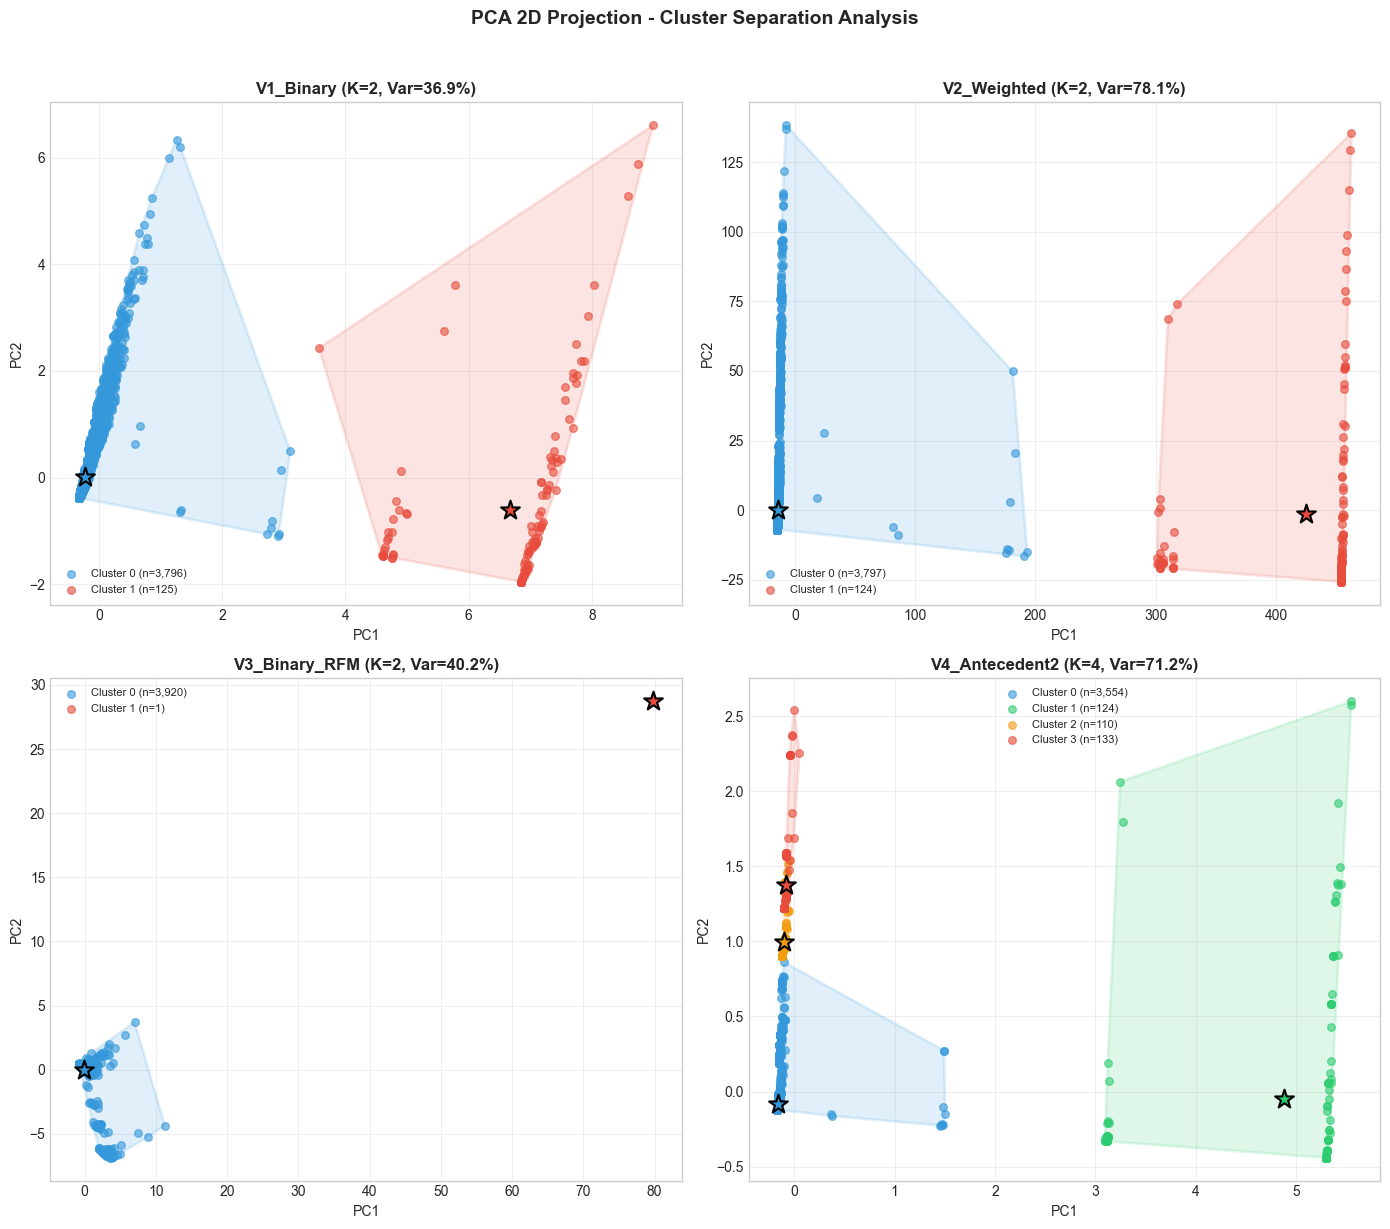


BẢNG TÓM TẮT PCA EXPLAINED VARIANCE


,Variant,K,PC1 (%),PC2 (%),Tổng (%)
0,V1_Binary,2,26.1,10.8,36.9
1,V2_Weighted,2,74.4,3.8,78.1
2,V3_Binary_RFM,2,24.2,16.1,40.2
3,V4_Antecedent2,4,61.3,9.8,71.2


In [40]:
# =============================================================================
# 4.2. PCA - PRINCIPAL COMPONENT ANALYSIS
# =============================================================================
# Giảm chiều về 2D bằng PCA và vẽ scatter plot cho 4 variants

print("="*70)
print("PCA - PRINCIPAL COMPONENT ANALYSIS")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Helper function: Vẽ Convex Hull
# -----------------------------------------------------------------------------
def draw_convex_hull(ax, points, color, alpha=0.2):
    """Vẽ đường bao Convex Hull quanh một nhóm điểm"""
    if len(points) < 3:
        return
    try:
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])
        ax.fill(points[hull_points, 0], points[hull_points, 1], 
                alpha=alpha, color=color, edgecolor=color, linewidth=2)
    except:
        pass  # Bỏ qua nếu không thể vẽ ConvexHull

# -----------------------------------------------------------------------------
# 2. Thực hiện PCA cho 4 variants
# -----------------------------------------------------------------------------
pca_results = {}

print("\n[1] THỰC HIỆN PCA...")
for variant in VARIANT_NAMES:
    X = feature_data[variant]['X']
    
    # Fit PCA
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Z = pca.fit_transform(X)
    
    # Lưu kết quả
    pca_results[variant] = {
        'Z': Z,
        'explained_variance': pca.explained_variance_ratio_,
        'total_variance': sum(pca.explained_variance_ratio_) * 100
    }
    
    var1 = pca.explained_variance_ratio_[0] * 100
    var2 = pca.explained_variance_ratio_[1] * 100
    print(f"  {variant}: PC1={var1:.1f}%, PC2={var2:.1f}%, Tổng={var1+var2:.1f}%")

# -----------------------------------------------------------------------------
# 3. Vẽ Figure 2x2
# -----------------------------------------------------------------------------
print("\n[2] VẼ BIỂU ĐỒ PCA...")

fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZE)
axes = axes.flatten()

for idx, variant in enumerate(VARIANT_NAMES):
    ax = axes[idx]
    Z = pca_results[variant]['Z']
    labels = cluster_data[variant]
    k = K_VALUES[variant]
    total_var = pca_results[variant]['total_variance']
    
    # Chọn color palette
    colors = COLORS_K2 if k == 2 else COLORS_K4
    
    # Vẽ từng cluster
    for cluster_id in range(k):
        mask = labels == cluster_id
        points = Z[mask]
        color = colors[cluster_id]
        
        # Vẽ Convex Hull trước (để nằm dưới)
        draw_convex_hull(ax, points, color, alpha=0.15)
        
        # Vẽ scatter points
        ax.scatter(points[:, 0], points[:, 1], 
                   c=color, s=MARKER_SIZE, alpha=ALPHA,
                   label=f'Cluster {cluster_id} (n={mask.sum():,})')
        
        # Vẽ centroid
        centroid = points.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], 
                   c=color, s=200, marker='*', 
                   edgecolors='black', linewidths=1.5, zorder=10)
    
    # Title và labels
    ax.set_title(f'{variant} (K={k}, Var={total_var:.1f}%)', fontsize=12, fontweight='bold')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('PCA 2D Projection - Cluster Separation Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Lưu figure
pca_output_path = f"{IMAGES_DIR}/Req4_PCA_ClusterSeparation.png"
plt.savefig(pca_output_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"\n[OK] Đã lưu: {pca_output_path}")

plt.show()

# -----------------------------------------------------------------------------
# 4. Bảng tóm tắt PCA
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("BẢNG TÓM TẮT PCA EXPLAINED VARIANCE")
print("="*70)

pca_summary = []
for variant in VARIANT_NAMES:
    var_ratio = pca_results[variant]['explained_variance']
    pca_summary.append({
        'Variant': variant,
        'K': K_VALUES[variant],
        'PC1 (%)': f"{var_ratio[0]*100:.1f}",
        'PC2 (%)': f"{var_ratio[1]*100:.1f}",
        'Tổng (%)': f"{(var_ratio[0]+var_ratio[1])*100:.1f}"
    })

df_pca_summary = pd.DataFrame(pca_summary)
display(df_pca_summary)

### 4.3. Dimensionality Reduction: SVD

TRUNCATED SVD - SINGULAR VALUE DECOMPOSITION

[1] THỰC HIỆN SVD...
  V1_Binary: SV1=25.8%, SV2=11.1%, Tổng=36.8%
  V2_Weighted: SV1=74.3%, SV2=3.7%, Tổng=78.1%
  V3_Binary_RFM: SV1=24.0%, SV2=16.0%, Tổng=40.0%
  V4_Antecedent2: SV1=61.3%, SV2=9.9%, Tổng=71.1%

[2] VẼ BIỂU ĐỒ SVD...

[OK] Đã lưu: ../images/Req4_SVD_ClusterSeparation.png


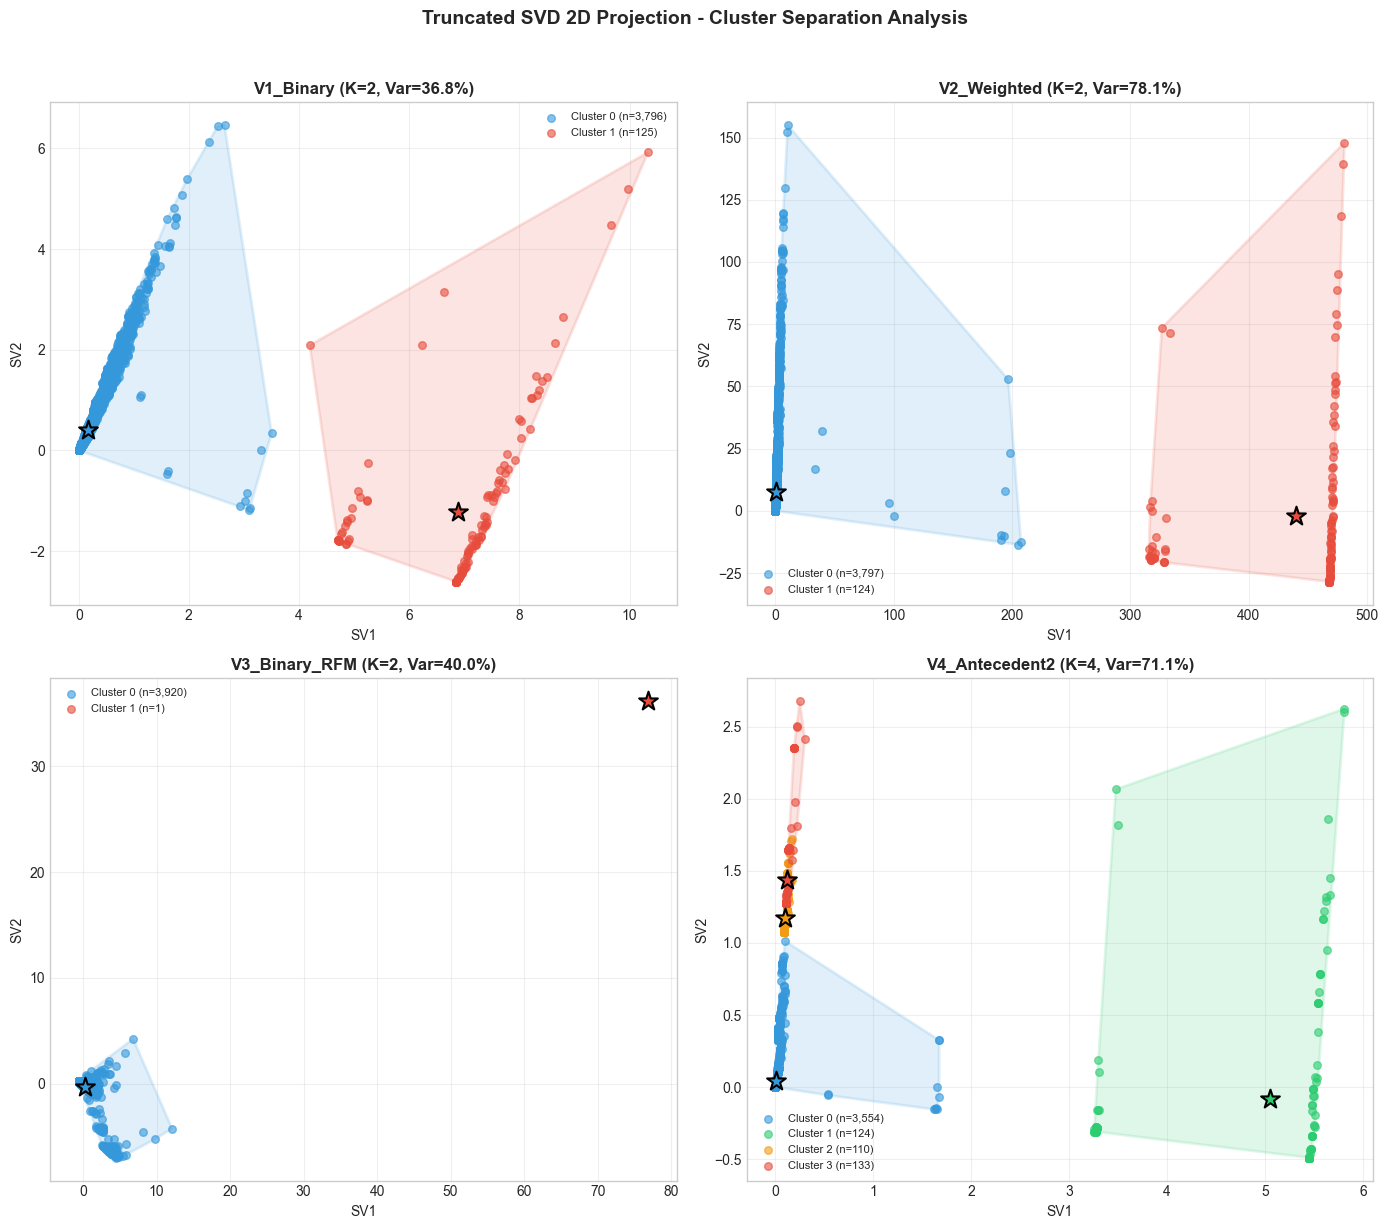


BẢNG TÓM TẮT SVD EXPLAINED VARIANCE


,Variant,K,SV1 (%),SV2 (%),Tổng (%)
0,V1_Binary,2,25.8,11.1,36.8
1,V2_Weighted,2,74.3,3.7,78.1
2,V3_Binary_RFM,2,24.0,16.0,40.0
3,V4_Antecedent2,4,61.3,9.9,71.1


In [41]:
# =============================================================================
# 4.3. SVD - TRUNCATED SINGULAR VALUE DECOMPOSITION
# =============================================================================
# Giảm chiều về 2D bằng TruncatedSVD và vẽ scatter plot cho 4 variants
# SVD phù hợp với sparse data hơn PCA

print("="*70)
print("TRUNCATED SVD - SINGULAR VALUE DECOMPOSITION")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Thực hiện SVD cho 4 variants
# -----------------------------------------------------------------------------
svd_results = {}

print("\n[1] THỰC HIỆN SVD...")
for variant in VARIANT_NAMES:
    X = feature_data[variant]['X']
    
    # Fit TruncatedSVD
    svd = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
    Z = svd.fit_transform(X)
    
    # Lưu kết quả
    svd_results[variant] = {
        'Z': Z,
        'explained_variance': svd.explained_variance_ratio_,
        'total_variance': sum(svd.explained_variance_ratio_) * 100
    }
    
    var1 = svd.explained_variance_ratio_[0] * 100
    var2 = svd.explained_variance_ratio_[1] * 100
    print(f"  {variant}: SV1={var1:.1f}%, SV2={var2:.1f}%, Tổng={var1+var2:.1f}%")

# -----------------------------------------------------------------------------
# 2. Vẽ Figure 2x2
# -----------------------------------------------------------------------------
print("\n[2] VẼ BIỂU ĐỒ SVD...")

fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZE)
axes = axes.flatten()

for idx, variant in enumerate(VARIANT_NAMES):
    ax = axes[idx]
    Z = svd_results[variant]['Z']
    labels = cluster_data[variant]
    k = K_VALUES[variant]
    total_var = svd_results[variant]['total_variance']
    
    # Chọn color palette
    colors = COLORS_K2 if k == 2 else COLORS_K4
    
    # Vẽ từng cluster
    for cluster_id in range(k):
        mask = labels == cluster_id
        points = Z[mask]
        color = colors[cluster_id]
        
        # Vẽ Convex Hull trước (để nằm dưới)
        draw_convex_hull(ax, points, color, alpha=0.15)
        
        # Vẽ scatter points
        ax.scatter(points[:, 0], points[:, 1], 
                   c=color, s=MARKER_SIZE, alpha=ALPHA,
                   label=f'Cluster {cluster_id} (n={mask.sum():,})')
        
        # Vẽ centroid
        centroid = points.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], 
                   c=color, s=200, marker='*', 
                   edgecolors='black', linewidths=1.5, zorder=10)
    
    # Title và labels
    ax.set_title(f'{variant} (K={k}, Var={total_var:.1f}%)', fontsize=12, fontweight='bold')
    ax.set_xlabel('SV1')
    ax.set_ylabel('SV2')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Truncated SVD 2D Projection - Cluster Separation Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Lưu figure
svd_output_path = f"{IMAGES_DIR}/Req4_SVD_ClusterSeparation.png"
plt.savefig(svd_output_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"\n[OK] Đã lưu: {svd_output_path}")

plt.show()

# -----------------------------------------------------------------------------
# 3. Bảng tóm tắt SVD
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("BẢNG TÓM TẮT SVD EXPLAINED VARIANCE")
print("="*70)

svd_summary = []
for variant in VARIANT_NAMES:
    var_ratio = svd_results[variant]['explained_variance']
    svd_summary.append({
        'Variant': variant,
        'K': K_VALUES[variant],
        'SV1 (%)': f"{var_ratio[0]*100:.1f}",
        'SV2 (%)': f"{var_ratio[1]*100:.1f}",
        'Tổng (%)': f"{(var_ratio[0]+var_ratio[1])*100:.1f}"
    })

df_svd_summary = pd.DataFrame(svd_summary)
display(df_svd_summary)

### 4.4. Cluster Separation Analysis

In [42]:
# =============================================================================
# 4.4. CLUSTER SEPARATION ANALYSIS
# =============================================================================
# So sanh muc do tach cum giua 4 variants dua tren PCA va SVD

print("="*70)
print("PHAN TICH MUC DO TACH CUM - SO SANH 4 VARIANTS")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Tinh khoang cach giua cac centroid (Inter-cluster distance)
# -----------------------------------------------------------------------------
def calculate_centroid_distance(Z, labels, k):
    """Tinh khoang cach trung binh giua cac centroid"""
    centroids = []
    for i in range(k):
        mask = labels == i
        centroid = Z[mask].mean(axis=0)
        centroids.append(centroid)
    
    # Tinh khoang cach giua tung cap centroid
    distances = []
    for i in range(k):
        for j in range(i+1, k):
            dist = np.linalg.norm(centroids[i] - centroids[j])
            distances.append(dist)
    
    return np.mean(distances) if distances else 0

# -----------------------------------------------------------------------------
# 2. Tinh do phan tan trong cum (Intra-cluster scatter)
# -----------------------------------------------------------------------------
def calculate_intra_scatter(Z, labels, k):
    """Tinh do phan tan trung binh trong cac cum"""
    scatters = []
    for i in range(k):
        mask = labels == i
        if mask.sum() > 1:
            points = Z[mask]
            centroid = points.mean(axis=0)
            scatter = np.mean(np.linalg.norm(points - centroid, axis=1))
            scatters.append(scatter)
    return np.mean(scatters) if scatters else 0

# -----------------------------------------------------------------------------
# 3. Tao bang so sanh
# -----------------------------------------------------------------------------
comparison_data = []

for variant in VARIANT_NAMES:
    labels = cluster_data[variant]
    k = K_VALUES[variant]
    
    # PCA metrics
    Z_pca = pca_results[variant]['Z']
    pca_var = pca_results[variant]['total_variance']
    pca_inter = calculate_centroid_distance(Z_pca, labels, k)
    pca_intra = calculate_intra_scatter(Z_pca, labels, k)
    pca_ratio = pca_inter / pca_intra if pca_intra > 0 else 0
    
    # SVD metrics
    Z_svd = svd_results[variant]['Z']
    svd_var = svd_results[variant]['total_variance']
    svd_inter = calculate_centroid_distance(Z_svd, labels, k)
    svd_intra = calculate_intra_scatter(Z_svd, labels, k)
    svd_ratio = svd_inter / svd_intra if svd_intra > 0 else 0
    
    # Danh gia muc do tach cum
    # Dua tren ratio: Inter/Intra cang cao cang tot
    avg_ratio = (pca_ratio + svd_ratio) / 2
    if avg_ratio > 2.0:
        separation = "Cao"
    elif avg_ratio > 1.0:
        separation = "Trung binh"
    else:
        separation = "Thap"
    
    comparison_data.append({
        'Variant': variant,
        'K': k,
        'PCA Var%': f"{pca_var:.1f}",
        'SVD Var%': f"{svd_var:.1f}",
        'PCA Inter/Intra': f"{pca_ratio:.2f}",
        'SVD Inter/Intra': f"{svd_ratio:.2f}",
        'Muc do tach': separation
    })

df_comparison = pd.DataFrame(comparison_data)

print("")
print("BANG SO SANH MUC DO TACH CUM:")
print("-" * 70)
display(df_comparison)

# Nhan xet du lieu tu bang so sanh
df_comp_num = df_comparison.copy()
for col in ['PCA Var%', 'SVD Var%', 'PCA Inter/Intra', 'SVD Inter/Intra']:
    df_comp_num[col] = df_comp_num[col].astype(float)
df_comp_num['Avg Var%'] = (df_comp_num['PCA Var%'] + df_comp_num['SVD Var%']) / 2
df_comp_num['Avg Inter/Intra'] = (df_comp_num['PCA Inter/Intra'] + df_comp_num['SVD Inter/Intra']) / 2
best_var = df_comp_num.loc[df_comp_num['Avg Var%'].idxmax()]
best_sep = df_comp_num.loc[df_comp_num['Avg Inter/Intra'].idxmax()]
sep_map = ", ".join([f"{v}={s}" for v, s in zip(df_comparison['Variant'], df_comparison['Muc do tach'])])

print("")
print("NHAN XET:")
print("-" * 70)
print(f"- Avg explained variance cao nhat: {best_var['Variant']} = {best_var['Avg Var%']:.1f}% (PCA {best_var['PCA Var%']:.1f}%, SVD {best_var['SVD Var%']:.1f}%)")
print(f"- Avg Inter/Intra cao nhat: {best_sep['Variant']} = {best_sep['Avg Inter/Intra']:.2f} (PCA {best_sep['PCA Inter/Intra']:.2f}, SVD {best_sep['SVD Inter/Intra']:.2f})")
print(f"- Muc do tach (tu bang): {sep_map}")


PHAN TICH MUC DO TACH CUM - SO SANH 4 VARIANTS

BANG SO SANH MUC DO TACH CUM:
----------------------------------------------------------------------


,Variant,K,PCA Var%,SVD Var%,PCA Inter/Intra,SVD Inter/Intra,Muc do tach
0,V1_Binary,2,36.9,36.8,6.46,6.44,Cao
1,V2_Weighted,2,78.1,78.1,12.78,12.70,Cao
2,V3_Binary_RFM,2,40.2,40.0,139.73,133.08,Cao
3,V4_Antecedent2,4,71.2,71.1,9.05,8.82,Cao



NHAN XET:
----------------------------------------------------------------------
- Avg explained variance cao nhat: V2_Weighted = 78.1% (PCA 78.1%, SVD 78.1%)
- Avg Inter/Intra cao nhat: V3_Binary_RFM = 136.41 (PCA 139.73, SVD 133.08)
- Muc do tach (tu bang): V1_Binary=Cao, V2_Weighted=Cao, V3_Binary_RFM=Cao, V4_Antecedent2=Cao


## 5. Yêu cầu 5
+ Thực hiện so sánh có hệ thống giữa các biến thể đặc trưng: rule-only vs rule+RFM, binary vs weighted rules, Top-K nhỏ vs Top-K lớn. 
+ Nhóm cần bảng tổng hợp để cho thấy cấu hình nào tốt hơn và vì sao.

### 5.1. Comparison Framework

In [43]:
# =============================================================================
# 5.1. COMPARISON FRAMEWORK
# =============================================================================
# Tổng hợp tất cả metrics từ các Yêu cầu trước để so sánh 4 variants

print("="*70)
print("YÊU CẦU 5: SO SÁNH CÓ HỆ THỐNG CÁC BIẾN THỂ")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Tổng hợp metrics từ các Yêu cầu trước
# -----------------------------------------------------------------------------
comparison_metrics = []

for variant in VARIANT_NAMES:
    # Feature metrics (từ Yêu cầu 2)
    X = feature_data[variant]['X']
    n_features = X.shape[1]
    sparsity = (X == 0).sum() / X.size * 100
    
    # Clustering metrics (từ Yêu cầu 3)
    k = K_VALUES[variant]
    labels = cluster_data[variant]
    
    # Tính Silhouette từ dữ liệu gốc
    from sklearn.metrics import silhouette_score
    sil = silhouette_score(X, labels)
    
    # Cluster distribution
    unique, counts = np.unique(labels, return_counts=True)
    max_pct = counts.max() / len(labels) * 100
    min_pct = counts.min() / len(labels) * 100
    
    # Visualization metrics (từ Yêu cầu 4)
    pca_var = pca_results[variant]['total_variance']
    svd_var = svd_results[variant]['total_variance']
    
    comparison_metrics.append({
        'Variant': variant,
        'Features': n_features,
        'Sparsity%': round(sparsity, 2),
        'K': k,
        'Silhouette': round(sil, 4),
        'MaxCluster%': round(max_pct, 1),
        'MinCluster%': round(min_pct, 1),
        'PCA_Var%': round(pca_var, 1),
        'SVD_Var%': round(svd_var, 1)
    })

df_metrics = pd.DataFrame(comparison_metrics)

print("\nBẢNG TỔNG HỢP METRICS CỦA 4 VARIANTS:")
print("-" * 70)
display(df_metrics)

YÊU CẦU 5: SO SÁNH CÓ HỆ THỐNG CÁC BIẾN THỂ

BẢNG TỔNG HỢP METRICS CỦA 4 VARIANTS:
----------------------------------------------------------------------


,Variant,Features,Sparsity%,K,Silhouette,MaxCluster%,MinCluster%,PCA_Var%,SVD_Var%
0,V1_Binary,200,96.90,2,0.7050,96.8,3.2,36.9,36.8
1,V2_Weighted,200,96.90,2,0.8920,96.8,3.2,78.1,78.1
2,V3_Binary_RFM,203,95.47,2,0.9623,100.0,0.0,40.2,40.0
3,V4_Antecedent2,66,97.93,4,0.8063,90.6,2.8,71.2,71.1


### 5.2. Rule-only vs Rule+RFM

In [44]:
# =============================================================================
# 5.2. RULE-ONLY VS RULE+RFM
# =============================================================================
# So sánh V1_Binary (chỉ rules) với V3_Binary_RFM (rules + RFM)

print("="*70)
print("SO SÁNH: RULE-ONLY VS RULE+RFM")
print("="*70)
print("V1_Binary: 200 rule features (binary 0/1)")
print("V3_Binary_RFM: 200 rule features + 3 RFM features (scaled)")

# Lấy metrics của 2 variants
v1_metrics = df_metrics[df_metrics['Variant'] == 'V1_Binary'].iloc[0]
v3_metrics = df_metrics[df_metrics['Variant'] == 'V3_Binary_RFM'].iloc[0]

# Tạo bảng so sánh
compare_v1_v3 = pd.DataFrame({
    'Metric': ['Features', 'Sparsity (%)', 'K', 'Silhouette', 
               'Max Cluster (%)', 'Min Cluster (%)', 'PCA Variance (%)', 'SVD Variance (%)'],
    'V1_Binary': [v1_metrics['Features'], v1_metrics['Sparsity%'], v1_metrics['K'], 
                  v1_metrics['Silhouette'], v1_metrics['MaxCluster%'], v1_metrics['MinCluster%'],
                  v1_metrics['PCA_Var%'], v1_metrics['SVD_Var%']],
    'V3_Binary_RFM': [v3_metrics['Features'], v3_metrics['Sparsity%'], v3_metrics['K'],
                      v3_metrics['Silhouette'], v3_metrics['MaxCluster%'], v3_metrics['MinCluster%'],
                      v3_metrics['PCA_Var%'], v3_metrics['SVD_Var%']]
})

# Xác định winner cho mỗi metric
winners = []
for idx, row in compare_v1_v3.iterrows():
    metric = row['Metric']
    v1_val = row['V1_Binary']
    v3_val = row['V3_Binary_RFM']
    
    if metric == 'Features':
        winner = 'V3' if v3_val > v1_val else 'V1'  # Nhiều features hơn = tốt hơn
    elif metric == 'Sparsity (%)':
        winner = 'V3' if v3_val < v1_val else 'V1'  # Sparsity thấp hơn = tốt hơn
    elif metric == 'Silhouette':
        winner = 'V3' if v3_val > v1_val else 'V1'  # Silhouette cao hơn = tốt hơn
    elif metric in ['PCA Variance (%)', 'SVD Variance (%)']:
        winner = 'V3' if v3_val > v1_val else 'V1'  # Variance cao hơn = tốt hơn
    elif metric == 'K':
        winner = '-'  # K giống nhau
    else:
        winner = '-'
    winners.append(winner)

compare_v1_v3['Winner'] = winners

print("\nBẢNG SO SÁNH V1 vs V3:")
print("-" * 70)
display(compare_v1_v3)

SO SÁNH: RULE-ONLY VS RULE+RFM
V1_Binary: 200 rule features (binary 0/1)
V3_Binary_RFM: 200 rule features + 3 RFM features (scaled)

BẢNG SO SÁNH V1 vs V3:
----------------------------------------------------------------------


,Metric,V1_Binary,V3_Binary_RFM,Winner
0,Features,200.000,203.0000,V3
1,Sparsity (%),96.900,95.4700,V3
2,K,2.000,2.0000,-
3,Silhouette,0.705,0.9623,V3
4,Max Cluster (%),96.800,100.0000,-
5,Min Cluster (%),3.200,0.0000,-
6,PCA Variance (%),36.900,40.2000,V3
7,SVD Variance (%),36.800,40.0000,V3


### 5.3. Binary vs Weighted

In [45]:
# =============================================================================
# 5.3. BINARY VS WEIGHTED
# =============================================================================
# So sánh V1_Binary (0/1) với V2_Weighted (lift × confidence)

print("="*70)
print("SO SÁNH: BINARY VS WEIGHTED")
print("="*70)
print("V1_Binary: Giá trị 0 hoặc 1 (khách có/không kích hoạt luật)")
print("V2_Weighted: Giá trị = lift × confidence (phản ánh độ mạnh của luật)")

# Lấy metrics của 2 variants
v1_metrics = df_metrics[df_metrics['Variant'] == 'V1_Binary'].iloc[0]
v2_metrics = df_metrics[df_metrics['Variant'] == 'V2_Weighted'].iloc[0]

# Thêm thông tin value range
X_v1_flat = feature_data['V1_Binary']['X'].flatten()
X_v2_flat = feature_data['V2_Weighted']['X'].flatten()

v1_nonzero = X_v1_flat[X_v1_flat > 0]
v2_nonzero = X_v2_flat[X_v2_flat > 0]

print(f"\nValue Range:")
print(f"  V1_Binary: {v1_nonzero.min():.2f} - {v1_nonzero.max():.2f}")
print(f"  V2_Weighted: {v2_nonzero.min():.2f} - {v2_nonzero.max():.2f}")

# Tạo bảng so sánh
compare_v1_v2 = pd.DataFrame({
    'Metric': ['Features', 'Sparsity (%)', 'Value Range', 'K', 'Silhouette', 
               'Max Cluster (%)', 'Min Cluster (%)', 'PCA Variance (%)', 'SVD Variance (%)'],
    'V1_Binary': [v1_metrics['Features'], v1_metrics['Sparsity%'], '0 - 1', v1_metrics['K'], 
                  v1_metrics['Silhouette'], v1_metrics['MaxCluster%'], v1_metrics['MinCluster%'],
                  v1_metrics['PCA_Var%'], v1_metrics['SVD_Var%']],
    'V2_Weighted': [v2_metrics['Features'], v2_metrics['Sparsity%'], 
                    f'{v2_nonzero.min():.1f} - {v2_nonzero.max():.1f}', v2_metrics['K'],
                    v2_metrics['Silhouette'], v2_metrics['MaxCluster%'], v2_metrics['MinCluster%'],
                    v2_metrics['PCA_Var%'], v2_metrics['SVD_Var%']]
})

# Xác định winner
winners = []
for idx, row in compare_v1_v2.iterrows():
    metric = row['Metric']
    v1_val = row['V1_Binary']
    v2_val = row['V2_Weighted']
    
    if metric == 'Features':
        winner = '-'  # Giống nhau
    elif metric == 'Sparsity (%)':
        winner = '-'  # Giống nhau (cùng activation pattern)
    elif metric == 'Value Range':
        winner = 'V2'  # Weighted có range rộng hơn, phân biệt tốt hơn
    elif metric == 'Silhouette':
        winner = 'V2' if float(str(v2_val).replace(',', '.')) > float(str(v1_val).replace(',', '.')) else 'V1'
    elif metric in ['PCA Variance (%)', 'SVD Variance (%)']:
        winner = 'V2' if float(str(v2_val).replace(',', '.')) > float(str(v1_val).replace(',', '.')) else 'V1'
    elif metric == 'K':
        winner = '-'
    else:
        winner = '-'
    winners.append(winner)

compare_v1_v2['Winner'] = winners

print("\nBẢNG SO SÁNH V1 vs V2:")
print("-" * 70)
display(compare_v1_v2)

SO SÁNH: BINARY VS WEIGHTED
V1_Binary: Giá trị 0 hoặc 1 (khách có/không kích hoạt luật)
V2_Weighted: Giá trị = lift × confidence (phản ánh độ mạnh của luật)

Value Range:
  V1_Binary: 1.00 - 1.00
  V2_Weighted: 9.47 - 71.15

BẢNG SO SÁNH V1 vs V2:
----------------------------------------------------------------------


,Metric,V1_Binary,V2_Weighted,Winner
0,Features,200,200,-
1,Sparsity (%),96.9,96.9,-
2,Value Range,0 - 1,9.5 - 71.1,V2
3,K,2,2,-
4,Silhouette,0.705,0.892,V2
5,Max Cluster (%),96.8,96.8,-
6,Min Cluster (%),3.2,3.2,-
7,PCA Variance (%),36.9,78.1,V2
8,SVD Variance (%),36.8,78.1,V2


### 5.4. Full Rules vs Filtered Rules (Top-K Large vs Top-K Small)

In [46]:
# =============================================================================
# 5.4. FULL RULES VS FILTERED RULES (TOP-K LARGE VS TOP-K SMALL)
# =============================================================================
# So sanh V1_Binary (Top-K Large) voi V4_Antecedent2 (antecedent >= 2)

print("="*70)
print("SO SANH: FULL RULES VS FILTERED RULES")
print("="*70)

# Lay metrics cua 2 variants
v1_metrics = df_metrics[df_metrics['Variant'] == 'V1_Binary'].iloc[0]
v4_metrics = df_metrics[df_metrics['Variant'] == 'V4_Antecedent2'].iloc[0]

# Trich xuat so lieu de nhan xet
v1_features = int(v1_metrics['Features'])
v4_features = int(v4_metrics['Features'])
v1_sparsity = float(v1_metrics['Sparsity%'])
v4_sparsity = float(v4_metrics['Sparsity%'])
v1_k = int(v1_metrics['K'])
v4_k = int(v4_metrics['K'])
v1_sil = float(v1_metrics['Silhouette'])
v4_sil = float(v4_metrics['Silhouette'])

print(f"V1_Binary: {v1_features} luat (Top-K Large) - Bao gom moi luat ke ca antecedent ngan")
print(f"V4_Antecedent2: {v4_features} luat (Top-K Small) - Chi giu luat co antecedent >= 2 items")

# Ham helper de convert gia tri sang float
def to_float(val):
    """Convert value to float, handling both string and numeric types"""
    if isinstance(val, str):
        return float(val.replace(',', '.'))
    return float(val)

# Tinh Cluster Balance
v1_balance = to_float(v1_metrics['MaxCluster%']) / to_float(v1_metrics['MinCluster%'])
v4_balance = to_float(v4_metrics['MaxCluster%']) / to_float(v4_metrics['MinCluster%'])

# Tao bang so sanh
col_v1 = f"V1_Full ({v1_features} rules)"
col_v4 = f"V4_Filtered ({v4_features} rules)"
compare_v1_v4 = pd.DataFrame({
    'Metric': ['Features', 'Sparsity (%)', 'K', 'Silhouette', 
               'Max Cluster (%)', 'Min Cluster (%)', 'Cluster Balance',
               'PCA Variance (%)', 'SVD Variance (%)'],
    col_v1: [
        v1_metrics['Features'], v1_metrics['Sparsity%'], v1_metrics['K'], 
        v1_metrics['Silhouette'], v1_metrics['MaxCluster%'], v1_metrics['MinCluster%'],
        f"{v1_balance:.2f}x",
        v1_metrics['PCA_Var%'], v1_metrics['SVD_Var%']
    ],
    col_v4: [
        v4_metrics['Features'], v4_metrics['Sparsity%'], v4_metrics['K'],
        v4_metrics['Silhouette'], v4_metrics['MaxCluster%'], v4_metrics['MinCluster%'],
        f"{v4_balance:.2f}x",
        v4_metrics['PCA_Var%'], v4_metrics['SVD_Var%']
    ]
})

# Xac dinh winner
winners = []
for idx, row in compare_v1_v4.iterrows():
    metric = row['Metric']
    v1_val = row[col_v1]
    v4_val = row[col_v4]
    
    if metric == 'Features':
        winner = 'V1 (da dang hon)' if to_float(v1_val) > to_float(v4_val) else 'V4'
    elif metric == 'Sparsity (%)':
        # Sparsity thap hon = du lieu day hon = tot hon
        winner = 'V4 (day hon)' if to_float(v4_val) < to_float(v1_val) else 'V1 (day hon)'
    elif metric == 'K':
        winner = 'V4 (da dang cum)' if to_float(v4_val) > to_float(v1_val) else 'V1'
    elif metric == 'Silhouette':
        winner = 'V1' if to_float(v1_val) > to_float(v4_val) else 'V4'
    elif metric == 'Cluster Balance':
        v1_bal = float(str(v1_val).replace('x', ''))
        v4_bal = float(str(v4_val).replace('x', ''))
        winner = 'V1 (can bang hon)' if v1_bal < v4_bal else 'V4 (can bang hon)'
    elif metric in ['PCA Variance (%)', 'SVD Variance (%)']:
        winner = 'V1' if to_float(v1_val) > to_float(v4_val) else 'V4'
    else:
        winner = '-'
    winners.append(winner)

compare_v1_v4['Winner'] = winners

print("")
print("BANG SO SANH V1 vs V4:")
print("-" * 70)
display(compare_v1_v4)

print("")
print("NHAN XET:")
print("-" * 70)
print(f"- V1: {v1_features} luat, sparsity {v1_sparsity:.2f}%")
print(f"- V4: {v4_features} luat, sparsity {v4_sparsity:.2f}%")
print(f"- So cum: V1 K={v1_k} vs V4 K={v4_k} -> {'V4' if v4_k > v1_k else 'V1' if v1_k > v4_k else 'Tuong duong'} chi tiet hon")
print(f"- Silhouette: V1={v1_sil:.4f}, V4={v4_sil:.4f} -> {'V1' if v1_sil > v4_sil else 'V4'} tach cum tot hon")
print(f"- Cluster balance: V1={v1_balance:.2f}x, V4={v4_balance:.2f}x -> {'V1' if v1_balance < v4_balance else 'V4'} can bang hon")


SO SANH: FULL RULES VS FILTERED RULES
V1_Binary: 200 luat (Top-K Large) - Bao gom moi luat ke ca antecedent ngan
V4_Antecedent2: 66 luat (Top-K Small) - Chi giu luat co antecedent >= 2 items

BANG SO SANH V1 vs V4:
----------------------------------------------------------------------


,Metric,V1_Full (200 rules),V4_Filtered (66 rules),Winner
0,Features,200,66,V1 (da dang hon)
1,Sparsity (%),96.9,97.93,V1 (day hon)
2,K,2,4,V4 (da dang cum)
3,Silhouette,0.705,0.8063,V4
4,Max Cluster (%),96.8,90.6,-
5,Min Cluster (%),3.2,2.8,-
6,Cluster Balance,30.25x,32.36x,V1 (can bang hon)
7,PCA Variance (%),36.9,71.2,V4
8,SVD Variance (%),36.8,71.1,V4



NHAN XET:
----------------------------------------------------------------------
- V1: 200 luat, sparsity 96.90%
- V4: 66 luat, sparsity 97.93%
- So cum: V1 K=2 vs V4 K=4 -> V4 chi tiet hon
- Silhouette: V1=0.7050, V4=0.8063 -> V4 tach cum tot hon
- Cluster balance: V1=30.25x, V4=32.36x -> V1 can bang hon


## 6. Yêu cầu 6
+ Quan trọng nhất là phần profiling và diễn giải cụm, đây là nội dung để sinh viên thể hiện năng lực phân tích.
+ Mỗi nhóm phải tạo một bảng thống kê theo cụm, trong đó ít nhất có số lượng khách hàng của cụm. 
  + Nếu nhóm có dùng RFM thì bắt buộc báo cáo thêm trung bình hoặc trung vị Recency–Frequency–Monetary theo cụm. 
  + Đồng thời, nhóm phải rút ra “dấu hiệu đặc trưng” của cụm dựa trên luật: ví dụ liệt kê Top 10 luật hoặc Top rule-features được kích hoạt nhiều nhất trong cụm. 
+ Từ các thông tin này, nhóm phải đặt tên cho từng cụm (một tên tiếng Anh và một tên tiếng Việt dễ nhớ), mô tả persona của cụm trong 1 câu, và đưa ra một chiến lược marketing cụ thể dành
cho cụm đó (bundle/cross-sell/upsell, ưu đãi theo nhóm sản phẩm, chăm sóc VIP, chiến dịch kích hoạt khách ngủ đông, v.v.). Chiến lược phải liên hệ trực tiếp đến đặc trưng cụm, không viết chung chung.

### 6.1. Load Data and Prepare for Profiling

In [47]:
# =============================================================================
# 6.1. LOAD DATA AND PREPARE FOR PROFILING
# =============================================================================
# Load tất cả dữ liệu cần thiết cho profiling

print("="*70)
print("YÊU CẦU 6: PROFILING VÀ DIỄN GIẢI CỤM")
print("="*70)

# Định nghĩa các variants và K tương ứng
VARIANTS_CONFIG = {
    'V1_Binary': {'k': 2, 'feature_file': 'feature_matrix_v1_binary.csv', 'cluster_file': 'customer_clusters_v1_k2.csv'},
    'V2_Weighted': {'k': 2, 'feature_file': 'feature_matrix_v2_weighted.csv', 'cluster_file': 'customer_clusters_v2_k2.csv'},
    'V3_Binary_RFM': {'k': 2, 'feature_file': 'feature_matrix_v3_binary_rfm.csv', 'cluster_file': 'customer_clusters_v3_k2.csv'},
    'V4_Antecedent2': {'k': 4, 'feature_file': 'feature_matrix_v4_antecedent2.csv', 'cluster_file': 'customer_clusters_v4_k4.csv'}
}

# Load cluster labels cho tất cả variants
print("\n1. LOAD CLUSTER LABELS:")
print("-" * 50)

cluster_data_all = {}
for variant, config in VARIANTS_CONFIG.items():
    k = config['k']
    cluster_file = f"../data/mini_project/{config['cluster_file']}"
    try:
        df_cluster = pd.read_csv(cluster_file)
        cluster_data_all[variant] = df_cluster
        print(f"   ✓ {variant}: {len(df_cluster)} khách hàng, K={k}")
    except FileNotFoundError:
        print(f"   ✗ {variant}: File không tồn tại - {cluster_file}")

# Load RFM data
print("\n2. LOAD RFM DATA:")
print("-" * 50)

rfm_file = "../data/mini_project/rfm_data.csv"
try:
    rfm_data = pd.read_csv(rfm_file)
    print(f"   ✓ RFM data: {len(rfm_data)} khách hàng")
    print(f"   Columns: {list(rfm_data.columns)}")
except FileNotFoundError:
    print(f"   ✗ RFM file không tồn tại")
    rfm_data = None

# Load rules filtered
print("\n3. LOAD RULES FILTERED:")
print("-" * 50)

rules_file = "../data/mini_project/rules_fpgrowth_filtered.csv"
try:
    rules_data = pd.read_csv(rules_file)
    print(f"   ✓ Rules: {len(rules_data)} luật")
    # Tạo tên ngắn gọn cho mỗi rule
    rules_data['rule_name'] = rules_data.apply(
        lambda x: f"{x['antecedents']} -> {x['consequents']}", axis=1
    )
except FileNotFoundError:
    print(f"   ✗ Rules file không tồn tại")
    rules_data = None

# Load feature matrices
print("\n4. LOAD FEATURE MATRICES:")
print("-" * 50)

feature_matrices = {}
for variant, config in VARIANTS_CONFIG.items():
    feature_file = f"../data/mini_project/{config['feature_file']}"
    try:
        df_feature = pd.read_csv(feature_file)
        feature_matrices[variant] = df_feature
        print(f"   ✓ {variant}: {df_feature.shape}")
    except FileNotFoundError:
        print(f"   ✗ {variant}: File không tồn tại")

# Merge cluster labels với RFM data
print("\n5. MERGE DATA:")
print("-" * 50)

master_data = {}
for variant, df_cluster in cluster_data_all.items():
    # Merge với RFM
    if rfm_data is not None:
        df_merged = df_cluster.merge(rfm_data, on='CustomerID', how='left')
        master_data[variant] = df_merged
        print(f"   ✓ {variant}: Merged {len(df_merged)} rows")
    else:
        master_data[variant] = df_cluster

print("\n" + "="*70)
print("SẴN SÀNG CHO PROFILING!")
print("="*70)

YÊU CẦU 6: PROFILING VÀ DIỄN GIẢI CỤM

1. LOAD CLUSTER LABELS:
--------------------------------------------------
   ✓ V1_Binary: 3921 khách hàng, K=2
   ✓ V2_Weighted: 3921 khách hàng, K=2
   ✓ V3_Binary_RFM: 3921 khách hàng, K=2
   ✓ V4_Antecedent2: 3921 khách hàng, K=4

2. LOAD RFM DATA:
--------------------------------------------------
   ✓ RFM data: 3921 khách hàng
   Columns: ['CustomerID', 'Recency', 'Frequency', 'Monetary']

3. LOAD RULES FILTERED:
--------------------------------------------------
   ✓ Rules: 200 luật

4. LOAD FEATURE MATRICES:
--------------------------------------------------
   ✓ V1_Binary: (3921, 201)
   ✓ V2_Weighted: (3921, 201)
   ✓ V3_Binary_RFM: (3921, 204)
   ✓ V4_Antecedent2: (3921, 67)

5. MERGE DATA:
--------------------------------------------------
   ✓ V1_Binary: Merged 3921 rows
   ✓ V2_Weighted: Merged 3921 rows
   ✓ V3_Binary_RFM: Merged 3921 rows
   ✓ V4_Antecedent2: Merged 3921 rows

SẴN SÀNG CHO PROFILING!


### 6.2. Cluster Distribution Statistics

THỐNG KÊ PHÂN BỐ KHÁCH HÀNG THEO CỤM

V1_Binary (K=2):
--------------------------------------------------
   Cluster 0: 3,796 khách (96.8%)
   Cluster 1: 125 khách (3.2%)

V2_Weighted (K=2):
--------------------------------------------------
   Cluster 0: 3,797 khách (96.8%)
   Cluster 1: 124 khách (3.2%)

V3_Binary_RFM (K=2):
--------------------------------------------------
   Cluster 0: 3,920 khách (100.0%)
   Cluster 1: 1 khách (0.0%)

V4_Antecedent2 (K=4):
--------------------------------------------------
   Cluster 0: 3,554 khách (90.6%)
   Cluster 1: 124 khách (3.2%)
   Cluster 2: 110 khách (2.8%)
   Cluster 3: 133 khách (3.4%)

BẢNG TỔNG HỢP PHÂN BỐ CỤM:
----------------------------------------------------------------------


,Variant,Cluster,Count,Percentage
0,V1_Binary,0,3796,96.812038
1,V1_Binary,1,125,3.187962
2,V2_Weighted,0,3797,96.837541
3,V2_Weighted,1,124,3.162459
4,V3_Binary_RFM,0,3920,99.974496
5,V3_Binary_RFM,1,1,0.025504
6,V4_Antecedent2,0,3554,90.640143
7,V4_Antecedent2,1,124,3.162459
8,V4_Antecedent2,2,110,2.805407
9,V4_Antecedent2,3,133,3.391992


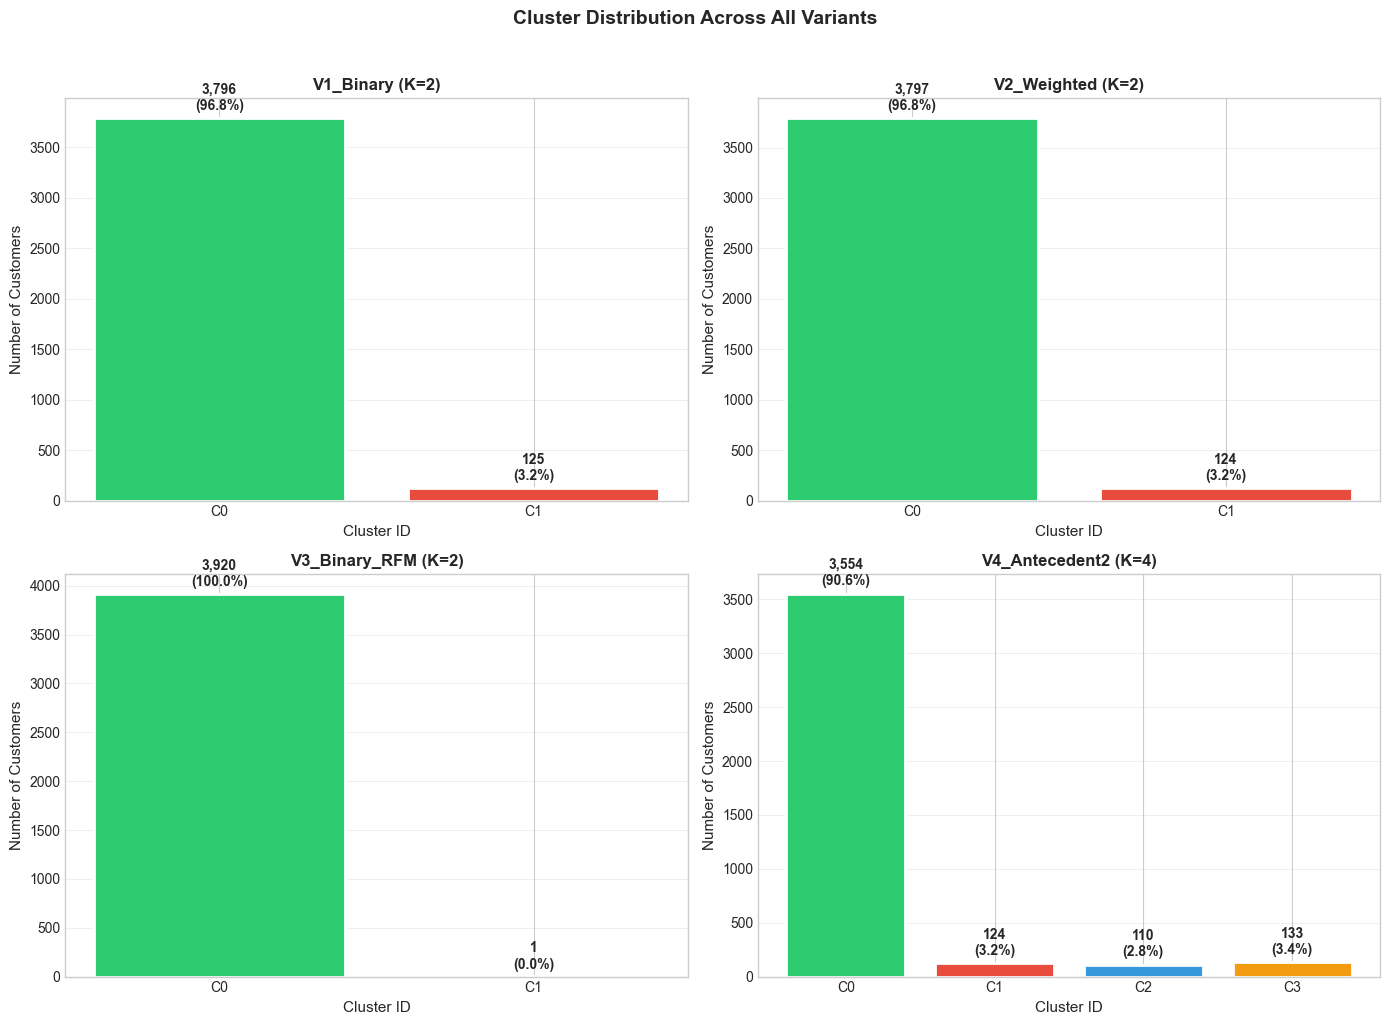


Đã lưu biểu đồ: images/Req6_ClusterDistribution.png


In [48]:
# =============================================================================
# 6.2. CLUSTER DISTRIBUTION STATISTICS
# =============================================================================
# Thống kê phân bố khách hàng theo cụm cho tất cả variants

print("="*70)
print("THỐNG KÊ PHÂN BỐ KHÁCH HÀNG THEO CỤM")
print("="*70)

# Tạo bảng thống kê cho mỗi variant
distribution_stats = []

for variant, df in master_data.items():
    cluster_col = 'Cluster'
    if cluster_col not in df.columns:
        # Tìm cột cluster
        cluster_cols = [c for c in df.columns if 'cluster' in c.lower()]
        if cluster_cols:
            cluster_col = cluster_cols[0]
    
    # Thống kê theo cụm
    cluster_counts = df[cluster_col].value_counts().sort_index()
    total = len(df)
    
    print(f"\n{variant} (K={VARIANTS_CONFIG[variant]['k']}):")
    print("-" * 50)
    
    for cluster_id, count in cluster_counts.items():
        pct = count / total * 100
        print(f"   Cluster {cluster_id}: {count:,} khách ({pct:.1f}%)")
        distribution_stats.append({
            'Variant': variant,
            'Cluster': cluster_id,
            'Count': count,
            'Percentage': pct
        })

# Tạo DataFrame tổng hợp
df_distribution = pd.DataFrame(distribution_stats)
print("\n" + "="*70)
print("BẢNG TỔNG HỢP PHÂN BỐ CỤM:")
print("-" * 70)
display(df_distribution)

# Vẽ biểu đồ phân bố cụm cho 4 variants
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors_palette = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6']

for idx, (variant, df) in enumerate(master_data.items()):
    ax = axes[idx]
    
    cluster_col = 'Cluster'
    if cluster_col not in df.columns:
        cluster_cols = [c for c in df.columns if 'cluster' in c.lower()]
        if cluster_cols:
            cluster_col = cluster_cols[0]
    
    cluster_counts = df[cluster_col].value_counts().sort_index()
    k = len(cluster_counts)
    
    # Bar chart
    bars = ax.bar(range(k), cluster_counts.values, color=colors_palette[:k], edgecolor='white', linewidth=2)
    
    # Thêm labels
    for bar, count in zip(bars, cluster_counts.values):
        pct = count / len(df) * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Cluster ID', fontsize=11)
    ax.set_ylabel('Number of Customers', fontsize=11)
    ax.set_title(f'{variant} (K={k})', fontsize=12, fontweight='bold')
    ax.set_xticks(range(k))
    ax.set_xticklabels([f'C{i}' for i in range(k)])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Cluster Distribution Across All Variants', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/Req6_ClusterDistribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nĐã lưu biểu đồ: images/Req6_ClusterDistribution.png")

### 6.3. RFM Analysis by Cluster

In [49]:
# =============================================================================
# 6.3. RFM ANALYSIS BY CLUSTER
# =============================================================================
# Phân tích Recency, Frequency, Monetary theo từng cụm

print("="*70)
print("PHÂN TÍCH RFM THEO CỤM")
print("="*70)

# Tính RFM stats cho mỗi cluster của mỗi variant
rfm_stats_all = []

for variant, df in master_data.items():
    cluster_col = 'Cluster'
    if cluster_col not in df.columns:
        cluster_cols = [c for c in df.columns if 'cluster' in c.lower()]
        if cluster_cols:
            cluster_col = cluster_cols[0]
    
    print(f"\n{variant}:")
    print("-" * 60)
    
    # Group by cluster và tính stats
    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_df = df[df[cluster_col] == cluster_id]
        n_customers = len(cluster_df)
        
        # Tính RFM nếu có
        if 'Recency' in df.columns:
            r_mean = cluster_df['Recency'].mean()
            r_median = cluster_df['Recency'].median()
            f_mean = cluster_df['Frequency'].mean()
            f_median = cluster_df['Frequency'].median()
            m_mean = cluster_df['Monetary'].mean()
            m_median = cluster_df['Monetary'].median()
            
            print(f"   Cluster {cluster_id} ({n_customers:,} customers):")
            print(f"      Recency:   Mean={r_mean:.1f}, Median={r_median:.0f} days")
            print(f"      Frequency: Mean={f_mean:.1f}, Median={f_median:.0f} orders")
            print(f"      Monetary:  Mean={m_mean:,.0f}, Median={m_median:,.0f} GBP")
            
            rfm_stats_all.append({
                'Variant': variant,
                'Cluster': cluster_id,
                'N_Customers': n_customers,
                'R_Mean': r_mean,
                'R_Median': r_median,
                'F_Mean': f_mean,
                'F_Median': f_median,
                'M_Mean': m_mean,
                'M_Median': m_median
            })
        else:
            print(f"   Cluster {cluster_id}: {n_customers:,} customers (no RFM data)")

# Tạo DataFrame RFM stats
df_rfm_stats = pd.DataFrame(rfm_stats_all)

print("\n" + "="*70)
print("BẢNG TỔNG HỢP RFM THEO CỤM:")
print("-" * 70)
display(df_rfm_stats.round(2))

# Lưu ra file
rfm_stats_file = '../data/mini_project/cluster_rfm_stats.csv'
df_rfm_stats.to_csv(rfm_stats_file, index=False)
print(f"\nĐã lưu: {rfm_stats_file}")

PHÂN TÍCH RFM THEO CỤM

V1_Binary:
------------------------------------------------------------
   Cluster 0 (3,796 customers):
      Recency:   Mean=93.2, Median=51 days
      Frequency: Mean=4.1, Median=2 orders
      Monetary:  Mean=1,810, Median=630 GBP
   Cluster 1 (125 customers):
      Recency:   Mean=60.5, Median=26 days
      Frequency: Mean=21.2, Median=5 orders
      Monetary:  Mean=17,250, Median=1,653 GBP

V2_Weighted:
------------------------------------------------------------
   Cluster 0 (3,797 customers):
      Recency:   Mean=93.2, Median=51 days
      Frequency: Mean=4.1, Median=2 orders
      Monetary:  Mean=1,810, Median=631 GBP
   Cluster 1 (124 customers):
      Recency:   Mean=60.5, Median=26 days
      Frequency: Mean=21.3, Median=5 orders
      Monetary:  Mean=17,366, Median=1,638 GBP

V3_Binary_RFM:
------------------------------------------------------------
   Cluster 0 (3,920 customers):
      Recency:   Mean=92.2, Median=51 days
      Frequency: Mean=4.2

,Variant,Cluster,N_Customers,R_Mean,R_Median,F_Mean,F_Median,M_Mean,M_Median
0,V1_Binary,0,3796,93.23,51.0,4.05,2.0,1809.51,630.08
1,V1_Binary,1,125,60.47,26.0,21.18,5.0,17250.49,1652.58
2,V2_Weighted,0,3797,93.22,51.0,4.05,2.0,1809.82,630.84
3,V2_Weighted,1,124,60.54,25.5,21.30,5.0,17365.53,1638.40
4,V3_Binary_RFM,0,3920,92.21,51.0,4.25,2.0,1864.39,652.28
5,V3_Binary_RFM,1,1,1.00,1.0,1373.00,1373.0,1716830.53,1716830.53
6,V4_Antecedent2,0,3554,97.34,55.0,3.81,2.0,1706.03,600.07
7,V4_Antecedent2,1,124,60.54,25.5,21.30,5.0,17365.53,1638.40
8,V4_Antecedent2,2,110,41.06,16.5,7.95,5.0,3696.38,1994.58
9,V4_Antecedent2,3,133,26.35,18.0,7.18,5.0,3022.95,1535.53



Đã lưu: ../data/mini_project/cluster_rfm_stats.csv


VẼ BIỂU ĐỒ RFM THEO CỤM


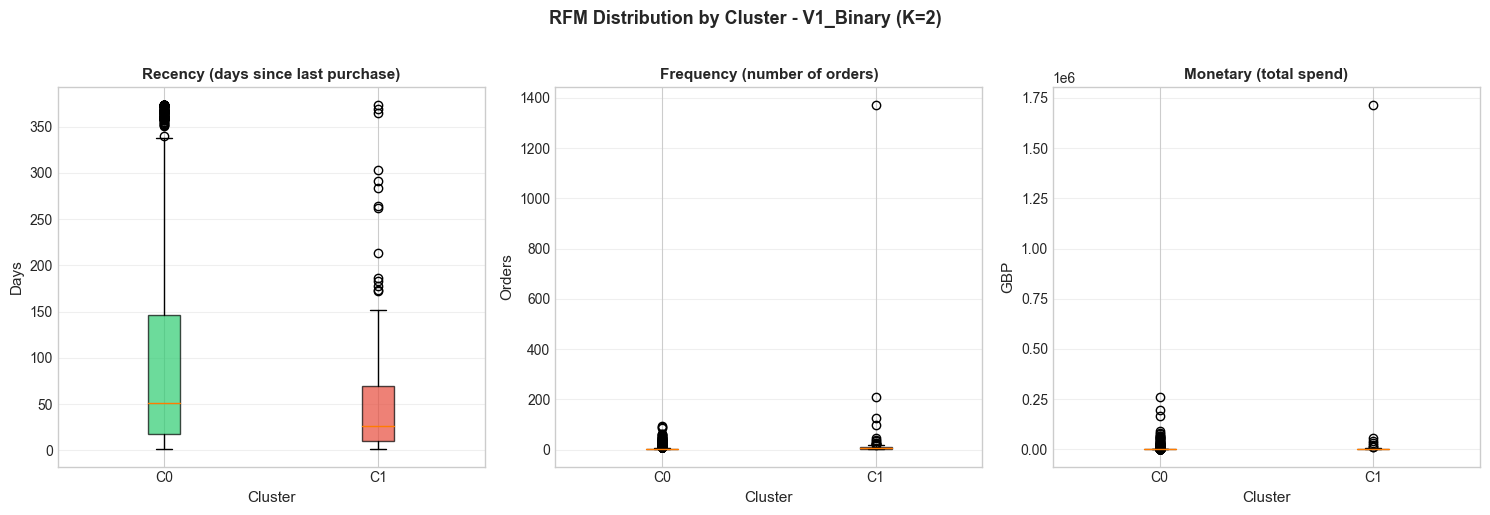

   Đã lưu: ../images/Req6_RFMByCluster_V1_Binary.png


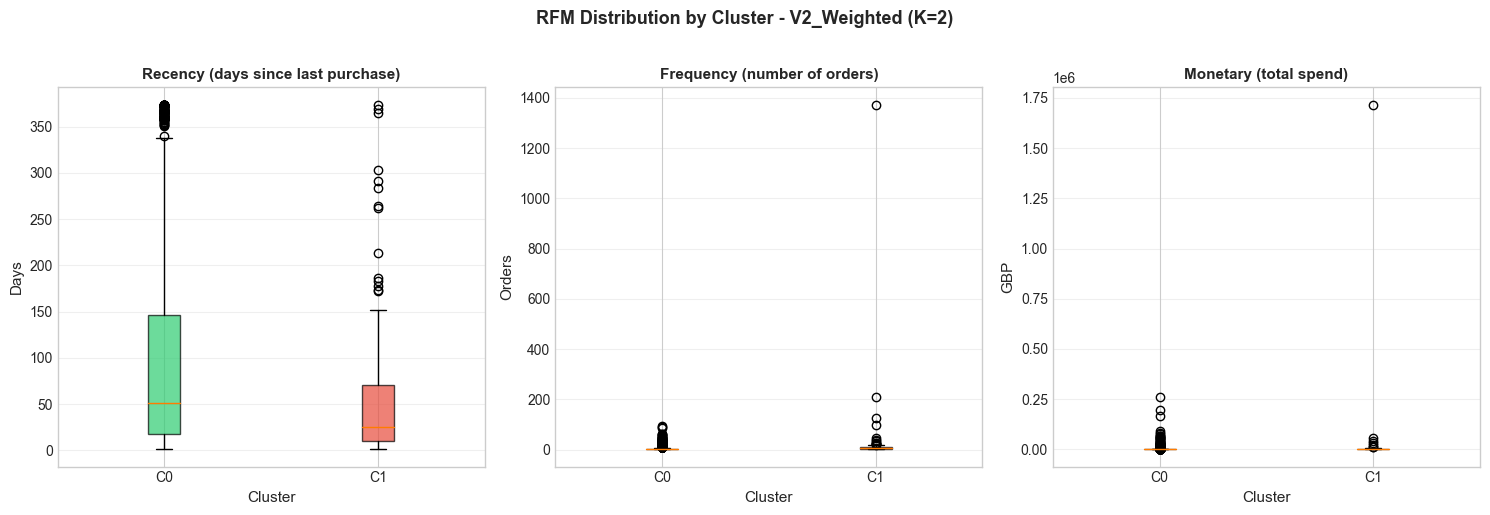

   Đã lưu: ../images/Req6_RFMByCluster_V2_Weighted.png


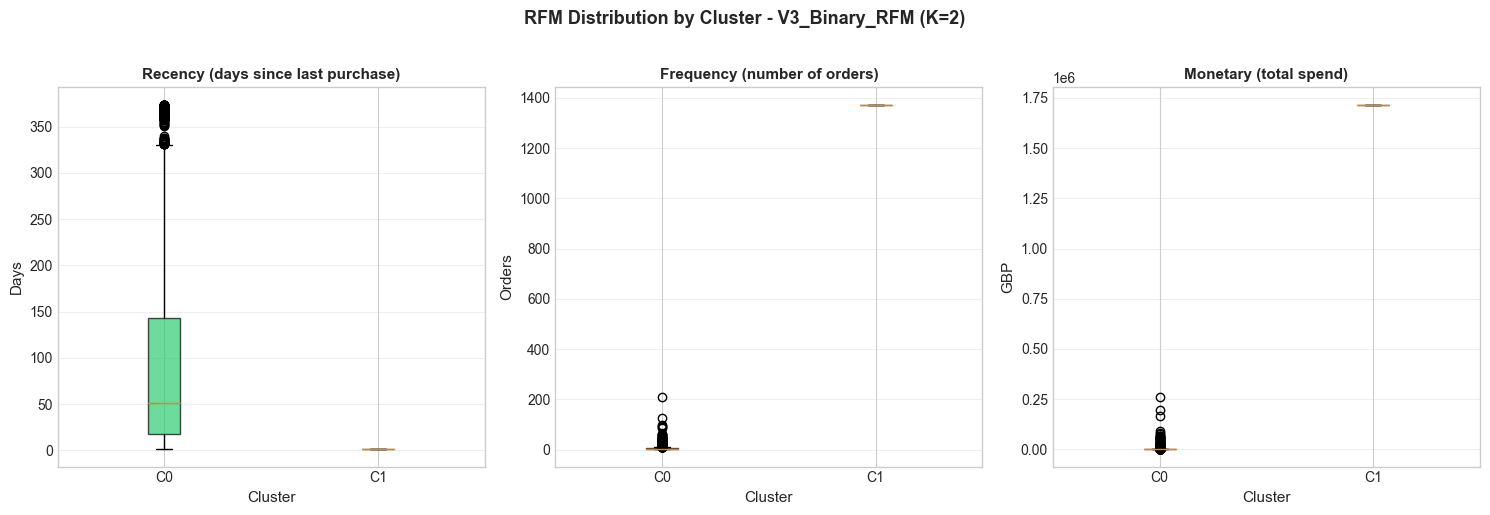

   Đã lưu: ../images/Req6_RFMByCluster_V3_Binary_RFM.png


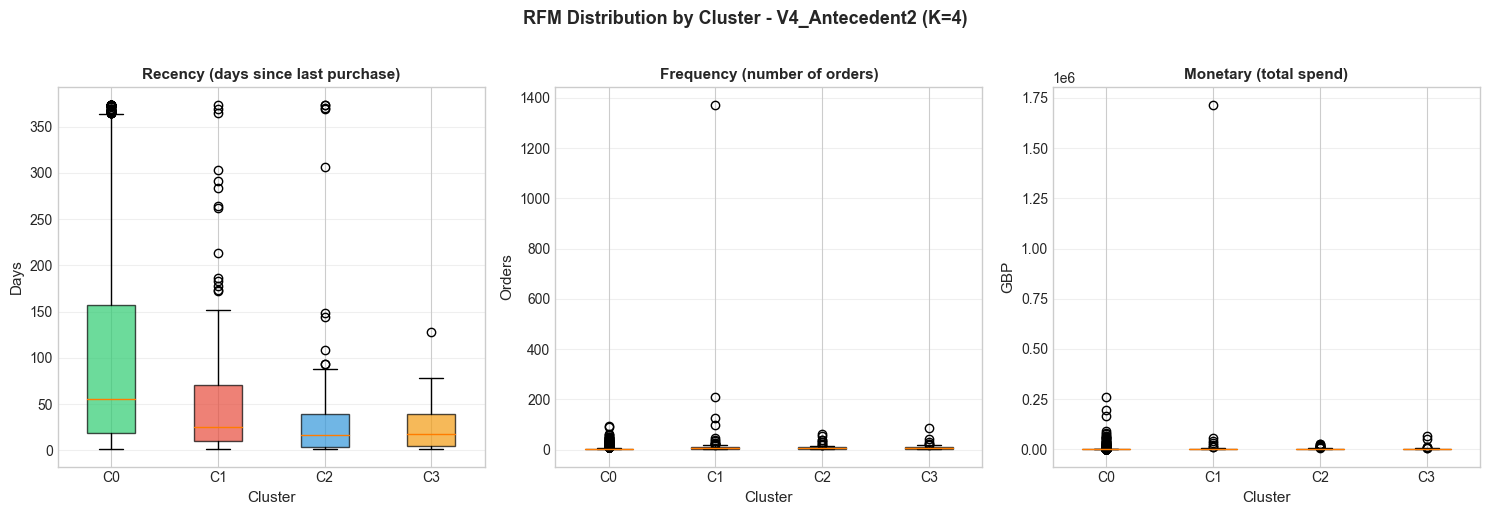

   Đã lưu: ../images/Req6_RFMByCluster_V4_Antecedent2.png

Hoàn thành vẽ biểu đồ RFM!


In [50]:
# =============================================================================
# 6.3.2. VẼ BIỂU ĐỒ RFM BOX PLOT THEO CỤM
# =============================================================================
# Vẽ box plot RFM cho từng variant

print("="*70)
print("VẼ BIỂU ĐỒ RFM THEO CỤM")
print("="*70)

# Vẽ cho từng variant
for variant, df in master_data.items():
    cluster_col = 'Cluster'
    if cluster_col not in df.columns:
        cluster_cols = [c for c in df.columns if 'cluster' in c.lower()]
        if cluster_cols:
            cluster_col = cluster_cols[0]
    
    if 'Recency' not in df.columns:
        print(f"   {variant}: Không có RFM data, bỏ qua")
        continue
    
    k = df[cluster_col].nunique()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    colors_box = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6'][:k]
    
    # Recency
    box_data_r = [df[df[cluster_col] == c]['Recency'].values for c in sorted(df[cluster_col].unique())]
    bp1 = axes[0].boxplot(box_data_r, patch_artist=True, labels=[f'C{c}' for c in sorted(df[cluster_col].unique())])
    for patch, color in zip(bp1['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[0].set_xlabel('Cluster', fontsize=11)
    axes[0].set_ylabel('Days', fontsize=11)
    axes[0].set_title('Recency (days since last purchase)', fontsize=11, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Frequency
    box_data_f = [df[df[cluster_col] == c]['Frequency'].values for c in sorted(df[cluster_col].unique())]
    bp2 = axes[1].boxplot(box_data_f, patch_artist=True, labels=[f'C{c}' for c in sorted(df[cluster_col].unique())])
    for patch, color in zip(bp2['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[1].set_xlabel('Cluster', fontsize=11)
    axes[1].set_ylabel('Orders', fontsize=11)
    axes[1].set_title('Frequency (number of orders)', fontsize=11, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Monetary
    box_data_m = [df[df[cluster_col] == c]['Monetary'].values for c in sorted(df[cluster_col].unique())]
    bp3 = axes[2].boxplot(box_data_m, patch_artist=True, labels=[f'C{c}' for c in sorted(df[cluster_col].unique())])
    for patch, color in zip(bp3['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[2].set_xlabel('Cluster', fontsize=11)
    axes[2].set_ylabel('GBP', fontsize=11)
    axes[2].set_title('Monetary (total spend)', fontsize=11, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'RFM Distribution by Cluster - {variant} (K={k})', fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Lưu biểu đồ
    output_file = f'../images/Req6_RFMByCluster_{variant}.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"   Đã lưu: {output_file}")

print("\nHoàn thành vẽ biểu đồ RFM!")

### 6.4. Rule Activation Analysis by Cluster

In [51]:
# =============================================================================
# 6.4. RULE ACTIVATION ANALYSIS BY CLUSTER
# =============================================================================
# Phân tích Top Rules được kích hoạt nhiều nhất trong mỗi cụm

print("="*70)
print("PHÂN TÍCH RULE ACTIVATION THEO CỤM")
print("="*70)

# Hàm tìm top rules cho mỗi cluster
def get_top_rules_per_cluster(df_feature, df_cluster, rules_df, cluster_col='Cluster', top_n=10):
    """Tìm top N rules được kích hoạt nhiều nhất trong mỗi cluster"""
    results = []
    
    # Lấy tên các cột rule (loại bỏ CustomerID và các cột không phải rule)
    rule_cols = [c for c in df_feature.columns if c not in ['CustomerID', 'Recency', 'Frequency', 'Monetary', 
                                                             'Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']]
    
    # Merge feature matrix với cluster labels
    df_merged = df_feature.merge(df_cluster[['CustomerID', cluster_col]], on='CustomerID', how='inner')
    
    for cluster_id in sorted(df_merged[cluster_col].unique()):
        cluster_data = df_merged[df_merged[cluster_col] == cluster_id]
        n_customers = len(cluster_data)
        
        # Tính activation rate cho mỗi rule trong cluster này
        activation_rates = []
        for rule_col in rule_cols:
            # Đếm số khách kích hoạt rule (giá trị > 0)
            activated = (cluster_data[rule_col] > 0).sum()
            rate = activated / n_customers * 100 if n_customers > 0 else 0
            activation_rates.append({
                'rule_col': rule_col,
                'activated': activated,
                'rate': rate
            })
        
        # Sắp xếp và lấy top N
        activation_rates.sort(key=lambda x: x['rate'], reverse=True)
        top_rules = activation_rates[:top_n]
        
        for rank, rule_info in enumerate(top_rules, 1):
            results.append({
                'Cluster': cluster_id,
                'Rank': rank,
                'Rule_Col': rule_info['rule_col'],
                'Activated': rule_info['activated'],
                'Rate%': rule_info['rate']
            })
    
    return pd.DataFrame(results)

# Phân tích cho từng variant
top_rules_all = {}

for variant in ['V1_Binary', 'V4_Antecedent2']:  # Chỉ phân tích V1 và V4 (đại diện)
    if variant not in feature_matrices or variant not in cluster_data_all:
        continue
    
    df_feature = feature_matrices[variant]
    df_cluster = cluster_data_all[variant]
    
    cluster_col = 'Cluster'
    if cluster_col not in df_cluster.columns:
        cluster_cols = [c for c in df_cluster.columns if 'cluster' in c.lower()]
        if cluster_cols:
            cluster_col = cluster_cols[0]
    
    print(f"\n{variant}:")
    print("-" * 60)
    
    top_rules_df = get_top_rules_per_cluster(df_feature, df_cluster, rules_data, cluster_col, top_n=10)
    top_rules_all[variant] = top_rules_df
    
    # Hiển thị top 10 rules cho mỗi cluster (theo yêu cầu đề bài)
    for cluster_id in sorted(top_rules_df['Cluster'].unique()):
        cluster_rules = top_rules_df[top_rules_df['Cluster'] == cluster_id].head(10)
        print(f"\n   Cluster {cluster_id} - Top 10 Rules:")
        for _, row in cluster_rules.iterrows():
            print(f"      {row['Rank']:2d}. {row['Rule_Col'][:45]}... ({row['Rate%']:5.1f}%)")

print("\n" + "="*70)
print("Đã hiển thị Top 10 Rules cho mỗi cụm theo yêu cầu đề bài.")

PHÂN TÍCH RULE ACTIVATION THEO CỤM

V1_Binary:
------------------------------------------------------------

   Cluster 0 - Top 10 Rules:
       1. rule_137... (  7.9%)
       2. rule_144... (  7.9%)
       3. rule_105... (  7.7%)
       4. rule_138... (  7.7%)
       5. rule_168... (  7.0%)
       6. rule_186... (  7.0%)
       7. rule_136... (  6.7%)
       8. rule_150... (  6.7%)
       9. rule_152... (  6.7%)
      10. rule_133... (  6.1%)

   Cluster 1 - Top 10 Rules:
       1. rule_12... ( 96.8%)
       2. rule_13... ( 96.8%)
       3. rule_22... ( 96.8%)
       4. rule_24... ( 96.8%)
       5. rule_27... ( 96.8%)
       6. rule_32... ( 96.8%)
       7. rule_45... ( 96.8%)
       8. rule_50... ( 96.8%)
       9. rule_52... ( 96.8%)
      10. rule_56... ( 96.8%)

V4_Antecedent2:
------------------------------------------------------------

   Cluster 0 - Top 10 Rules:
       1. rule_53... (  3.5%)
       2. rule_39... (  2.3%)
       3. rule_63... (  1.7%)
       4. rule_58... (  

VẼ HEATMAP RULE ACTIVATION


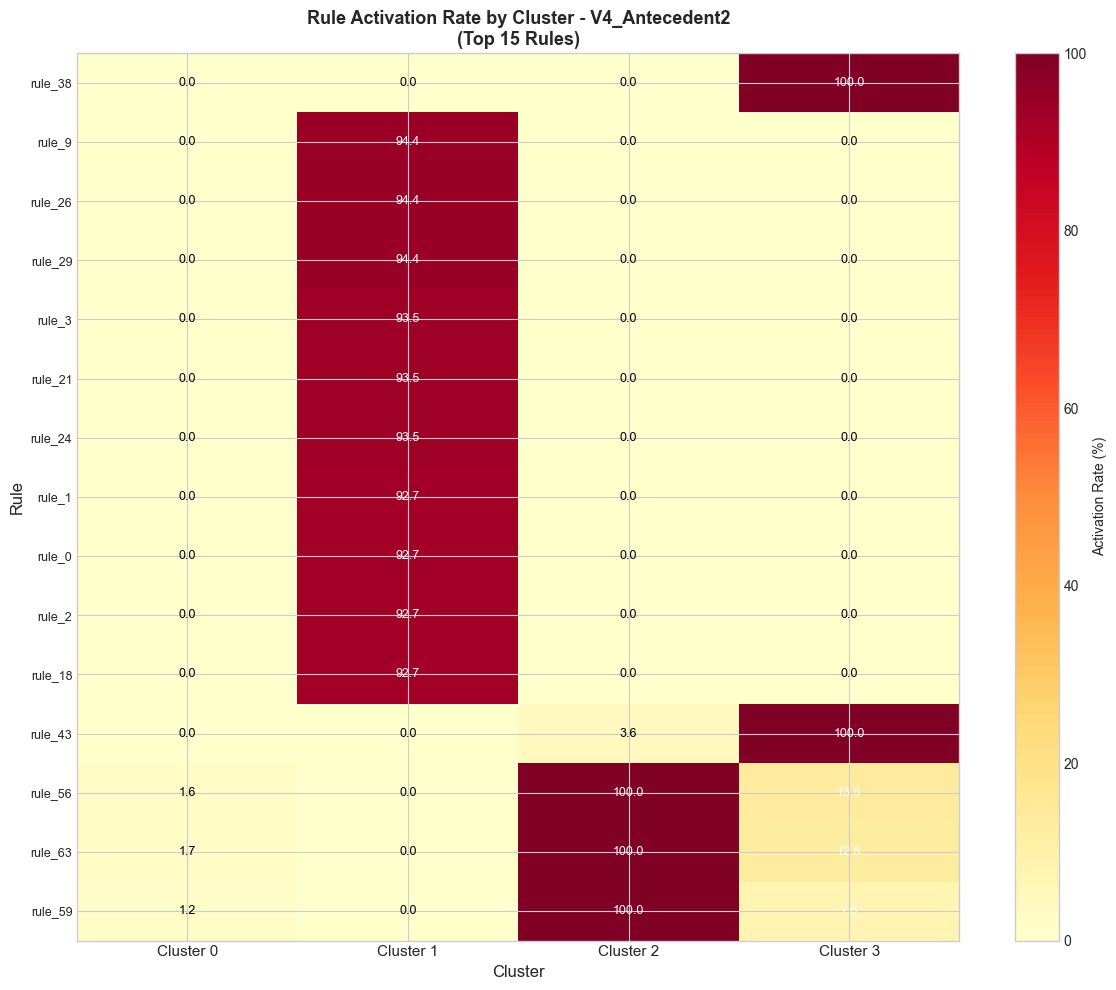


Đã lưu: images/Req6_RuleActivationHeatmap.png


In [52]:
# =============================================================================
# 6.4.2. VẼ HEATMAP RULE ACTIVATION
# =============================================================================
# Vẽ heatmap thể hiện activation rate của top rules theo cluster

print("="*70)
print("VẼ HEATMAP RULE ACTIVATION")
print("="*70)

# Vẽ cho V4 (4 clusters) - variant có nhiều cụm nhất
variant = 'V4_Antecedent2'

if variant in top_rules_all:
    df_rules = top_rules_all[variant]
    
    # Lấy top 15 rules (có activation rate cao nhất overall)
    overall_top = df_rules.groupby('Rule_Col')['Rate%'].mean().sort_values(ascending=False).head(15)
    top_rule_cols = overall_top.index.tolist()
    
    # Tạo pivot table cho heatmap
    heatmap_df = df_rules[df_rules['Rule_Col'].isin(top_rule_cols)].pivot_table(
        index='Rule_Col', 
        columns='Cluster', 
        values='Rate%',
        aggfunc='first'
    ).fillna(0)
    
    # Sắp xếp theo overall activation
    heatmap_df = heatmap_df.loc[top_rule_cols]
    
    # Rút gọn tên rule để hiển thị
    short_names = [name[:40] + '...' if len(name) > 40 else name for name in heatmap_df.index]
    
    # Vẽ heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    im = ax.imshow(heatmap_df.values, cmap='YlOrRd', aspect='auto')
    
    # Thêm colorbar
    cbar = plt.colorbar(im, ax=ax, label='Activation Rate (%)')
    
    # Thêm labels
    ax.set_xticks(range(len(heatmap_df.columns)))
    ax.set_xticklabels([f'Cluster {c}' for c in heatmap_df.columns], fontsize=11)
    ax.set_yticks(range(len(short_names)))
    ax.set_yticklabels(short_names, fontsize=9)
    
    # Thêm giá trị vào mỗi ô
    for i in range(len(heatmap_df.index)):
        for j in range(len(heatmap_df.columns)):
            val = heatmap_df.iloc[i, j]
            color = 'white' if val > 5 else 'black'
            ax.text(j, i, f'{val:.1f}', ha='center', va='center', color=color, fontsize=9)
    
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Rule', fontsize=12)
    ax.set_title(f'Rule Activation Rate by Cluster - {variant}\n(Top 15 Rules)', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../images/Req6_RuleActivationHeatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"\nĐã lưu: images/Req6_RuleActivationHeatmap.png")
else:
    print(f"Không có dữ liệu top rules cho {variant}")

### 6.5. Cluster Naming and Persona Description

In [53]:
# =============================================================================
# 6.5. CLUSTER NAMING AND PERSONA DESCRIPTION (IMPROVED VERSION)
# =============================================================================
# Đặt tên và mô tả persona cho từng cụm dựa trên RFM và Rule patterns
# CẢI TIẾN: Phân biệt rõ các cluster dựa trên đặc điểm RFM riêng biệt

print("="*70)
print("ĐẶT TÊN VÀ MÔ TẢ PERSONA CHO TỪNG CỤM (IMPROVED)")
print("="*70)

# Hàm phân loại RFM segment
def classify_rfm(r_mean, f_mean, m_mean, r_median_all, f_median_all, m_median_all):
    """Phân loại khách hàng dựa trên RFM so với median toàn bộ"""
    r_level = 'Low' if r_mean > r_median_all else 'High'  # Recency thấp = tốt
    f_level = 'High' if f_mean > f_median_all else 'Low'
    m_level = 'High' if m_mean > m_median_all else 'Low'
    return r_level, f_level, m_level

# Tính median toàn bộ từ RFM data
if rfm_data is not None:
    r_median_all = rfm_data['Recency'].median()
    f_median_all = rfm_data['Frequency'].median()
    m_median_all = rfm_data['Monetary'].median()
    print(f"Baseline RFM (Median toàn bộ):")
    print(f"   Recency: {r_median_all:.0f} ngày")
    print(f"   Frequency: {f_median_all:.0f} đơn hàng")
    print(f"   Monetary: {m_median_all:,.0f} GBP")

# Tạo cluster profiles dựa trên phân tích
cluster_profiles = []

# Profile cho V4_Antecedent2 (variant khuyến nghị với 4 clusters)
print("\n" + "="*70)
print("CLUSTER PROFILES - V4_Antecedent2 (K=4)")
print("="*70)

# Lấy RFM stats cho V4
v4_rfm = df_rfm_stats[df_rfm_stats['Variant'] == 'V4_Antecedent2'].copy()

if len(v4_rfm) > 0:
    # Sắp xếp theo M_Mean để xác định rank
    v4_rfm = v4_rfm.sort_values('M_Mean', ascending=False).reset_index(drop=True)
    
    # Tìm cluster có M cao nhất (Champion), thấp nhất (Mainstream)
    max_m_cluster = v4_rfm.iloc[0]['Cluster']
    max_f_cluster = v4_rfm.sort_values('F_Mean', ascending=False).iloc[0]['Cluster']
    min_r_cluster = v4_rfm.sort_values('R_Mean', ascending=True).iloc[0]['Cluster']  # R thấp = mới mua
    max_r_cluster = v4_rfm.sort_values('R_Mean', ascending=False).iloc[0]['Cluster']  # R cao = lâu không mua
    
    print(f"\n[Phân tích RFM Ranking]")
    print(f"   Cluster có M cao nhất: Cluster {int(max_m_cluster)}")
    print(f"   Cluster có F cao nhất: Cluster {int(max_f_cluster)}")
    print(f"   Cluster mua gần nhất (R thấp): Cluster {int(min_r_cluster)}")
    print(f"   Cluster lâu không mua (R cao): Cluster {int(max_r_cluster)}")
    
    # Sắp xếp lại theo cluster ID để hiển thị
    v4_rfm = v4_rfm.sort_values('Cluster').reset_index(drop=True)
    
    for _, row in v4_rfm.iterrows():
        cluster_id = int(row['Cluster'])
        n_customers = int(row['N_Customers'])
        r_mean = row['R_Mean']
        f_mean = row['F_Mean']
        m_mean = row['M_Mean']
        pct = n_customers / v4_rfm['N_Customers'].sum() * 100
        
        # Phân loại RFM
        r_level, f_level, m_level = classify_rfm(r_mean, f_mean, m_mean, 
                                                   r_median_all, f_median_all, m_median_all)
        
        # Tạo số thứ tự 2 chữ số
        cluster_num = f"{cluster_id:02d}"
        
        # ĐẶT TÊN DỰA TRÊN ĐẶC ĐIỂM CỤ THỂ CỦA TỪNG CLUSTER
        # Sử dụng ranking và giá trị thực tế để phân biệt
        
        if pct > 50:  # Cluster chiếm đa số (Mainstream)
            name_en = f"Mainstream Casual Buyers {cluster_num}"
            name_vn = f"Khách Mua Sắm Thông Thường {cluster_num}"
            persona = f"Khách hàng đại trà chiếm {pct:.0f}% với R={r_mean:.0f}d, F={f_mean:.1f} đơn, M={m_mean:,.0f} GBP"
            segment_type = "Mainstream"
            
        elif cluster_id == max_m_cluster and m_mean > 10000:  # Super VIP - M cực cao
            name_en = f"Champion Super VIP {cluster_num}"
            name_vn = f"Siêu VIP Hàng Đầu {cluster_num}"
            persona = f"Top spender với M={m_mean:,.0f} GBP (gấp {m_mean/m_median_all:.0f}x TB), F={f_mean:.1f} đơn"
            segment_type = "Champion"
            
        elif r_mean < 30 and f_mean > f_median_all:  # Recent Active - R rất thấp
            name_en = f"Recent Active Buyers {cluster_num}"
            name_vn = f"Khách Mua Gần Đây {cluster_num}"
            persona = f"Mua rất gần đây (R={r_mean:.0f}d), hoạt động tích cực với F={f_mean:.1f} đơn"
            segment_type = "Recent"
            
        elif f_mean > f_median_all * 1.5 and m_mean > m_median_all * 1.5:  # Loyal High-Value
            name_en = f"Loyal High-Value {cluster_num}"
            name_vn = f"Khách Trung Thành Giá Trị Cao {cluster_num}"
            persona = f"Khách trung thành với F={f_mean:.1f} đơn, chi tiêu cao M={m_mean:,.0f} GBP"
            segment_type = "Loyal"
            
        elif r_mean > r_median_all * 1.5:  # At-Risk / Dormant - R cao
            name_en = f"At-Risk Dormant {cluster_num}"
            name_vn = f"Khách Có Nguy Cơ Rời Bỏ {cluster_num}"
            persona = f"Lâu không quay lại (R={r_mean:.0f}d), cần chiến dịch win-back"
            segment_type = "AtRisk"
            
        elif m_mean > m_median_all * 2:  # High Spender nhưng không phải Champion
            name_en = f"Rising Star Spender {cluster_num}"
            name_vn = f"Ngôi Sao Đang Lên {cluster_num}"
            persona = f"Chi tiêu cao M={m_mean:,.0f} GBP, tiềm năng phát triển thành VIP"
            segment_type = "Rising"
            
        else:  # Niche / Other
            name_en = f"Niche Interest Group {cluster_num}"
            name_vn = f"Nhóm Sở Thích Đặc Biệt {cluster_num}"
            persona = f"Nhóm đặc thù với hành vi mua kèm riêng biệt, R={r_mean:.0f}d, F={f_mean:.1f}, M={m_mean:,.0f}"
            segment_type = "Niche"
        
        profile = {
            'Variant': 'V4_Antecedent2',
            'Cluster': cluster_id,
            'Name_EN': name_en,
            'Name_VN': name_vn,
            'N_Customers': n_customers,
            'Pct': pct,
            'R_Mean': r_mean,
            'F_Mean': f_mean,
            'M_Mean': m_mean,
            'R_Level': r_level,
            'F_Level': f_level,
            'M_Level': m_level,
            'Segment_Type': segment_type,
            'Persona': persona
        }
        cluster_profiles.append(profile)
        
        print(f"\n{'='*60}")
        print(f"CLUSTER {cluster_id}: {name_en}")
        print(f"                {name_vn}")
        print(f"{'='*60}")
        print(f"   Số khách: {n_customers:,} ({pct:.1f}%)")
        print(f"   RFM Profile:")
        print(f"      - Recency: {r_mean:.0f} ngày ({r_level} - {'Mới mua' if r_level=='High' else 'Lâu rồi'})")
        print(f"      - Frequency: {f_mean:.1f} đơn ({f_level} - {'Thường xuyên' if f_level=='High' else 'Ít mua'})")
        print(f"      - Monetary: {m_mean:,.0f} GBP ({m_level} - {'Chi tiêu cao' if m_level=='High' else 'Chi tiêu thấp'})")
        print(f"   Segment Type: {segment_type}")
        print(f"   Persona: {persona}")

# Tạo DataFrame profiles
df_profiles = pd.DataFrame(cluster_profiles)
print("\n" + "="*70)
print("BẢNG TỔNG HỢP CLUSTER PROFILES:")
display(df_profiles[['Cluster', 'Name_EN', 'Name_VN', 'N_Customers', 'Pct', 'Segment_Type', 'Persona']])

ĐẶT TÊN VÀ MÔ TẢ PERSONA CHO TỪNG CỤM (IMPROVED)
Baseline RFM (Median toàn bộ):
   Recency: 51 ngày
   Frequency: 2 đơn hàng
   Monetary: 653 GBP

CLUSTER PROFILES - V4_Antecedent2 (K=4)

[Phân tích RFM Ranking]
   Cluster có M cao nhất: Cluster 1
   Cluster có F cao nhất: Cluster 1
   Cluster mua gần nhất (R thấp): Cluster 3
   Cluster lâu không mua (R cao): Cluster 0

CLUSTER 0: Mainstream Casual Buyers 00
                Khách Mua Sắm Thông Thường 00
   Số khách: 3,554 (90.6%)
   RFM Profile:
      - Recency: 97 ngày (Low - Lâu rồi)
      - Frequency: 3.8 đơn (High - Thường xuyên)
      - Monetary: 1,706 GBP (High - Chi tiêu cao)
   Segment Type: Mainstream
   Persona: Khách hàng đại trà chiếm 91% với R=97d, F=3.8 đơn, M=1,706 GBP

CLUSTER 1: Champion Super VIP 01
                Siêu VIP Hàng Đầu 01
   Số khách: 124 (3.2%)
   RFM Profile:
      - Recency: 61 ngày (Low - Lâu rồi)
      - Frequency: 21.3 đơn (High - Thường xuyên)
      - Monetary: 17,366 GBP (High - Chi tiêu cao)
   

,Cluster,Name_EN,Name_VN,N_Customers,Pct,Segment_Type,Persona
0,0,Mainstream Casual Buyers 00,Khách Mua Sắm Thông Thường 00,3554,90.640143,Mainstream,"Khách hàng đại trà chiếm 91% với R=97d, F=3.8 ..."
1,1,Champion Super VIP 01,Siêu VIP Hàng Đầu 01,124,3.162459,Champion,"Top spender với M=17,366 GBP (gấp 27x TB), F=2..."
2,2,Loyal High-Value 02,Khách Trung Thành Giá Trị Cao 02,110,2.805407,Loyal,"Khách trung thành với F=7.9 đơn, chi tiêu cao ..."
3,3,Recent Active Buyers 03,Khách Mua Gần Đây 03,133,3.391992,Recent,"Mua rất gần đây (R=26d), hoạt động tích cực vớ..."


### 6.6. Marketing Strategy Recommendations

In [54]:
# =============================================================================
# 6.6. MARKETING STRATEGY RECOMMENDATIONS (IMPROVED VERSION)
# =============================================================================
# Đề xuất chiến lược marketing CỤ THỂ cho từng cụm - liên hệ trực tiếp với đặc trưng cụm

print("="*70)
print("CHIẾN LƯỢC MARKETING CỤ THỂ CHO TỪNG CỤM (IMPROVED)")
print("="*70)

# Định nghĩa chiến lược marketing dựa trên đặc điểm cụm VÀ luật kết hợp
marketing_strategies = []

# Lấy top rules cho V4 để đề xuất sản phẩm cụ thể
v4_top_rules = top_rules_all.get('V4_Antecedent2', pd.DataFrame())

# Lấy thông tin luật gốc để tạo bundle recommendation
if rules_data is not None and len(rules_data) > 0:
    rules_lookup = rules_data.copy()
else:
    rules_lookup = pd.DataFrame()

print("\n[Tạo chiến lược marketing dựa trên Segment Type và luật kết hợp]")

for profile in cluster_profiles:
    cluster_id = profile['Cluster']
    name_en = profile['Name_EN']
    name_vn = profile['Name_VN']
    segment_type = profile.get('Segment_Type', 'Unknown')
    r_mean = profile['R_Mean']
    f_mean = profile['F_Mean']
    m_mean = profile['M_Mean']
    pct = profile['Pct']
    
    # Lấy top rules của cluster này để tạo recommendation cụ thể
    cluster_rules = v4_top_rules[v4_top_rules['Cluster'] == cluster_id].head(5)
    top_products = cluster_rules['Rule_Col'].tolist() if len(cluster_rules) > 0 else []
    
    # Tạo bundle recommendation dựa trên luật kết hợp THỰC TẾ
    bundle_recommendation = []
    bundle_details = []
    for rule_col in top_products[:5]:
        try:
            rule_idx = int(rule_col.replace('rule_', ''))
            if rule_idx < len(rules_data):
                rule = rules_data.iloc[rule_idx]
                ant = str(rule['antecedents']).replace('frozenset({', '').replace('})', '').replace("'", "")
                con = str(rule['consequents']).replace('frozenset({', '').replace('})', '').replace("'", "")
                lift = rule['lift']
                conf = rule['confidence']
                bundle_recommendation.append(f"{ant[:25]}... => {con[:25]}...")
                bundle_details.append({
                    'antecedent': ant[:40],
                    'consequent': con[:40],
                    'lift': lift,
                    'confidence': conf
                })
        except:
            continue
    
    # ============================================
    # CHIẾN LƯỢC CỤ THỂ THEO SEGMENT TYPE
    # ============================================
    
    if segment_type == "Mainstream":
        strategy_type = "Mass Cross-sell & Bundle Promotion"
        strategy_detail = f"Nhóm khách đại trà ({pct:.0f}%) với F={f_mean:.1f} đơn, M={m_mean:,.0f} GBP. " \
                         f"Áp dụng luật kết hợp phổ biến để tăng giỏ hàng trung bình."
        offer = "Combo 3 sản phẩm giảm 20% | Bundle theo luật kết hợp | Freeship đơn > 50 GBP | Flash sale cuối tuần"
        channel = "Email blast, Website homepage banner, Facebook Ads, Google Display"
        timing = "Thứ 5-CN hàng tuần | Dịp lễ | Black Friday | Tết"
        kpi = "Tăng AOV +15%, tăng conversion rate +5%"
        
    elif segment_type == "Champion":
        strategy_type = "VIP Exclusive & Luxury Experience"
        strategy_detail = f"TOP SPENDER với M={m_mean:,.0f} GBP (gấp {m_mean/m_median_all:.0f}x TB). " \
                         f"Cần chăm sóc đặc biệt, trải nghiệm luxury."
        offer = "VIP Card Platinum | Freeship trọn đời | Giảm 25% exclusive | Private sale | Quà tặng VIP đơn > 1000 GBP"
        channel = "Personal Account Manager, Private Email, SMS VIP Hotline, App VIP Zone"
        timing = "Cá nhân hóa theo lịch sử | Sinh nhật | Kỷ niệm thành viên | Pre-launch exclusive"
        kpi = "Retention rate 95%, tăng M +10%, referral program"
        
    elif segment_type == "Recent":
        strategy_type = "Engagement & Second Purchase Push"
        strategy_detail = f"Khách mua RẤT GẦN ĐÂY (R={r_mean:.0f} ngày). " \
                         f"Thời điểm vàng để push đơn thứ 2 và xây dựng loyalty."
        offer = "Giảm 15% đơn thứ 2 trong 7 ngày | Tích điểm x2 | Free gift đơn > 100 GBP | Review để nhận voucher"
        channel = "Post-purchase email series, App push notification, Retargeting Ads"
        timing = "Ngày 3 sau mua | Ngày 7 | Ngày 14 | Product recommendation"
        kpi = "Second purchase rate +20%, review rate +30%"
        
    elif segment_type == "Loyal":
        strategy_type = "Loyalty Program & Upsell Premium"
        strategy_detail = f"Khách TRUNG THÀNH với F={f_mean:.1f} đơn, M={m_mean:,.0f} GBP. " \
                         f"Tăng giá trị đơn hàng và chuyển đổi lên premium."
        offer = "Tích điểm x3 | Giảm 20% sản phẩm premium | Early access new arrival | Birthday double points"
        channel = "Loyalty app, Personalized email, In-app message, SMS reminder"
        timing = "Khi có sản phẩm mới | Trước ngày thường mua | Milestone rewards"
        kpi = "Upsell rate +25%, AOV +20%, referral +15%"
        
    elif segment_type == "AtRisk":
        strategy_type = "Win-back Reactivation Campaign"
        strategy_detail = f"CẢNH BÁO: Khách lâu không mua (R={r_mean:.0f} ngày). " \
                         f"Cần chiến dịch win-back gấp để tránh mất khách."
        offer = "COMEBACK: Giảm 35% đơn đầu quay lại | Freeship | Free gift | We miss you voucher"
        channel = "Re-engagement email series, Facebook/Google Remarketing, SMS win-back"
        timing = "Sau 45 ngày không mua | Reminder mỗi 2 tuần | Last chance offer"
        kpi = "Reactivation rate +15%, prevent churn -20%"
        
    elif segment_type == "Rising":
        strategy_type = "Nurturing to VIP & Premium Upsell"
        strategy_detail = f"NGÔI SAO ĐANG LÊN với M={m_mean:,.0f} GBP. " \
                         f"Tiềm năng lớn để phát triển thành VIP trong tương lai."
        offer = "VIP Preview: Giảm 20% đơn > 500 GBP | Tích điểm x2.5 | Invite-only sale | Premium sample"
        channel = "Personalized email journey, App exclusive offer, Direct call"
        timing = "Milestone spending | New premium product launch | VIP upgrade notification"
        kpi = "Upgrade to VIP rate +30%, spending increase +25%"
        
    else:  # Niche
        strategy_type = "Personalized Cross-sell by Interest"
        strategy_detail = f"Nhóm SỞ THÍCH ĐẶC BIỆT với pattern mua kèm riêng. " \
                         f"R={r_mean:.0f}d, F={f_mean:.1f}, M={m_mean:,.0f}."
        offer = "Giảm 15% sản phẩm gợi ý theo luật | Free sample category yêu thích | Bundle theo interest"
        channel = "AI recommendation email, Website personalization, Lookalike audience ads"
        timing = "Khi browse sản phẩm tương tự | After cart abandonment | Category sale"
        kpi = "Cross-sell rate +20%, category penetration +15%"
    
    # Tạo strategy record
    strategy = {
        'Cluster': cluster_id,
        'Name_EN': name_en,
        'Name_VN': name_vn,
        'Segment_Type': segment_type,
        'Strategy_Type': strategy_type,
        'Strategy_Detail': strategy_detail,
        'Offer': offer,
        'Channel': channel,
        'Timing': timing,
        'KPI_Target': kpi,
        'Top_Rules': ', '.join([p for p in top_products[:5]]) if top_products else 'N/A',
        'Bundle_From_Rules': ' | '.join(bundle_recommendation[:3]) if bundle_recommendation else 'N/A'
    }
    marketing_strategies.append(strategy)
    
    # In chi tiết
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}: {name_en}")
    print(f"            {name_vn}")
    print(f"{'='*70}")
    print(f"   Segment Type: {segment_type}")
    print(f"   Chiến lược: {strategy_type}")
    print(f"   ------------------------------------")
    print(f"   Chi tiết: {strategy_detail}")
    print(f"   ------------------------------------")
    print(f"   ƯU ĐÃI: {offer}")
    print(f"   KÊNH: {channel}")
    print(f"   THỜI ĐIỂM: {timing}")
    print(f"   KPI Mục tiêu: {kpi}")
    
    print(f"\n   === BUNDLE/CROSS-SELL TỪ LUẬT KẾT HỢP ===")
    if bundle_details:
        for i, bd in enumerate(bundle_details[:3], 1):
            print(f"      {i}. Khi mua [{bd['antecedent']}]")
            print(f"         => Gợi ý [{bd['consequent']}]")
            print(f"         (Lift={bd['lift']:.2f}, Confidence={bd['confidence']:.1%})")
    else:
        print(f"      (Không có luật đặc trưng)")

# Tạo DataFrame strategies
df_strategies = pd.DataFrame(marketing_strategies)

print("\n" + "="*70)
print("BẢNG TỔNG HỢP CHIẾN LƯỢC MARKETING:")
print("-" * 70)
display(df_strategies[['Cluster', 'Name_EN', 'Segment_Type', 'Strategy_Type', 'KPI_Target']])

# Lưu ra file
strategies_file = '../data/mini_project/cluster_marketing_strategies.csv'
df_strategies.to_csv(strategies_file, index=False)
print(f"\nĐã lưu: {strategies_file}")

CHIẾN LƯỢC MARKETING CỤ THỂ CHO TỪNG CỤM (IMPROVED)

[Tạo chiến lược marketing dựa trên Segment Type và luật kết hợp]

CLUSTER 0: Mainstream Casual Buyers 00
            Khách Mua Sắm Thông Thường 00
   Segment Type: Mainstream
   Chiến lược: Mass Cross-sell & Bundle Promotion
   ------------------------------------
   Chi tiết: Nhóm khách đại trà (91%) với F=3.8 đơn, M=1,706 GBP. Áp dụng luật kết hợp phổ biến để tăng giỏ hàng trung bình.
   ------------------------------------
   ƯU ĐÃI: Combo 3 sản phẩm giảm 20% | Bundle theo luật kết hợp | Freeship đơn > 50 GBP | Flash sale cuối tuần
   KÊNH: Email blast, Website homepage banner, Facebook Ads, Google Display
   THỜI ĐIỂM: Thứ 5-CN hàng tuần | Dịp lễ | Black Friday | Tết
   KPI Mục tiêu: Tăng AOV +15%, tăng conversion rate +5%

   === BUNDLE/CROSS-SELL TỪ LUẬT KẾT HỢP ===
      1. Khi mua [HERB MARKER BASIL]
         => Gợi ý [HERB MARKER THYME]
         (Lift=68.56, Confidence=87.5%)
      2. Khi mua [HERB MARKER MINT]
         => G

,Cluster,Name_EN,Segment_Type,Strategy_Type,KPI_Target
0,0,Mainstream Casual Buyers 00,Mainstream,Mass Cross-sell & Bundle Promotion,"Tăng AOV +15%, tăng conversion rate +5%"
1,1,Champion Super VIP 01,Champion,VIP Exclusive & Luxury Experience,"Retention rate 95%, tăng M +10%, referral program"
2,2,Loyal High-Value 02,Loyal,Loyalty Program & Upsell Premium,"Upsell rate +25%, AOV +20%, referral +15%"
3,3,Recent Active Buyers 03,Recent,Engagement & Second Purchase Push,"Second purchase rate +20%, review rate +30%"



Đã lưu: ../data/mini_project/cluster_marketing_strategies.csv


### 6.7. Complete Cluster Profile Summary

In [55]:
# =============================================================================
# 6.7. COMPLETE CLUSTER PROFILE SUMMARY (IMPROVED)
# =============================================================================
# Tổng hợp tất cả thông tin profile vào một bảng hoàn chỉnh

print("="*70)
print("BẢNG TỔNG HỢP CLUSTER PROFILE HOÀN CHỈNH (IMPROVED)")
print("="*70)

# Merge profiles với strategies
df_complete = pd.DataFrame(cluster_profiles)
df_strat = pd.DataFrame(marketing_strategies)

# Kiểm tra các cột có sẵn trong df_strat
print(f"\nCác cột trong df_strat: {list(df_strat.columns)}")

# Merge với tất cả các cột quan trọng
merge_cols = ['Cluster', 'Strategy_Type', 'Strategy_Detail', 'Offer', 'Channel', 'Timing', 'KPI_Target']
if 'Top_Rules' in df_strat.columns:
    merge_cols.append('Top_Rules')
if 'Bundle_From_Rules' in df_strat.columns:
    merge_cols.append('Bundle_From_Rules')

df_final = df_complete.merge(
    df_strat[[c for c in merge_cols if c in df_strat.columns]], 
    on='Cluster', 
    how='left'
)

# Hiển thị bảng tổng hợp
print("\n" + "="*70)
print("CLUSTER PROFILE SUMMARY - V4_Antecedent2 (K=4)")
print("="*70)

for _, row in df_final.iterrows():
    segment = row.get('Segment_Type', 'Unknown')
    print(f"\n{'='*70}")
    print(f"| CLUSTER {int(row['Cluster'])}: {row['Name_EN']}")
    print(f"|              {row['Name_VN']}")
    print(f"| Segment Type: {segment}")
    print(f"{'='*70}")
    print(f"| SỐ KHÁCH HÀNG: {int(row['N_Customers']):,} ({row['Pct']:.1f}%)")
    print(f"|")
    print(f"| RFM PROFILE:")
    print(f"|   - Recency: {row['R_Mean']:.0f} ngày ({row['R_Level']} - {'Mới mua gần đây' if row['R_Level']=='High' else 'Lâu không mua'})")
    print(f"|   - Frequency: {row['F_Mean']:.1f} đơn ({row['F_Level']} - {'Mua thường xuyên' if row['F_Level']=='High' else 'Ít khi mua'})")
    print(f"|   - Monetary: {row['M_Mean']:,.0f} GBP ({row['M_Level']} - {'Chi tiêu cao' if row['M_Level']=='High' else 'Chi tiêu thấp'})")
    print(f"|")
    print(f"| PERSONA: {row['Persona']}")
    print(f"|")
    print(f"| CHIẾN LƯỢC MARKETING: {row['Strategy_Type']}")
    print(f"|   - Chi tiết: {row['Strategy_Detail']}")
    print(f"|   - Ưu đãi: {row['Offer']}")
    print(f"|   - Kênh: {row['Channel']}")
    print(f"|   - Thời điểm: {row['Timing']}")
    if 'KPI_Target' in row and pd.notna(row.get('KPI_Target')):
        print(f"|   - KPI Mục tiêu: {row['KPI_Target']}")
    print(f"|")
    
    # Hiển thị Bundle Recommendation từ luật kết hợp
    if 'Bundle_From_Rules' in df_final.columns:
        bundle_val = row.get('Bundle_From_Rules')
        if pd.notna(bundle_val) and bundle_val != 'N/A':
            print(f"| BUNDLE/CROSS-SELL TỪ LUẬT KẾT HỢP:")
            bundles = str(bundle_val).split(' | ')
            for i, b in enumerate(bundles[:3], 1):
                print(f"|   {i}. {b}")
    
    # Hiển thị Top Rules nếu có
    if 'Top_Rules' in df_final.columns:
        top_val = row.get('Top_Rules')
        if pd.notna(top_val) and top_val != 'N/A':
            print(f"|")
            print(f"| TOP 5 LUẬT KÍCH HOẠT NHIỀU NHẤT: {top_val}")

print(f"\n{'='*70}")

# Lưu bảng tổng hợp
profile_file = '../data/mini_project/cluster_profiles_complete.csv'
df_final.to_csv(profile_file, index=False)
print(f"\nĐã lưu bảng profile hoàn chỉnh: {profile_file}")

# Hiển thị dạng bảng tóm tắt
print("\n" + "="*70)
print("BẢNG TÓM TẮT:")
display(df_final[['Cluster', 'Name_EN', 'Segment_Type', 'N_Customers', 'Pct', 'R_Mean', 'F_Mean', 'M_Mean', 'Strategy_Type']].round(1))

BẢNG TỔNG HỢP CLUSTER PROFILE HOÀN CHỈNH (IMPROVED)

Các cột trong df_strat: ['Cluster', 'Name_EN', 'Name_VN', 'Segment_Type', 'Strategy_Type', 'Strategy_Detail', 'Offer', 'Channel', 'Timing', 'KPI_Target', 'Top_Rules', 'Bundle_From_Rules']

CLUSTER PROFILE SUMMARY - V4_Antecedent2 (K=4)

| CLUSTER 0: Mainstream Casual Buyers 00
|              Khách Mua Sắm Thông Thường 00
| Segment Type: Mainstream
| SỐ KHÁCH HÀNG: 3,554 (90.6%)
|
| RFM PROFILE:
|   - Recency: 97 ngày (Low - Lâu không mua)
|   - Frequency: 3.8 đơn (High - Mua thường xuyên)
|   - Monetary: 1,706 GBP (High - Chi tiêu cao)
|
| PERSONA: Khách hàng đại trà chiếm 91% với R=97d, F=3.8 đơn, M=1,706 GBP
|
| CHIẾN LƯỢC MARKETING: Mass Cross-sell & Bundle Promotion
|   - Chi tiết: Nhóm khách đại trà (91%) với F=3.8 đơn, M=1,706 GBP. Áp dụng luật kết hợp phổ biến để tăng giỏ hàng trung bình.
|   - Ưu đãi: Combo 3 sản phẩm giảm 20% | Bundle theo luật kết hợp | Freeship đơn > 50 GBP | Flash sale cuối tuần
|   - Kênh: Email blast, W

,Cluster,Name_EN,Segment_Type,N_Customers,Pct,R_Mean,F_Mean,M_Mean,Strategy_Type
0,0,Mainstream Casual Buyers 00,Mainstream,3554,90.6,97.3,3.8,1706.0,Mass Cross-sell & Bundle Promotion
1,1,Champion Super VIP 01,Champion,124,3.2,60.5,21.3,17365.5,VIP Exclusive & Luxury Experience
2,2,Loyal High-Value 02,Loyal,110,2.8,41.1,7.9,3696.4,Loyalty Program & Upsell Premium
3,3,Recent Active Buyers 03,Recent,133,3.4,26.4,7.2,3023.0,Engagement & Second Purchase Push


In [56]:
# =============================================================================
# 6.7.2. PROFILE CHO CÁC VARIANTS KHÁC (V1, V2, V3)
# =============================================================================
# Tạo profile tương tự cho các variants có K=2

print("="*70)
print("CLUSTER PROFILES CHO CÁC VARIANTS KHÁC")
print("="*70)

all_variant_profiles = []

for variant in ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM']:
    variant_rfm = df_rfm_stats[df_rfm_stats['Variant'] == variant]
    
    if len(variant_rfm) == 0:
        continue
    
    print(f"\n{'='*60}")
    print(f"{variant} (K=2)")
    print(f"{'='*60}")
    
    for _, row in variant_rfm.iterrows():
        cluster_id = int(row['Cluster'])
        n_customers = int(row['N_Customers'])
        r_mean = row['R_Mean']
        f_mean = row['F_Mean']
        m_mean = row['M_Mean']
        pct = n_customers / variant_rfm['N_Customers'].sum() * 100
        
        # Phân loại RFM
        r_level, f_level, m_level = classify_rfm(r_mean, f_mean, m_mean, 
                                                   r_median_all, f_median_all, m_median_all)
        
        # Tạo số thứ tự 2 chữ số (bắt đầu từ 1 cho V1/V2/V3)
        cluster_num = f"{cluster_id:02d}"
        variant_prefix = variant.split('_')[0]  # V1, V2, V3
        
        # Đặt tên dựa trên đặc điểm (K=2 nên chia thành 2 nhóm chính)
        if pct > 90:  # Cluster chiếm đa số
            name_en = f"General Customers {variant_prefix}-{cluster_num}"
            name_vn = f"Khach Hang Chung {variant_prefix}-{cluster_num}"
            persona = "Nhóm khách hàng đa số với hành vi mua sắm phổ thông"
            strategy = "Mass Marketing"
        elif f_mean > f_median_all and m_mean > m_median_all:
            name_en = f"High-Value Buyers {variant_prefix}-{cluster_num}"
            name_vn = f"Khach Gia Tri Cao {variant_prefix}-{cluster_num}"
            persona = "Nhóm khách mua thường xuyên, chi tiêu cao"
            strategy = "VIP Program"
        elif r_mean < r_median_all:
            name_en = f"Active Shoppers {variant_prefix}-{cluster_num}"
            name_vn = f"Khach Nang Dong {variant_prefix}-{cluster_num}"
            persona = "Khách mua gần đây, tiềm năng phát triển"
            strategy = "Engagement Campaign"
        else:
            name_en = f"Occasional Buyers {variant_prefix}-{cluster_num}"
            name_vn = f"Khach Thinh Thoang {variant_prefix}-{cluster_num}"
            persona = "Khách mua không thường xuyên"
            strategy = "Reactivation"
        
        profile = {
            'Variant': variant,
            'Cluster': cluster_id,
            'Name_EN': name_en,
            'Name_VN': name_vn,
            'N_Customers': n_customers,
            'Pct': pct,
            'R_Mean': r_mean,
            'F_Mean': f_mean,
            'M_Mean': m_mean,
            'R_Level': r_level,
            'F_Level': f_level,
            'M_Level': m_level,
            'Persona': persona,
            'Strategy_Type': strategy
        }
        all_variant_profiles.append(profile)
        
        print(f"\n   Cluster {cluster_id}: {name_en} / {name_vn}")
        print(f"      Số khách: {n_customers:,} ({pct:.1f}%)")
        print(f"      RFM: R={r_mean:.0f}d, F={f_mean:.1f}, M={m_mean:,.0f}")
        print(f"      Persona: {persona}")
        print(f"      Strategy: {strategy}")

# Tạo DataFrame tổng hợp tất cả variants
df_all_profiles = pd.DataFrame(all_variant_profiles)

# Gộp với V4 profiles
df_v4_profiles = df_final[['Variant', 'Cluster', 'Name_EN', 'Name_VN', 'N_Customers', 'Pct', 
                           'R_Mean', 'F_Mean', 'M_Mean', 'R_Level', 'F_Level', 'M_Level', 
                           'Persona', 'Strategy_Type']]

df_all_variants = pd.concat([df_all_profiles, df_v4_profiles], ignore_index=True)

print("\n" + "="*70)
print("BẢNG TỔNG HỢP TẤT CẢ VARIANTS:")
print("-" * 70)
display(df_all_variants[['Variant', 'Cluster', 'Name_EN', 'N_Customers', 'Pct', 'Strategy_Type']].round(1))

# Lưu ra file
all_profiles_file = '../data/mini_project/cluster_profiles_all_variants.csv'
df_all_variants.to_csv(all_profiles_file, index=False)
print(f"\nĐã lưu: {all_profiles_file}")

CLUSTER PROFILES CHO CÁC VARIANTS KHÁC

V1_Binary (K=2)

   Cluster 0: General Customers V1-00 / Khach Hang Chung V1-00
      Số khách: 3,796 (96.8%)
      RFM: R=93d, F=4.1, M=1,810
      Persona: Nhóm khách hàng đa số với hành vi mua sắm phổ thông
      Strategy: Mass Marketing

   Cluster 1: High-Value Buyers V1-01 / Khach Gia Tri Cao V1-01
      Số khách: 125 (3.2%)
      RFM: R=60d, F=21.2, M=17,250
      Persona: Nhóm khách mua thường xuyên, chi tiêu cao
      Strategy: VIP Program

V2_Weighted (K=2)

   Cluster 0: General Customers V2-00 / Khach Hang Chung V2-00
      Số khách: 3,797 (96.8%)
      RFM: R=93d, F=4.1, M=1,810
      Persona: Nhóm khách hàng đa số với hành vi mua sắm phổ thông
      Strategy: Mass Marketing

   Cluster 1: High-Value Buyers V2-01 / Khach Gia Tri Cao V2-01
      Số khách: 124 (3.2%)
      RFM: R=61d, F=21.3, M=17,366
      Persona: Nhóm khách mua thường xuyên, chi tiêu cao
      Strategy: VIP Program

V3_Binary_RFM (K=2)

   Cluster 0: General Custome

,Variant,Cluster,Name_EN,N_Customers,Pct,Strategy_Type
0,V1_Binary,0,General Customers V1-00,3796,96.8,Mass Marketing
1,V1_Binary,1,High-Value Buyers V1-01,125,3.2,VIP Program
2,V2_Weighted,0,General Customers V2-00,3797,96.8,Mass Marketing
3,V2_Weighted,1,High-Value Buyers V2-01,124,3.2,VIP Program
4,V3_Binary_RFM,0,General Customers V3-00,3920,100.0,Mass Marketing
5,V3_Binary_RFM,1,High-Value Buyers V3-01,1,0.0,VIP Program
6,V4_Antecedent2,0,Mainstream Casual Buyers 00,3554,90.6,Mass Cross-sell & Bundle Promotion
7,V4_Antecedent2,1,Champion Super VIP 01,124,3.2,VIP Exclusive & Luxury Experience
8,V4_Antecedent2,2,Loyal High-Value 02,110,2.8,Loyalty Program & Upsell Premium
9,V4_Antecedent2,3,Recent Active Buyers 03,133,3.4,Engagement & Second Purchase Push



Đã lưu: ../data/mini_project/cluster_profiles_all_variants.csv


VẼ BIỂU ĐỒ TỔNG HỢP CLUSTER PROFILE
Số lượng clusters trong V4: 4


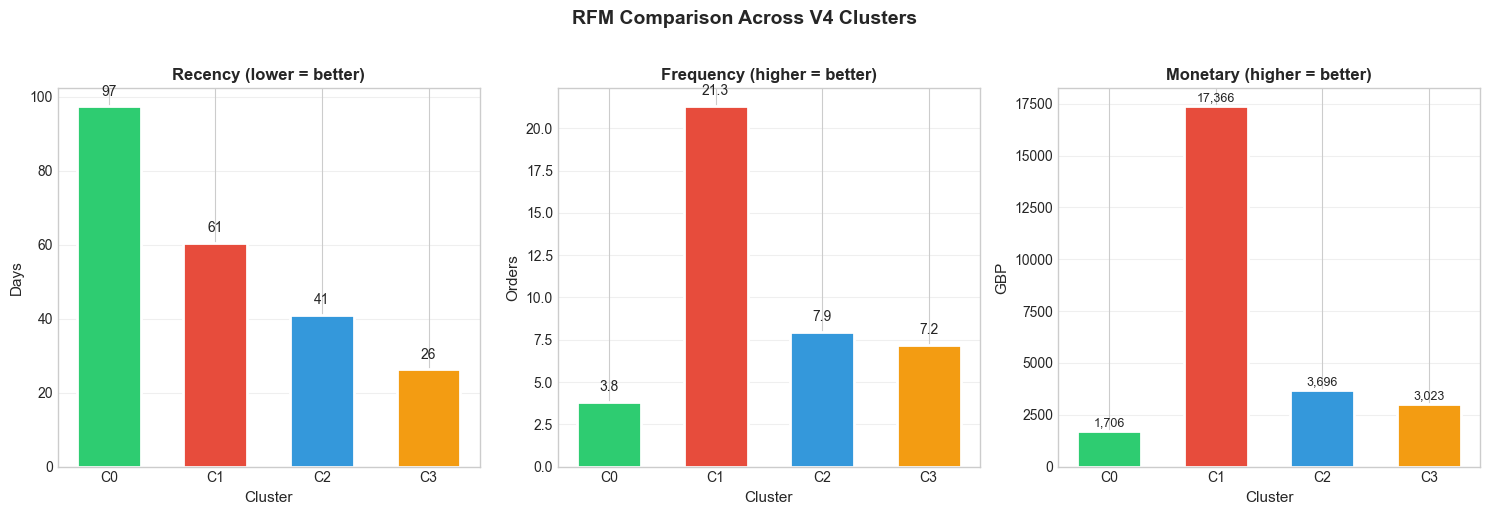


Đã lưu: images/Req6_ClusterProfileSummary.png

--------------------------------------------------
Phân bố Strategy Types:


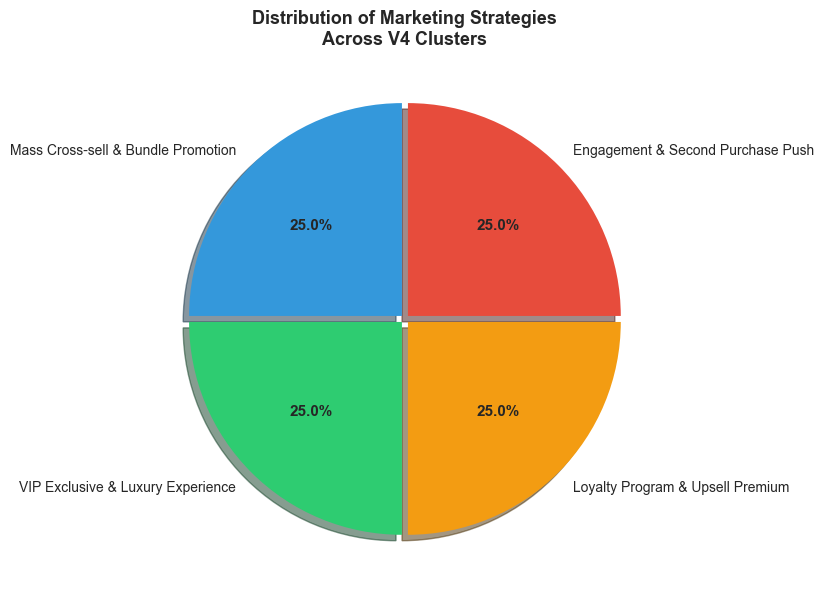

Đã lưu: images/Req6_StrategyDistribution.png

HOÀN THÀNH YÊU CẦU 6: PROFILING VÀ DIỄN GIẢI CỤM


In [57]:
# =============================================================================
# 6.7.3. VẼ BIỂU ĐỒ TỔNG HỢP CLUSTER PROFILE
# =============================================================================
# Vẽ biểu đồ radar/summary cho V4 clusters

print("="*70)
print("VẼ BIỂU ĐỒ TỔNG HỢP CLUSTER PROFILE")
print("="*70)

# Chuẩn bị dữ liệu cho V4
v4_profiles = df_final.copy()

# Normalize RFM để vẽ
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
v4_profiles[['R_Norm', 'F_Norm', 'M_Norm']] = scaler.fit_transform(
    v4_profiles[['R_Mean', 'F_Mean', 'M_Mean']]
)

# Đảo ngược Recency (vì R thấp = tốt)
v4_profiles['R_Norm'] = 1 - v4_profiles['R_Norm']

# Vẽ bar chart so sánh RFM giữa các clusters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Xác định số lượng clusters thực tế từ dữ liệu
n_clusters = len(v4_profiles)
print(f"Số lượng clusters trong V4: {n_clusters}")

# Màu gradient cho các clusters (tự động điều chỉnh theo số lượng)
base_colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22']
colors_clusters = base_colors[:n_clusters]

# Tạo labels cho clusters
cluster_ids = v4_profiles['Cluster'].values
cluster_labels = [f"C{int(c)}" for c in cluster_ids]

x = np.arange(n_clusters)
width = 0.6

# Recency (đảo ngược - thấp hơn = tốt hơn)
bars1 = axes[0].bar(x, v4_profiles['R_Mean'].values, width, color=colors_clusters, edgecolor='white', linewidth=2)
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Days', fontsize=11)
axes[0].set_title('Recency (lower = better)', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(cluster_labels)
for bar, val in zip(bars1, v4_profiles['R_Mean'].values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{val:.0f}', ha='center', va='bottom', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Frequency
bars2 = axes[1].bar(x, v4_profiles['F_Mean'].values, width, color=colors_clusters, edgecolor='white', linewidth=2)
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Orders', fontsize=11)
axes[1].set_title('Frequency (higher = better)', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(cluster_labels)
for bar, val in zip(bars2, v4_profiles['F_Mean'].values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

# Monetary
bars3 = axes[2].bar(x, v4_profiles['M_Mean'].values, width, color=colors_clusters, edgecolor='white', linewidth=2)
axes[2].set_xlabel('Cluster', fontsize=11)
axes[2].set_ylabel('GBP', fontsize=11)
axes[2].set_title('Monetary (higher = better)', fontsize=12, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(cluster_labels)
for bar, val in zip(bars3, v4_profiles['M_Mean'].values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                f'{val:,.0f}', ha='center', va='bottom', fontsize=9)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('RFM Comparison Across V4 Clusters', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/Req6_ClusterProfileSummary.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nĐã lưu: images/Req6_ClusterProfileSummary.png")

# Vẽ thêm pie chart phân bố strategy types
print("\n" + "-"*50)
print("Phân bố Strategy Types:")

strategy_counts = df_strategies['Strategy_Type'].value_counts()
fig, ax = plt.subplots(figsize=(8, 8))

colors_strategy = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
wedges, texts, autotexts = ax.pie(
    strategy_counts.values, 
    labels=strategy_counts.index, 
    autopct='%1.1f%%',
    colors=colors_strategy[:len(strategy_counts)],
    explode=[0.02]*len(strategy_counts),
    shadow=True,
    startangle=90
)

for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

ax.set_title('Distribution of Marketing Strategies\nAcross V4 Clusters', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/Req6_StrategyDistribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Đã lưu: images/Req6_StrategyDistribution.png")

print("\n" + "="*70)
print("HOÀN THÀNH YÊU CẦU 6: PROFILING VÀ DIỄN GIẢI CỤM")
print("="*70)

## 7. Yêu cầu 7
+ Xây dựng dashboard Streamlit để đọc các file output và cho phép lọc theo cụm, xem top rules, xem gợi ý bundle/cross-sell theo cụm

### 7.1. Kiểm tra dữ liệu đầu vào cho Dashboard

In [58]:
# =============================================================================
# 7.1. KIỂM TRA DỮ LIỆU ĐẦU VÀO CHO DASHBOARD
# =============================================================================
# Kiểm tra các file output cần thiết cho Dashboard Streamlit

import os

print("="*70)
print("KIỂM TRA DỮ LIỆU ĐẦU VÀO CHO DASHBOARD STREAMLIT")
print("="*70)

# Định nghĩa các file cần kiểm tra
required_files = {
    'Data Files': [
        '../data/mini_project/rules_fpgrowth_filtered.csv',
        '../data/mini_project/cluster_profiles_complete.csv',
        '../data/mini_project/cluster_marketing_strategies.csv',
        '../data/mini_project/cluster_rfm_stats.csv',
        '../data/mini_project/customer_clusters_v4_k4.csv',
        '../data/mini_project/feature_variants_comparison.csv',
        '../data/mini_project/rfm_data.csv',
    ],
    'Image Files (Req1)': [
        '../images/Req1_Top15RulesByLift.png',
        '../images/Req1_SupportConfidenceScatter.png',
        '../images/Req1_LiftDistribution.png',
        '../images/Req1_MetricsDistribution.png',
    ],
    'Image Files (Req2)': [
        '../images/Req2_FeatureVariantComparison.png',
        '../images/Req2_RFMDistribution.png',
    ],
    'Image Files (Req3)': [
        '../images/Req3_ElbowMethod.png',
        '../images/Req3_SilhouetteScore.png',
        '../images/Req3_BestKComparison.png',
    ],
    'Image Files (Req4)': [
        '../images/Req4_PCA_ClusterSeparation.png',
        '../images/Req4_SVD_ClusterSeparation.png',
    ],
    'Image Files (Req6)': [
        '../images/Req6_ClusterDistribution.png',
        '../images/Req6_ClusterProfileSummary.png',
        '../images/Req6_RuleActivationHeatmap.png',
        '../images/Req6_StrategyDistribution.png',
    ],
}

total_files = 0
found_files = 0

for category, files in required_files.items():
    print(f"\n📁 {category}:")
    for file_path in files:
        total_files += 1
        exists = os.path.exists(file_path)
        status = "✅" if exists else "❌"
        filename = os.path.basename(file_path)
        if exists:
            found_files += 1
        print(f"   {status} {filename}")

print("\n" + "="*70)
print(f"📊 Tổng kết: {found_files}/{total_files} files sẵn sàng ({found_files/total_files*100:.1f}%)")
print("="*70)

if found_files == total_files:
    print("✅ Tất cả dữ liệu đã sẵn sàng cho Dashboard!")
else:
    print("⚠️ Một số file chưa có, cần chạy lại các bước trước đó.")

KIỂM TRA DỮ LIỆU ĐẦU VÀO CHO DASHBOARD STREAMLIT

📁 Data Files:
   ✅ rules_fpgrowth_filtered.csv
   ✅ cluster_profiles_complete.csv
   ✅ cluster_marketing_strategies.csv
   ✅ cluster_rfm_stats.csv
   ✅ customer_clusters_v4_k4.csv
   ✅ feature_variants_comparison.csv
   ✅ rfm_data.csv

📁 Image Files (Req1):
   ✅ Req1_Top15RulesByLift.png
   ✅ Req1_SupportConfidenceScatter.png
   ✅ Req1_LiftDistribution.png
   ✅ Req1_MetricsDistribution.png

📁 Image Files (Req2):
   ✅ Req2_FeatureVariantComparison.png
   ✅ Req2_RFMDistribution.png

📁 Image Files (Req3):
   ✅ Req3_ElbowMethod.png
   ✅ Req3_SilhouetteScore.png
   ✅ Req3_BestKComparison.png

📁 Image Files (Req4):
   ✅ Req4_PCA_ClusterSeparation.png
   ✅ Req4_SVD_ClusterSeparation.png

📁 Image Files (Req6):
   ✅ Req6_ClusterDistribution.png
   ✅ Req6_ClusterProfileSummary.png
   ✅ Req6_RuleActivationHeatmap.png
   ✅ Req6_StrategyDistribution.png

📊 Tổng kết: 22/22 files sẵn sàng (100.0%)
✅ Tất cả dữ liệu đã sẵn sàng cho Dashboard!


### 7.2. Tạo file Dashboard Streamlit

In [59]:
# =============================================================================
# 7.2. TẠO FILE DASHBOARD STREAMLIT
# =============================================================================
# File streamlit_app.py đã được tạo ở thư mục gốc của dự án
# Nội dung bao gồm 6 tabs:
#   1. Tổng quan (Overview) - KPIs và pipeline tổng hợp
#   2. Luật Kết Hợp - Bộ lọc và bảng Top-K rules
#   3. Feature Engineering - So sánh 4 variants
#   4. Kết quả Clustering - Elbow, Silhouette, PCA/SVD
#   5. Phân Khúc Khách Hàng - Profile chi tiết theo cluster
#   6. Chiến Lược Marketing - Đề xuất bundle/cross-sell

print("="*70)
print("CẤU TRÚC DASHBOARD STREAMLIT")
print("="*70)

dashboard_structure = """
📊 ShopCluster Dashboard
├── 🏠 Tab 1: Tổng quan (Overview)
│   ├── KPIs: 3,921 khách, 200 luật, 4 cụm, Avg Lift 42.19
│   ├── Pipeline 6 bước
│   └── Bảng tóm tắt 4 clusters
│
├── 📜 Tab 2: Luật Kết Hợp (Association Rules)
│   ├── Bộ lọc: min_lift, min_confidence, min_support, top_k
│   ├── Bảng Top K rules (có filter)
│   └── Biểu đồ: Req1_*.png
│
├── 🎨 Tab 3: Feature Engineering
│   ├── Mô tả 4 variants (V1, V2, V3, V4)
│   ├── Bảng so sánh metrics
│   └── Biểu đồ: Req2_*.png
│
├── 🔬 Tab 4: Kết quả Clustering
│   ├── Sub-tab: Chọn K (Elbow & Silhouette)
│   ├── Sub-tab: Trực quan 2D (PCA/SVD)
│   ├── Sub-tab: So sánh Variants
│   └── Biểu đồ: Req3_*.png, Req4_*.png
│
├── 👥 Tab 5: Phân Khúc Khách Hàng (CHÍNH)
│   ├── Dropdown chọn Cluster (0-3)
│   ├── Profile: Name, Persona, RFM metrics
│   ├── Top Rules cho cluster đó
│   ├── Bundle Recommendations
│   └── Biểu đồ: Req6_*.png
│
└── 📈 Tab 6: Chiến Lược Marketing
    ├── Filter theo Segment_Type
    ├── Chi tiết: Strategy, Offer, Channel, Timing, KPI
    ├── Biểu đồ phân bố strategy
    └── Export CSV button
"""

print(dashboard_structure)

# Kiểm tra file đã tạo
streamlit_file = '../streamlit_app.py'
if os.path.exists(streamlit_file):
    print(f"\n✅ File streamlit_app.py đã sẵn sàng!")
    print(f"   Đường dẫn: {os.path.abspath(streamlit_file)}")
else:
    print(f"\n❌ File chưa được tạo, cần tạo thủ công.")

print("\n" + "="*70)


CẤU TRÚC DASHBOARD STREAMLIT

📊 ShopCluster Dashboard
├── 🏠 Tab 1: Tổng quan (Overview)
│   ├── KPIs: 3,921 khách, 200 luật, 4 cụm, Avg Lift 42.19
│   ├── Pipeline 6 bước
│   └── Bảng tóm tắt 4 clusters
│
├── 📜 Tab 2: Luật Kết Hợp (Association Rules)
│   ├── Bộ lọc: min_lift, min_confidence, min_support, top_k
│   ├── Bảng Top K rules (có filter)
│   └── Biểu đồ: Req1_*.png
│
├── 🎨 Tab 3: Feature Engineering
│   ├── Mô tả 4 variants (V1, V2, V3, V4)
│   ├── Bảng so sánh metrics
│   └── Biểu đồ: Req2_*.png
│
├── 🔬 Tab 4: Kết quả Clustering
│   ├── Sub-tab: Chọn K (Elbow & Silhouette)
│   ├── Sub-tab: Trực quan 2D (PCA/SVD)
│   ├── Sub-tab: So sánh Variants
│   └── Biểu đồ: Req3_*.png, Req4_*.png
│
├── 👥 Tab 5: Phân Khúc Khách Hàng (CHÍNH)
│   ├── Dropdown chọn Cluster (0-3)
│   ├── Profile: Name, Persona, RFM metrics
│   ├── Top Rules cho cluster đó
│   ├── Bundle Recommendations
│   └── Biểu đồ: Req6_*.png
│
└── 📈 Tab 6: Chiến Lược Marketing
    ├── Filter theo Segment_Type
    ├── Chi

# C. Bổ sung

## 1. Giá trị TopK hợp lý

### 1.1 Mục tiêu thử nghiệm

**Câu hỏi nghiên cứu:** Giá trị TopK = 200 luật có phải là lựa chọn hợp lý không?

**Phương pháp thử nghiệm:**
1. Thử nghiệm với các giá trị TopK khác nhau: 50, 100, 150, 200, 250, 300, 400, 500
2. Đánh giá theo các tiêu chí:
   - **Chất lượng clustering:** Silhouette Score
   - **Độ phủ khách hàng:** % khách hàng có ít nhất 1 feature khác 0
   - **Độ đa dạng cụm:** Số cụm có ý nghĩa (size > 1% tổng khách)
   - **Chất lượng luật:** Avg Lift, Avg Confidence của tập luật
3. Kết luận giá trị TopK tối ưu

In [60]:
# =============================================================================
# 1.2 CHUẨN BỊ DỮ LIỆU VÀ HÀM TIỆN ÍCH CHO THỬ NGHIỆM TOPK
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("THỬ NGHIỆM GIÁ TRỊ TOPK TỐI ƯU")
print("=" * 80)

# Đường dẫn dữ liệu
DATA_DIR = "../data/mini_project"
PROCESSED_DIR = "../data/processed"
IMAGES_DIR = "../images"

# Load dữ liệu cần thiết
print("\n[1] Load dữ liệu...")

# Load cleaned data
df_cleaned = pd.read_csv(f"{PROCESSED_DIR}/cleaned_uk_data.csv")
print(f"  ✓ Loaded cleaned_uk_data.csv: {len(df_cleaned):,} rows")

# Load tất cả luật (chưa lọc TopK)
df_rules_all = pd.read_csv(f"{DATA_DIR}/rules_fpgrowth_filtered.csv")
print(f"  ✓ Loaded rules_fpgrowth_filtered.csv: {len(df_rules_all):,} rules")

# Load RFM data
df_rfm = pd.read_csv(f"{DATA_DIR}/rfm_data.csv")
print(f"  ✓ Loaded rfm_data.csv: {len(df_rfm):,} customers")

# Tạo basket data
print("\n[2] Tạo basket data...")
df_basket = df_cleaned.groupby(['InvoiceNo', 'CustomerID'])['Description'].apply(set).reset_index()
customer_baskets = df_basket.groupby('CustomerID')['Description'].apply(
    lambda x: set.union(*x) if len(x) > 0 else set()
).to_dict()
print(f"  ✓ Tạo basket cho {len(customer_baskets):,} khách hàng")

# Các giá trị TopK cần thử nghiệm
TOPK_VALUES = [50, 100, 150, 200, 250, 300, 400, 500]
print(f"\n[3] Các giá trị TopK cần thử nghiệm: {TOPK_VALUES}")
print("=" * 80)

THỬ NGHIỆM GIÁ TRỊ TOPK TỐI ƯU

[1] Load dữ liệu...
  ✓ Loaded cleaned_uk_data.csv: 485,123 rows
  ✓ Loaded rules_fpgrowth_filtered.csv: 200 rules
  ✓ Loaded rfm_data.csv: 3,921 customers

[2] Tạo basket data...
  ✓ Tạo basket cho 3,921 khách hàng

[3] Các giá trị TopK cần thử nghiệm: [50, 100, 150, 200, 250, 300, 400, 500]


### 1.3 Hàm tạo Feature Matrix từ TopK luật

In [61]:
# =============================================================================
# HÀM TẠO FEATURE MATRIX TỪ TOPK LUẬT
# =============================================================================

def create_feature_matrix_topk(rules_df, customer_baskets, topk):
    """
    Tạo feature matrix binary từ TopK luật theo lift.
    
    Parameters:
    -----------
    rules_df : DataFrame - Tất cả luật kết hợp
    customer_baskets : dict - {CustomerID: set of products}
    topk : int - Số luật cần lấy
    
    Returns:
    --------
    feature_matrix : DataFrame - Ma trận đặc trưng (customers x rules)
    selected_rules : DataFrame - Các luật đã chọn
    """
    # Lấy TopK luật theo lift
    selected_rules = rules_df.nlargest(topk, 'lift').reset_index(drop=True)
    
    # Parse antecedents từ string
    def parse_itemset(s):
        if pd.isna(s):
            return set()
        # Xử lý format: frozenset({'item1', 'item2'}) hoặc 'item1, item2'
        s = str(s)
        if 'frozenset' in s:
            items = s.replace('frozenset({', '').replace('})', '').replace("'", "").split(', ')
        else:
            items = s.split(', ')
        return set(item.strip() for item in items if item.strip())
    
    # Tạo feature matrix
    customers = list(customer_baskets.keys())
    n_customers = len(customers)
    n_rules = len(selected_rules)
    
    feature_matrix = np.zeros((n_customers, n_rules), dtype=np.int8)
    
    for i, cust in enumerate(customers):
        cust_products = customer_baskets.get(cust, set())
        for j, row in selected_rules.iterrows():
            antecedent = parse_itemset(row['antecedents_str'])
            # Feature = 1 nếu khách đã mua TẤT CẢ sản phẩm trong antecedent
            if antecedent.issubset(cust_products):
                feature_matrix[i, j] = 1
    
    df_features = pd.DataFrame(
        feature_matrix, 
        index=customers, 
        columns=[f'rule_{i}' for i in range(n_rules)]
    )
    
    return df_features, selected_rules


def evaluate_topk_clustering(feature_matrix, k_range=[2, 3, 4, 5, 6, 7]):
    """
    Đánh giá clustering với các giá trị K khác nhau.
    
    Returns:
    --------
    best_k : int - K tối ưu theo Silhouette
    best_score : float - Silhouette score cao nhất
    all_scores : dict - {k: silhouette_score}
    """
    # Loại bỏ khách hàng không có feature nào
    non_zero_mask = feature_matrix.sum(axis=1) > 0
    X = feature_matrix[non_zero_mask].values
    
    if len(X) < max(k_range) + 1:
        return None, 0, {}
    
    all_scores = {}
    for k in k_range:
        if k >= len(X):
            continue
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        all_scores[k] = score
    
    if not all_scores:
        return None, 0, {}
    
    best_k = max(all_scores, key=all_scores.get)
    best_score = all_scores[best_k]
    
    return best_k, best_score, all_scores


print("✓ Đã định nghĩa các hàm tiện ích")

✓ Đã định nghĩa các hàm tiện ích


### 1.4 Chạy thử nghiệm với các giá trị TopK

In [62]:
# =============================================================================
# CHẠY THỬ NGHIỆM VỚI CÁC GIÁ TRỊ TOPK
# =============================================================================

print("=" * 80)
print("THỬ NGHIỆM CÁC GIÁ TRỊ TOPK")
print("=" * 80)

# Lưu kết quả thử nghiệm
experiment_results = []

for topk in TOPK_VALUES:
    print(f"\n{'='*60}")
    print(f"THỬ NGHIỆM TOPK = {topk}")
    print(f"{'='*60}")
    
    # 1. Tạo feature matrix
    feature_matrix, selected_rules = create_feature_matrix_topk(
        df_rules_all, customer_baskets, topk
    )
    
    # 2. Tính các metrics về luật
    avg_lift = selected_rules['lift'].mean()
    avg_confidence = selected_rules['confidence'].mean()
    avg_support = selected_rules['support'].mean()
    min_lift = selected_rules['lift'].min()
    
    print(f"[Metrics của {topk} luật]")
    print(f"  - Avg Lift: {avg_lift:.2f}")
    print(f"  - Min Lift: {min_lift:.2f}")  
    print(f"  - Avg Confidence: {avg_confidence:.2%}")
    print(f"  - Avg Support: {avg_support:.4f}")
    
    # 3. Tính coverage (% khách có feature > 0)
    n_customers_total = len(feature_matrix)
    n_customers_covered = (feature_matrix.sum(axis=1) > 0).sum()
    coverage = n_customers_covered / n_customers_total
    
    print(f"\n[Coverage]")
    print(f"  - Khách hàng được cover: {n_customers_covered:,}/{n_customers_total:,} ({coverage:.1%})")
    
    # 4. Tính sparsity của feature matrix
    n_nonzero = (feature_matrix.values > 0).sum()
    total_cells = feature_matrix.shape[0] * feature_matrix.shape[1]
    sparsity = 1 - (n_nonzero / total_cells)
    avg_features_per_customer = feature_matrix.sum(axis=1).mean()
    
    print(f"\n[Feature Matrix Stats]")
    print(f"  - Shape: {feature_matrix.shape}")
    print(f"  - Sparsity: {sparsity:.2%}")
    print(f"  - Avg features/customer: {avg_features_per_customer:.2f}")
    
    # 5. Clustering evaluation
    print(f"\n[Clustering Evaluation]")
    best_k, best_silhouette, all_scores = evaluate_topk_clustering(feature_matrix)
    
    if best_k is not None:
        print(f"  - Best K: {best_k}")
        print(f"  - Best Silhouette: {best_silhouette:.4f}")
        print(f"  - All scores: {all_scores}")
        
        # Chạy clustering với K=5 để so sánh công bằng
        non_zero_mask = feature_matrix.sum(axis=1) > 0
        X = feature_matrix[non_zero_mask].values
        
        if len(X) > 5:
            kmeans_k5 = KMeans(n_clusters=5, random_state=42, n_init=10)
            labels_k5 = kmeans_k5.fit_predict(X)
            silhouette_k5 = silhouette_score(X, labels_k5)
            
            # Đếm cluster sizes
            unique, counts = np.unique(labels_k5, return_counts=True)
            cluster_sizes = dict(zip(unique, counts))
            n_meaningful_clusters = sum(1 for c in counts if c > len(X) * 0.01)  # > 1%
            
            print(f"  - Silhouette (K=5): {silhouette_k5:.4f}")
            print(f"  - Cluster sizes: {cluster_sizes}")
            print(f"  - Meaningful clusters (>1%): {n_meaningful_clusters}")
        else:
            silhouette_k5 = 0
            n_meaningful_clusters = 0
    else:
        best_silhouette = 0
        silhouette_k5 = 0
        n_meaningful_clusters = 0
    
    # Lưu kết quả
    experiment_results.append({
        'TopK': topk,
        'Avg_Lift': avg_lift,
        'Min_Lift': min_lift,
        'Avg_Confidence': avg_confidence,
        'Avg_Support': avg_support,
        'Coverage': coverage,
        'Sparsity': sparsity,
        'Avg_Features_Per_Customer': avg_features_per_customer,
        'Best_K': best_k,
        'Best_Silhouette': best_silhouette,
        'Silhouette_K5': silhouette_k5,
        'N_Meaningful_Clusters': n_meaningful_clusters
    })

# Tạo DataFrame kết quả
df_results = pd.DataFrame(experiment_results)
print("\n" + "=" * 80)
print("KẾT QUẢ THỬ NGHIỆM")
print("=" * 80)
display(df_results)

THỬ NGHIỆM CÁC GIÁ TRỊ TOPK

THỬ NGHIỆM TOPK = 50
[Metrics của 50 luật]
  - Avg Lift: 71.32
  - Min Lift: 69.03
  - Avg Confidence: 90.38%
  - Avg Support: 0.0107

[Coverage]
  - Khách hàng được cover: 136/3,921 (3.5%)

[Feature Matrix Stats]
  - Shape: (3921, 50)
  - Sparsity: 97.20%
  - Avg features/customer: 1.40

[Clustering Evaluation]
  - Best K: 7
  - Best Silhouette: 0.9062
  - All scores: {2: 0.7063361286089707, 3: 0.7457228763653628, 4: 0.7879443762269233, 5: 0.8457190830698729, 6: 0.8843263850546875, 7: 0.906185933156709}
  - Silhouette (K=5): 0.8457
  - Cluster sizes: {0: 102, 1: 13, 2: 8, 3: 7, 4: 6}
  - Meaningful clusters (>1%): 5

THỬ NGHIỆM TOPK = 100
[Metrics của 100 luật]
  - Avg Lift: 58.42
  - Min Lift: 34.22
  - Avg Confidence: 82.80%
  - Avg Support: 0.0112

[Coverage]
  - Khách hàng được cover: 1,161/3,921 (29.6%)

[Feature Matrix Stats]
  - Shape: (3921, 100)
  - Sparsity: 97.47%
  - Avg features/customer: 2.53

[Clustering Evaluation]
  - Best K: 2
  - Best Si

,TopK,Avg_Lift,Min_Lift,Avg_Confidence,Avg_Support,Coverage,Sparsity,Avg_Features_Per_Customer,Best_K,Best_Silhouette,Silhouette_K5,N_Meaningful_Clusters
0,50,71.315572,69.030745,0.903828,0.010671,0.034685,0.971982,1.400918,7,0.906186,0.845719,5
1,100,58.415602,34.220499,0.827999,0.011210,0.296098,0.974688,2.531242,2,0.689449,0.262928,5
2,150,48.634351,25.950526,0.757990,0.011599,0.490691,0.968003,4.799541,2,0.591357,0.250852,5
3,200,42.128729,19.696839,0.733699,0.011637,0.570518,0.969016,6.196889,2,0.561554,0.246708,5
4,250,42.128729,19.696839,0.733699,0.011637,0.570518,0.969016,6.196889,2,0.561554,0.246708,5
5,300,42.128729,19.696839,0.733699,0.011637,0.570518,0.969016,6.196889,2,0.561554,0.246708,5
6,400,42.128729,19.696839,0.733699,0.011637,0.570518,0.969016,6.196889,2,0.561554,0.246708,5
7,500,42.128729,19.696839,0.733699,0.011637,0.570518,0.969016,6.196889,2,0.561554,0.246708,5


### 1.5 Trực quan hóa kết quả thử nghiệm

2026-01-06 17:11:02,999 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-06 17:11:02,999 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-06 17:11:03,033 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-06 17:11:03,033 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-06 17:11:03,033 | INFO | Using categorical units to plot a list of strings that are all parsable as 

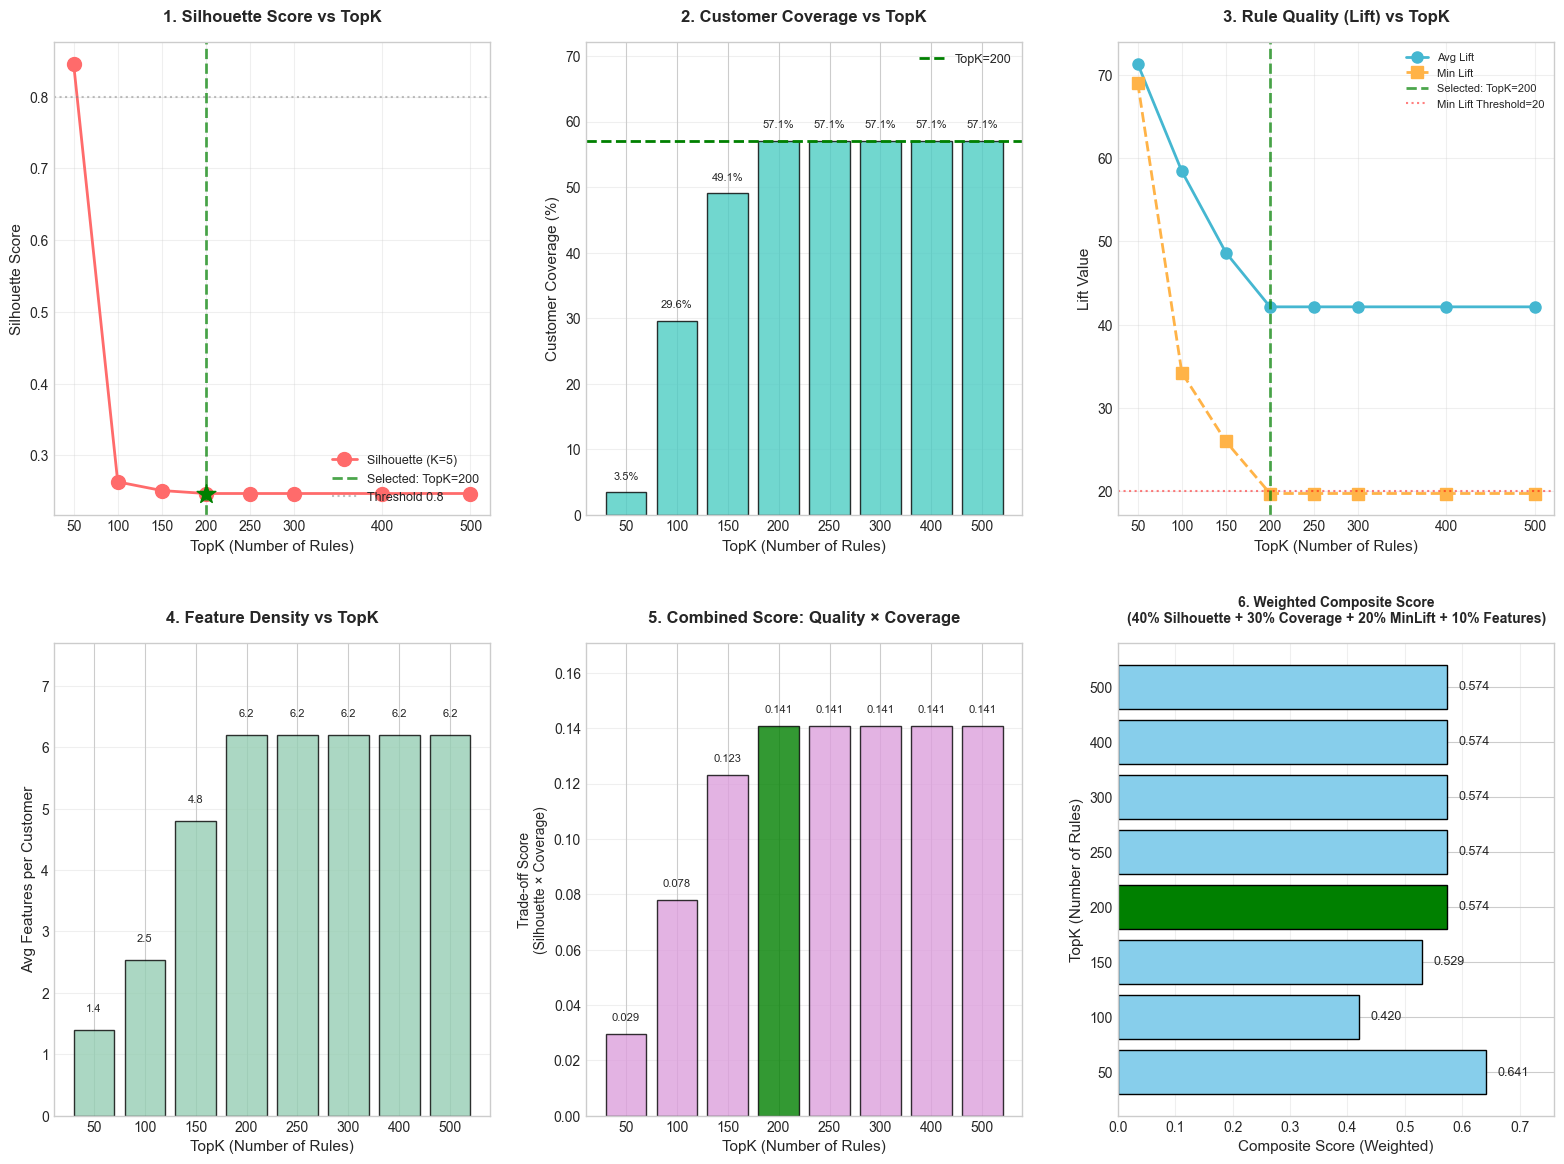

✓ Đã lưu: ../images/TopK_Experiment_Results.png


In [63]:
# =============================================================================
# TRỰC QUAN HÓA KẾT QUẢ THỬ NGHIỆM TOPK
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 12))  # Tăng chiều cao từ 10 lên 12

# -------------------------------------------------------------------------
# Chart 1: Silhouette Score theo TopK
# -------------------------------------------------------------------------
ax1 = axes[0, 0]
ax1.plot(df_results['TopK'], df_results['Silhouette_K5'], 'o-', 
         color='#FF6B6B', linewidth=2, markersize=10, label='Silhouette (K=5)')
ax1.axvline(x=200, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Selected: TopK=200')
ax1.axhline(y=0.8, color='gray', linestyle=':', alpha=0.5, label='Threshold 0.8')
ax1.set_xlabel('TopK (Number of Rules)', fontsize=11)
ax1.set_ylabel('Silhouette Score', fontsize=11)
ax1.set_title('1. Silhouette Score vs TopK', fontsize=12, fontweight='bold', pad=15)
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(TOPK_VALUES)

# Highlight điểm TopK=200
topk_200_idx = df_results[df_results['TopK'] == 200].index[0]
ax1.scatter([200], [df_results.loc[topk_200_idx, 'Silhouette_K5']], 
            s=200, color='green', zorder=5, marker='*')

# -------------------------------------------------------------------------
# Chart 2: Coverage theo TopK
# -------------------------------------------------------------------------
ax2 = axes[0, 1]
ax2.bar(df_results['TopK'].astype(str), df_results['Coverage'] * 100, 
        color='#4ECDC4', edgecolor='black', alpha=0.8)
ax2.axhline(y=df_results[df_results['TopK'] == 200]['Coverage'].values[0] * 100, 
            color='green', linestyle='--', linewidth=2, label='TopK=200')
ax2.set_xlabel('TopK (Number of Rules)', fontsize=11)
ax2.set_ylabel('Customer Coverage (%)', fontsize=11)
ax2.set_title('2. Customer Coverage vs TopK', fontsize=12, fontweight='bold', pad=15)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Thêm giá trị trên cột - điều chỉnh vị trí
max_coverage = df_results['Coverage'].max() * 100
ax2.set_ylim(0, max_coverage + 15)  # Thêm không gian phía trên
for i, (topk, cov) in enumerate(zip(df_results['TopK'], df_results['Coverage'])):
    ax2.text(i, cov * 100 + 2, f'{cov*100:.1f}%', ha='center', fontsize=8)

# -------------------------------------------------------------------------
# Chart 3: Avg Lift và Min Lift theo TopK
# -------------------------------------------------------------------------
ax3 = axes[0, 2]
ax3.plot(df_results['TopK'], df_results['Avg_Lift'], 'o-', 
         color='#45B7D1', linewidth=2, markersize=8, label='Avg Lift')
ax3.plot(df_results['TopK'], df_results['Min_Lift'], 's--', 
         color='#FFB347', linewidth=2, markersize=8, label='Min Lift')
ax3.axvline(x=200, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Selected: TopK=200')
ax3.axhline(y=20, color='red', linestyle=':', alpha=0.5, label='Min Lift Threshold=20')
ax3.set_xlabel('TopK (Number of Rules)', fontsize=11)
ax3.set_ylabel('Lift Value', fontsize=11)
ax3.set_title('3. Rule Quality (Lift) vs TopK', fontsize=12, fontweight='bold', pad=15)
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(TOPK_VALUES)

# -------------------------------------------------------------------------
# Chart 4: Avg Features per Customer theo TopK
# -------------------------------------------------------------------------
ax4 = axes[1, 0]
ax4.bar(df_results['TopK'].astype(str), df_results['Avg_Features_Per_Customer'], 
        color='#96CEB4', edgecolor='black', alpha=0.8)
ax4.set_xlabel('TopK (Number of Rules)', fontsize=11)
ax4.set_ylabel('Avg Features per Customer', fontsize=11)
ax4.set_title('4. Feature Density vs TopK', fontsize=12, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, axis='y')

# Thêm giá trị trên cột - điều chỉnh vị trí
max_feat = df_results['Avg_Features_Per_Customer'].max()
ax4.set_ylim(0, max_feat + 1.5)  # Thêm không gian phía trên
for i, (topk, feat) in enumerate(zip(df_results['TopK'], df_results['Avg_Features_Per_Customer'])):
    ax4.text(i, feat + 0.3, f'{feat:.1f}', ha='center', fontsize=8)

# -------------------------------------------------------------------------
# Chart 5: Trade-off Score (Silhouette × Coverage)
# -------------------------------------------------------------------------
ax5 = axes[1, 1]
df_results['TradeOff_Score'] = df_results['Silhouette_K5'] * df_results['Coverage']
bars = ax5.bar(df_results['TopK'].astype(str), df_results['TradeOff_Score'], 
               color=['green' if t == 200 else '#DDA0DD' for t in df_results['TopK']], 
               edgecolor='black', alpha=0.8)
ax5.set_xlabel('TopK (Number of Rules)', fontsize=11)
ax5.set_ylabel('Trade-off Score\n(Silhouette × Coverage)', fontsize=10)
ax5.set_title('5. Combined Score: Quality × Coverage', fontsize=12, fontweight='bold', pad=15)
ax5.grid(True, alpha=0.3, axis='y')

# Thêm giá trị trên cột - điều chỉnh vị trí
max_tradeoff = df_results['TradeOff_Score'].max()
ax5.set_ylim(0, max_tradeoff + 0.03)  # Thêm không gian phía trên
for i, (topk, score) in enumerate(zip(df_results['TopK'], df_results['TradeOff_Score'])):
    ax5.text(i, score + 0.005, f'{score:.3f}', ha='center', fontsize=8)

# -------------------------------------------------------------------------
# Chart 6: Tổng hợp Multi-metric (Radar-like bar chart)
# -------------------------------------------------------------------------
ax6 = axes[1, 2]

# Normalize các metrics về 0-1
df_norm = df_results.copy()
df_norm['Norm_Silhouette'] = df_norm['Silhouette_K5'] / df_norm['Silhouette_K5'].max()
df_norm['Norm_Coverage'] = df_norm['Coverage'] / df_norm['Coverage'].max()
df_norm['Norm_MinLift'] = df_norm['Min_Lift'] / df_norm['Min_Lift'].max()
df_norm['Norm_AvgFeatures'] = df_norm['Avg_Features_Per_Customer'] / df_norm['Avg_Features_Per_Customer'].max()

# Tính điểm tổng hợp (có thể điều chỉnh trọng số)
df_norm['Composite_Score'] = (
    0.4 * df_norm['Norm_Silhouette'] +  # Trọng số cao cho clustering quality
    0.3 * df_norm['Norm_Coverage'] +     # Coverage quan trọng
    0.2 * df_norm['Norm_MinLift'] +      # Chất lượng luật
    0.1 * df_norm['Norm_AvgFeatures']    # Feature density
)

colors = ['green' if t == 200 else '#87CEEB' for t in df_norm['TopK']]
bars = ax6.barh(df_norm['TopK'].astype(str), df_norm['Composite_Score'], color=colors, edgecolor='black')
ax6.set_xlabel('Composite Score (Weighted)', fontsize=11)
ax6.set_ylabel('TopK (Number of Rules)', fontsize=11)
ax6.set_title('6. Weighted Composite Score\n(40% Silhouette + 30% Coverage + 20% MinLift + 10% Features)', 
              fontsize=10, fontweight='bold', pad=15)
ax6.grid(True, alpha=0.3, axis='x')

# Thêm giá trị - điều chỉnh vị trí
max_composite = df_norm['Composite_Score'].max()
ax6.set_xlim(0, max_composite + 0.12)  # Thêm không gian bên phải
for bar, score in zip(bars, df_norm['Composite_Score']):
    ax6.text(score + 0.02, bar.get_y() + bar.get_height()/2, f'{score:.3f}', va='center', fontsize=9)

# Điều chỉnh layout với padding lớn hơn
plt.tight_layout(pad=2.0, h_pad=3.0, w_pad=2.0)
plt.savefig(f"{IMAGES_DIR}/TopK_Experiment_Results.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/TopK_Experiment_Results.png")

In [64]:
# =============================================================================
# XUẤT KẾT QUẢ THỬ NGHIỆM RA FILE
# =============================================================================

# Lưu kết quả thử nghiệm
output_file = f"{DATA_DIR}/topk_experiment_results.csv"
df_results.to_csv(output_file, index=False)
print(f"✓ Đã lưu kết quả thử nghiệm: {output_file}")

# Xác định best TopK theo từng metric (tính từ df_results và df_norm)
best_silhouette_topk = int(df_results.loc[df_results['Silhouette_K5'].idxmax(), 'TopK'])
best_coverage_topk = int(df_results.loc[df_results['Coverage'].idxmax(), 'TopK'])
best_composite_topk = int(df_norm.loc[df_norm['Composite_Score'].idxmax(), 'TopK'])

# Lấy dòng của TopK=200
topk_200 = df_results[df_results['TopK'] == 200].iloc[0]

# Tạo summary table
summary_table = pd.DataFrame({
    'Metric': [
        'Best TopK by Silhouette',
        'Best TopK by Coverage', 
        'Best TopK by Composite',
        'Selected TopK',
        'TopK=200 Silhouette',
        'TopK=200 Coverage',
        'TopK=200 Min Lift',
        'TopK=200 Composite Rank'
    ],
    'Value': [
        str(best_silhouette_topk),
        str(best_coverage_topk),
        str(best_composite_topk),
        '200',
        f"{topk_200['Silhouette_K5']:.4f}",
        f"{topk_200['Coverage']*100:.1f}%",
        f"{topk_200['Min_Lift']:.2f}",
        f"#{int(df_norm[df_norm['TopK']==200]['Composite_Score'].rank(ascending=False).values[0])}"
    ]
})

summary_file = f"{DATA_DIR}/topk_experiment_summary.csv"
summary_table.to_csv(summary_file, index=False)
print(f"✓ Đã lưu summary: {summary_file}")

display(summary_table)

✓ Đã lưu kết quả thử nghiệm: ../data/mini_project/topk_experiment_results.csv
✓ Đã lưu summary: ../data/mini_project/topk_experiment_summary.csv


,Metric,Value
0,Best TopK by Silhouette,50
1,Best TopK by Coverage,200
2,Best TopK by Composite,50
3,Selected TopK,200
4,TopK=200 Silhouette,0.2467
5,TopK=200 Coverage,57.1%
6,TopK=200 Min Lift,19.70
7,TopK=200 Composite Rank,#1


## 2. Thử nghiệm với thuật toán DBSCAN

### 2.1 Mục tiêu và Phương pháp

**Mục tiêu:** So sánh thuật toán DBSCAN với K-Means (V4, K=4) trên cùng bộ dữ liệu feature matrix.

**Phương pháp đánh giá:**
1. **Metrics định lượng:**
   - Silhouette Score: Đánh giá độ tách biệt và gắn kết của cụm
   - Davies-Bouldin Index (DBI): Đánh giá độ tương đồng giữa các cụm (thấp hơn = tốt hơn)
   - Calinski-Harabasz Index (CH): Đánh giá tỷ lệ variance giữa các cụm (cao hơn = tốt hơn)

2. **Đánh giá "Actionable":**
   - Số cụm có ý nghĩa (size > 1% tổng khách)
   - Độ phủ khách hàng (không bị gán nhãn noise)
   - Khả năng phân biệt hành vi mua hàng giữa các cụm

**Đặc điểm của DBSCAN:**
- Không cần chỉ định số cụm trước
- Có thể phát hiện cụm có hình dạng bất kỳ
- Tự động xác định outliers (noise points)
- Phụ thuộc vào 2 tham số: eps (bán kính) và min_samples

In [65]:
# =============================================================================
# 2.2 CHUẨN BỊ DỮ LIỆU VÀ IMPORT THƯ VIỆN
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SO SÁNH K-MEANS VÀ DBSCAN TRÊN BIẾN THỂ V4")
print("=" * 80)

# Đường dẫn dữ liệu
DATA_DIR = "../data/mini_project"
PROCESSED_DIR = "../data/processed"
IMAGES_DIR = "../images"

# Load feature matrix V4 (TopK = 200)
print("\n[1] Load dữ liệu...")

# Sử dụng lại feature_matrix từ thử nghiệm TopK (TopK=200)
# Nếu chưa có, load lại
try:
    # Kiểm tra xem feature_matrix có sẵn không
    print(f"  ✓ Feature matrix shape: {feature_matrix.shape}")
except:
    # Load lại nếu cần
    df_cleaned = pd.read_csv(f"{PROCESSED_DIR}/cleaned_uk_data.csv")
    df_rules_all = pd.read_csv(f"{DATA_DIR}/rules_fpgrowth_filtered.csv")
    df_rfm = pd.read_csv(f"{DATA_DIR}/rfm_data.csv")
    
    # Tạo basket data
    df_basket = df_cleaned.groupby(['InvoiceNo', 'CustomerID'])['Description'].apply(set).reset_index()
    customer_baskets = df_basket.groupby('CustomerID')['Description'].apply(
        lambda x: set.union(*x) if len(x) > 0 else set()
    ).to_dict()
    
    # Tạo feature matrix với TopK=200
    feature_matrix, selected_rules = create_feature_matrix_topk(df_rules_all, customer_baskets, 200)
    print(f"  ✓ Đã tạo feature matrix: {feature_matrix.shape}")

# Load RFM data để đánh giá actionable
df_rfm = pd.read_csv(f"{DATA_DIR}/rfm_data.csv")
print(f"  ✓ Loaded RFM data: {len(df_rfm)} customers")

# Lọc khách hàng có ít nhất 1 feature
non_zero_mask = feature_matrix.sum(axis=1) > 0
X = feature_matrix[non_zero_mask].values
customer_ids = feature_matrix[non_zero_mask].index.tolist()

print(f"\n[2] Dữ liệu sau khi lọc:")
print(f"  - Số khách hàng có feature > 0: {len(X):,}")
print(f"  - Số features (rules): {X.shape[1]}")
print("=" * 80)

SO SÁNH K-MEANS VÀ DBSCAN TRÊN BIẾN THỂ V4

[1] Load dữ liệu...
  ✓ Feature matrix shape: (3921, 200)
  ✓ Loaded RFM data: 3921 customers

[2] Dữ liệu sau khi lọc:
  - Số khách hàng có feature > 0: 2,237
  - Số features (rules): 200


### 2.3 Tìm tham số tối ưu cho DBSCAN (eps, min_samples)

TÌM THAM SỐ TỐI ƯU CHO DBSCAN

[1] Tính k-distance graph (k=5)...
  ✓ Suggested eps từ k-distance graph: 5.10

[2] Grid search các tham số DBSCAN...
  ✓ Số cấu hình hợp lệ (2-10 cụm, coverage > 50%): 23


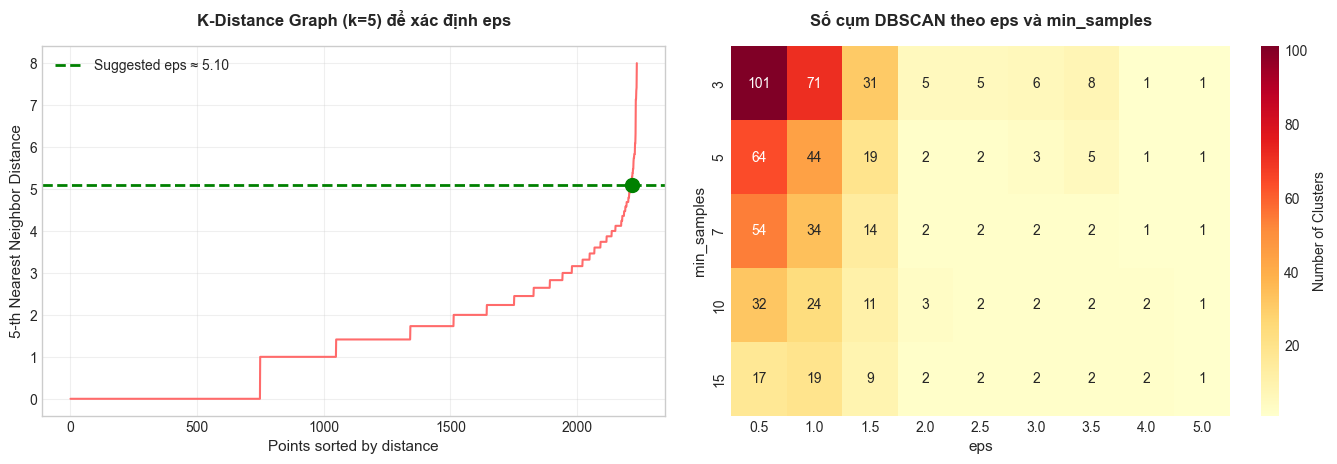

✓ Đã lưu: ../images/DBSCAN_ParameterSearch.png

[3] Top 10 cấu hình DBSCAN theo Silhouette Score:
--------------------------------------------------------------------------------


,eps,min_samples,n_clusters,coverage,silhouette,dbi,ch
19,2.0,15,2,0.7698,0.6338,0.4060,486.6524
17,2.0,7,2,0.7850,0.6277,0.4107,467.6340
16,2.0,5,2,0.7868,0.6271,0.4111,466.0707
24,2.5,15,2,0.8494,0.6134,0.4695,526.1981
22,2.5,7,2,0.8516,0.6123,0.4704,522.1633
23,2.5,10,2,0.8516,0.6123,0.4704,522.1633
21,2.5,5,2,0.8534,0.6116,0.4710,519.7123
29,3.0,15,2,0.9066,0.5968,0.5285,538.8670
28,3.0,10,2,0.9070,0.5966,0.5287,538.0371
27,3.0,7,2,0.9106,0.5949,0.5301,532.4348


In [66]:
# =============================================================================
# 2.3 TÌM THAM SỐ TỐI ƯU CHO DBSCAN
# =============================================================================
# Sử dụng phương pháp k-distance graph để tìm eps tối ưu

print("=" * 80)
print("TÌM THAM SỐ TỐI ƯU CHO DBSCAN")
print("=" * 80)

# Phương pháp 1: K-distance graph
# Tính khoảng cách đến k láng giềng gần nhất
k = 5  # Thường dùng min_samples - 1

print(f"\n[1] Tính k-distance graph (k={k})...")
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sắp xếp khoảng cách theo thứ tự tăng dần
distances = np.sort(distances[:, k-1])

# Vẽ k-distance graph
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: K-distance graph
ax1 = axes[0]
ax1.plot(range(len(distances)), distances, color='#FF6B6B', linewidth=1.5)
ax1.set_xlabel('Points sorted by distance', fontsize=11)
ax1.set_ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=11)
ax1.set_title(f'K-Distance Graph (k={k}) để xác định eps', fontsize=12, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)

# Tìm "elbow point" - điểm có độ cong lớn nhất
# Sử dụng phương pháp đạo hàm bậc 2
from scipy.ndimage import gaussian_filter1d
distances_smooth = gaussian_filter1d(distances, sigma=10)
second_derivative = np.gradient(np.gradient(distances_smooth))
elbow_idx = np.argmax(second_derivative)
suggested_eps = distances[elbow_idx]

ax1.axhline(y=suggested_eps, color='green', linestyle='--', linewidth=2, 
            label=f'Suggested eps ≈ {suggested_eps:.2f}')
ax1.scatter([elbow_idx], [suggested_eps], color='green', s=100, zorder=5, marker='o')
ax1.legend()

print(f"  ✓ Suggested eps từ k-distance graph: {suggested_eps:.2f}")

# Phương pháp 2: Grid search với nhiều giá trị eps và min_samples
print(f"\n[2] Grid search các tham số DBSCAN...")

# Định nghĩa grid
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]
min_samples_values = [3, 5, 7, 10, 15]

grid_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        labels = dbscan.fit_predict(X)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        noise_ratio = n_noise / len(labels)
        coverage = 1 - noise_ratio
        
        # Chỉ tính metrics nếu có >= 2 cụm và không phải tất cả là noise
        if n_clusters >= 2 and n_noise < len(labels) - 1:
            # Chỉ tính trên các điểm không phải noise
            mask = labels != -1
            if mask.sum() > n_clusters:
                try:
                    silhouette = silhouette_score(X[mask], labels[mask])
                    dbi = davies_bouldin_score(X[mask], labels[mask])
                    ch = calinski_harabasz_score(X[mask], labels[mask])
                except:
                    silhouette = dbi = ch = np.nan
            else:
                silhouette = dbi = ch = np.nan
        else:
            silhouette = dbi = ch = np.nan
        
        grid_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'coverage': coverage,
            'silhouette': silhouette,
            'dbi': dbi,
            'ch': ch
        })

df_grid = pd.DataFrame(grid_results)

# Lọc kết quả có từ 2-10 cụm và coverage > 50%
df_grid_valid = df_grid[(df_grid['n_clusters'] >= 2) & 
                         (df_grid['n_clusters'] <= 10) & 
                         (df_grid['coverage'] > 0.5)].copy()

print(f"  ✓ Số cấu hình hợp lệ (2-10 cụm, coverage > 50%): {len(df_grid_valid)}")

# Chart 2: Heatmap số cụm theo eps và min_samples
ax2 = axes[1]
pivot_clusters = df_grid.pivot(index='min_samples', columns='eps', values='n_clusters')
sns.heatmap(pivot_clusters, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax2,
            cbar_kws={'label': 'Number of Clusters'})
ax2.set_title('Số cụm DBSCAN theo eps và min_samples', fontsize=12, fontweight='bold', pad=15)
ax2.set_xlabel('eps', fontsize=11)
ax2.set_ylabel('min_samples', fontsize=11)

plt.tight_layout(pad=2.0)
plt.savefig(f"{IMAGES_DIR}/DBSCAN_ParameterSearch.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/DBSCAN_ParameterSearch.png")

# Hiển thị top cấu hình
if len(df_grid_valid) > 0:
    print(f"\n[3] Top 10 cấu hình DBSCAN theo Silhouette Score:")
    print("-" * 80)
    top_configs = df_grid_valid.nlargest(10, 'silhouette')[
        ['eps', 'min_samples', 'n_clusters', 'coverage', 'silhouette', 'dbi', 'ch']
    ].round(4)
    display(top_configs)
else:
    print("\n⚠️ Không có cấu hình nào đạt yêu cầu. Cần điều chỉnh grid search.")

### 2.4 Chạy K-Means và DBSCAN với tham số tối ưu

In [67]:
# =============================================================================
# 2.4 CHẠY K-MEANS VÀ DBSCAN VỚI THAM SỐ TỐI ƯU
# =============================================================================

print("=" * 80)
print("CHẠY CLUSTERING VỚI K-MEANS VÀ DBSCAN")
print("=" * 80)

# K toi uu cua V4 (tu Yeu cau 3)
K_BASELINE = 4

# -------------------------------------------------------------------------
# K-MEANS (V4, K=4) - Baseline
# -------------------------------------------------------------------------
print(f"\n[1] K-MEANS (K={K_BASELINE}):")
print("-" * 40)

kmeans = KMeans(n_clusters=K_BASELINE, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Tính metrics cho K-Means
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_dbi = davies_bouldin_score(X, kmeans_labels)
kmeans_ch = calinski_harabasz_score(X, kmeans_labels)

# Thống kê cụm
kmeans_unique, kmeans_counts = np.unique(kmeans_labels, return_counts=True)
kmeans_cluster_sizes = dict(zip(kmeans_unique, kmeans_counts))

print(f"  - Số cụm: {len(kmeans_unique)}")
print(f"  - Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  - Davies-Bouldin Index: {kmeans_dbi:.4f}")
print(f"  - Calinski-Harabasz Index: {kmeans_ch:.2f}")
print(f"  - Cluster sizes: {kmeans_cluster_sizes}")
print(f"  - Coverage: 100% (K-Means gán tất cả điểm)")

# -------------------------------------------------------------------------
# DBSCAN với tham số tối ưu
# -------------------------------------------------------------------------
print("\n[2] DBSCAN:")
print("-" * 40)

# Chọn tham số tối ưu từ grid search
if len(df_grid_valid) > 0:
    best_config = df_grid_valid.loc[df_grid_valid['silhouette'].idxmax()]
    best_eps = best_config['eps']
    best_min_samples = int(best_config['min_samples'])
else:
    # Fallback nếu không có cấu hình hợp lệ
    best_eps = suggested_eps
    best_min_samples = 5

print(f"  Tham số được chọn: eps={best_eps}, min_samples={best_min_samples}")

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)

# Thống kê cụm DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = (dbscan_labels == -1).sum()
dbscan_coverage = 1 - (n_noise / len(dbscan_labels))

print(f"  - Số cụm (không tính noise): {n_clusters_dbscan}")
print(f"  - Số điểm noise: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")
print(f"  - Coverage: {dbscan_coverage*100:.1f}%")

# Tính metrics cho DBSCAN (chỉ trên điểm không phải noise)
non_noise_mask = dbscan_labels != -1
if non_noise_mask.sum() > n_clusters_dbscan and n_clusters_dbscan >= 2:
    dbscan_silhouette = silhouette_score(X[non_noise_mask], dbscan_labels[non_noise_mask])
    dbscan_dbi = davies_bouldin_score(X[non_noise_mask], dbscan_labels[non_noise_mask])
    dbscan_ch = calinski_harabasz_score(X[non_noise_mask], dbscan_labels[non_noise_mask])
    
    print(f"  - Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"  - Davies-Bouldin Index: {dbscan_dbi:.4f}")
    print(f"  - Calinski-Harabasz Index: {dbscan_ch:.2f}")
    
    # Thống kê cluster sizes
    dbscan_unique, dbscan_counts = np.unique(dbscan_labels[non_noise_mask], return_counts=True)
    dbscan_cluster_sizes = dict(zip(dbscan_unique, dbscan_counts))
    print(f"  - Cluster sizes (không noise): {dbscan_cluster_sizes}")
else:
    dbscan_silhouette = dbscan_dbi = dbscan_ch = np.nan
    dbscan_cluster_sizes = {}
    print("  ⚠️ Không đủ cụm để tính metrics")

print("=" * 80)


CHẠY CLUSTERING VỚI K-MEANS VÀ DBSCAN

[1] K-MEANS (K=4):
----------------------------------------
  - Số cụm: 4
  - Silhouette Score: 0.2712
  - Davies-Bouldin Index: 1.8351
  - Calinski-Harabasz Index: 418.58
  - Cluster sizes: {0: 120, 1: 1669, 2: 124, 3: 324}
  - Coverage: 100% (K-Means gán tất cả điểm)

[2] DBSCAN:
----------------------------------------
  Tham số được chọn: eps=2.0, min_samples=15
  - Số cụm (không tính noise): 2
  - Số điểm noise: 515 (23.0%)
  - Coverage: 77.0%
  - Silhouette Score: 0.6338
  - Davies-Bouldin Index: 0.4060
  - Calinski-Harabasz Index: 486.65
  - Cluster sizes (không noise): {0: 1681, 1: 41}


### 2.5 So sánh Metrics giữa K-Means và DBSCAN

SO SÁNH METRICS GIỮA K-MEANS VÀ DBSCAN


,Metric,K-Means (K=4),DBSCAN
0,Algorithm,K-Means,DBSCAN
1,Number of Clusters,4,2
2,Noise Points,0,515
3,Coverage (%),100%,77.0%
4,Silhouette Score ↑,0.2712,0.6338
5,Davies-Bouldin Index ↓,1.8351,0.4060
6,Calinski-Harabasz Index ↑,418.58,486.65


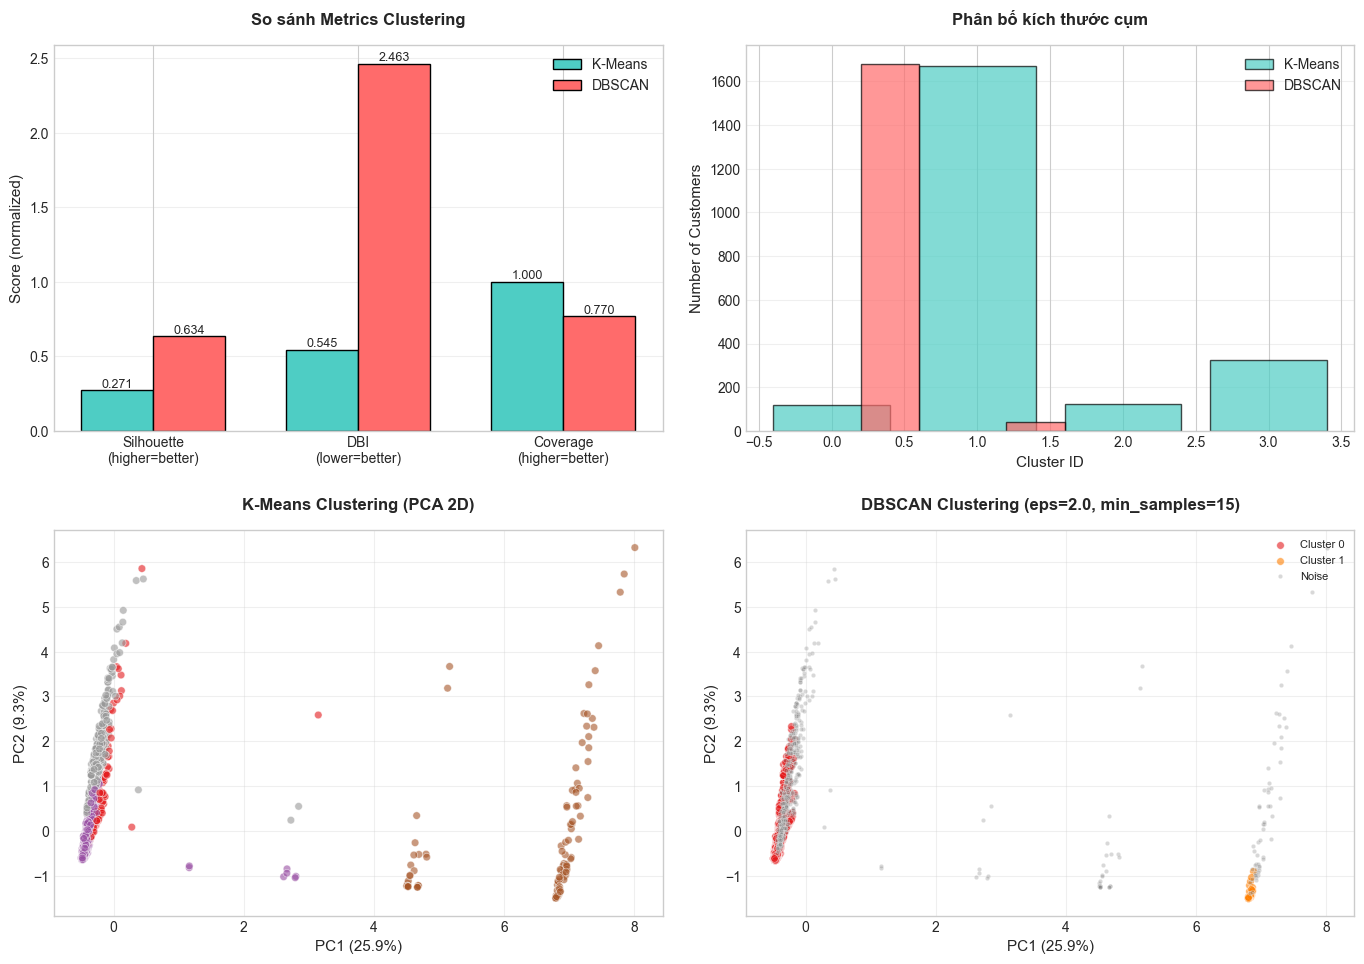

✓ Đã lưu: ../images/KMeans_vs_DBSCAN_Comparison.png


In [68]:
# =============================================================================
# 2.5 SO SÁNH METRICS GIỮA K-MEANS VÀ DBSCAN
# =============================================================================

print("=" * 80)
print("SO SÁNH METRICS GIỮA K-MEANS VÀ DBSCAN")
print("=" * 80)

# Tạo bảng so sánh
kmeans_label = f"K-Means (K={K_BASELINE})"

comparison_data = {
    'Metric': [
        'Algorithm',
        'Number of Clusters',
        'Noise Points',
        'Coverage (%)',
        'Silhouette Score ↑',
        'Davies-Bouldin Index ↓',
        'Calinski-Harabasz Index ↑'
    ],
    kmeans_label: [
        'K-Means',
        K_BASELINE,
        0,
        '100%',
        f'{kmeans_silhouette:.4f}',
        f'{kmeans_dbi:.4f}',
        f'{kmeans_ch:.2f}'
    ],
    'DBSCAN': [
        'DBSCAN',
        n_clusters_dbscan,
        n_noise,
        f'{dbscan_coverage*100:.1f}%',
        f'{dbscan_silhouette:.4f}' if not np.isnan(dbscan_silhouette) else 'N/A',
        f'{dbscan_dbi:.4f}' if not np.isnan(dbscan_dbi) else 'N/A',
        f'{dbscan_ch:.2f}' if not np.isnan(dbscan_ch) else 'N/A'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
display(df_comparison)

# -------------------------------------------------------------------------
# TRỰC QUAN HÓA SO SÁNH
# -------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chart 1: So sánh Silhouette, DBI (normalized)
ax1 = axes[0, 0]
metrics_names = ['Silhouette\n(higher=better)', 'DBI\n(lower=better)', 'Coverage\n(higher=better)']

# Normalize để so sánh
kmeans_metrics = [kmeans_silhouette, 1/kmeans_dbi if kmeans_dbi > 0 else 0, 1.0]
dbscan_metrics = [
    dbscan_silhouette if not np.isnan(dbscan_silhouette) else 0,
    1/dbscan_dbi if not np.isnan(dbscan_dbi) and dbscan_dbi > 0 else 0,
    dbscan_coverage
]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax1.bar(x - width/2, kmeans_metrics, width, label='K-Means', color='#4ECDC4', edgecolor='black')
bars2 = ax1.bar(x + width/2, dbscan_metrics, width, label='DBSCAN', color='#FF6B6B', edgecolor='black')

ax1.set_ylabel('Score (normalized)', fontsize=11)
ax1.set_title('So sánh Metrics Clustering', fontsize=12, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names, fontsize=10)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Thêm giá trị
for bar, val in zip(bars1, kmeans_metrics):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', 
             ha='center', fontsize=9)
for bar, val in zip(bars2, dbscan_metrics):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', 
             ha='center', fontsize=9)

# Chart 2: Phân bố kích thước cụm
ax2 = axes[0, 1]

# K-Means cluster sizes
kmeans_sizes = list(kmeans_cluster_sizes.values())
dbscan_sizes = list(dbscan_cluster_sizes.values()) if dbscan_cluster_sizes else [0]

ax2.bar(range(len(kmeans_sizes)), kmeans_sizes, alpha=0.7, label='K-Means', color='#4ECDC4', edgecolor='black')
if dbscan_cluster_sizes:
    ax2.bar([i + 0.4 for i in range(len(dbscan_sizes))], dbscan_sizes, alpha=0.7, 
            label='DBSCAN', color='#FF6B6B', edgecolor='black', width=0.4)
ax2.set_xlabel('Cluster ID', fontsize=11)
ax2.set_ylabel('Number of Customers', fontsize=11)
ax2.set_title('Phân bố kích thước cụm', fontsize=12, fontweight='bold', pad=15)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Chart 3: Scatter plot 2D (PCA) với K-Means labels
ax3 = axes[1, 0]
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

scatter1 = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='Set1', 
                       s=30, alpha=0.6, edgecolors='white', linewidth=0.5)
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax3.set_title('K-Means Clustering (PCA 2D)', fontsize=12, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3)

# Chart 4: Scatter plot 2D (PCA) với DBSCAN labels
ax4 = axes[1, 1]

# Tạo colormap với màu riêng cho noise (-1)
unique_labels_db = set(dbscan_labels)
colors_db = plt.cm.Set1(np.linspace(0, 1, len(unique_labels_db)))
for k, col in zip(unique_labels_db, colors_db):
    if k == -1:
        col = [0.5, 0.5, 0.5, 1]  # Màu xám cho noise
    class_member_mask = (dbscan_labels == k)
    xy = X_pca[class_member_mask]
    label = 'Noise' if k == -1 else f'Cluster {k}'
    ax4.scatter(xy[:, 0], xy[:, 1], c=[col], s=30 if k != -1 else 10, 
                alpha=0.6 if k != -1 else 0.3, label=label, edgecolors='white', linewidth=0.5)

ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax4.set_title(f'DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})', 
              fontsize=12, fontweight='bold', pad=15)
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout(pad=2.0)
plt.savefig(f"{IMAGES_DIR}/KMeans_vs_DBSCAN_Comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/KMeans_vs_DBSCAN_Comparison.png")


### 2.6 Đánh giá mức độ "Actionable" của cụm

In [69]:
# =============================================================================
# 2.6 ĐÁNH GIÁ MỨC ĐỘ "ACTIONABLE" CỦA CỤM
# =============================================================================
# Đánh giá khả năng áp dụng vào thực tế marketing

print("=" * 80)
print("ĐÁNH GIÁ MỨC ĐỘ 'ACTIONABLE' CỦA CỤM")
print("=" * 80)

# Tạo DataFrame với labels
df_cluster_analysis = pd.DataFrame({
    'CustomerID': customer_ids,
    'KMeans_Cluster': kmeans_labels,
    'DBSCAN_Cluster': dbscan_labels
})

# Merge với RFM data
df_rfm['CustomerID'] = df_rfm['CustomerID'].astype(str)
df_cluster_analysis['CustomerID'] = df_cluster_analysis['CustomerID'].astype(str)
df_analysis = df_cluster_analysis.merge(df_rfm, on='CustomerID', how='left')

# -------------------------------------------------------------------------
# PHÂN TÍCH RFM THEO CỤM K-MEANS
# -------------------------------------------------------------------------
print("\n[1] PHÂN TÍCH RFM THEO CỤM K-MEANS:")
print("-" * 60)

kmeans_rfm_stats = df_analysis.groupby('KMeans_Cluster').agg({
    'CustomerID': 'count',
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std']
}).round(2)
kmeans_rfm_stats.columns = ['N_Customers', 'R_Mean', 'R_Std', 'F_Mean', 'F_Std', 'M_Mean', 'M_Std']
kmeans_rfm_stats['Pct'] = (kmeans_rfm_stats['N_Customers'] / kmeans_rfm_stats['N_Customers'].sum() * 100).round(1)

print("\nK-Means - RFM Statistics by Cluster:")
display(kmeans_rfm_stats)

# -------------------------------------------------------------------------
# PHÂN TÍCH RFM THEO CỤM DBSCAN (không tính noise)
# -------------------------------------------------------------------------
print("\n[2] PHÂN TÍCH RFM THEO CỤM DBSCAN:")
print("-" * 60)

# Lọc bỏ noise
df_analysis_no_noise = df_analysis[df_analysis['DBSCAN_Cluster'] != -1]

if len(df_analysis_no_noise) > 0:
    dbscan_rfm_stats = df_analysis_no_noise.groupby('DBSCAN_Cluster').agg({
        'CustomerID': 'count',
        'Recency': ['mean', 'std'],
        'Frequency': ['mean', 'std'],
        'Monetary': ['mean', 'std']
    }).round(2)
    dbscan_rfm_stats.columns = ['N_Customers', 'R_Mean', 'R_Std', 'F_Mean', 'F_Std', 'M_Mean', 'M_Std']
    dbscan_rfm_stats['Pct'] = (dbscan_rfm_stats['N_Customers'] / len(df_analysis) * 100).round(1)
    
    print(f"\nDBSCAN - RFM Statistics by Cluster (excluding {n_noise} noise points):")
    display(dbscan_rfm_stats)
else:
    print("⚠️ Không có cụm DBSCAN hợp lệ để phân tích")
    dbscan_rfm_stats = None

# -------------------------------------------------------------------------
# TÍNH ĐIỂM "ACTIONABLE"
# -------------------------------------------------------------------------
print("\n[3] TÍNH ĐIỂM 'ACTIONABLE':")
print("-" * 60)

def calculate_actionable_score(rfm_stats, algorithm_name, total_customers, has_noise=False, noise_count=0):
    """
    Tính điểm actionable dựa trên:
    1. Số cụm có ý nghĩa (size > 1%)
    2. Độ phân biệt RFM giữa các cụm (coefficient of variation)
    3. Coverage
    4. Cân bằng kích thước cụm
    """
    scores = {}
    
    # 1. Số cụm có ý nghĩa (> 1% tổng khách)
    meaningful_clusters = (rfm_stats['N_Customers'] > total_customers * 0.01).sum()
    scores['meaningful_clusters'] = meaningful_clusters
    
    # 2. Độ phân biệt RFM (coefficient of variation giữa các cụm)
    r_cv = rfm_stats['R_Mean'].std() / rfm_stats['R_Mean'].mean() if rfm_stats['R_Mean'].mean() > 0 else 0
    f_cv = rfm_stats['F_Mean'].std() / rfm_stats['F_Mean'].mean() if rfm_stats['F_Mean'].mean() > 0 else 0
    m_cv = rfm_stats['M_Mean'].std() / rfm_stats['M_Mean'].mean() if rfm_stats['M_Mean'].mean() > 0 else 0
    rfm_discrimination = (r_cv + f_cv + m_cv) / 3
    scores['rfm_discrimination'] = rfm_discrimination
    
    # 3. Coverage
    if has_noise:
        coverage = 1 - (noise_count / total_customers)
    else:
        coverage = 1.0
    scores['coverage'] = coverage
    
    # 4. Cân bằng cụm (entropy-based)
    proportions = rfm_stats['N_Customers'] / rfm_stats['N_Customers'].sum()
    entropy = -np.sum(proportions * np.log(proportions + 1e-10))
    max_entropy = np.log(len(rfm_stats))
    balance_score = entropy / max_entropy if max_entropy > 0 else 0
    scores['cluster_balance'] = balance_score
    
    # Tổng điểm (weighted)
    total_score = (
        0.25 * (meaningful_clusters / K_BASELINE) +  # Normalize ve K_BASELINE cum
        0.30 * min(rfm_discrimination, 1) +  # Cap at 1
        0.25 * coverage +
        0.20 * balance_score
    )
    scores['total_actionable'] = total_score
    
    return scores

# Tính điểm cho K-Means
kmeans_actionable = calculate_actionable_score(
    kmeans_rfm_stats, 'K-Means', len(df_analysis), 
    has_noise=False, noise_count=0
)

# Tính điểm cho DBSCAN
if dbscan_rfm_stats is not None and len(dbscan_rfm_stats) > 0:
    dbscan_actionable = calculate_actionable_score(
        dbscan_rfm_stats, 'DBSCAN', len(df_analysis),
        has_noise=True, noise_count=n_noise
    )
else:
    dbscan_actionable = {
        'meaningful_clusters': 0,
        'rfm_discrimination': 0,
        'coverage': dbscan_coverage,
        'cluster_balance': 0,
        'total_actionable': 0
    }

# Hiển thị kết quả
actionable_comparison = pd.DataFrame({
    'Metric': [
        'Meaningful Clusters (>1%)',
        'RFM Discrimination (CV)',
        'Coverage',
        'Cluster Balance (Entropy)',
        'TOTAL ACTIONABLE SCORE'
    ],
    'K-Means': [
        kmeans_actionable['meaningful_clusters'],
        f"{kmeans_actionable['rfm_discrimination']:.3f}",
        f"{kmeans_actionable['coverage']*100:.1f}%",
        f"{kmeans_actionable['cluster_balance']:.3f}",
        f"{kmeans_actionable['total_actionable']:.3f}"
    ],
    'DBSCAN': [
        dbscan_actionable['meaningful_clusters'],
        f"{dbscan_actionable['rfm_discrimination']:.3f}",
        f"{dbscan_actionable['coverage']*100:.1f}%",
        f"{dbscan_actionable['cluster_balance']:.3f}",
        f"{dbscan_actionable['total_actionable']:.3f}"
    ]
})

display(actionable_comparison)
print("=" * 80)


ĐÁNH GIÁ MỨC ĐỘ 'ACTIONABLE' CỦA CỤM

[1] PHÂN TÍCH RFM THEO CỤM K-MEANS:
------------------------------------------------------------

K-Means - RFM Statistics by Cluster:


,N_Customers,R_Mean,R_Std,F_Mean,F_Std,M_Mean,M_Std,Pct
KMeans_Cluster,,,,,,,,
0,120,53.78,76.21,10.30,13.96,5843.37,18915.80,5.4
1,1669,74.15,84.46,4.84,6.06,2067.96,4997.37,74.6
2,124,60.54,82.33,21.30,124.62,17365.53,154025.28,5.5
3,324,27.24,24.27,6.06,6.97,2496.35,6590.94,14.5



[2] PHÂN TÍCH RFM THEO CỤM DBSCAN:
------------------------------------------------------------

DBSCAN - RFM Statistics by Cluster (excluding 515 noise points):


,N_Customers,R_Mean,R_Std,F_Mean,F_Std,M_Mean,M_Std,Pct
DBSCAN_Cluster,,,,,,,,
0,1681,74.72,84.06,4.39,5.55,1893.88,6463.11,75.1
1,41,99.80,106.61,4.66,4.65,1703.60,2076.37,1.8



[3] TÍNH ĐIỂM 'ACTIONABLE':
------------------------------------------------------------


,Metric,K-Means,DBSCAN
0,Meaningful Clusters (>1%),4,2
1,RFM Discrimination (CV),0.700,0.107
2,Coverage,100.0%,77.0%
3,Cluster Balance (Entropy),0.588,0.162
4,TOTAL ACTIONABLE SCORE,0.828,0.382


### 2.7 Trực quan hóa kết quả

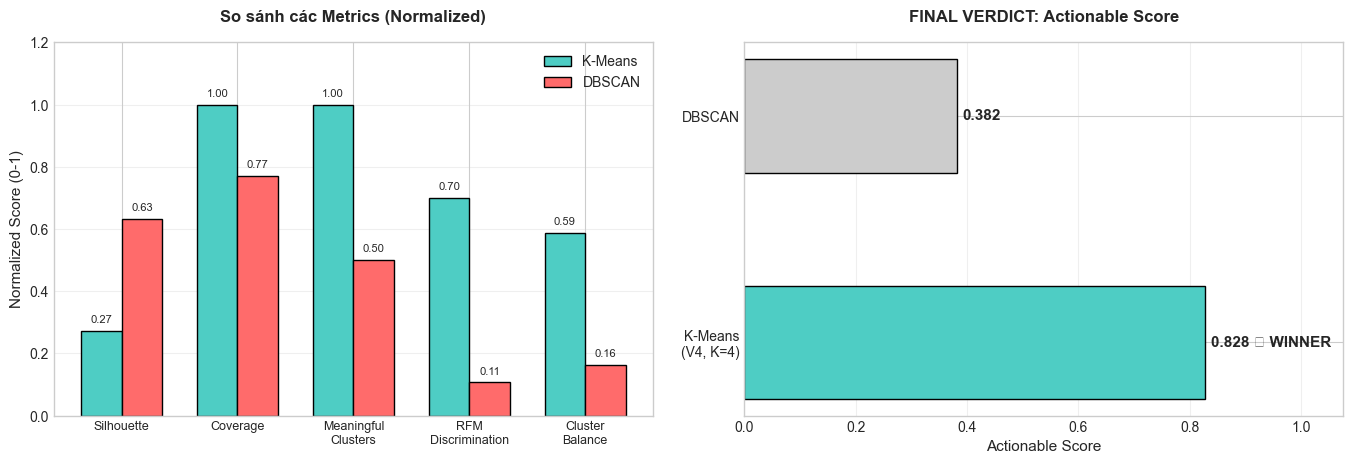

✓ Đã lưu: ../images/KMeans_vs_DBSCAN_FinalVerdict.png

✅ HOÀN THÀNH SO SÁNH K-MEANS VÀ DBSCAN


In [70]:
# =============================================================================
# TRỰC QUAN HÓA SO SÁNH TỔNG HỢP
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Radar chart so sánh các metrics
ax1 = axes[0]

categories = ['Silhouette', 'Coverage', 'Meaningful\nClusters', 'RFM\nDiscrimination', 'Cluster\nBalance']
N = len(categories)

# Normalize scores về 0-1
kmeans_scores = [
    kmeans_silhouette,
    1.0,
    kmeans_actionable['meaningful_clusters'] / K_BASELINE,
    min(kmeans_actionable['rfm_discrimination'], 1),
    kmeans_actionable['cluster_balance']
]

dbscan_scores = [
    dbscan_silhouette if not np.isnan(dbscan_silhouette) else 0,
    dbscan_coverage,
    dbscan_actionable['meaningful_clusters'] / K_BASELINE,
    min(dbscan_actionable['rfm_discrimination'], 1),
    dbscan_actionable['cluster_balance']
]

# Vẽ bar chart thay cho radar (dễ đọc hơn)
x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, kmeans_scores, width, label='K-Means', color='#4ECDC4', edgecolor='black')
bars2 = ax1.bar(x + width/2, dbscan_scores, width, label='DBSCAN', color='#FF6B6B', edgecolor='black')

ax1.set_ylabel('Normalized Score (0-1)', fontsize=11)
ax1.set_title('So sánh các Metrics (Normalized)', fontsize=12, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(categories, fontsize=9)
ax1.legend()
ax1.set_ylim(0, 1.2)
ax1.grid(True, alpha=0.3, axis='y')

# Thêm giá trị
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}',
             ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}',
             ha='center', va='bottom', fontsize=8)

# Chart 2: Final verdict
ax2 = axes[1]

# Lấy giá trị từ actionable dictionaries
kmeans_total = kmeans_actionable['total_actionable']
dbscan_total = dbscan_actionable['total_actionable']

final_scores = [kmeans_total, dbscan_total]
algorithms = [f'K-Means\n(V4, K={K_BASELINE})', 'DBSCAN']
colors = ['#4ECDC4' if kmeans_total > dbscan_total else '#FFB347', 
          '#FF6B6B' if dbscan_total > kmeans_total else '#FFB347']

# Highlight winner
if kmeans_total > dbscan_total:
    colors = ['#4ECDC4', '#CCCCCC']
else:
    colors = ['#CCCCCC', '#FF6B6B']

bars = ax2.barh(algorithms, final_scores, color=colors, edgecolor='black', height=0.5)
ax2.set_xlabel('Actionable Score', fontsize=11)
ax2.set_title('FINAL VERDICT: Actionable Score', fontsize=12, fontweight='bold', pad=15)
ax2.set_xlim(0, max(final_scores) * 1.3)
ax2.grid(True, alpha=0.3, axis='x')

# Thêm giá trị và winner badge
for i, (bar, score) in enumerate(zip(bars, final_scores)):
    width = bar.get_width()
    label = f'{score:.3f}'
    if (i == 0 and kmeans_total > dbscan_total) or (i == 1 and dbscan_total > kmeans_total):
        label += ' 🏆 WINNER'
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, label,
             ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout(pad=2.0)
plt.savefig(f"{IMAGES_DIR}/KMeans_vs_DBSCAN_FinalVerdict.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/KMeans_vs_DBSCAN_FinalVerdict.png")

print("\n" + "=" * 80)
print("✅ HOÀN THÀNH SO SÁNH K-MEANS VÀ DBSCAN")
print("=" * 80)